# Mammography Report Classification with DistilBERT PT

**Competition:** SPR 2026 Mammography Report Classification  
**Task:** Predict BI-RADS category (0–6) from Portuguese mammography reports  
**Model:** `adalbertojunior/distilbert-portuguese-cased` (DistilBERT trained on Portuguese)

## BI-RADS Categories
| Class | Meaning |
|-------|---------|
| 0 | Incomplete — needs additional imaging |
| 1 | Negative — no abnormality |
| 2 | Benign — definitely benign finding |
| 3 | Probably benign — short-interval follow-up |
| 4 | Suspicious — tissue sampling advised |
| 5 | Highly suggestive of malignancy |
| 6 | Known biopsy-proven malignancy |

## 1. Setup & Imports

In [1]:
# Install dependencies if needed
# !pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
)

# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


def resolve_device():
    """Select CUDA only if a tiny forward/backward pass succeeds."""
    if not torch.cuda.is_available():
        return torch.device("cpu")

    try:
        # Smoke-test CUDA to catch runtime incompatibilities early
        x = torch.randn(4, 4, device="cuda")
        w = torch.randn(4, 4, device="cuda", requires_grad=True)
        y = (x @ w).sum()
        y.backward()
        _ = torch.cuda.get_device_name(0)
        return torch.device("cuda")
    except Exception as e:
        print("CUDA available but unusable in this runtime. Falling back to CPU.")
        print(f"Reason: {type(e).__name__}: {e}")
        print("Tip: install a PyTorch build compatible with your GPU (e.g., cu118 for GTX 10xx).")
        return torch.device("cpu")


DEVICE = resolve_device()
print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")



/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce GTX 1060 6GB


## 2. Config

In [3]:
# ── Paths ─────────────────────────────────────────────────────────────────────
DATA_DIR   = "../data"
OUTPUT_DIR = "./outputs_distilbert_weightbalance_newLoss"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Model ─────────────────────────────────────────────────────────────────────
# DistilBERT PT: compact Portuguese encoder model
MODEL_NAME  = "adalbertojunior/distilbert-portuguese-cased"
NUM_CLASSES = 7   # BI-RADS 0–6
MAX_LEN     = 512 # Max BERT tokens (reports avg ~120 tokens, max ~400)

# ── Split ─────────────────────────────────────────────────────────────────────
TEST_SIZE = 0.20  # 20% held-out test set

# ── Training ──────────────────────────────────────────────────────────────────
N_FOLDS      = 5
EPOCHS       = 4
BATCH_SIZE   = 16
ACCUM_STEPS  = 2   # Effective batch = 32
LR           = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
USE_CLASS_WEIGHTS = True
USE_FOCAL_LOSS = True
FOCAL_GAMMA = 2.0



## 3. Data Split

Split `data.csv` into `train.csv` (80%) and `test.csv` (20%) using a **stratified** split
so that every BI-RADS class is proportionally represented in both sets.

The split files are saved to `../data/` and reused in later runs (no re-splitting).

In [4]:
data_df = pd.read_csv(f"{DATA_DIR}/data.csv")
print(f"Full dataset: {data_df.shape}")

train_df, test_df = train_test_split(
    data_df,
    test_size=TEST_SIZE,
    stratify=data_df["target"],
    random_state=SEED,
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_df.to_csv(f"{DATA_DIR}/train.csv", index=False)
test_df.to_csv(f"{DATA_DIR}/test.csv",  index=False)

print(f"Train: {train_df.shape}")
print(f"Test:  {test_df.shape}")

# ── Verify class proportions are preserved ────────────────────────────────────
split_summary = pd.DataFrame({
    "Full":  data_df["target"].value_counts().sort_index(),
    "Train": train_df["target"].value_counts().sort_index(),
    "Test":  test_df["target"].value_counts().sort_index(),
})
split_summary["Train %"] = (split_summary["Train"] / split_summary["Full"] * 100).round(1)
split_summary["Test %"]  = (split_summary["Test"]  / split_summary["Full"] * 100).round(1)
print("\nClass distribution after split:")
print(split_summary)

Full dataset: (18272, 3)


Train: (14617, 3)
Test:  (3655, 3)

Class distribution after split:
         Full  Train  Test  Train %  Test %
target                                     
0         610    488   122     80.0    20.0
1         693    555   138     80.1    19.9
2       15968  12774  3194     80.0    20.0
3         713    570   143     79.9    20.1
4         214    171    43     79.9    20.1
5          29     23     6     79.3    20.7
6          45     36     9     80.0    20.0


## 4. Exploratory Data Analysis

In [5]:
train_df.head(3)

ID                                             report  target
0  Acc19258  Indicação clínica:\n\r rastreamento.\n\rAchado...       2
1   Acc6749  Indicação clínica:\n\r rastreamento.\n\rAchado...       2
2  Acc19497  Indicação clínica:\n\r rastreamento.\n\rAchado...       2

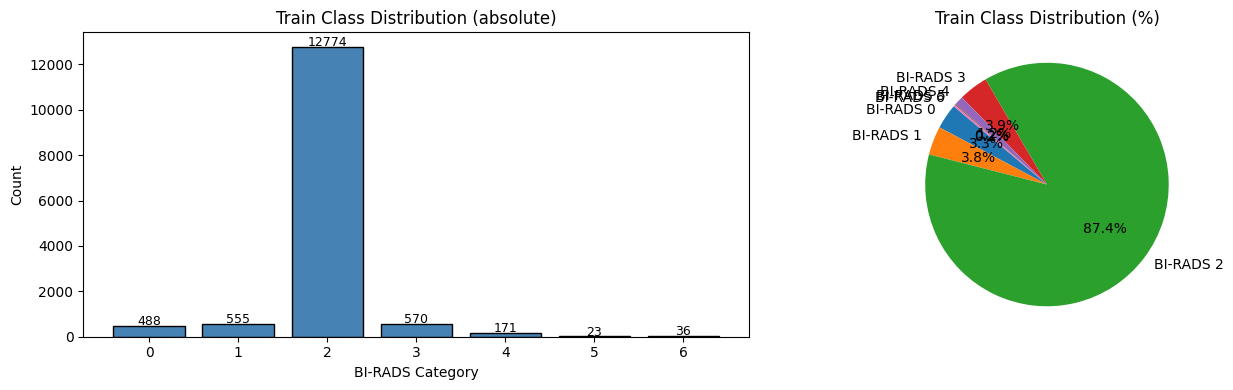


Train class counts:
target
0      488
1      555
2    12774
3      570
4      171
5       23
6       36
Name: count, dtype: int64


In [6]:
# ── Class distribution ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

counts = train_df["target"].value_counts().sort_index()
axes[0].bar(counts.index.astype(str), counts.values, color="steelblue", edgecolor="black")
axes[0].set_xlabel("BI-RADS Category")
axes[0].set_ylabel("Count")
axes[0].set_title("Train Class Distribution (absolute)")
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 30, str(v), ha="center", fontsize=9)

axes[1].pie(counts.values, labels=[f"BI-RADS {c}" for c in counts.index],
            autopct="%1.1f%%", startangle=140)
axes[1].set_title("Train Class Distribution (%)")

plt.tight_layout()
plt.show()

print("\nTrain class counts:")
print(counts)

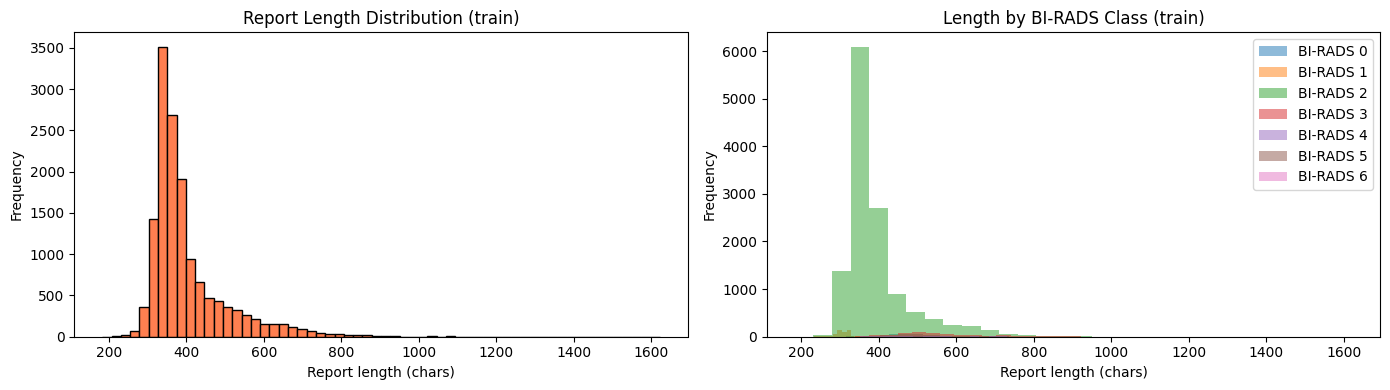

count    14617.000000
mean       400.619074
std        103.531591
min        183.000000
25%        332.000000
50%        363.000000
75%        423.000000
max       1622.000000
Name: char_len, dtype: float64


In [7]:
# ── Report length analysis ────────────────────────────────────────────────────
train_df["char_len"] = train_df["report"].str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(train_df["char_len"], bins=60, color="coral", edgecolor="black")
axes[0].set_xlabel("Report length (chars)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Report Length Distribution (train)")

for cls in sorted(train_df["target"].unique()):
    subset = train_df[train_df["target"] == cls]["char_len"]
    axes[1].hist(subset, bins=30, alpha=0.5, label=f"BI-RADS {cls}")
axes[1].set_xlabel("Report length (chars)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Length by BI-RADS Class (train)")
axes[1].legend()

plt.tight_layout()
plt.show()

print(train_df["char_len"].describe())

In [8]:
# ── Duplicate reports ──────────────────────────────────────────────────────────
n_dup = train_df["report"].duplicated().sum()
print(f"Duplicate reports in train: {n_dup} ({n_dup/len(train_df)*100:.1f}%)")

# Check if duplicates have consistent labels
dup_mask = train_df["report"].duplicated(keep=False)
dup_df = train_df[dup_mask].groupby("report")["target"].nunique()
inconsistent = (dup_df > 1).sum()
print(f"Duplicated reports with inconsistent labels: {inconsistent}")

# ── Check for train/test leakage ───────────────────────────────────────────────
overlap = set(train_df["report"]) & set(test_df["report"])
print(f"\nTrain/test report overlap: {len(overlap)} reports")
if overlap:
    print("  ⚠ Leakage detected — consider deduplicating data.csv before splitting")
else:
    print("  ✓ No leakage")

Duplicate reports in train: 7191 (49.2%)
Duplicated reports with inconsistent labels: 9

Train/test report overlap: 417 reports
  ⚠ Leakage detected — consider deduplicating data.csv before splitting


## 5. Dataset & Tokenization

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ── Check actual token lengths ─────────────────────────────────────────────────
sample_tokens = tokenizer(
    train_df["report"].tolist()[:500],
    truncation=False,
    return_length=True,
)["length"]
print(f"Token length stats (first 500 train samples):")
print(f"  Mean: {np.mean(sample_tokens):.0f}")
print(f"  Max:  {np.max(sample_tokens)}")
print(f"  P95:  {np.percentile(sample_tokens, 95):.0f}")
print(f"  P99:  {np.percentile(sample_tokens, 99):.0f}")
print(f"  Pct > 512: {np.mean(np.array(sample_tokens) > 512)*100:.1f}%")

Token length stats (first 500 train samples):
  Mean: 91
  Max:  475
  P95:  151
  P99:  187
  Pct > 512: 0.0%


In [10]:
class MammographyDataset(Dataset):
    """PyTorch Dataset for mammography reports."""

    def __init__(self, texts, labels=None, tokenizer=None, max_len=512):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        item = {
            "input_ids":      encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }
        if "token_type_ids" in encoding:
            item["token_type_ids"] = encoding["token_type_ids"].squeeze(0)
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

## 6. Class Weights (handle imbalance)

In [11]:
def make_balanced_class_weights(y, num_classes, device):
    """Balanced class weights: n_samples / (n_present_classes * n_class)."""
    y = np.asarray(y, dtype=np.int64)
    counts = np.bincount(y, minlength=num_classes)

    weights = np.ones(num_classes, dtype=np.float32)
    present_mask = counts > 0
    n_present = int(present_mask.sum())

    if n_present > 0:
        n_samples = int(counts[present_mask].sum())
        weights[present_mask] = n_samples / (n_present * counts[present_mask])

    return torch.tensor(weights, dtype=torch.float, device=device), counts


class FocalLoss(nn.Module):
    """Multi-class focal loss with optional per-class alpha weights."""
    def __init__(self, gamma=2.0, weight=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        probs = log_probs.exp()

        target_log_probs = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        target_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        focal_factor = (1.0 - target_probs).pow(self.gamma)
        losses = -focal_factor * target_log_probs

        if self.weight is not None:
            alpha_t = self.weight.gather(0, targets)
            losses = alpha_t * losses

        if self.reduction == "mean":
            return losses.mean()
        if self.reduction == "sum":
            return losses.sum()
        return losses


# Preview weights on full train split (actual training uses fold-specific weights)
class_weights_tensor, class_counts = make_balanced_class_weights(
    train_df["target"].values,
    num_classes=NUM_CLASSES,
    device=DEVICE,
)

print("Class weights preview (balanced):")
for i, w in enumerate(class_weights_tensor.cpu().numpy()):
    print(f"  BI-RADS {i}: {w:.3f}  (n={int(class_counts[i])})")



Class weights preview (balanced):
  BI-RADS 0: 4.279  (n=488)
  BI-RADS 1: 3.762  (n=555)
  BI-RADS 2: 0.163  (n=12774)
  BI-RADS 3: 3.663  (n=570)
  BI-RADS 4: 12.211  (n=171)
  BI-RADS 5: 90.789  (n=23)
  BI-RADS 6: 58.004  (n=36)


## 7. Training & Validation Functions

In [12]:
def train_epoch(model, loader, optimizer, scheduler, criterion, accum_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(loader, desc="Train", leave=False)):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        loss = criterion(outputs.logits, labels) / accum_steps
        loss.backward()

        if (step + 1) % accum_steps == 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps

    return total_loss / len(loader)


@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc="Val", leave=False):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()

        preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    bal_acc  = balanced_accuracy_score(all_labels, all_preds)
    return avg_loss, bal_acc, all_labels, all_preds

## 8. Cross-Validation Training

Cross-validation runs **only on `train_df`**. The held-out `test_df` is never seen during training.

In [13]:
texts  = train_df["report"].tolist()
labels = train_df["target"].tolist()

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

oof_preds  = np.zeros((len(train_df), NUM_CLASSES))  # Out-of-fold probabilities
fold_scores = []
history     = []

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n{'='*60}")
    print(f"  FOLD {fold+1}/{N_FOLDS}")
    print(f"{'='*60}")

    # ── Datasets ───────────────────────────────────────────────────────────────
    train_texts  = [texts[i]  for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts    = [texts[i]  for i in val_idx]
    val_labels   = [labels[i] for i in val_idx]

    train_ds = MammographyDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_ds   = MammographyDataset(val_texts,   val_labels,   tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE*2, shuffle=False,
                              num_workers=0, pin_memory=False)

    # ── Model ──────────────────────────────────────────────────────────────────
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True,
    ).to(DEVICE)

    # ── Optimizer & scheduler ──────────────────────────────────────────────────
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY
    )
    total_steps  = len(train_loader) // ACCUM_STEPS * EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    fold_class_weights = None
    if USE_CLASS_WEIGHTS:
        fold_class_weights, fold_class_counts = make_balanced_class_weights(
            train_labels,
            num_classes=NUM_CLASSES,
            device=DEVICE,
        )
        print("  Fold class weights:")
        for i, w in enumerate(fold_class_weights.cpu().numpy()):
            print(f"    BI-RADS {i}: {w:.3f}  (n={int(fold_class_counts[i])})")

    if USE_FOCAL_LOSS:
        criterion = FocalLoss(gamma=FOCAL_GAMMA, weight=fold_class_weights)
        print(f"  Using Focal Loss (gamma={FOCAL_GAMMA})")
    else:
        criterion = nn.CrossEntropyLoss(weight=fold_class_weights)

    # ── Training loop ──────────────────────────────────────────────────────────
    best_val_acc  = 0
    best_model_path = f"{OUTPUT_DIR}/best_fold{fold+1}.pt"
    fold_history = []

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, scheduler,
                                 criterion, ACCUM_STEPS)
        val_loss, val_acc, val_true, val_pred = eval_epoch(model, val_loader, criterion)

        fold_history.append({
            "fold": fold+1, "epoch": epoch+1,
            "train_loss": train_loss, "val_loss": val_loss, "val_bal_acc": val_acc,
        })

        print(f"  Epoch {epoch+1}/{EPOCHS} — "
              f"train_loss: {train_loss:.4f}  "
              f"val_loss: {val_loss:.4f}  "
              f"val_bal_acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"    ✓ New best model saved (bal_acc={best_val_acc:.4f})")

    # ── OOF predictions from best model ───────────────────────────────────────
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    model.eval()

    all_oof_probs = []
    with torch.no_grad():
        for batch in DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            all_oof_probs.append(torch.softmax(outputs.logits, dim=-1).cpu().numpy())

    oof_preds[val_idx] = np.concatenate(all_oof_probs, axis=0)
    fold_scores.append(best_val_acc)
    history.extend(fold_history)

    print(f"\n  Fold {fold+1} best balanced accuracy: {best_val_acc:.4f}")
    del model
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print(f"CV Balanced Accuracy: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
print(f"Per-fold scores: {[f'{s:.4f}' for s in fold_scores]}")





  FOLD 1/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 19418.07it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                           | 1/103 [00:00<00:01, 72.64it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                      | 2/103 [00:00<00:02, 44.35it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                      | 2/103 [00:00<00:02, 34.05it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▌                                                                                                                                                                                                                                                          | 3/103 [00:00<00:03, 32.61it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▌                                                                                                                                                                                                                                                          | 3/103 [00:00<00:03, 29.02it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|██████████                                                                                                                                                                                                                                                        | 4/103 [00:00<00:02, 33.90it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                      | 4/103 [00:00<00:02, 33.90it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                      | 4/103 [00:00<00:02, 33.90it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                         | 5/103 [00:00<00:02, 33.90it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                         | 5/103 [00:00<00:02, 33.90it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                         | 6/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                         | 6/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                     | 7/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                     | 7/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▌                                                                                                                                                                                                                                        | 8/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▌                                                                                                                                                                                                                                        | 8/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                    | 9/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                    | 9/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▊                                                                                                                                                                                                                                      | 10/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▊                                                                                                                                                                                                                                      | 10/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|███████████████████████████                                                                                                                                                                                                                                  | 11/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|███████████████████████████                                                                                                                                                                                                                                  | 11/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▍                                                                                                                                                                                                                               | 12/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▍                                                                                                                                                                                                                               | 12/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▋                                                                                                                                                                                                                           | 13/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▋                                                                                                                                                                                                                           | 13/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▍                                                                                                                                                                                                                          | 14/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▍                                                                                                                                                                                                                          | 14/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▌                                                                                                                                                                                                                      | 15/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▌                                                                                                                                                                                                                      | 15/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▌                                                                                                                                                                                                                       | 16/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▌                                                                                                                                                                                                                       | 16/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▊                                                                                                                                                                                                                   | 17/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▊                                                                                                                                                                                                                   | 17/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▉                                                                                                                                                                                                                    | 18/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▉                                                                                                                                                                                                                    | 18/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|███████████████████████████████████████████████                                                                                                                                                                                                                | 19/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|███████████████████████████████████████████████                                                                                                                                                                                                                | 19/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 20/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 20/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 21/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▊                                                                                                                                                                                                              | 21/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 22/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 22/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                              | 23/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                              | 23/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 24/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 24/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 25/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                            | 25/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 26/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 26/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 27/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 27/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 28/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 28/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 29/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 29/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 30/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 30/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 31/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 31/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 32/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 32/103 [00:00<00:02, 33.90it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 33/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 173.59it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 95/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 357.73it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 357.73it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 357.73it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 357.73it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 357.73it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 298.17it/s, Materializing param=bert.pooler.dense.weight]

BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  Fold class weights:
    BI-RADS 0: 4.283  (n=390)
    BI-RADS 1: 3.762  (n=444)
    BI-RADS 2: 0.163  (n=10219)
    BI-RADS 3: 3.663  (n=456)
    BI-RADS 4: 12.193  (n=137)
    BI-RADS 5: 92.802  (n=18)
    BI-RADS 6: 57.601  (n=29)
  Using Focal Loss (gamma=2.0)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<21:11,  1.74s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:03<18:43,  1.54s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:04<16:46,  1.38s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<16:04,  1.33s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:28,  1.28s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:08<15:16,  1.26s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<14:59,  1.24s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<14:57,  1.24s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:13<21:50,  1.82s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:14<20:00,  1.66s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:16<18:32,  1.55s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:17<17:34,  1.47s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:18<16:32,  1.38s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:19<15:58,  1.34s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:21<15:21,  1.29s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:22<15:01,  1.26s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:23<14:37,  1.23s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:24<14:29,  1.22s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:25<14:14,  1.20s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<14:13,  1.20s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:28<14:02,  1.19s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:29<13:56,  1.18s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:30<13:43,  1.16s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<13:41,  1.16s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<13:31,  1.15s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<13:33,  1.15s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<13:25,  1.14s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<13:40,  1.17s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<13:43,  1.17s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<13:54,  1.19s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<13:53,  1.19s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:40<14:00,  1.20s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<13:56,  1.20s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:02,  1.21s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:01,  1.21s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<21:02,  1.82s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:49<19:10,  1.66s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:50<18:05,  1.57s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:51<16:52,  1.46s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<16:03,  1.39s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:54<15:20,  1.33s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:55<14:54,  1.30s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<14:25,  1.26s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:18,  1.25s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:01,  1.23s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [01:00<13:57,  1.22s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<13:45,  1.21s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<13:44,  1.21s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<13:28,  1.19s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<13:32,  1.19s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<13:21,  1.18s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<13:21,  1.18s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<13:14,  1.17s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<13:30,  1.20s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<13:29,  1.20s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<13:38,  1.21s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<13:35,  1.21s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<13:41,  1.22s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:15<13:43,  1.23s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:16<13:49,  1.24s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<13:41,  1.23s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:21<20:11,  1.81s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<18:28,  1.66s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:24<17:29,  1.57s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:25<16:23,  1.48s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:26<15:35,  1.41s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:52,  1.34s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:29<14:39,  1.33s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:30<14:05,  1.28s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<13:51,  1.26s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<13:35,  1.24s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:28,  1.23s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:35<13:27,  1.23s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<13:23,  1.22s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:12,  1.21s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:18,  1.22s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:14,  1.21s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<13:16,  1.22s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:09,  1.21s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:12,  1.22s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:08,  1.21s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:17,  1.23s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:14,  1.23s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:20,  1.24s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:14,  1.23s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:18,  1.24s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:17,  1.24s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:55<19:24,  1.81s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:56<17:44,  1.66s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:57<16:36,  1.55s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:59<15:29,  1.45s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [02:00<14:52,  1.40s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:01<14:17,  1.34s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<13:55,  1.31s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:04<13:28,  1.27s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:05<13:16,  1.25s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:06<12:59,  1.23s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<12:53,  1.22s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<12:41,  1.20s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:10<12:42,  1.21s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<12:38,  1.20s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<12:45,  1.22s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<12:41,  1.21s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<12:46,  1.22s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<12:40,  1.21s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<12:47,  1.23s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<12:43,  1.22s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<12:50,  1.24s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<12:47,  1.23s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<12:53,  1.25s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<12:48,  1.24s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<12:52,  1.25s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<12:47,  1.24s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:29<18:36,  1.81s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:30<17:01,  1.66s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:31<15:49,  1.54s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:32<14:47,  1.45s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:34<14:11,  1.39s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:35<13:37,  1.34s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:36<13:17,  1.30s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<12:49,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:39<12:40,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:40<12:33,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:41<12:26,  1.23s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:42<12:13,  1.21s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<12:17,  1.22s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:45<12:18,  1.22s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<12:26,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<12:21,  1.23s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:24,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<12:17,  1.23s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<12:29,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:25,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:24,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<12:18,  1.24s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:21,  1.25s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:14,  1.24s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:15,  1.24s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:11,  1.24s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:16,  1.25s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:04<17:41,  1.80s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:05<16:04,  1.64s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:06<14:47,  1.51s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:08<14:09,  1.45s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:09<13:25,  1.38s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:10<13:03,  1.34s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:11<12:39,  1.30s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:13<12:29,  1.29s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:14<12:15,  1.26s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:15<12:12,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:16<12:02,  1.24s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:18<12:02,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:19<11:54,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:20<11:55,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:21<11:48,  1.23s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<11:51,  1.24s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:24<11:45,  1.23s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<11:53,  1.25s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<11:54,  1.25s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<11:51,  1.25s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<11:44,  1.24s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<11:52,  1.25s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<11:42,  1.24s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<11:42,  1.24s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<11:35,  1.23s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<11:37,  1.24s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:38<16:27,  1.75s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:39<15:05,  1.61s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:40<13:58,  1.49s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:42<13:17,  1.42s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:43<12:42,  1.36s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:44<12:22,  1.33s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:45<11:59,  1.29s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:46<11:51,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:48<11:37,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:49<11:35,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:50<11:31,  1.25s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:51<11:35,  1.26s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:53<11:26,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:54<11:25,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:55<11:16,  1.23s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:56<11:16,  1.23s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:58<11:09,  1.22s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:59<11:11,  1.23s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<11:06,  1.22s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<11:10,  1.23s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<11:04,  1.22s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:04<11:18,  1.25s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:11,  1.24s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:11,  1.24s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:04,  1.23s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:09<11:09,  1.24s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:12<15:59,  1.78s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:13<14:33,  1.63s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:14<13:39,  1.53s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:16<12:57,  1.45s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:17<12:16,  1.38s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:18<11:54,  1.34s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:19<11:30,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:21<11:30,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:22<11:15,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:23<11:11,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:24<10:59,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:25<10:58,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:27<10:50,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:28<10:58,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:29<10:51,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:30<10:50,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:32<10:43,  1.23s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:33<10:53,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:34<10:46,  1.24s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:35<10:46,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:37<10:39,  1.23s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:38<10:41,  1.24s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:39<10:36,  1.23s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:40<10:38,  1.24s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:42<10:33,  1.23s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:43<10:35,  1.24s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:46<14:39,  1.72s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:47<13:24,  1.58s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:48<12:31,  1.47s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:49<11:57,  1.41s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:51<11:24,  1.35s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:52<11:08,  1.32s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:53<10:49,  1.28s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:54<10:52,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:56<10:38,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:57<10:33,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:58<10:31,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:59<10:29,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [05:00<10:20,  1.24s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:02<10:26,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:03<10:19,  1.24s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:04<10:20,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:05<10:14,  1.24s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:07<10:16,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:08<10:09,  1.23s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:09<10:11,  1.24s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:10<10:05,  1.23s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:12<10:06,  1.24s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:13<10:01,  1.23s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:14<10:03,  1.23s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:15<09:58,  1.23s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:17<10:00,  1.23s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:19<14:02,  1.73s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:21<12:50,  1.59s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:22<11:53,  1.48s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:23<11:19,  1.41s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:24<10:49,  1.35s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:26<10:34,  1.32s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:27<10:17,  1.29s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:28<10:12,  1.28s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:29<10:03,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:31<10:01,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:32<09:53,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:33<09:53,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:34<09:46,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:36<09:47,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:37<09:42,  1.23s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:38<09:44,  1.24s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:39<09:38,  1.23s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:40<09:41,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:42<09:36,  1.23s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:43<09:38,  1.24s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:44<09:33,  1.23s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:45<09:35,  1.24s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:47<09:31,  1.23s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:48<09:37,  1.25s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:49<09:31,  1.24s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:50<09:31,  1.24s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:53<13:22,  1.74s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:55<12:12,  1.60s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:56<11:18,  1.48s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:57<10:45,  1.41s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:58<10:16,  1.35s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:59<10:01,  1.32s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [06:01<09:44,  1.29s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:02<09:38,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:03<09:28,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:04<09:26,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:06<09:19,  1.24s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:07<09:20,  1.25s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:08<09:14,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:09<09:15,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:11<09:09,  1.23s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:12<09:11,  1.24s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:13<09:05,  1.23s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:14<09:07,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:15<09:02,  1.23s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:17<09:04,  1.24s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:18<08:59,  1.23s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:19<09:02,  1.23s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:20<08:57,  1.23s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:22<08:58,  1.23s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:23<08:54,  1.23s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:24<08:56,  1.23s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:27<12:35,  1.74s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:28<11:30,  1.59s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:29<10:39,  1.48s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:31<10:08,  1.41s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:32<09:41,  1.35s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:33<09:35,  1.34s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:34<09:17,  1.30s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:36<09:07,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:37<09:09,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:38<09:09,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:40<08:55,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:41<08:53,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:42<08:48,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:43<08:45,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:44<08:38,  1.23s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:46<08:38,  1.24s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:47<08:32,  1.23s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:48<08:33,  1.23s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:49<08:30,  1.23s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:51<08:35,  1.24s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:52<08:29,  1.23s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:53<08:30,  1.24s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:54<08:25,  1.23s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:56<08:27,  1.23s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:57<08:22,  1.22s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:58<08:23,  1.23s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [07:01<11:49,  1.74s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:02<10:54,  1.61s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:03<10:04,  1.49s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:05<09:34,  1.42s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:06<09:08,  1.36s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:07<08:54,  1.33s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:08<08:39,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:10<08:33,  1.28s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:11<08:24,  1.26s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:12<08:23,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:13<08:15,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:15<08:21,  1.26s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:16<08:13,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:17<08:11,  1.24s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:18<08:05,  1.23s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:20<08:13,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:21<08:07,  1.24s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:22<08:07,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:23<08:01,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:24<08:02,  1.24s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:26<07:56,  1.23s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:27<07:57,  1.23s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:28<07:58,  1.24s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:29<07:57,  1.24s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:31<07:57,  1.24s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:32<07:56,  1.24s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:35<11:08,  1.75s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:36<10:08,  1.60s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:37<09:22,  1.48s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:39<08:54,  1.41s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:40<08:29,  1.35s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:41<08:17,  1.32s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:42<08:02,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:44<08:04,  1.29s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:45<07:54,  1.27s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:46<07:49,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:47<07:42,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:48<07:42,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:50<07:41,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:51<07:39,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:52<07:33,  1.23s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:53<07:38,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:55<07:33,  1.24s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:56<07:33,  1.24s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:57<07:28,  1.23s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:58<07:29,  1.24s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [08:00<07:25,  1.23s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:01<07:25,  1.24s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:02<07:22,  1.23s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:03<07:23,  1.23s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:04<07:19,  1.23s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:06<07:20,  1.24s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:09<10:20,  1.74s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:10<09:26,  1.60s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:11<08:43,  1.48s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:12<08:18,  1.41s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:14<07:55,  1.35s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:15<07:43,  1.32s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:16<07:30,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:17<07:25,  1.28s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:18<07:16,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:20<07:15,  1.25s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:21<07:09,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:22<07:09,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:23<07:06,  1.24s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:25<07:07,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:26<07:02,  1.24s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:27<07:02,  1.24s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:28<06:57,  1.23s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:30<06:58,  1.23s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:31<07:00,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:32<07:00,  1.25s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:33<06:53,  1.23s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:35<06:59,  1.25s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:36<06:53,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:37<06:52,  1.24s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:38<06:50,  1.24s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:40<06:50,  1.24s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:42<09:37,  1.75s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:44<08:46,  1.60s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:45<08:06,  1.48s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:46<07:47,  1.43s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:47<07:23,  1.36s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:49<07:10,  1.33s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:50<06:59,  1.30s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:51<06:54,  1.28s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:52<06:44,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:54<06:49,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:55<06:44,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:56<06:41,  1.26s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:57<06:33,  1.24s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:59<06:35,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [09:00<06:31,  1.24s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [09:01<06:30,  1.24s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:02<06:30,  1.24s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:04<06:29,  1.24s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:05<06:24,  1.23s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:06<06:25,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:07<06:21,  1.23s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:09<06:21,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:10<06:18,  1.23s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:11<06:18,  1.23s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:12<06:15,  1.23s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:13<06:16,  1.23s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:15<06:12,  1.22s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:18<08:50,  1.75s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:19<07:59,  1.59s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:20<07:27,  1.49s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:21<07:00,  1.40s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:23<06:45,  1.36s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:24<06:31,  1.31s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:25<06:24,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:26<06:15,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:27<06:12,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:29<06:06,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:30<06:04,  1.24s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:31<06:02,  1.24s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:32<06:02,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:34<06:01,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:35<06:00,  1.25s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:36<05:55,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:37<05:55,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:39<05:50,  1.23s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:40<05:52,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:41<05:49,  1.23s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:42<05:49,  1.24s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:43<05:46,  1.23s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:45<05:50,  1.25s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:46<05:49,  1.25s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:47<05:48,  1.25s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:48<05:44,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:51<08:08,  1.76s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:53<07:20,  1.60s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:54<06:50,  1.49s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:55<06:26,  1.41s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:56<06:11,  1.36s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:58<05:57,  1.32s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:59<05:50,  1.29s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [10:00<05:45,  1.28s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [10:01<05:41,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:03<05:39,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:04<05:37,  1.27s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:05<05:32,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:06<05:32,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:08<05:27,  1.24s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:09<05:26,  1.24s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:10<05:22,  1.23s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:11<05:22,  1.24s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:12<05:19,  1.23s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:14<05:21,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:15<05:16,  1.23s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:16<05:17,  1.23s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:17<05:13,  1.23s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:19<05:17,  1.25s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:20<05:13,  1.24s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:21<05:14,  1.24s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:22<05:10,  1.23s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:25<07:22,  1.76s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:27<06:39,  1.60s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:28<06:12,  1.50s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:29<05:49,  1.41s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:30<05:35,  1.36s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:31<05:23,  1.31s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:33<05:19,  1.30s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:34<05:11,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:35<05:08,  1.27s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:36<05:01,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:38<05:02,  1.26s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:39<04:59,  1.25s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:40<04:56,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:41<04:54,  1.24s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:43<04:52,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:44<04:52,  1.24s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:45<04:53,  1.25s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:46<04:47,  1.23s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:48<04:50,  1.25s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:49<04:46,  1.23s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:50<04:44,  1.23s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:51<04:44,  1.24s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:53<04:44,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:54<04:42,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:55<04:43,  1.25s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:56<04:40,  1.24s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:59<06:38,  1.77s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [11:00<06:00,  1.61s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [11:02<05:36,  1.51s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:03<05:14,  1.42s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:04<05:01,  1.36s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:05<04:49,  1.32s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:07<04:43,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:08<04:35,  1.27s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:09<04:33,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:10<04:27,  1.24s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:12<04:25,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:13<04:20,  1.22s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:14<04:18,  1.21s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:15<04:17,  1.21s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:16<04:15,  1.21s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:17<04:12,  1.20s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:19<04:14,  1.22s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:20<04:11,  1.21s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:21<04:11,  1.22s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:22<04:10,  1.22s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:24<04:10,  1.22s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:25<04:07,  1.21s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:26<04:08,  1.22s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:27<04:12,  1.25s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:29<04:18,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:30<04:18,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:33<05:58,  1.80s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:34<05:23,  1.63s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:36<04:59,  1.52s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:37<04:39,  1.42s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:38<04:30,  1.39s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:39<04:18,  1.33s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:40<04:11,  1.31s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:42<04:04,  1.28s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:43<04:01,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:44<03:56,  1.24s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:45<03:53,  1.24s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:47<03:48,  1.22s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:48<03:50,  1.23s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:49<03:46,  1.22s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:50<03:45,  1.22s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:51<03:44,  1.22s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:53<03:44,  1.23s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:54<03:42,  1.22s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:55<03:43,  1.23s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:56<03:41,  1.23s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:58<03:41,  1.24s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:59<03:39,  1.23s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [12:00<03:39,  1.24s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [12:01<03:37,  1.23s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:03<03:37,  1.24s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:04<03:35,  1.24s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:07<05:10,  1.80s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:08<04:39,  1.63s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:09<04:19,  1.52s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:11<04:02,  1.43s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:12<03:52,  1.38s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:13<03:43,  1.33s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:14<03:38,  1.31s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:16<03:32,  1.28s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:17<03:29,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:18<03:25,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:19<03:23,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:20<03:19,  1.23s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:22<03:19,  1.24s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:23<03:17,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:24<03:19,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:25<03:15,  1.24s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:27<03:14,  1.24s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:28<03:14,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:29<03:12,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:30<03:09,  1.23s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:32<03:12,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:33<03:10,  1.25s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:34<03:08,  1.25s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:35<03:07,  1.25s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:37<03:06,  1.25s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:38<03:03,  1.24s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:41<04:19,  1.76s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:42<03:52,  1.59s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:43<03:36,  1.49s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:45<03:24,  1.42s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:46<03:15,  1.37s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:47<03:07,  1.32s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:48<03:03,  1.30s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:49<02:58,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:51<02:55,  1.26s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:52<02:51,  1.24s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:53<02:50,  1.24s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:54<02:47,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:56<02:47,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:57<02:44,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:58<02:44,  1.23s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:59<02:41,  1.23s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [13:01<02:41,  1.23s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [13:02<02:39,  1.23s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:03<02:39,  1.24s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:04<02:36,  1.23s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:05<02:36,  1.23s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:07<02:34,  1.22s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:08<02:35,  1.25s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:09<02:33,  1.24s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:10<02:32,  1.24s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:12<02:30,  1.23s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:15<03:32,  1.76s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:16<03:11,  1.59s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:17<02:57,  1.49s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:18<02:46,  1.41s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:20<02:39,  1.36s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:21<02:33,  1.32s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:22<02:29,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:23<02:25,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:24<02:23,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:26<02:19,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:27<02:18,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:28<02:15,  1.23s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:29<02:16,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:31<02:13,  1.23s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:32<02:12,  1.24s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:33<02:10,  1.23s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:34<02:09,  1.23s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:36<02:07,  1.23s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:37<02:07,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:38<02:05,  1.23s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:39<02:04,  1.24s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:40<02:02,  1.23s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:42<02:02,  1.23s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:43<02:00,  1.23s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:44<02:00,  1.24s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:45<01:57,  1.23s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:48<02:49,  1.78s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:50<02:31,  1.61s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:51<02:19,  1.50s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:52<02:11,  1.43s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:53<02:04,  1.37s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:55<01:58,  1.32s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:56<01:56,  1.31s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:57<01:52,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:58<01:50,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [14:00<01:47,  1.25s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [14:01<01:45,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [14:02<01:43,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:03<01:42,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:04<01:40,  1.23s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:06<01:40,  1.24s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:07<01:38,  1.23s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:08<01:37,  1.23s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:09<01:35,  1.23s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:11<01:35,  1.24s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:12<01:33,  1.23s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:13<01:32,  1.23s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:14<01:30,  1.22s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:16<01:29,  1.23s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:17<01:27,  1.22s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:18<01:27,  1.23s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:19<01:25,  1.23s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:20<01:25,  1.24s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:23<01:59,  1.75s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:25<01:47,  1.60s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:26<01:37,  1.48s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:27<01:31,  1.41s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:28<01:26,  1.35s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:30<01:23,  1.32s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:31<01:19,  1.29s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:32<01:17,  1.28s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:33<01:15,  1.26s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:34<01:13,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:36<01:13,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:37<01:11,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:38<01:09,  1.24s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:40<01:09,  1.25s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:41<01:06,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:42<01:05,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:43<01:03,  1.23s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:44<01:02,  1.23s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:46<01:01,  1.22s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:47<01:00,  1.23s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:48<00:58,  1.23s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:49<00:58,  1.24s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:51<00:56,  1.23s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:52<00:55,  1.24s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:53<00:53,  1.23s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:54<00:53,  1.23s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:57<01:13,  1.75s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:58<01:05,  1.60s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [15:00<00:59,  1.48s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [15:01<00:55,  1.41s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [15:02<00:51,  1.36s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [15:03<00:49,  1.33s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:05<00:46,  1.29s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:06<00:44,  1.28s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:07<00:42,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:08<00:41,  1.26s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:10<00:39,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:11<00:38,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:12<00:37,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:13<00:35,  1.24s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:14<00:34,  1.23s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:16<00:33,  1.24s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:17<00:31,  1.23s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:18<00:30,  1.24s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:19<00:29,  1.23s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:21<00:28,  1.24s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:22<00:27,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:23<00:25,  1.24s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:24<00:24,  1.23s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:26<00:23,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:27<00:22,  1.24s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:28<00:21,  1.24s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:31<00:28,  1.76s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:32<00:24,  1.62s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:34<00:21,  1.50s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:35<00:18,  1.42s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:36<00:16,  1.36s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:37<00:14,  1.32s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:39<00:13,  1.31s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:40<00:11,  1.30s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:41<00:10,  1.27s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:42<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:43<00:07,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:45<00:06,  1.24s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:46<00:04,  1.23s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:47<00:03,  1.24s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:48<00:02,  1.23s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:50<00:01,  1.24s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:51<00:00,  1.16s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:18,  1.15it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:17,  1.15it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:16,  1.15it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:15,  1.15it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:14,  1.16it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:13,  1.15it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:06<01:13,  1.15it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:12,  1.15it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:11,  1.15it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:10,  1.15it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:09,  1.15it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:08,  1.15it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:49,  1.40s/it]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:35,  1.24s/it]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:25,  1.13s/it]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:18,  1.05s/it]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:17<01:13,  1.00it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:18<01:09,  1.04it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:19<01:07,  1.07it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:20<01:04,  1.10it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:03,  1.11it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:00,  1.12it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<00:58,  1.13it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:25<00:57,  1.14it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:26<00:56,  1.14it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:54,  1.15it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:54,  1.15it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:53,  1.15it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:52,  1.15it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.15it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:50,  1.15it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:49,  1.15it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:33<00:48,  1.15it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:47,  1.15it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:46,  1.15it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:46,  1.15it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:45,  1.15it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:44,  1.15it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:43,  1.15it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:42,  1.15it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:41,  1.15it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:40,  1.15it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.14it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.14it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.15it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:37,  1.14it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:36,  1.14it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:57,  1.40s/it]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:49,  1.25s/it]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:49<00:44,  1.13s/it]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:50<00:40,  1.05s/it]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:51<00:36,  1.00it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:52<00:34,  1.04it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:53<00:32,  1.07it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:54<00:31,  1.09it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:29,  1.10it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:28,  1.11it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:27,  1.12it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:57<00:26,  1.13it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:58<00:25,  1.14it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:59<00:24,  1.15it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [01:00<00:23,  1.15it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:22,  1.15it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:21,  1.15it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:20,  1.16it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:19,  1.15it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.15it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:18,  1.15it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:06<00:17,  1.15it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:07<00:16,  1.15it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.15it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.15it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:13,  1.15it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.15it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.15it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.15it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.15it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:09,  1.14it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.14it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.15it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:06,  1.15it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.15it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.14it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.14it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:21<00:05,  1.41s/it]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:22<00:03,  1.25s/it]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:23<00:02,  1.14s/it]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:24<00:01,  1.06s/it]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.19it/s]

  Epoch 1/4 — train_loss: 1.3125  val_loss: 1.2352  val_bal_acc: 0.5014


    ✓ New best model saved (bal_acc=0.5014)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:36,  1.20s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:20,  1.26s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:05,  1.24s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<15:09,  1.25s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<14:55,  1.23s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:03,  1.25s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:45,  1.22s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:09<14:40,  1.22s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<14:42,  1.22s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<14:45,  1.23s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<14:39,  1.22s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:14<14:42,  1.23s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<14:45,  1.23s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<14:47,  1.24s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:18<14:48,  1.24s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:19<14:49,  1.24s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:20<14:38,  1.23s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:22<14:45,  1.24s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:23<14:39,  1.24s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:24<14:42,  1.24s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:25<14:35,  1.23s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:27<14:39,  1.24s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:28<14:31,  1.23s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<20:53,  1.77s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<18:56,  1.61s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<17:49,  1.52s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<16:50,  1.44s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<16:15,  1.39s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:42,  1.34s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<15:27,  1.32s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<14:54,  1.28s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:33,  1.25s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:10,  1.22s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:03,  1.21s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<13:55,  1.20s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:05,  1.22s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:02,  1.21s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:10,  1.23s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:49<14:05,  1.22s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:11,  1.23s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:52<14:05,  1.23s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:53<14:10,  1.24s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:54<14:04,  1.23s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:55<14:06,  1.23s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:57<14:03,  1.23s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:58<14:15,  1.25s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [00:59<14:08,  1.24s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:00<14:11,  1.25s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:02<14:02,  1.24s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:05<20:11,  1.78s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<18:19,  1.62s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<17:11,  1.52s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<16:13,  1.44s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<15:41,  1.39s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<15:12,  1.35s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:54,  1.33s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<14:28,  1.29s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:18,  1.28s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:01,  1.25s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:00,  1.25s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<13:58,  1.25s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<13:56,  1.25s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<13:43,  1.23s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<13:36,  1.22s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<13:24,  1.21s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:24<13:23,  1.21s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<13:24,  1.21s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:27<13:32,  1.23s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:28<13:25,  1.22s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:29<13:37,  1.24s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:31,  1.23s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:32<13:37,  1.24s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:33<13:30,  1.23s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:34<13:33,  1.24s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:24,  1.23s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:39<19:09,  1.75s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<17:28,  1.60s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<16:25,  1.51s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<15:32,  1.43s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<15:03,  1.39s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<14:31,  1.34s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:13,  1.32s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:49,  1.28s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<13:40,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<13:24,  1.25s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:21,  1.24s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:10,  1.23s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:10,  1.23s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:02,  1.22s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:00,  1.22s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<12:52,  1.21s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<12:53,  1.21s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [01:59<12:46,  1.20s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<12:51,  1.21s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:00,  1.23s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:03<13:05,  1.24s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:04<12:57,  1.23s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:08,  1.24s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:01,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:08<13:03,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:09<12:58,  1.24s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<18:32,  1.77s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:14<17:03,  1.63s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<15:59,  1.53s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<15:02,  1.44s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:18<14:42,  1.41s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<14:05,  1.35s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:43,  1.32s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:26,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:14,  1.28s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<12:57,  1.25s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<12:52,  1.25s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<12:40,  1.23s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<12:39,  1.23s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<12:31,  1.22s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<12:28,  1.22s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:17,  1.20s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<12:17,  1.20s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:08,  1.19s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:20,  1.21s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:17,  1.21s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:23,  1.22s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:19,  1.22s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:39<12:28,  1.23s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:24,  1.23s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:28,  1.24s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:22,  1.23s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<18:04,  1.80s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:48<16:25,  1.64s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:49<15:25,  1.54s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<14:34,  1.46s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<14:06,  1.41s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:53<13:38,  1.37s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<13:24,  1.35s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<12:49,  1.29s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:29,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:08,  1.23s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:01,  1.22s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<11:49,  1.20s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<11:47,  1.20s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<11:37,  1.18s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<11:48,  1.20s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<11:43,  1.20s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<11:46,  1.20s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<11:41,  1.20s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<11:44,  1.20s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<11:39,  1.20s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<11:44,  1.21s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<11:44,  1.21s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<11:53,  1.23s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:14<11:53,  1.23s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<11:59,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<11:55,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:00,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:21<17:47,  1.85s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:23<16:17,  1.70s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:24<15:07,  1.58s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<14:12,  1.49s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:27<13:24,  1.41s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:28<12:58,  1.36s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<12:28,  1.31s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:11,  1.28s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<11:51,  1.25s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:33<11:44,  1.24s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<11:32,  1.22s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<11:30,  1.22s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:21,  1.21s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:19,  1.21s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<11:11,  1.19s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:11,  1.20s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:04,  1.19s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:06,  1.19s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:00,  1.18s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:07,  1.20s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:19,  1.22s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:25,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:22,  1.23s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:25,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:22,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:24,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:55<16:38,  1.82s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:57<15:17,  1.67s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:58<14:14,  1.56s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:59<13:23,  1.47s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<12:40,  1.39s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:02<12:14,  1.35s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:03<11:50,  1.31s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:04<11:35,  1.28s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:15,  1.25s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:07,  1.23s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<10:55,  1.21s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:09<10:52,  1.21s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<10:44,  1.20s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<10:46,  1.20s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<10:47,  1.21s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:14<10:48,  1.21s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<10:41,  1.20s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<10:51,  1.22s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<10:43,  1.21s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<10:45,  1.22s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<10:44,  1.22s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<10:49,  1.23s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<10:52,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<10:56,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<10:50,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<10:53,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:29<15:49,  1.81s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:30<14:31,  1.67s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:32<13:30,  1.55s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:33<12:51,  1.48s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:34<12:07,  1.40s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:35<11:43,  1.35s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:37<11:18,  1.31s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:38<11:03,  1.28s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:39<10:47,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:40<10:41,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<10:31,  1.23s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:43<10:29,  1.23s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:44<10:21,  1.21s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:45<10:19,  1.21s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:09,  1.20s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:09,  1.20s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:49<10:01,  1.18s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:50<10:02,  1.19s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<09:59,  1.18s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:09,  1.21s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:09,  1.21s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:55<10:14,  1.22s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:12,  1.22s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:16,  1.23s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:12,  1.23s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<10:21,  1.25s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:03<15:08,  1.82s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:04<13:56,  1.68s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:05<12:59,  1.57s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:07<12:10,  1.48s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:08<11:28,  1.39s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:09<11:14,  1.37s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:10<10:47,  1.32s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:12<10:27,  1.28s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:13<10:07,  1.24s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:14<09:58,  1.22s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:15<09:44,  1.20s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<09:49,  1.21s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<09:38,  1.19s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:19<09:50,  1.22s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:20<09:44,  1.21s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<09:46,  1.21s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<09:42,  1.21s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:24<09:46,  1.22s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:25<09:42,  1.21s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<09:43,  1.22s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<09:41,  1.22s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<09:46,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:30<09:43,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<09:46,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<09:43,  1.23s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<09:45,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:35<09:45,  1.24s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:38<14:22,  1.83s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:39<13:04,  1.67s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:40<12:11,  1.56s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:42<11:20,  1.45s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:43<10:51,  1.40s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:44<10:23,  1.34s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:45<10:05,  1.30s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:47<09:47,  1.27s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:48<09:39,  1.25s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:49<09:28,  1.23s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:50<09:25,  1.23s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:51<09:17,  1.21s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:53<09:16,  1.21s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:54<09:08,  1.20s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:55<09:08,  1.20s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:56<09:09,  1.21s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:08,  1.21s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:59<09:00,  1.19s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:00<09:07,  1.21s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:01<09:07,  1.21s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:11,  1.22s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:07,  1.22s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:05<09:12,  1.23s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:06<09:11,  1.23s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:14,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:09,  1.23s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:12<13:36,  1.83s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:13<12:13,  1.65s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:14<11:20,  1.54s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:15<10:39,  1.45s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:17<10:11,  1.39s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:18<09:45,  1.33s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:19<09:31,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:20<09:16,  1.27s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:22<09:19,  1.28s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:23<09:08,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:24<09:04,  1.25s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:25<08:56,  1.24s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:26<08:56,  1.24s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:28<08:50,  1.23s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:29<08:51,  1.23s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:30<08:46,  1.22s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:31<08:47,  1.23s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:33<08:42,  1.22s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:34<08:44,  1.23s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:35<08:40,  1.22s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:36<08:43,  1.23s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:37<08:39,  1.22s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:39<08:41,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:40<08:36,  1.22s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:41<08:39,  1.23s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<08:34,  1.22s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:45<12:28,  1.79s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:47<11:13,  1.61s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:48<10:26,  1.50s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:49<09:47,  1.41s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:50<09:31,  1.38s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:52<09:09,  1.33s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:53<08:56,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:54<08:41,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:55<08:36,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:57<08:29,  1.24s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:58<08:28,  1.24s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:59<08:22,  1.23s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:00<08:22,  1.24s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:01<08:17,  1.22s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:03<08:15,  1.22s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:04<08:14,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:05<08:14,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:06<08:08,  1.21s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:07<08:08,  1.22s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:09<08:05,  1.21s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:10<08:08,  1.22s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:11<08:04,  1.22s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:12<08:06,  1.23s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:14<08:08,  1.23s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:15<08:12,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:16<08:05,  1.23s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<08:12,  1.25s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:21<11:53,  1.82s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:22<10:45,  1.65s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:23<09:51,  1.52s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:24<09:19,  1.44s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:26<08:55,  1.38s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:27<08:37,  1.34s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:28<08:17,  1.29s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:29<08:07,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:30<07:56,  1.24s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:32<07:53,  1.24s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:33<07:46,  1.22s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:34<07:44,  1.22s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:35<07:39,  1.21s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:36<07:40,  1.22s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:38<07:36,  1.21s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:39<07:37,  1.21s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:40<07:33,  1.21s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:41<07:36,  1.22s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:42<07:33,  1.21s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:44<07:36,  1.22s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:45<07:33,  1.22s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:46<07:35,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:47<07:31,  1.22s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:49<07:40,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:50<07:34,  1.24s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:51<07:39,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:54<11:11,  1.83s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:56<10:10,  1.67s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:57<09:22,  1.54s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:58<08:52,  1.47s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:59<08:24,  1.39s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:01<08:07,  1.35s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:02<07:50,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:03<07:41,  1.29s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:04<07:30,  1.26s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:06<07:27,  1.25s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:07<07:19,  1.24s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:08<07:18,  1.24s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:09<07:10,  1.22s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:10<07:07,  1.21s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:11<06:59,  1.19s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:13<06:57,  1.19s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:14<06:55,  1.19s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:15<07:00,  1.20s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:16<07:03,  1.22s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:18<07:06,  1.23s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:19<07:02,  1.22s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:20<07:04,  1.23s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:21<07:00,  1.22s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:22<07:01,  1.23s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:24<07:03,  1.24s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:25<07:06,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:28<10:14,  1.81s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:29<09:19,  1.65s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:31<08:35,  1.52s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:32<08:11,  1.46s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:33<07:44,  1.38s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:34<07:28,  1.34s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:36<07:11,  1.29s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:37<07:07,  1.28s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:38<06:56,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:39<06:54,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:40<06:47,  1.23s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:42<06:45,  1.23s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:43<06:39,  1.22s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:44<06:36,  1.21s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:45<06:29,  1.20s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:46<06:28,  1.19s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:48<06:26,  1.19s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:49<06:30,  1.21s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:50<06:28,  1.21s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:51<06:31,  1.22s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:53<06:29,  1.22s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:54<06:32,  1.23s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:55<06:30,  1.23s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:56<06:31,  1.24s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:57<06:28,  1.23s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:59<06:33,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:02<09:29,  1.81s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:03<08:45,  1.68s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:04<08:00,  1.54s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:06<07:30,  1.45s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:07<07:12,  1.39s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:08<06:56,  1.35s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:09<06:37,  1.29s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:11<06:27,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:12<06:17,  1.23s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:13<06:16,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:14<06:09,  1.22s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:15<06:10,  1.22s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:17<06:09,  1.22s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:18<06:11,  1.23s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:19<06:07,  1.22s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:20<06:07,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:22<06:04,  1.22s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:23<06:05,  1.23s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:24<06:01,  1.22s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:25<06:02,  1.23s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:26<06:03,  1.23s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:28<06:03,  1.24s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:29<05:59,  1.23s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:30<06:00,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:31<05:56,  1.23s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:33<05:58,  1.24s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:34<05:57,  1.24s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:37<08:35,  1.80s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:38<07:46,  1.63s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:40<07:13,  1.52s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:41<06:48,  1.44s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:42<06:29,  1.38s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:43<06:09,  1.31s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:44<05:59,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:46<05:53,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:47<05:47,  1.25s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:48<05:38,  1.22s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:49<05:43,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:50<05:39,  1.23s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:52<05:39,  1.23s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:53<05:34,  1.22s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:54<05:36,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:55<05:33,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:57<05:34,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:58<05:31,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:59<05:32,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:00<05:28,  1.23s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:02<05:29,  1.23s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:03<05:25,  1.23s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:04<05:26,  1.23s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:05<05:22,  1.22s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:07<05:31,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:08<05:29,  1.26s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:11<07:53,  1.82s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:12<07:04,  1.63s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:13<06:32,  1.52s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:15<06:07,  1.42s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:16<05:50,  1.36s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:17<05:31,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:18<05:21,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:19<05:15,  1.24s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:20<05:10,  1.23s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:22<05:07,  1.22s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:23<05:08,  1.23s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:24<05:04,  1.22s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:25<05:05,  1.23s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:27<05:02,  1.22s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:28<05:04,  1.23s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:29<05:01,  1.23s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:30<05:02,  1.24s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:31<04:59,  1.23s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:33<05:00,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:34<04:57,  1.23s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:35<04:58,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:36<04:55,  1.23s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:38<04:56,  1.24s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:39<04:52,  1.23s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:40<04:56,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:41<04:58,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:45<07:05,  1.81s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:46<06:20,  1.63s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:47<05:52,  1.51s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:48<05:29,  1.42s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:49<05:15,  1.36s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:51<04:58,  1.30s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:52<04:49,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:53<04:40,  1.23s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:54<04:36,  1.22s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:55<04:31,  1.20s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:57<04:34,  1.22s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:58<04:35,  1.23s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:59<04:35,  1.24s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:00<04:32,  1.23s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:02<04:36,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:03<04:33,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:04<04:32,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:05<04:27,  1.23s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:07<04:29,  1.24s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:08<04:28,  1.24s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:09<04:28,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:10<04:25,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:12<04:27,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:13<04:24,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:14<04:26,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:15<04:29,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:18<06:19,  1.82s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:20<05:39,  1.63s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:21<05:13,  1.52s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:22<04:59,  1.45s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:23<04:45,  1.39s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:25<04:28,  1.32s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:26<04:18,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:27<04:08,  1.23s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:28<04:06,  1.23s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:29<04:00,  1.20s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:30<03:58,  1.20s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:32<03:56,  1.19s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:33<03:58,  1.21s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:34<03:56,  1.21s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:35<03:57,  1.22s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:37<03:56,  1.22s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:38<03:57,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:39<03:54,  1.22s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:40<03:57,  1.24s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:42<03:58,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:43<04:01,  1.28s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:44<03:57,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:46<04:01,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:47<03:58,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:48<03:59,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:49<03:57,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:52<05:36,  1.84s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:54<05:04,  1.67s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:55<04:39,  1.54s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:56<04:19,  1.44s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:57<04:05,  1.37s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:59<03:51,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [12:00<03:44,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [12:01<03:35,  1.23s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:02<03:33,  1.22s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:03<03:28,  1.20s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:04<03:26,  1.19s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:06<03:23,  1.18s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:07<03:23,  1.19s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:08<03:21,  1.18s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:09<03:21,  1.19s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:10<03:19,  1.19s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:12<03:19,  1.20s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:13<03:18,  1.20s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:14<03:19,  1.21s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:15<03:19,  1.22s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:16<03:20,  1.23s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:18<03:17,  1.22s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:19<03:18,  1.23s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:20<03:16,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:21<03:16,  1.23s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:23<03:13,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:24<03:13,  1.23s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:27<04:59,  1.92s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:29<04:26,  1.72s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:30<04:01,  1.56s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:31<03:45,  1.47s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:32<03:31,  1.39s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:34<03:23,  1.35s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:35<03:16,  1.31s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:36<03:12,  1.29s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:37<03:07,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:38<03:05,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:40<03:01,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:41<03:00,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:42<02:57,  1.23s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:43<02:56,  1.24s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:45<02:53,  1.23s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:46<02:56,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:47<02:52,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:48<02:52,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:50<02:48,  1.22s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:51<02:48,  1.23s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:52<02:46,  1.22s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:53<02:47,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:54<02:44,  1.23s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:56<02:43,  1.23s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:57<02:41,  1.22s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:58<02:40,  1.23s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [13:01<03:51,  1.78s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:02<03:29,  1.62s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:04<03:11,  1.50s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:05<03:02,  1.44s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:06<02:52,  1.37s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:07<02:46,  1.33s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:09<02:40,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:10<02:37,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:11<02:32,  1.25s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:12<02:31,  1.25s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:13<02:28,  1.24s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:15<02:28,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:16<02:25,  1.23s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:17<02:24,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:18<02:22,  1.23s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:20<02:21,  1.23s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:21<02:19,  1.23s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:22<02:19,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:23<02:17,  1.22s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:25<02:16,  1.23s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:26<02:14,  1.22s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:27<02:13,  1.23s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:28<02:11,  1.22s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:29<02:11,  1.23s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:31<02:09,  1.22s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:32<02:09,  1.23s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:35<03:05,  1.79s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:36<02:47,  1.63s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:37<02:32,  1.50s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:39<02:23,  1.42s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:40<02:15,  1.36s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:41<02:11,  1.33s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:42<02:06,  1.29s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:44<02:04,  1.28s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:45<02:00,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:46<01:59,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:47<01:57,  1.25s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:49<01:55,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:50<01:54,  1.25s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:51<01:53,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:52<01:50,  1.23s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:54<01:51,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:55<01:49,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:56<01:47,  1.23s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:57<01:46,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:58<01:45,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [14:00<01:42,  1.22s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:01<01:41,  1.23s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:02<01:39,  1.22s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:03<01:39,  1.22s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:05<01:38,  1.23s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:06<01:37,  1.23s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:09<02:19,  1.79s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:10<02:05,  1.62s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:11<01:53,  1.50s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:13<01:48,  1.44s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:14<01:41,  1.37s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:15<01:36,  1.33s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:16<01:34,  1.31s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:18<01:31,  1.29s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:19<01:28,  1.26s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:20<01:26,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:21<01:25,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:23<01:23,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:24<01:21,  1.23s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:25<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:26<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:27<01:17,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:29<01:15,  1.22s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:30<01:14,  1.23s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:31<01:13,  1.22s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:32<01:13,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:34<01:11,  1.23s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:35<01:10,  1.23s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:36<01:08,  1.22s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:37<01:07,  1.23s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:38<01:06,  1.22s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:40<01:05,  1.23s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:41<01:03,  1.22s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:44<01:31,  1.80s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:45<01:21,  1.62s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:47<01:13,  1.51s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:48<01:08,  1.42s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:49<01:04,  1.37s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:50<01:00,  1.32s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:51<00:58,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:53<00:55,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:54<00:54,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:55<00:52,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:56<00:51,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:58<00:49,  1.23s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:59<00:48,  1.23s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [15:00<00:46,  1.22s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [15:01<00:45,  1.23s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:02<00:44,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:04<00:43,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:05<00:41,  1.23s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:06<00:40,  1.24s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:07<00:39,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:09<00:38,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:10<00:36,  1.23s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:11<00:35,  1.23s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:12<00:34,  1.22s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:14<00:33,  1.23s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:15<00:31,  1.22s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:18<00:44,  1.79s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:19<00:38,  1.62s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:20<00:34,  1.51s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:22<00:31,  1.41s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:23<00:28,  1.37s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:24<00:26,  1.32s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:25<00:24,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:26<00:22,  1.27s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:28<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:29<00:19,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:30<00:18,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:31<00:17,  1.23s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:33<00:16,  1.24s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:34<00:14,  1.23s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:35<00:13,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:36<00:12,  1.23s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:37<00:11,  1.23s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:39<00:09,  1.22s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:40<00:08,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:41<00:07,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:42<00:06,  1.24s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:44<00:04,  1.24s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:45<00:03,  1.24s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:46<00:02,  1.23s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:47<00:01,  1.24s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:48<00:00,  1.16s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:18,  1.16it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:03<02:57,  1.97s/it]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:04<02:10,  1.46s/it]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:05<01:47,  1.22s/it]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:06<01:35,  1.09s/it]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:07<01:27,  1.02s/it]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:07<01:22,  1.03it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:08<01:18,  1.07it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:09<01:15,  1.09it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:10<01:13,  1.11it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:11<01:11,  1.13it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:12<01:10,  1.14it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:13<01:09,  1.14it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:08,  1.15it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:07,  1.15it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:06,  1.15it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:16<01:05,  1.15it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:17<01:04,  1.15it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:18<01:03,  1.16it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:19<01:02,  1.16it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:20<01:01,  1.16it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:00,  1.16it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<00:59,  1.16it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<00:58,  1.16it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:57,  1.16it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<00:57,  1.16it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:25<00:56,  1.16it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:26<00:55,  1.16it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:54,  1.16it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:53,  1.16it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:52,  1.16it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:51,  1.15it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.16it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:50,  1.16it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:49,  1.15it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:33<00:48,  1.15it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:47,  1.15it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:46,  1.15it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:37<01:15,  1.43s/it]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:38<01:05,  1.26s/it]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:39<00:58,  1.14s/it]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:40<00:52,  1.06s/it]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:40<00:49,  1.00s/it]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:41<00:46,  1.04it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:42<00:43,  1.07it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:43<00:42,  1.09it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:44<00:40,  1.11it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:45<00:39,  1.12it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:46<00:37,  1.13it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:47<00:36,  1.14it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:35,  1.14it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:34,  1.15it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:49<00:33,  1.15it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:50<00:33,  1.15it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:51<00:32,  1.15it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:52<00:31,  1.15it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:53<00:30,  1.15it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:29,  1.15it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:28,  1.15it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:27,  1.15it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:26,  1.15it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:57<00:26,  1.15it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:58<00:25,  1.15it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:59<00:24,  1.15it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [01:00<00:23,  1.15it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:22,  1.15it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:21,  1.15it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:20,  1.15it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:19,  1.15it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.15it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:18,  1.16it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:06<00:17,  1.16it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.15it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.15it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.15it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:11<00:22,  1.44s/it]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:12<00:18,  1.26s/it]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:13<00:16,  1.14s/it]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:14<00:13,  1.06s/it]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:14<00:11,  1.00it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:15<00:10,  1.04it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:16<00:09,  1.07it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:17<00:08,  1.09it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:18<00:07,  1.11it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:19<00:06,  1.12it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:20<00:05,  1.13it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:21<00:04,  1.14it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:21<00:03,  1.13it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:22<00:02,  1.14it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:23<00:01,  1.14it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:24<00:00,  1.15it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.41it/s]

  Epoch 2/4 — train_loss: 1.0455  val_loss: 0.8247  val_bal_acc: 0.5577


    ✓ New best model saved (bal_acc=0.5577)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:17,  1.17s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<14:56,  1.23s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:46,  1.22s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<14:51,  1.23s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<14:42,  1.22s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<14:46,  1.22s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:39,  1.21s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:09<14:44,  1.22s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:10<14:38,  1.22s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<14:42,  1.22s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<14:41,  1.22s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:14<14:49,  1.24s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:15<14:36,  1.22s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<14:40,  1.23s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:20<21:23,  1.79s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<19:24,  1.63s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<17:49,  1.50s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<16:53,  1.42s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:25<16:05,  1.36s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:56,  1.35s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:28,  1.31s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:11,  1.29s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:30<14:56,  1.27s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:52,  1.26s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:38,  1.24s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:37,  1.24s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<14:27,  1.23s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:29,  1.24s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:20,  1.23s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:22,  1.23s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:15,  1.22s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:18,  1.23s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:12,  1.22s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:15,  1.23s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:09,  1.22s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:12,  1.23s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:04,  1.22s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:12,  1.23s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:49<14:06,  1.22s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:50<14:10,  1.23s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:54<20:33,  1.79s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:55<18:40,  1.63s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<17:11,  1.50s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<16:18,  1.42s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<15:31,  1.36s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [01:00<15:07,  1.33s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:42,  1.29s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:32,  1.28s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:16,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:05<14:13,  1.25s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:01,  1.24s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:01,  1.24s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<13:53,  1.23s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<13:55,  1.23s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<13:47,  1.22s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<13:50,  1.23s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<13:44,  1.22s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<13:46,  1.23s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<13:40,  1.22s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<13:43,  1.23s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<13:37,  1.22s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<13:40,  1.23s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:20<13:34,  1.22s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<13:39,  1.23s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<13:32,  1.22s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:24<13:37,  1.23s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<19:45,  1.78s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:29<17:56,  1.62s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:30<16:31,  1.50s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<15:40,  1.42s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<15:05,  1.37s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:40,  1.34s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:35<14:13,  1.30s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<14:01,  1.28s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:45,  1.26s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:41,  1.25s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<13:30,  1.24s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<13:30,  1.24s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:20,  1.23s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:20,  1.23s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<13:24,  1.24s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<13:25,  1.24s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:17,  1.23s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:18,  1.23s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:11,  1.23s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:14,  1.23s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:07,  1.22s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:10,  1.23s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:04,  1.22s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:08,  1.23s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:02,  1.22s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<13:06,  1.23s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:01<18:59,  1.79s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<17:14,  1.62s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:04<15:52,  1.50s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:05<15:03,  1.42s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:06<14:20,  1.36s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:58,  1.32s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:34,  1.29s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:10<13:25,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<13:10,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:06,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<12:56,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<12:56,  1.24s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<12:48,  1.23s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<12:55,  1.24s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<12:49,  1.23s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<12:51,  1.24s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<12:43,  1.23s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<12:45,  1.23s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<12:38,  1.22s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<12:41,  1.23s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<12:35,  1.22s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<12:38,  1.23s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<12:32,  1.22s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<12:35,  1.23s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:32,  1.22s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<12:35,  1.23s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:28,  1.22s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:36<18:21,  1.80s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<16:29,  1.62s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:39<15:19,  1.51s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:40<14:21,  1.42s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:41<13:48,  1.37s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:42<13:17,  1.32s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<13:03,  1.29s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:45<12:44,  1.27s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<12:38,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<12:27,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:26,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<12:16,  1.23s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<12:22,  1.24s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:13,  1.23s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:14,  1.23s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:02,  1.21s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:01,  1.21s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<11:57,  1.21s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:00,  1.21s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<11:52,  1.20s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<11:56,  1.21s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<11:52,  1.21s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<11:59,  1.22s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<11:56,  1.22s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:05<12:01,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:02,  1.23s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:10<17:52,  1.83s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:11<16:03,  1.65s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:12<14:52,  1.53s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:14<13:53,  1.43s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:15<13:20,  1.38s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:16<12:49,  1.33s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:17<12:35,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<12:16,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:20<12:10,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:21<11:57,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<11:56,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<11:47,  1.23s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<11:47,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<11:40,  1.22s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<11:47,  1.24s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<11:39,  1.23s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<11:40,  1.23s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<11:44,  1.24s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<11:43,  1.24s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<11:32,  1.22s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<11:34,  1.23s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:28,  1.22s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:31,  1.23s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:30,  1.23s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<11:36,  1.24s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:27,  1.23s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:44<16:41,  1.79s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:45<15:01,  1.61s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:46<13:58,  1.50s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:47<13:07,  1.42s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:49<12:38,  1.37s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:50<12:11,  1.32s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:51<11:58,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:52<11:42,  1.27s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:54<11:35,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:55<11:20,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:56<11:17,  1.23s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:57<11:07,  1.22s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<11:05,  1.22s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<10:57,  1.20s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<11:02,  1.22s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<11:04,  1.22s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:06,  1.23s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:01,  1.22s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:04,  1.23s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:06,  1.23s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:08,  1.24s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:02,  1.23s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:04,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<10:58,  1.23s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:00,  1.24s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<10:55,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<10:58,  1.23s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:19<15:54,  1.79s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:20<14:26,  1.63s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:21<13:18,  1.51s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:22<12:37,  1.43s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:24<12:00,  1.36s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:25<11:41,  1.33s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:26<11:25,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:27<11:13,  1.28s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:28<10:54,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:30<10:47,  1.24s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:31<10:35,  1.22s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:32<10:33,  1.22s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<10:31,  1.21s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:35<10:39,  1.23s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<10:32,  1.22s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<10:34,  1.23s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<10:28,  1.22s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<10:32,  1.23s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<10:27,  1.22s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:30,  1.23s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:25,  1.22s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:34,  1.24s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:29,  1.23s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:31,  1.24s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:25,  1.23s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:27,  1.24s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:52<15:06,  1.79s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:54<13:43,  1.63s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:55<12:43,  1.52s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:56<12:05,  1.44s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:57<11:31,  1.38s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:59<11:13,  1.34s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [05:00<10:53,  1.31s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:01<10:41,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:02<10:18,  1.24s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:03<10:08,  1.22s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:05<09:55,  1.20s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:06<09:55,  1.20s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<09:55,  1.21s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<10:00,  1.22s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<09:57,  1.22s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:11<10:01,  1.23s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:06,  1.24s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:05,  1.24s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<09:58,  1.23s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<10:00,  1.23s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<09:56,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<09:58,  1.23s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:00,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<10:01,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<09:53,  1.23s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<09:58,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:26<14:23,  1.80s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:27<13:04,  1.64s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:29<12:04,  1.51s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:30<11:33,  1.45s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:31<11:00,  1.39s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:33<10:42,  1.35s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:34<10:23,  1.32s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:35<10:14,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:36<09:55,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:37<09:49,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:39<09:33,  1.22s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:40<09:27,  1.21s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:41<09:24,  1.21s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:42<09:31,  1.22s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<09:28,  1.22s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:45<09:31,  1.23s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:46<09:26,  1.22s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<09:28,  1.23s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:24,  1.22s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:50<09:26,  1.23s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:51<09:26,  1.23s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:27,  1.24s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:21,  1.23s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:55<09:33,  1.26s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:56<09:26,  1.24s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:25,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [06:00<13:35,  1.80s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:01<12:22,  1.64s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:03<11:28,  1.52s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:04<10:55,  1.45s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:05<10:25,  1.39s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:06<10:09,  1.36s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:08<09:51,  1.32s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:09<09:41,  1.30s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:10<09:27,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:11<09:23,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:13<09:14,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:14<09:12,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:15<09:06,  1.24s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:16<09:07,  1.24s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:17<08:54,  1.21s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:19<08:49,  1.21s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:20<08:40,  1.19s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:21<08:43,  1.20s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:22<08:44,  1.20s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<08:49,  1.22s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:25<08:47,  1.21s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:26<08:50,  1.23s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:27<08:48,  1.22s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<08:51,  1.23s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:30<08:46,  1.23s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:31<08:48,  1.23s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:32<08:47,  1.23s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:35<12:40,  1.78s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:36<11:28,  1.62s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:38<10:43,  1.51s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:39<10:06,  1.43s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:40<09:44,  1.38s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:41<09:31,  1.35s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:43<09:18,  1.33s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:44<09:01,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:45<08:53,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:46<08:48,  1.26s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:48<08:43,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:49<08:35,  1.24s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:50<08:34,  1.24s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:51<08:27,  1.23s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:52<08:21,  1.21s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:54<08:10,  1.19s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:55<08:16,  1.21s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:56<08:15,  1.21s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:57<08:20,  1.22s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:59<08:18,  1.22s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:00<08:21,  1.23s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:01<08:18,  1.23s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:02<08:20,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<08:16,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:05<08:18,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:06<08:13,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:09<11:56,  1.79s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:10<10:51,  1.63s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:12<10:11,  1.53s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:13<09:35,  1.45s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:14<09:10,  1.39s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:15<08:50,  1.34s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:17<08:37,  1.31s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:18<08:19,  1.27s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:19<08:11,  1.25s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:20<08:04,  1.23s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:21<08:02,  1.23s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:23<07:53,  1.21s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:24<07:52,  1.21s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:25<07:45,  1.20s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:26<07:45,  1.20s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:27<07:39,  1.19s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:29<07:39,  1.19s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:30<07:34,  1.18s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:31<07:37,  1.20s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:32<07:42,  1.21s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:33<07:46,  1.22s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:35<07:41,  1.22s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:36<07:49,  1.24s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:37<07:45,  1.23s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:38<07:44,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:40<07:48,  1.25s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:43<11:31,  1.84s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:44<10:27,  1.68s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:45<09:48,  1.58s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:47<09:05,  1.47s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:48<08:42,  1.41s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:49<08:22,  1.36s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:50<08:06,  1.32s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:52<07:45,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:53<07:40,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:54<07:28,  1.22s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:55<07:23,  1.21s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:56<07:15,  1.20s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:58<07:17,  1.21s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:59<07:16,  1.21s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:00<07:20,  1.22s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:01<07:17,  1.22s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:02<07:20,  1.23s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:04<07:16,  1.22s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:05<07:19,  1.23s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:06<07:15,  1.22s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:07<07:17,  1.23s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:09<07:13,  1.22s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:10<07:14,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:11<07:11,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:12<07:12,  1.23s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:13<07:09,  1.23s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:17<10:21,  1.78s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:18<09:20,  1.61s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:19<08:42,  1.50s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:20<08:10,  1.42s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:21<07:51,  1.37s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:23<07:33,  1.32s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:24<07:26,  1.30s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:25<07:24,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:27<07:22,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:28<07:11,  1.27s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:29<07:07,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:30<06:59,  1.24s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:31<07:04,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:33<06:57,  1.24s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:34<06:56,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:35<06:52,  1.24s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:36<06:54,  1.25s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:38<06:49,  1.23s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:39<06:49,  1.24s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:40<06:44,  1.23s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:41<06:44,  1.23s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:43<06:40,  1.22s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:44<06:41,  1.23s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:45<06:37,  1.22s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:46<06:39,  1.23s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:47<06:37,  1.23s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:50<09:28,  1.76s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:52<08:36,  1.61s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:53<08:00,  1.50s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:54<07:30,  1.41s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:55<07:13,  1.36s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:57<06:57,  1.31s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:58<06:50,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:59<06:40,  1.27s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [09:00<06:37,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:01<06:30,  1.24s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:03<06:30,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:04<06:24,  1.23s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:05<06:24,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:06<06:24,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:08<06:23,  1.24s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:09<06:18,  1.23s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:10<06:18,  1.23s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:11<06:13,  1.22s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:13<06:16,  1.23s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:14<06:13,  1.23s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:15<06:14,  1.24s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:16<06:14,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:18<06:13,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:19<06:08,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:20<06:13,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:21<06:09,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:22<06:08,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:25<08:41,  1.76s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:27<07:59,  1.62s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:28<07:20,  1.50s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:29<06:55,  1.42s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:30<06:34,  1.35s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:32<06:29,  1.34s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:33<06:15,  1.30s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:34<06:09,  1.28s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:35<06:05,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:37<06:02,  1.26s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:38<05:55,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:39<05:54,  1.24s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:40<05:55,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:42<05:54,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:43<05:48,  1.24s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:44<05:53,  1.26s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:45<05:47,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:47<05:45,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:48<05:42,  1.23s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:49<05:43,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:50<05:39,  1.23s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:51<05:40,  1.24s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:53<05:36,  1.23s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:54<05:37,  1.24s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:55<05:34,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:56<05:35,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:59<07:52,  1.75s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [10:01<07:11,  1.61s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:02<06:39,  1.49s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:03<06:20,  1.43s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:04<06:03,  1.37s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:06<05:54,  1.34s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:07<05:43,  1.30s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:08<05:38,  1.29s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:09<05:31,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:11<05:29,  1.26s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:12<05:24,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:13<05:23,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:14<05:19,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:16<05:20,  1.25s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:17<05:16,  1.24s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:18<05:17,  1.24s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:19<05:14,  1.24s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:20<05:15,  1.25s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:22<05:12,  1.24s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:23<05:14,  1.25s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:24<05:14,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:26<05:15,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:27<05:13,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:28<05:17,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:29<05:12,  1.27s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:32<06:44,  1.65s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:33<06:14,  1.54s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:34<05:55,  1.47s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:36<05:39,  1.40s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:37<05:30,  1.37s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:38<05:21,  1.34s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:40<05:16,  1.33s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:41<05:07,  1.29s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:42<05:02,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:43<04:56,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:45<04:54,  1.25s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:46<04:50,  1.24s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:47<04:49,  1.24s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:48<04:46,  1.23s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:49<04:46,  1.24s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:51<04:43,  1.23s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:52<04:43,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:53<04:40,  1.23s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:54<04:41,  1.24s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:56<04:44,  1.26s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:57<04:49,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:58<04:49,  1.29s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [11:00<04:49,  1.30s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:01<04:42,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:02<04:43,  1.28s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:03<04:41,  1.28s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:06<05:41,  1.56s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:07<05:24,  1.49s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:08<05:13,  1.45s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:10<05:01,  1.39s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:11<04:53,  1.36s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:12<04:42,  1.32s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:13<04:42,  1.33s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:15<04:35,  1.30s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:16<04:30,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:17<04:24,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:18<04:23,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:20<04:20,  1.25s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:21<04:25,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:22<04:21,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:23<04:20,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:25<04:17,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:26<04:17,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:27<04:14,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:29<04:17,  1.28s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:30<04:17,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:31<04:18,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:32<04:15,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:34<04:15,  1.30s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:35<04:08,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:36<04:08,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:38<04:43,  1.46s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:40<04:35,  1.43s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:41<04:24,  1.38s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:42<04:16,  1.34s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:43<04:07,  1.30s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:45<04:03,  1.29s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:46<03:58,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:47<03:57,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:48<03:55,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:50<03:55,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:51<03:51,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:52<03:50,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:53<03:50,  1.27s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:55<03:53,  1.29s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:56<03:51,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:57<03:52,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:59<03:46,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [12:00<03:43,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [12:01<03:44,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:02<03:47,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:04<03:46,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:05<03:45,  1.30s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:06<03:39,  1.27s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:07<03:37,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:09<03:35,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:11<04:06,  1.46s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:12<03:57,  1.42s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:13<03:53,  1.40s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:15<03:44,  1.35s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:16<03:37,  1.32s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:17<03:31,  1.29s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:18<03:29,  1.28s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:20<03:25,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:21<03:24,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:22<03:21,  1.26s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:23<03:20,  1.26s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:25<03:17,  1.25s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:26<03:20,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:27<03:20,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:29<03:25,  1.32s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:30<03:18,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:31<03:16,  1.29s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:32<03:11,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:34<03:12,  1.27s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:35<03:12,  1.28s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:36<03:15,  1.31s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:38<03:12,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:39<03:09,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:40<03:04,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:41<03:05,  1.28s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:43<03:07,  1.30s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:45<03:29,  1.46s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:46<03:21,  1.42s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:47<03:12,  1.37s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:48<03:04,  1.32s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:50<03:01,  1.30s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:51<02:58,  1.29s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:52<02:57,  1.30s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:53<02:55,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:55<02:53,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:56<02:49,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:57<02:47,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:58<02:47,  1.27s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [13:00<02:49,  1.29s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [13:01<02:48,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:02<02:45,  1.28s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:04<02:41,  1.26s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:05<02:39,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:06<02:38,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:07<02:41,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:09<02:40,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:10<02:40,  1.31s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:11<02:35,  1.28s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:13<02:33,  1.27s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:14<02:31,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:15<02:33,  1.29s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:17<02:49,  1.43s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:18<02:44,  1.41s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:19<02:37,  1.36s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:21<02:33,  1.34s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:22<02:28,  1.30s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:23<02:28,  1.32s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:25<02:26,  1.31s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:26<02:24,  1.31s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:27<02:20,  1.28s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:28<02:18,  1.27s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:30<02:14,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:31<02:16,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:32<02:15,  1.28s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:34<02:16,  1.30s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:35<02:12,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:36<02:11,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:37<02:08,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:39<02:08,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:40<02:07,  1.28s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:41<02:08,  1.30s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:42<02:07,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:44<02:05,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:45<02:01,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:46<02:00,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:48<02:00,  1.28s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:49<02:14,  1.45s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:51<02:09,  1.41s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:52<02:04,  1.37s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:53<01:58,  1.32s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:54<01:55,  1.30s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:56<01:52,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:57<01:52,  1.29s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:58<01:50,  1.28s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [14:00<01:49,  1.29s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [14:01<01:46,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:02<01:44,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:03<01:43,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:05<01:44,  1.29s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:06<01:43,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:07<01:41,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:08<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:10<01:36,  1.26s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:11<01:34,  1.25s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:12<01:36,  1.28s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:14<01:35,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:15<01:35,  1.31s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:16<01:32,  1.28s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:17<01:30,  1.27s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:19<01:28,  1.27s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:20<01:29,  1.29s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:22<01:37,  1.43s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:23<01:34,  1.41s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:24<01:29,  1.36s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:26<01:27,  1.34s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:27<01:23,  1.30s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:28<01:21,  1.30s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:29<01:20,  1.30s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:31<01:19,  1.30s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:32<01:16,  1.27s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:33<01:15,  1.28s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:35<01:13,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:36<01:12,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:37<01:11,  1.28s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:38<01:11,  1.30s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:40<01:09,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:41<01:07,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:42<01:05,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:43<01:04,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:45<01:03,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:46<01:03,  1.30s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:47<01:02,  1.30s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:49<01:00,  1.29s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:50<00:58,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:51<00:56,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:52<00:55,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:54<01:01,  1.43s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:56<00:58,  1.39s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:57<00:55,  1.36s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:58<00:52,  1.32s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:59<00:50,  1.30s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [15:01<00:48,  1.28s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [15:02<00:48,  1.30s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:03<00:46,  1.30s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:04<00:45,  1.29s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:06<00:43,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:07<00:41,  1.26s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:08<00:40,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:09<00:39,  1.28s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:11<00:38,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:12<00:37,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:13<00:35,  1.27s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:15<00:34,  1.27s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:16<00:32,  1.25s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:17<00:31,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:18<00:30,  1.29s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:20<00:30,  1.31s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:21<00:28,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:22<00:27,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:24<00:25,  1.27s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:25<00:24,  1.28s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:26<00:23,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:28<00:24,  1.45s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:29<00:22,  1.39s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:31<00:20,  1.35s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:32<00:18,  1.31s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:33<00:16,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:34<00:15,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:36<00:14,  1.32s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:37<00:12,  1.29s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:38<00:11,  1.28s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:39<00:10,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:41<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:42<00:07,  1.28s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:43<00:06,  1.31s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:45<00:05,  1.31s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:46<00:03,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:47<00:02,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:48<00:01,  1.26s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:49<00:00,  1.20s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:25,  1.06it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:24,  1.06it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:23,  1.06it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:22,  1.07it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:19,  1.09it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:17,  1.11it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.13it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.13it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:14,  1.11it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:15,  1.09it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:26,  1.06s/it]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:22,  1.03s/it]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:18,  1.01it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:14,  1.05it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:11,  1.08it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:09,  1.10it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:07,  1.11it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:07,  1.09it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:07,  1.08it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:06,  1.08it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:05,  1.08it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:03,  1.10it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:00,  1.12it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.14it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.11it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:58,  1.10it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:58,  1.08it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:57,  1.08it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.10it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.11it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:52,  1.12it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.13it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:50,  1.13it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:33<00:50,  1.11it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.10it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.08it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:49,  1.07it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:48,  1.08it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.10it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.13it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.10it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:42,  1.08it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:47,  1.06s/it]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:45,  1.03s/it]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:42,  1.02it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:39,  1.05it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:37,  1.08it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:48<00:36,  1.10it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.10it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.09it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:34,  1.08it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:33,  1.08it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:31,  1.09it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:30,  1.11it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:29,  1.11it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:27,  1.13it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:57<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.11it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.09it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.08it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.09it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.10it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.11it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.12it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.13it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:18,  1.12it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:06<00:18,  1.10it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:07<00:17,  1.09it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:08<00:16,  1.07it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.07it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.09it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.11it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.12it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.13it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.11it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.09it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:10,  1.06s/it]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:09,  1.02s/it]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.01it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.05it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.08it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.09it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:21<00:03,  1.11it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:22<00:02,  1.09it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.08it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.07it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.32it/s]

  Epoch 3/4 — train_loss: 0.7896  val_loss: 1.1700  val_bal_acc: 0.5444


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:55,  1.23s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:04,  1.24s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:13,  1.26s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:14,  1.26s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:25,  1.28s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:52,  1.31s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:45,  1.31s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:30,  1.29s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:18,  1.27s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:15,  1.27s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:21,  1.28s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:38,  1.30s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:38,  1.31s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:31,  1.30s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:14,  1.28s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:10,  1.27s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:21<15:09,  1.27s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:26,  1.30s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<17:01,  1.43s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<16:30,  1.39s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:53,  1.34s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:35,  1.32s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:21,  1.30s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:32,  1.32s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:29,  1.32s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:17,  1.30s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<14:56,  1.27s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:51,  1.27s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:37,  1.25s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:58,  1.28s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:03,  1.29s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:10,  1.30s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:50,  1.28s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:44,  1.27s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:44,  1.27s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<15:00,  1.29s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:59,  1.30s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:11,  1.32s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<15:05,  1.31s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:52,  1.29s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:33,  1.27s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:41,  1.28s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:45,  1.29s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<16:27,  1.44s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<15:52,  1.39s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<15:21,  1.35s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:52,  1.30s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:45,  1.30s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:58,  1.32s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:05<15:05,  1.33s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:39,  1.29s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:29,  1.28s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:13,  1.26s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<14:15,  1.26s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:32,  1.29s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:44,  1.31s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<14:34,  1.30s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:26,  1.29s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:11,  1.27s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:08,  1.27s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:12,  1.27s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:29,  1.30s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:28,  1.30s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:35,  1.31s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:13,  1.28s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:05,  1.27s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:01,  1.27s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:16,  1.29s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<15:43,  1.42s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<15:32,  1.41s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:50,  1.35s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:28,  1.32s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:35<14:18,  1.30s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<14:27,  1.32s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<14:22,  1.31s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:08,  1.29s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<13:49,  1.27s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<13:43,  1.26s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:32,  1.25s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:50,  1.28s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<14:06,  1.30s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:11,  1.31s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:48,  1.28s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<13:44,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<13:30,  1.26s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:42,  1.28s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:47,  1.29s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:59,  1.31s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:51,  1.29s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:40,  1.28s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:25,  1.26s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:31,  1.27s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:59,  1.32s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<15:36,  1.47s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<14:56,  1.41s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:05<14:26,  1.36s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:06<13:57,  1.32s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:52,  1.32s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:50,  1.31s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:10<13:53,  1.32s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<13:29,  1.29s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:20,  1.27s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:16,  1.27s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<13:13,  1.27s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<13:18,  1.28s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:30,  1.30s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<13:38,  1.31s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:27,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:17,  1.28s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:09,  1.27s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:07,  1.27s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:27,  1.30s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:26,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:27,  1.31s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<13:06,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<12:59,  1.27s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:54,  1.26s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<13:16,  1.30s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:35<14:35,  1.43s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:36<14:14,  1.40s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<13:38,  1.34s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:19,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:40<13:01,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:41<13:12,  1.31s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:42<13:17,  1.32s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:44<13:05,  1.30s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:45<12:48,  1.27s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<12:44,  1.27s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<12:32,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:49<12:47,  1.28s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<12:50,  1.28s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<12:59,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:48,  1.28s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<12:41,  1.28s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<12:28,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:38,  1.27s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:58<12:42,  1.28s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:53,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:49,  1.30s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:38,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:03<12:23,  1.26s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:28,  1.27s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:38,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:07<14:02,  1.44s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:08<13:38,  1.40s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:10<13:17,  1.36s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:11<12:48,  1.32s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:12<12:35,  1.30s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<12:24,  1.28s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:15<12:24,  1.28s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:16<12:16,  1.27s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:17<12:17,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<12:10,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:20<12:08,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:21<12:11,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<12:26,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:24<12:27,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<12:20,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<12:05,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<12:02,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<12:00,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:16,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:18,  1.30s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:33<12:27,  1.32s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<12:12,  1.29s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:04,  1.28s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<11:57,  1.27s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:38<12:09,  1.30s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<12:09,  1.30s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:24,  1.33s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:42<12:17,  1.32s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:43<12:12,  1.31s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<12:08,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:46<12:21,  1.33s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:47<12:21,  1.33s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:48<12:23,  1.34s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:50<12:04,  1.31s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:51<11:56,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:52<11:43,  1.27s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:53<11:58,  1.30s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:55<11:58,  1.31s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:56<12:05,  1.32s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:57<11:45,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:59<11:54,  1.31s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<11:38,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<11:44,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:03<11:46,  1.30s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:04<11:55,  1.32s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:40,  1.29s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:32,  1.28s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:08<11:20,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:09<11:27,  1.28s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<11:33,  1.29s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:12<11:44,  1.31s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:13<11:43,  1.31s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:14<11:40,  1.31s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:29,  1.29s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:17<11:31,  1.30s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:18<11:35,  1.31s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:20<11:45,  1.33s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:21<11:36,  1.31s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:22<11:28,  1.30s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:23<11:20,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:25<11:24,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:26<11:23,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:27<11:30,  1.32s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:29<11:32,  1.32s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:30<11:20,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:31<11:05,  1.27s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:32<11:00,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:34<11:04,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:35<11:15,  1.30s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<11:14,  1.30s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:38<11:08,  1.29s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:39<10:53,  1.27s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:40<10:50,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<11:07,  1.30s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:43<11:20,  1.33s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:44<11:14,  1.32s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:45<11:15,  1.32s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:47<11:04,  1.30s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:48<11:01,  1.30s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:49<10:58,  1.30s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:51<11:15,  1.33s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:52<11:13,  1.33s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:53<11:13,  1.33s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:55<10:55,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:56<10:47,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:57<10:40,  1.28s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:58<10:51,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [05:00<10:51,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:01<10:57,  1.32s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:02<10:40,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:04<10:34,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:05<10:27,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:06<10:40,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<10:40,  1.30s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:09<10:45,  1.31s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:10<10:39,  1.30s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:11<10:30,  1.28s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:13<10:18,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:14<10:27,  1.28s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:15<10:29,  1.29s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:17<10:37,  1.31s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:18<10:36,  1.31s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:19<10:34,  1.31s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:20<10:24,  1.29s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:22<10:31,  1.31s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:23<10:32,  1.31s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:24<10:39,  1.33s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:26<10:32,  1.32s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:27<10:24,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:28<10:11,  1.28s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:30<10:13,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:31<10:15,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:32<10:23,  1.31s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:34<10:21,  1.31s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:35<10:12,  1.29s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:36<10:00,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:37<09:58,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:39<10:02,  1.28s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:40<10:10,  1.30s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:41<10:09,  1.30s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:42<10:03,  1.29s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:44<09:50,  1.27s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:45<09:47,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:46<09:50,  1.27s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:48<10:07,  1.31s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:49<10:14,  1.33s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:50<10:12,  1.33s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:52<10:00,  1.31s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:53<09:56,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:54<09:56,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:56<10:05,  1.33s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:57<10:04,  1.33s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:58<10:06,  1.33s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:59<09:50,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:01<09:44,  1.29s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:02<09:41,  1.29s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:03<09:49,  1.31s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:05<09:53,  1.32s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:06<09:50,  1.32s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:07<09:35,  1.28s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:08<09:29,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:10<09:22,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:11<09:37,  1.30s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:12<09:42,  1.31s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:14<09:43,  1.32s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:15<09:27,  1.28s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:16<09:21,  1.27s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:17<09:11,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:19<09:22,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:20<09:24,  1.29s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:21<09:37,  1.32s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:23<09:31,  1.31s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:24<09:28,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:25<09:19,  1.29s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:27<09:27,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:28<09:30,  1.32s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:29<09:35,  1.34s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:31<09:22,  1.31s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:32<09:19,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:33<09:08,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:34<09:11,  1.29s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:36<09:12,  1.30s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:37<09:19,  1.32s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:38<09:11,  1.30s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:40<09:08,  1.30s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:41<08:56,  1.27s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:42<08:56,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:43<08:58,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:45<09:06,  1.30s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:46<09:11,  1.32s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:47<09:01,  1.30s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:49<08:47,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:50<08:49,  1.27s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:51<08:51,  1.28s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:53<09:01,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:54<09:02,  1.32s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:55<09:01,  1.32s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:57<08:51,  1.30s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:58<08:48,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:59<08:51,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:01<09:01,  1.33s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:02<09:01,  1.33s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:03<08:53,  1.32s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:04<08:39,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:06<08:34,  1.28s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:07<08:46,  1.31s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:08<08:54,  1.33s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:10<08:48,  1.32s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:11<08:47,  1.32s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:12<08:32,  1.29s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:13<08:26,  1.28s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:15<08:23,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:16<08:42,  1.32s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:18<08:44,  1.33s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:19<08:43,  1.33s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:20<08:31,  1.30s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:21<08:34,  1.32s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:23<08:26,  1.30s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:24<08:27,  1.30s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:25<08:22,  1.29s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:27<08:26,  1.31s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:28<08:23,  1.30s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:29<08:25,  1.31s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:31<08:20,  1.30s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:32<08:20,  1.31s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:33<08:15,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:34<08:15,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:36<08:10,  1.29s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:37<08:11,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:38<08:06,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:40<08:07,  1.29s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:41<08:03,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:42<08:03,  1.29s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:43<07:59,  1.28s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:45<08:01,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:46<07:56,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:47<07:58,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:49<07:53,  1.28s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:50<07:58,  1.30s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:51<07:53,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:52<07:53,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:54<07:48,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:55<07:50,  1.29s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:56<07:45,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:58<07:48,  1.29s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:59<07:48,  1.29s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:00<07:51,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:02<07:54,  1.32s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:03<08:09,  1.36s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:04<08:04,  1.35s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:06<08:02,  1.35s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:07<07:55,  1.33s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:08<08:00,  1.35s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:10<07:52,  1.33s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:11<07:51,  1.34s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:12<07:43,  1.32s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:14<07:46,  1.33s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:15<07:45,  1.33s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:16<07:47,  1.34s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:18<07:42,  1.33s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:19<07:43,  1.33s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:20<07:35,  1.32s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:22<07:40,  1.33s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:23<07:34,  1.32s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:24<07:36,  1.33s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:26<07:32,  1.32s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:27<07:33,  1.33s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:28<07:30,  1.32s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:30<07:39,  1.36s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:31<07:36,  1.35s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:32<07:42,  1.37s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:34<07:46,  1.39s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:35<07:54,  1.42s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:37<07:47,  1.40s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:38<07:41,  1.39s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:39<07:36,  1.37s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:41<07:35,  1.38s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:42<07:28,  1.36s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:44<07:29,  1.36s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:45<07:21,  1.35s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:46<07:21,  1.35s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:48<07:17,  1.34s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:49<07:20,  1.36s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:50<07:19,  1.36s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:52<07:32,  1.40s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:53<07:37,  1.42s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:55<07:43,  1.44s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:56<07:33,  1.42s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:58<07:35,  1.43s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:59<07:22,  1.39s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [09:00<07:17,  1.38s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [09:01<07:07,  1.35s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [09:03<07:08,  1.36s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:04<07:01,  1.34s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:05<06:59,  1.34s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:07<06:54,  1.33s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:08<06:56,  1.34s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:09<06:50,  1.32s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:11<06:51,  1.33s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:12<06:46,  1.32s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:13<06:47,  1.33s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:15<06:46,  1.33s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:16<06:44,  1.33s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:17<06:39,  1.32s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:19<06:40,  1.32s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:20<06:36,  1.31s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:21<06:37,  1.32s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:23<06:34,  1.32s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:24<06:44,  1.35s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:25<06:35,  1.33s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:27<06:34,  1.33s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:28<06:28,  1.31s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:29<06:28,  1.32s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:31<06:23,  1.30s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:32<06:34,  1.35s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:33<06:29,  1.33s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:35<06:26,  1.33s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:36<06:24,  1.33s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:37<06:24,  1.33s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:39<06:23,  1.33s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:40<06:30,  1.36s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:41<06:21,  1.34s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:43<06:19,  1.33s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:44<06:13,  1.32s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:45<06:17,  1.33s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:47<06:12,  1.32s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:48<06:13,  1.33s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:49<06:10,  1.32s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:51<06:08,  1.32s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:52<06:08,  1.33s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:53<06:06,  1.32s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:54<06:00,  1.31s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:56<06:07,  1.34s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:57<06:02,  1.32s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:58<06:00,  1.32s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [10:00<05:54,  1.30s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [10:01<05:55,  1.31s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [10:02<05:51,  1.30s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [10:04<06:00,  1.34s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:05<05:53,  1.32s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:06<05:59,  1.35s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:08<05:54,  1.33s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:09<05:51,  1.33s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:10<05:49,  1.32s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:12<05:53,  1.35s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:13<05:47,  1.33s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:14<05:49,  1.34s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:16<05:43,  1.32s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:17<05:41,  1.32s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:18<05:38,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:20<05:40,  1.33s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:21<05:37,  1.32s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:22<05:36,  1.32s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:24<05:33,  1.31s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:25<05:32,  1.32s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:26<05:28,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:28<05:32,  1.32s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:29<05:29,  1.32s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:30<05:29,  1.32s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:32<05:24,  1.31s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:33<05:25,  1.32s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:34<05:23,  1.31s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:36<05:24,  1.33s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:37<05:21,  1.32s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:38<05:18,  1.31s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:39<05:14,  1.30s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:41<05:14,  1.31s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:42<05:11,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:43<05:13,  1.31s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:45<05:19,  1.34s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:46<05:20,  1.35s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:47<05:12,  1.32s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:49<05:14,  1.34s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:50<05:08,  1.32s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:51<05:08,  1.33s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:53<05:03,  1.31s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:54<05:02,  1.31s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:55<04:58,  1.30s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:57<04:59,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:58<04:56,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:59<04:56,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [11:00<04:53,  1.30s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [11:02<04:53,  1.30s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [11:03<04:50,  1.30s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [11:04<04:51,  1.31s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:06<04:47,  1.30s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:07<04:47,  1.30s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:08<04:44,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:10<04:46,  1.31s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:11<04:43,  1.30s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:12<04:43,  1.31s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:13<04:40,  1.30s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:15<04:40,  1.31s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:16<04:37,  1.29s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:17<04:42,  1.33s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:19<04:38,  1.31s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:20<04:39,  1.33s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:21<04:35,  1.31s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:23<04:34,  1.31s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:24<04:29,  1.30s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:25<04:29,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:27<04:31,  1.32s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:28<04:30,  1.32s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:29<04:25,  1.30s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:31<04:27,  1.32s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:32<04:23,  1.31s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:33<04:22,  1.31s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:34<04:20,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:36<04:20,  1.31s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:37<04:16,  1.30s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:38<04:16,  1.30s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:40<04:12,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:41<04:13,  1.30s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:42<04:09,  1.29s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:44<04:13,  1.31s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:45<04:11,  1.31s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:46<04:10,  1.31s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:47<04:07,  1.30s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:49<04:07,  1.31s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:50<04:04,  1.30s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:51<04:04,  1.31s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:53<04:01,  1.30s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:54<04:03,  1.31s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:55<04:02,  1.32s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:57<04:00,  1.32s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:58<03:56,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:59<03:57,  1.31s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [12:00<03:53,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [12:02<03:54,  1.31s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [12:03<03:51,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [12:04<03:50,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [12:06<03:48,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:07<03:47,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:08<03:44,  1.29s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:10<03:44,  1.30s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:11<03:41,  1.29s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:12<03:41,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:13<03:40,  1.30s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:15<03:40,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:16<03:38,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:17<03:38,  1.31s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:19<03:36,  1.30s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:20<03:36,  1.31s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:21<03:33,  1.30s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:23<03:32,  1.31s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:24<03:30,  1.30s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:25<03:29,  1.30s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:26<03:27,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:28<03:29,  1.32s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:29<03:26,  1.31s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:30<03:26,  1.32s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:32<03:23,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:33<03:22,  1.31s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:34<03:19,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:36<03:19,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:37<03:16,  1.29s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:38<03:16,  1.30s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:39<03:13,  1.29s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:41<03:13,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:42<03:11,  1.29s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:43<03:10,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:45<03:08,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:46<03:08,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:47<03:10,  1.32s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:49<03:11,  1.34s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:50<03:06,  1.31s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:51<03:06,  1.32s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:53<03:03,  1.31s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:54<03:02,  1.31s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:55<02:59,  1.30s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:57<02:58,  1.30s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:58<02:56,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:59<02:56,  1.31s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [13:00<02:53,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [13:02<02:53,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [13:03<02:50,  1.29s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [13:04<02:50,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [13:06<02:48,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:07<02:48,  1.31s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:08<02:45,  1.29s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:10<02:44,  1.30s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:11<02:43,  1.30s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:12<02:42,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:13<02:41,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:15<02:40,  1.31s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:16<02:38,  1.30s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:17<02:37,  1.30s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:19<02:35,  1.30s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:20<02:35,  1.30s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:21<02:32,  1.30s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:23<02:32,  1.31s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:24<02:30,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:25<02:29,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:26<02:27,  1.29s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:28<02:27,  1.30s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:29<02:24,  1.29s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:30<02:24,  1.30s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:32<02:22,  1.29s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:33<02:22,  1.31s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:34<02:20,  1.30s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:36<02:19,  1.31s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:37<02:17,  1.30s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:38<02:16,  1.30s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:39<02:14,  1.29s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:41<02:13,  1.30s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:42<02:11,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:43<02:11,  1.30s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:45<02:09,  1.30s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:46<02:09,  1.31s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:47<02:07,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:48<02:06,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:50<02:04,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:51<02:03,  1.30s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:52<02:01,  1.29s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:54<02:02,  1.32s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:55<02:00,  1.31s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:56<01:59,  1.31s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:58<01:57,  1.31s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:59<01:57,  1.32s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [14:00<01:54,  1.30s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [14:02<01:54,  1.32s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [14:03<01:53,  1.32s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [14:04<01:51,  1.32s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [14:06<01:49,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:07<01:48,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:08<01:46,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:09<01:45,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:11<01:43,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:12<01:42,  1.30s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:13<01:41,  1.29s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:15<01:40,  1.30s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:16<01:38,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:17<01:37,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:18<01:35,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:20<01:35,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:21<01:33,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:22<01:32,  1.30s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:24<01:30,  1.29s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:25<01:29,  1.30s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:26<01:29,  1.32s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:28<01:29,  1.33s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:29<01:26,  1.31s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:30<01:25,  1.31s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:32<01:23,  1.30s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:33<01:23,  1.32s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:34<01:21,  1.31s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:36<01:19,  1.31s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:37<01:17,  1.30s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:38<01:16,  1.30s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:39<01:15,  1.29s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:41<01:14,  1.30s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:42<01:12,  1.29s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:43<01:11,  1.30s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:45<01:10,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:46<01:09,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:47<01:07,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:48<01:06,  1.30s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:50<01:04,  1.29s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:51<01:03,  1.30s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:52<01:02,  1.29s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:54<01:01,  1.32s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:55<00:59,  1.30s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:56<00:58,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:58<00:57,  1.31s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:59<00:56,  1.31s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [15:00<00:54,  1.31s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [15:02<00:53,  1.32s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [15:03<00:52,  1.30s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [15:04<00:50,  1.31s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [15:05<00:49,  1.31s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [15:07<00:48,  1.31s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:08<00:46,  1.31s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:09<00:45,  1.31s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:11<00:44,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:12<00:43,  1.30s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:13<00:41,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:15<00:40,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:16<00:38,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:17<00:37,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:18<00:36,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:20<00:35,  1.30s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:21<00:33,  1.29s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:22<00:32,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:24<00:30,  1.29s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:25<00:29,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:26<00:28,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:28<00:27,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:29<00:26,  1.30s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:30<00:24,  1.31s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:31<00:23,  1.30s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:33<00:22,  1.31s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:34<00:21,  1.31s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:35<00:19,  1.33s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:37<00:18,  1.31s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:38<00:17,  1.32s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:39<00:15,  1.31s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:41<00:14,  1.31s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:42<00:12,  1.30s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:43<00:11,  1.32s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:45<00:10,  1.30s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:46<00:09,  1.30s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:47<00:07,  1.30s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:48<00:06,  1.31s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:50<00:05,  1.30s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:51<00:03,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:52<00:02,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:54<00:01,  1.32s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:55<00:00,  1.24s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.11it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:21,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:21,  1.09it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:21,  1.08it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:19,  1.09it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:18,  1.09it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:18,  1.09it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:17,  1.09it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:16,  1.09it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:15,  1.09it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:14,  1.09it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:13,  1.09it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:12,  1.08it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:11,  1.09it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:10,  1.09it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:09,  1.09it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:08,  1.09it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:07,  1.09it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:07,  1.08it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:06,  1.08it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:05,  1.08it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:04,  1.09it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:03,  1.09it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:02,  1.09it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:01,  1.09it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:00,  1.09it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:59,  1.09it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:58,  1.09it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:57,  1.09it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:56,  1.09it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.09it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:55,  1.09it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:54,  1.09it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:53,  1.09it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:52,  1.09it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:33<00:51,  1.09it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.09it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.09it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.09it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.09it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.09it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.09it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:45,  1.08it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:44,  1.08it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:43,  1.08it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:42,  1.09it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:41,  1.09it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:40,  1.09it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:39,  1.09it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:38,  1.09it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:37,  1.09it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.09it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.09it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.09it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:34,  1.08it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:33,  1.08it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:32,  1.08it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:31,  1.09it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:30,  1.09it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:29,  1.09it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:28,  1.09it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.09it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.09it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.08it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.08it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:24,  1.08it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:23,  1.08it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:22,  1.08it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.09it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.09it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.09it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:06<00:18,  1.09it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:07<00:17,  1.08it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:08<00:16,  1.09it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.09it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.09it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.09it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.08it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:12,  1.08it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:11,  1.08it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.08it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.08it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.08it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.08it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.08it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.09it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.09it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.09it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.08it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.08it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.08it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.34it/s]

  Epoch 4/4 — train_loss: 0.6869  val_loss: 0.9981  val_bal_acc: 0.5550



  Fold 1 best balanced accuracy: 0.5577

  FOLD 2/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 32263.88it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 586.12it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 314.69it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 175.63it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 175.53it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 162.07it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 181.03it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 167.51it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 175.05it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 166.46it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 161.52it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 153.45it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 153.61it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 149.22it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 162.46it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 160.07it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 170.95it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 168.78it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 184.25it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 182.25it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 197.29it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 194.86it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 209.66it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 207.15it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 220.85it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 218.29it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 232.02it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 229.22it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 242.33it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 239.91it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 252.21it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 249.36it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 261.22it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 258.70it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 270.50it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 268.05it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 279.74it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 276.47it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 287.74it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 285.21it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 295.45it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 293.19it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 304.85it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 302.14it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 312.18it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 308.09it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 317.61it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 314.56it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 324.39it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 321.90it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 331.87it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 328.95it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 337.95it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 334.63it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 342.74it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 340.01it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 348.64it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 345.66it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 337.86it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 335.47it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 344.29it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 340.53it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 348.62it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 345.74it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 353.10it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 350.81it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 358.28it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 355.86it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 362.90it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 356.47it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 364.23it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 361.80it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 37/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 369.55it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 96/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 498.12it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 498.12it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 498.12it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 498.12it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 498.12it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 478.97it/s, Materializing param=bert.pooler.dense.weight]

BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  Fold class weights:
    BI-RADS 0: 4.283  (n=390)
    BI-RADS 1: 3.762  (n=444)
    BI-RADS 2: 0.163  (n=10219)
    BI-RADS 3: 3.663  (n=456)
    BI-RADS 4: 12.193  (n=137)
    BI-RADS 5: 92.802  (n=18)
    BI-RADS 6: 57.601  (n=29)
  Using Focal Loss (gamma=2.0)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:23,  1.27s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<16:06,  1.33s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<16:12,  1.34s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<16:07,  1.33s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:49,  1.31s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:57,  1.32s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:54,  1.32s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:53,  1.32s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:41,  1.30s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:43,  1.31s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:38,  1.30s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:43,  1.31s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:30,  1.30s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:38,  1.31s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:32,  1.30s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:32,  1.30s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:23,  1.29s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:25,  1.30s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:32,  1.31s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:33,  1.31s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:24,  1.30s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:27,  1.31s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:30<15:20,  1.30s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:23,  1.31s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:17,  1.30s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:20,  1.31s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<15:12,  1.30s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:16,  1.30s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:08,  1.29s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<15:34,  1.33s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:24,  1.32s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:20,  1.32s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<15:09,  1.30s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:19,  1.32s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:14,  1.31s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<15:10,  1.31s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<15:07,  1.31s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:07,  1.31s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:51<14:58,  1.30s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<15:00,  1.30s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:52,  1.29s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:55,  1.30s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<14:55,  1.30s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:58,  1.31s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:50,  1.30s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [01:00<14:52,  1.30s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:45,  1.29s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:49,  1.30s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:43,  1.30s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:05<14:49,  1.31s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:48,  1.31s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:51,  1.31s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:09<14:42,  1.30s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<14:45,  1.31s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:38,  1.30s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<14:41,  1.31s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<14:31,  1.29s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:38,  1.31s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:17<14:33,  1.30s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:35,  1.30s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:44,  1.32s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:21<14:44,  1.32s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<14:30,  1.30s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:29,  1.30s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:20,  1.29s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:26<14:23,  1.30s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:16,  1.29s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:20,  1.30s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:30<14:14,  1.29s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<14:18,  1.30s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:11,  1.29s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:16,  1.30s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:35<14:09,  1.29s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<14:15,  1.30s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<14:10,  1.30s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:39<14:14,  1.31s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<14:08,  1.30s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<14:12,  1.31s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:43<14:05,  1.30s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<14:08,  1.30s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<14:01,  1.29s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:04,  1.30s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:48<14:05,  1.31s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<14:08,  1.31s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<13:58,  1.30s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:52<14:00,  1.30s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<13:52,  1.29s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<14:07,  1.32s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:56<13:57,  1.30s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:57<13:56,  1.31s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:48,  1.29s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:51,  1.30s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:01<13:50,  1.30s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<13:50,  1.30s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:43,  1.29s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:05<13:45,  1.30s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:06<13:44,  1.30s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:47,  1.31s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:09<13:41,  1.30s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:10<13:52,  1.32s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<13:44,  1.31s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:13<13:43,  1.31s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:14<13:54,  1.33s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<13:59,  1.34s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:17<13:42,  1.31s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:18<13:44,  1.32s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<13:42,  1.32s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:21<13:40,  1.32s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:22<13:28,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:23<13:28,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:31,  1.31s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:26<13:31,  1.31s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:27<13:20,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:26,  1.31s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:30<13:20,  1.30s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:31<13:22,  1.31s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:32<13:15,  1.30s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<13:16,  1.30s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:35<13:08,  1.29s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:36<13:14,  1.30s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<13:10,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:39<13:10,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:40<13:04,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:41<13:10,  1.30s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:43<13:06,  1.30s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:44<13:09,  1.31s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:45<13:04,  1.30s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<13:08,  1.31s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:48<13:02,  1.30s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:49<13:05,  1.31s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<12:58,  1.30s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:52<13:01,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:53<12:54,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<13:01,  1.31s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:56<13:00,  1.31s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:57<13:00,  1.31s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:58<12:50,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [03:00<12:51,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:01<12:44,  1.29s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:02<12:46,  1.30s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:03<12:40,  1.29s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:05<12:43,  1.30s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:06<12:37,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:07<12:41,  1.30s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:09<12:35,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:10<12:37,  1.30s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:11<12:41,  1.30s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:12<12:43,  1.31s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:14<12:37,  1.30s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:15<12:40,  1.31s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:16<12:33,  1.30s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:18<12:36,  1.31s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:19<12:30,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:20<12:32,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:22<12:26,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:23<12:28,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:24<12:23,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<12:25,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:27<12:19,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:28<12:22,  1.30s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<12:16,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:31<12:19,  1.30s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:32<12:21,  1.31s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:33<12:21,  1.31s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:35<12:13,  1.30s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:36<12:22,  1.31s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:37<12:14,  1.30s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:39<12:14,  1.31s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:40<12:19,  1.32s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:41<12:19,  1.32s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:42<12:07,  1.30s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:44<12:17,  1.32s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:45<12:10,  1.31s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:46<12:11,  1.31s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:48<12:04,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:49<12:06,  1.31s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:50<11:59,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:52<12:01,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:53<11:54,  1.29s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:54<12:02,  1.31s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:55<11:56,  1.30s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:57<11:58,  1.31s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:58<11:48,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:59<12:00,  1.32s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:01<11:52,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:02<11:51,  1.30s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:03<11:42,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:05<11:46,  1.30s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:06<11:41,  1.29s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:07<11:44,  1.30s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:08<11:39,  1.30s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:10<11:42,  1.30s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:11<11:36,  1.30s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:12<11:37,  1.30s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:14<11:31,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:15<11:33,  1.30s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:16<11:28,  1.29s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:18<11:34,  1.30s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:19<11:29,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:20<11:33,  1.31s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:21<11:28,  1.30s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:23<11:32,  1.31s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:24<11:25,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:25<11:28,  1.31s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:27<11:22,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:28<11:24,  1.30s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:29<11:19,  1.30s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:31<11:21,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:32<11:16,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:33<11:19,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:34<11:13,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:36<11:15,  1.30s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:37<11:10,  1.29s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:38<11:13,  1.30s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:40<11:07,  1.29s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:41<11:10,  1.30s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:42<11:04,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:44<11:06,  1.30s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:45<11:02,  1.29s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:46<11:04,  1.30s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:47<10:58,  1.29s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:49<11:01,  1.30s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:50<11:09,  1.32s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:51<11:10,  1.32s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:53<10:59,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:54<11:03,  1.31s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:55<10:57,  1.31s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:57<10:58,  1.31s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:58<10:58,  1.31s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:59<10:58,  1.31s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [05:01<10:50,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:02<10:50,  1.30s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:03<10:44,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:04<10:45,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:06<10:44,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:07<10:46,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:08<10:39,  1.29s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:10<10:42,  1.30s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:11<10:35,  1.29s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:12<10:42,  1.31s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:14<10:39,  1.31s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:15<10:38,  1.31s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:16<10:34,  1.30s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:17<10:37,  1.31s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:19<10:28,  1.29s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:20<10:29,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:21<10:24,  1.29s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:23<10:28,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:24<10:34,  1.32s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:25<10:35,  1.32s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:27<10:26,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:28<10:26,  1.31s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:29<10:32,  1.32s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:31<10:31,  1.32s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:32<10:21,  1.31s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:33<10:20,  1.31s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:34<10:16,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:36<10:18,  1.31s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:37<10:12,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:38<10:13,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:40<10:07,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:41<10:09,  1.30s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:42<10:02,  1.29s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:44<10:04,  1.29s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:45<10:10,  1.31s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:46<10:15,  1.32s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:48<10:05,  1.30s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:49<10:02,  1.30s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:50<09:58,  1.29s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:51<10:00,  1.30s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:53<09:56,  1.30s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:54<09:58,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:55<09:55,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:57<10:03,  1.32s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:58<09:58,  1.31s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:59<09:56,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [06:01<10:00,  1.32s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:02<09:59,  1.32s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:03<09:53,  1.31s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:05<09:54,  1.32s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:06<09:46,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:07<09:46,  1.31s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:08<09:39,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:10<09:40,  1.30s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:11<09:41,  1.30s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:12<09:46,  1.32s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:14<09:38,  1.30s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:15<09:38,  1.31s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:16<09:32,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:18<09:33,  1.30s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:19<09:27,  1.29s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:20<09:36,  1.31s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:21<09:29,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:23<09:29,  1.30s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:24<09:23,  1.29s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:25<09:26,  1.30s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:27<09:25,  1.30s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:28<09:26,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:29<09:20,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:31<09:22,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:32<09:17,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:33<09:19,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:34<09:14,  1.30s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:36<09:16,  1.30s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:37<09:11,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:38<09:13,  1.30s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:40<09:15,  1.31s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:41<09:15,  1.31s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:42<09:17,  1.32s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:44<09:15,  1.32s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:45<09:12,  1.31s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:46<09:10,  1.31s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:48<09:03,  1.30s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:49<09:02,  1.30s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:50<08:57,  1.29s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:51<08:58,  1.30s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:53<08:53,  1.29s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:54<08:55,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:55<08:52,  1.29s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:57<08:56,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:58<08:53,  1.30s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:59<08:56,  1.31s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [07:01<08:51,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:02<08:52,  1.31s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:03<08:47,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:04<08:48,  1.31s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:06<08:44,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:07<08:45,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:08<08:40,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:10<08:53,  1.33s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:11<08:45,  1.31s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:12<08:46,  1.32s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:14<08:41,  1.31s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:15<08:39,  1.31s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:16<08:34,  1.30s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:18<08:35,  1.30s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:19<08:29,  1.29s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:20<08:30,  1.30s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:21<08:32,  1.31s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:23<08:32,  1.31s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:24<08:25,  1.30s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:25<08:28,  1.31s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:27<08:23,  1.30s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:28<08:25,  1.31s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:29<08:21,  1.30s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:31<08:23,  1.31s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:32<08:20,  1.30s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:33<08:22,  1.31s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:34<08:19,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:36<08:19,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:37<08:13,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:38<08:13,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:40<08:18,  1.32s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:41<08:18,  1.32s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:42<08:10,  1.31s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:44<08:08,  1.30s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:45<08:07,  1.30s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:46<08:08,  1.31s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:48<08:02,  1.30s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:49<08:03,  1.30s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:50<07:58,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:51<07:59,  1.30s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:53<07:54,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:54<07:55,  1.30s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:55<07:51,  1.29s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:57<07:52,  1.30s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:58<07:49,  1.29s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:59<07:49,  1.29s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [08:00<07:50,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:02<07:50,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:03<07:49,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:04<07:52,  1.32s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:06<07:47,  1.31s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:07<07:53,  1.33s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:08<07:49,  1.32s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:10<07:47,  1.32s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:11<07:41,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:12<07:40,  1.31s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:14<07:35,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:15<07:39,  1.31s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:16<07:35,  1.30s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:18<07:36,  1.31s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:19<07:31,  1.30s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:20<07:32,  1.30s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:21<07:28,  1.30s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:23<07:29,  1.30s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:24<07:25,  1.30s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:25<07:26,  1.30s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:27<07:22,  1.29s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:28<07:24,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:29<07:19,  1.29s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:30<07:21,  1.30s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:32<07:16,  1.29s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:33<07:18,  1.30s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:34<07:14,  1.29s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:36<07:17,  1.31s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:37<07:13,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:38<07:15,  1.31s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:40<07:11,  1.30s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:41<07:12,  1.31s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:42<07:07,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:44<07:09,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:45<07:05,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:46<07:06,  1.31s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:47<07:02,  1.30s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:49<07:04,  1.31s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:50<06:59,  1.30s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:51<07:01,  1.30s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:53<06:57,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:54<06:58,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:55<06:54,  1.29s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:57<06:55,  1.30s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:58<06:51,  1.29s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:59<06:52,  1.30s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [09:00<06:48,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [09:02<06:48,  1.30s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:03<06:50,  1.31s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:04<06:49,  1.31s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:06<06:44,  1.30s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:07<06:45,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:08<06:43,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:10<06:43,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:11<06:41,  1.30s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:12<06:43,  1.31s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:13<06:39,  1.30s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:15<06:39,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:16<06:34,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:17<06:35,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:19<06:30,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:20<06:31,  1.30s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:21<06:27,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:23<06:28,  1.30s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:24<06:24,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:25<06:25,  1.30s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:26<06:21,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:28<06:23,  1.30s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:29<06:19,  1.29s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:30<06:21,  1.30s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:32<06:17,  1.29s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:33<06:18,  1.30s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:34<06:14,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:35<06:16,  1.30s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:37<06:15,  1.31s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:38<06:16,  1.31s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:39<06:11,  1.30s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:41<06:13,  1.31s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:42<06:09,  1.30s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:43<06:10,  1.31s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:45<06:06,  1.30s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:46<06:09,  1.31s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:47<06:06,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:49<06:06,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:50<06:01,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:51<06:01,  1.30s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:52<05:57,  1.30s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:54<05:57,  1.30s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:55<05:53,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:56<06:00,  1.32s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:58<05:55,  1.31s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:59<05:54,  1.31s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [10:00<05:49,  1.30s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [10:02<05:51,  1.31s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:03<05:51,  1.31s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:04<05:55,  1.33s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:06<05:50,  1.32s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:07<05:53,  1.33s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:08<05:46,  1.31s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:10<05:45,  1.31s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:11<05:43,  1.31s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:12<05:43,  1.32s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:13<05:39,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:15<05:39,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:16<05:35,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:17<05:35,  1.31s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:19<05:36,  1.32s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:20<05:35,  1.32s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:21<05:29,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:23<05:31,  1.31s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:24<05:28,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:25<05:28,  1.31s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:27<05:25,  1.30s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:28<05:25,  1.31s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:29<05:22,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:30<05:23,  1.31s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:32<05:19,  1.30s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:33<05:19,  1.30s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:34<05:15,  1.29s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:36<05:16,  1.30s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:37<05:12,  1.29s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:38<05:13,  1.30s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:39<05:10,  1.29s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:41<05:10,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:42<05:07,  1.29s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:43<05:07,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:45<05:09,  1.31s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:46<05:08,  1.31s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:47<05:06,  1.31s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:49<05:07,  1.32s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:50<05:02,  1.30s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:51<05:01,  1.31s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:53<04:57,  1.30s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:54<04:59,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:55<04:56,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:57<04:57,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:58<04:53,  1.30s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:59<04:54,  1.31s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [11:00<04:51,  1.30s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [11:02<04:51,  1.31s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:03<04:47,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:04<04:47,  1.30s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:06<04:44,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:07<04:44,  1.30s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:08<04:41,  1.29s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:09<04:41,  1.30s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:11<04:38,  1.29s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:12<04:41,  1.31s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:13<04:39,  1.31s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:15<04:38,  1.31s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:16<04:38,  1.31s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:17<04:38,  1.32s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:19<04:34,  1.31s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:20<04:37,  1.33s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:21<04:32,  1.31s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:23<04:34,  1.33s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:24<04:30,  1.31s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:25<04:30,  1.32s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:27<04:26,  1.30s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:28<04:25,  1.31s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:29<04:23,  1.30s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:30<04:25,  1.32s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:32<04:21,  1.31s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:33<04:19,  1.31s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:34<04:16,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:36<04:20,  1.32s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:37<04:16,  1.31s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:38<04:14,  1.31s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:40<04:16,  1.32s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:41<04:15,  1.32s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:42<04:09,  1.30s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:44<04:09,  1.31s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:45<04:07,  1.30s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:46<04:06,  1.30s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:47<04:02,  1.29s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:49<04:03,  1.30s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:50<04:01,  1.30s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:51<04:04,  1.32s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:53<04:00,  1.31s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:54<04:00,  1.31s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:55<03:58,  1.31s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:57<03:57,  1.31s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:58<03:54,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:59<03:53,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [12:00<03:50,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [12:02<03:49,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [12:03<03:46,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:04<03:46,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:06<03:48,  1.31s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:07<03:47,  1.31s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:08<03:43,  1.30s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:10<03:42,  1.30s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:11<03:39,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:12<03:39,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:13<03:36,  1.29s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:15<03:36,  1.30s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:16<03:34,  1.29s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:17<03:34,  1.30s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:19<03:31,  1.29s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:20<03:31,  1.30s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:21<03:29,  1.30s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:23<03:30,  1.31s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:24<03:27,  1.30s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:25<03:28,  1.31s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:26<03:25,  1.30s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:28<03:24,  1.31s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:29<03:22,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:30<03:23,  1.31s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:32<03:21,  1.31s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:33<03:21,  1.31s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:34<03:18,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:36<03:17,  1.31s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:37<03:14,  1.30s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:38<03:14,  1.31s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:40<03:12,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:41<03:11,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:42<03:09,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:43<03:09,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:45<03:06,  1.30s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:46<03:06,  1.30s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:47<03:05,  1.31s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:49<03:05,  1.31s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:50<03:05,  1.32s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:51<03:04,  1.33s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:53<03:00,  1.31s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:54<03:00,  1.32s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:55<02:57,  1.31s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:57<02:57,  1.31s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:58<02:54,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:59<02:53,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [13:00<02:51,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [13:02<02:53,  1.32s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [13:03<02:49,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:04<02:48,  1.31s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:06<02:45,  1.29s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:07<02:44,  1.30s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:08<02:44,  1.30s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:10<02:43,  1.31s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:11<02:40,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:12<02:39,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:13<02:37,  1.29s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:15<02:36,  1.30s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:16<02:35,  1.30s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:17<02:35,  1.30s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:19<02:32,  1.29s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:20<02:33,  1.31s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:21<02:30,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:23<02:29,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:24<02:27,  1.30s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:25<02:28,  1.31s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:26<02:26,  1.30s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:28<02:25,  1.31s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:29<02:22,  1.30s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:30<02:21,  1.30s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:32<02:23,  1.33s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:33<02:23,  1.34s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:34<02:19,  1.31s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:36<02:18,  1.32s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:37<02:16,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:38<02:14,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:40<02:12,  1.30s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:41<02:12,  1.31s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:42<02:11,  1.32s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:44<02:10,  1.32s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:45<02:07,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:46<02:06,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:47<02:03,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:49<02:03,  1.30s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:50<02:01,  1.29s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:51<02:00,  1.30s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:53<01:58,  1.29s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:54<01:57,  1.29s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:55<01:55,  1.28s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:56<01:54,  1.29s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:58<01:54,  1.30s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:59<01:53,  1.31s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [14:00<01:52,  1.31s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [14:02<01:51,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [14:03<01:49,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:04<01:49,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:06<01:46,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:07<01:45,  1.31s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:08<01:43,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:10<01:43,  1.32s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:11<01:41,  1.30s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:12<01:40,  1.30s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:13<01:38,  1.29s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:15<01:38,  1.31s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:16<01:36,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:17<01:35,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:19<01:33,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:20<01:32,  1.30s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:21<01:32,  1.32s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:23<01:31,  1.33s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:24<01:28,  1.31s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:25<01:27,  1.30s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:26<01:25,  1.29s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:28<01:24,  1.30s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:29<01:22,  1.29s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:30<01:22,  1.30s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:32<01:20,  1.30s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:33<01:19,  1.31s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:34<01:18,  1.30s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:36<01:17,  1.31s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:37<01:15,  1.30s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:38<01:14,  1.30s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:39<01:12,  1.29s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:41<01:12,  1.32s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:42<01:10,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:43<01:09,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:45<01:07,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:46<01:06,  1.31s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:47<01:04,  1.30s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:49<01:03,  1.30s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:50<01:01,  1.29s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:51<01:00,  1.29s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:53<00:59,  1.30s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:54<00:59,  1.32s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:55<00:57,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:56<00:55,  1.30s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:58<00:55,  1.31s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:59<00:54,  1.32s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [15:00<00:52,  1.30s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [15:02<00:50,  1.31s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [15:03<00:49,  1.29s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [15:04<00:48,  1.30s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:06<00:46,  1.30s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:07<00:45,  1.31s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:08<00:44,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:10<00:43,  1.31s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:11<00:41,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:12<00:40,  1.31s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:13<00:38,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:15<00:37,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:16<00:36,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:17<00:35,  1.30s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:19<00:33,  1.29s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:20<00:32,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:21<00:31,  1.29s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:22<00:29,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:24<00:28,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:25<00:27,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:26<00:25,  1.29s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:28<00:24,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:29<00:23,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:30<00:22,  1.30s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:32<00:20,  1.29s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:33<00:19,  1.30s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:34<00:18,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:35<00:17,  1.31s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:37<00:15,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:38<00:14,  1.32s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:39<00:13,  1.31s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:41<00:11,  1.31s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:42<00:10,  1.31s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:43<00:09,  1.32s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:45<00:07,  1.30s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:46<00:06,  1.31s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:47<00:05,  1.30s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:49<00:03,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:50<00:02,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:51<00:01,  1.30s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:52<00:00,  1.22s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:23,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:22,  1.09it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:21,  1.09it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:20,  1.10it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:19,  1.09it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:18,  1.09it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:17,  1.09it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:16,  1.09it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:15,  1.09it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:14,  1.09it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:13,  1.10it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:12,  1.10it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:12,  1.09it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:11,  1.09it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:10,  1.09it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:09,  1.09it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:08,  1.09it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:08,  1.09it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:07,  1.08it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:06,  1.08it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:05,  1.08it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:04,  1.08it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:03,  1.09it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:02,  1.09it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:01,  1.09it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:00,  1.09it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:59,  1.09it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:58,  1.09it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:57,  1.09it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:56,  1.09it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.09it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:55,  1.09it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:54,  1.09it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:53,  1.09it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:52,  1.09it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:33<00:51,  1.09it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.09it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.09it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.09it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.10it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.10it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.09it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:45,  1.09it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:44,  1.09it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.09it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:41,  1.10it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:41,  1.09it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:40,  1.09it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:39,  1.09it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:38,  1.09it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:37,  1.08it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.08it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:36,  1.08it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:35,  1.08it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:34,  1.08it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:33,  1.08it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:32,  1.08it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:31,  1.09it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:30,  1.08it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:29,  1.08it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:28,  1.09it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.09it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.09it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.09it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.08it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:24,  1.08it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.09it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:22,  1.09it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.09it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.09it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.09it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:06<00:18,  1.09it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:07<00:17,  1.09it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.09it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.09it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.09it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.09it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.09it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.09it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:11,  1.09it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.09it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.09it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.10it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.09it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.09it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.08it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.08it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.08it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.08it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.08it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.08it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.33it/s]

  Epoch 1/4 — train_loss: 1.2931  val_loss: 1.3813  val_bal_acc: 0.5054


    ✓ New best model saved (bal_acc=0.5054)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:15,  1.25s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:39,  1.29s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:52,  1.31s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:57,  1.32s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:41,  1.30s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:57,  1.32s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:45,  1.31s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:46,  1.31s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:36,  1.30s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:38,  1.30s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:30,  1.29s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:33,  1.30s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:25,  1.29s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:29,  1.30s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:30,  1.30s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:34,  1.31s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:26,  1.30s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:32,  1.31s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:22,  1.30s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:28,  1.31s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:34,  1.32s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:36,  1.32s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:24,  1.31s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:47,  1.34s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:33,  1.32s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:29,  1.32s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<15:17,  1.30s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:26,  1.32s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:17,  1.31s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<15:17,  1.31s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:07,  1.30s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:17,  1.31s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<15:07,  1.30s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:07,  1.30s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:01,  1.29s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<15:06,  1.30s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:57,  1.29s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:01,  1.30s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:53,  1.29s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:57,  1.30s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:50,  1.29s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:54,  1.30s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:56<14:48,  1.29s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:51,  1.30s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:46,  1.29s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:53,  1.30s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:48,  1.30s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:52,  1.31s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:46,  1.30s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:05<14:49,  1.31s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:43,  1.30s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:47,  1.31s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:09<14:40,  1.30s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<14:43,  1.31s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:36,  1.30s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:40,  1.30s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<14:33,  1.30s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:38,  1.31s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:31,  1.30s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:33,  1.30s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:26,  1.29s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:31,  1.30s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:22<14:23,  1.29s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:34,  1.31s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:24,  1.30s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:25,  1.30s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:21,  1.30s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:23,  1.30s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:14,  1.29s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<14:18,  1.30s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:30,  1.32s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:31,  1.32s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:35<14:20,  1.31s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<14:20,  1.31s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<14:11,  1.30s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:39<14:12,  1.30s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<14:05,  1.29s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<14:17,  1.31s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<14:08,  1.30s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<14:08,  1.30s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<14:02,  1.30s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:08,  1.31s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:48<14:01,  1.30s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<14:04,  1.31s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<13:57,  1.30s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:52<14:00,  1.30s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<13:53,  1.30s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:56,  1.30s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:49,  1.29s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:57<13:51,  1.30s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:43,  1.29s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:54,  1.31s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:01<13:45,  1.29s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<13:49,  1.30s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:45,  1.30s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:05<13:50,  1.31s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:06<13:44,  1.30s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:48,  1.31s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:41,  1.30s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:10<13:44,  1.31s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<13:36,  1.30s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:39,  1.30s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:14<13:32,  1.29s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<13:35,  1.30s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<13:28,  1.29s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:18<13:33,  1.30s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<13:27,  1.29s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:32,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:24,  1.29s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:23<13:26,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:20,  1.29s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:23,  1.30s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:27<13:16,  1.29s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:20,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<13:14,  1.29s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:20,  1.30s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:32<13:13,  1.29s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<13:16,  1.30s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:11,  1.29s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:36<13:18,  1.31s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<13:17,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:20,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:40<13:12,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:41<13:14,  1.31s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:42<13:07,  1.30s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:44<13:07,  1.30s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:45<13:02,  1.30s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<13:06,  1.30s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<13:01,  1.30s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:49<13:03,  1.30s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<12:57,  1.30s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<13:01,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:53<12:56,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<13:03,  1.31s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<12:59,  1.31s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:57<12:59,  1.31s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:58<12:50,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:52,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:45,  1.29s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:02<12:47,  1.30s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:03<12:40,  1.29s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:44,  1.30s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:06<12:37,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:07<12:41,  1.30s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:08<12:38,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:10<12:50,  1.32s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:11<12:44,  1.31s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:12<12:47,  1.32s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<12:40,  1.31s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:15<12:43,  1.31s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:16<12:36,  1.30s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:17<12:36,  1.31s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:19<12:29,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:20<12:31,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:21<12:26,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:23<12:29,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:24<12:24,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<12:27,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<12:22,  1.30s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:28<12:25,  1.31s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<12:18,  1.30s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:19,  1.30s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:32<12:12,  1.29s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:33<12:28,  1.32s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<12:18,  1.30s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:36<12:16,  1.30s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:37<12:17,  1.31s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:38<12:18,  1.31s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:40<12:12,  1.30s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:41<12:15,  1.31s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:42<12:09,  1.30s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:43<12:11,  1.31s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:45<12:05,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:46<12:06,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:47<12:01,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:49<12:03,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:50<11:57,  1.29s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:51<11:58,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:53<11:59,  1.30s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:54<12:01,  1.31s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:55<11:54,  1.30s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:56<11:56,  1.31s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:58<11:50,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:59<11:53,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<11:46,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:02<11:49,  1.30s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:03<11:43,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:04<11:44,  1.30s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:06<11:52,  1.31s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:07<11:53,  1.32s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:08<11:42,  1.30s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:09<11:46,  1.31s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:11<11:46,  1.31s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:12<11:47,  1.32s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:13<11:42,  1.31s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:15<11:51,  1.33s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:16<11:41,  1.31s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:17<11:39,  1.31s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:19<11:41,  1.32s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:20<11:39,  1.32s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:21<11:29,  1.30s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:23<11:36,  1.32s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:24<11:29,  1.31s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:25<11:32,  1.31s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:27<11:24,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:28<11:25,  1.31s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:29<11:18,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:30<11:19,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:32<11:11,  1.29s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:33<11:17,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:34<11:13,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:36<11:15,  1.30s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:37<11:09,  1.29s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:38<11:09,  1.30s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:39<11:05,  1.29s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:41<11:09,  1.30s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:42<11:03,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:43<11:06,  1.30s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:45<11:04,  1.30s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:46<11:07,  1.31s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:47<11:02,  1.30s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:49<11:04,  1.31s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:50<10:59,  1.30s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:51<11:01,  1.31s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:52<10:56,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:54<10:58,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:55<10:52,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:56<10:54,  1.30s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:58<10:49,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:59<10:50,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [05:00<10:45,  1.29s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:02<10:47,  1.30s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:03<10:42,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:04<10:44,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:05<10:38,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:07<10:47,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:08<10:40,  1.30s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:09<10:42,  1.30s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:11<10:43,  1.31s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:12<10:42,  1.31s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:13<10:33,  1.29s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:15<10:39,  1.31s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:16<10:33,  1.30s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:17<10:37,  1.31s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:18<10:31,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:20<10:33,  1.31s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:21<10:31,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:22<10:34,  1.31s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:24<10:27,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:25<10:28,  1.31s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:26<10:22,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:28<10:25,  1.31s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:29<10:20,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:30<10:22,  1.30s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:32<10:15,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:33<10:16,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:34<10:14,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:35<10:18,  1.31s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:37<10:12,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:38<10:13,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:39<10:08,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:41<10:10,  1.30s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:42<10:04,  1.29s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:43<10:07,  1.30s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:44<10:02,  1.29s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:46<10:04,  1.30s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:47<09:58,  1.29s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:48<10:03,  1.30s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:50<09:59,  1.30s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:51<10:02,  1.31s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:52<09:57,  1.30s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:54<10:00,  1.31s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:55<09:54,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:56<09:56,  1.31s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:58<09:51,  1.30s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:59<09:53,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [06:00<09:48,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:01<09:50,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:03<09:45,  1.30s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:04<09:47,  1.30s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:05<09:41,  1.29s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:07<09:45,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:08<09:40,  1.30s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:09<09:42,  1.30s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:10<09:36,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:12<09:38,  1.30s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:13<09:31,  1.29s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:14<09:32,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:16<09:33,  1.30s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:17<09:40,  1.32s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:18<09:32,  1.30s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:20<09:31,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:21<09:30,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:22<09:34,  1.32s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:24<09:32,  1.31s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:25<09:34,  1.32s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:26<09:26,  1.30s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:27<09:27,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:29<09:23,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:30<09:23,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:31<09:17,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:33<09:20,  1.31s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:34<09:15,  1.30s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:35<09:16,  1.30s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:37<09:09,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:38<09:10,  1.30s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:39<09:07,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:40<09:10,  1.30s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:42<09:03,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:43<09:07,  1.30s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:44<09:04,  1.30s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:46<09:04,  1.30s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:47<08:58,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:48<09:00,  1.30s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:50<08:56,  1.29s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:51<09:00,  1.30s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:52<08:55,  1.29s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:53<09:05,  1.32s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:55<09:00,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:56<09:00,  1.32s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:57<08:54,  1.30s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:59<08:55,  1.31s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [07:00<08:49,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:01<08:50,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:03<08:45,  1.29s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:04<08:47,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:05<08:41,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:07<08:50,  1.32s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:08<08:43,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:09<08:43,  1.31s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:10<08:38,  1.30s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:12<08:39,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:13<08:34,  1.29s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:14<08:34,  1.30s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:16<08:29,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:17<08:38,  1.31s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:18<08:31,  1.30s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:19<08:31,  1.30s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:21<08:24,  1.29s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:22<08:26,  1.30s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:23<08:22,  1.29s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:25<08:24,  1.30s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:26<08:23,  1.30s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:27<08:24,  1.30s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:29<08:28,  1.32s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:30<08:27,  1.32s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:31<08:24,  1.31s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:33<08:26,  1.32s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:34<08:18,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:35<08:18,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:36<08:14,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:38<08:15,  1.31s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:39<08:10,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:40<08:11,  1.30s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:42<08:06,  1.29s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:43<08:08,  1.30s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:44<08:04,  1.29s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:46<08:05,  1.30s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:47<08:00,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:48<08:01,  1.30s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:49<07:57,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:51<07:59,  1.30s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:52<07:54,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:53<07:56,  1.30s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:55<07:52,  1.29s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:56<07:53,  1.30s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:57<07:49,  1.29s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:58<07:52,  1.30s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [08:00<07:48,  1.29s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:01<07:50,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:02<07:50,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:04<07:51,  1.31s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:05<07:45,  1.30s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:06<07:46,  1.31s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:08<07:40,  1.29s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:09<07:41,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:10<07:40,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:12<07:41,  1.31s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:13<07:35,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:14<07:36,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:15<07:32,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:17<07:34,  1.30s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:18<07:29,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:19<07:30,  1.30s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:21<07:25,  1.29s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:22<07:27,  1.30s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:23<07:21,  1.28s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:25<07:31,  1.32s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:26<07:25,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:27<07:24,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:28<07:19,  1.29s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:30<07:23,  1.31s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:31<07:24,  1.31s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:32<07:24,  1.32s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:34<07:17,  1.30s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:35<07:21,  1.32s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:36<07:16,  1.31s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:38<07:16,  1.31s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:39<07:11,  1.30s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:40<07:11,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:41<07:07,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:43<07:08,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:44<07:04,  1.29s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:45<07:05,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:47<07:01,  1.29s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:48<07:02,  1.30s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:49<06:57,  1.29s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:51<06:57,  1.29s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:52<06:53,  1.29s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:53<06:58,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:54<06:54,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:56<06:54,  1.30s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:57<06:50,  1.29s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:58<06:50,  1.30s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [09:00<06:46,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [09:01<06:48,  1.30s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:02<06:45,  1.29s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:03<06:47,  1.30s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:05<06:49,  1.31s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:06<06:49,  1.32s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:07<06:43,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:09<06:43,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:10<06:38,  1.30s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:11<06:43,  1.31s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:13<06:41,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:14<06:39,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:15<06:34,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:17<06:33,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:18<06:37,  1.32s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:19<06:37,  1.32s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:20<06:30,  1.30s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:22<06:30,  1.31s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:23<06:25,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:24<06:26,  1.30s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:26<06:22,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:27<06:22,  1.30s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:28<06:18,  1.29s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:30<06:18,  1.29s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:31<06:15,  1.29s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:32<06:16,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:33<06:13,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:35<06:15,  1.30s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:36<06:13,  1.30s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:37<06:15,  1.31s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:39<06:12,  1.30s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:40<06:13,  1.31s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:41<06:09,  1.30s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:43<06:09,  1.31s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:44<06:06,  1.30s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:45<06:06,  1.31s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:46<06:02,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:48<06:03,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:49<06:00,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:50<06:00,  1.30s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:52<05:57,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:53<05:57,  1.30s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:54<05:54,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:56<05:54,  1.30s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:57<05:50,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:58<05:51,  1.30s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:59<05:48,  1.29s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [10:01<05:49,  1.30s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:02<05:45,  1.29s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:03<05:47,  1.30s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:05<05:44,  1.30s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:06<05:44,  1.30s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:07<05:42,  1.30s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:09<05:43,  1.31s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:10<05:40,  1.30s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:11<05:41,  1.31s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:12<05:37,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:14<05:38,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:15<05:34,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:16<05:34,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:18<05:31,  1.29s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:19<05:32,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:20<05:29,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:22<05:30,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:23<05:26,  1.29s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:24<05:26,  1.30s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:25<05:22,  1.29s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:27<05:23,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:28<05:20,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:29<05:20,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:31<05:16,  1.29s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:32<05:17,  1.29s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:33<05:17,  1.30s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:34<05:17,  1.31s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:36<05:12,  1.29s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:37<05:12,  1.30s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:38<05:11,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:40<05:13,  1.31s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:41<05:09,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:42<05:09,  1.31s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:44<05:07,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:45<05:08,  1.31s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:46<05:05,  1.30s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:48<05:04,  1.31s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:49<05:00,  1.30s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:50<05:00,  1.30s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:51<05:00,  1.31s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:53<04:59,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:54<04:55,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:55<04:55,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:57<04:51,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:58<04:51,  1.30s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:59<04:49,  1.29s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [11:01<04:49,  1.30s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:02<04:46,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:03<04:46,  1.30s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:04<04:42,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:06<04:43,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:07<04:41,  1.29s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:08<04:42,  1.30s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:10<04:38,  1.29s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:11<04:43,  1.32s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:12<04:39,  1.31s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:14<04:39,  1.31s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:15<04:35,  1.30s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:16<04:35,  1.30s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:17<04:32,  1.30s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:19<04:32,  1.31s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:20<04:29,  1.30s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:21<04:29,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:23<04:26,  1.29s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:24<04:26,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:25<04:23,  1.29s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:26<04:24,  1.30s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:28<04:20,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:29<04:20,  1.30s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:30<04:17,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:32<04:19,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:33<04:16,  1.30s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:34<04:15,  1.30s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:36<04:14,  1.30s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:37<04:14,  1.30s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:38<04:10,  1.29s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:39<04:10,  1.30s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:41<04:07,  1.29s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:42<04:07,  1.29s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:43<04:04,  1.29s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:45<04:09,  1.32s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:46<04:06,  1.31s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:47<04:05,  1.31s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:49<04:05,  1.32s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:50<04:04,  1.32s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:51<03:59,  1.30s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:53<03:58,  1.31s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:54<03:56,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:55<03:56,  1.31s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:56<03:53,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:58<03:52,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:59<03:55,  1.32s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [12:00<03:55,  1.33s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [12:02<03:49,  1.31s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:03<03:52,  1.33s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:04<03:48,  1.31s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:06<03:46,  1.31s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:07<03:42,  1.30s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:08<03:44,  1.31s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:10<03:40,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:11<03:40,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:12<03:37,  1.29s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:13<03:36,  1.30s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:15<03:32,  1.28s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:16<03:34,  1.30s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:17<03:32,  1.29s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:19<03:32,  1.30s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:20<03:30,  1.30s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:21<03:29,  1.30s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:22<03:26,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:24<03:27,  1.30s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:25<03:27,  1.32s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:26<03:26,  1.32s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:28<03:22,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:29<03:21,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:30<03:22,  1.32s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:32<03:21,  1.32s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:33<03:17,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:34<03:16,  1.30s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:36<03:16,  1.31s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:37<03:15,  1.31s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:38<03:12,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:40<03:12,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:41<03:08,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:42<03:08,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:43<03:05,  1.29s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:45<03:04,  1.29s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:46<03:02,  1.28s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:47<03:02,  1.29s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:48<03:00,  1.29s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:50<03:01,  1.31s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:51<03:00,  1.30s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:52<02:59,  1.31s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:54<02:56,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:55<02:56,  1.31s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:56<02:53,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:58<02:53,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:59<02:50,  1.29s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [13:00<02:50,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [13:02<02:49,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:03<02:48,  1.31s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:04<02:46,  1.30s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:05<02:46,  1.31s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:07<02:43,  1.30s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:08<02:42,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:09<02:40,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:11<02:40,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:12<02:37,  1.29s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:13<02:37,  1.30s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:15<02:35,  1.30s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:16<02:34,  1.30s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:17<02:32,  1.29s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:18<02:31,  1.30s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:20<02:30,  1.29s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:21<02:30,  1.31s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:22<02:28,  1.30s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:24<02:27,  1.31s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:25<02:25,  1.30s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:26<02:25,  1.31s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:28<02:22,  1.29s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:29<02:21,  1.30s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:30<02:19,  1.29s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:31<02:19,  1.30s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:33<02:19,  1.31s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:34<02:17,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:35<02:14,  1.30s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:37<02:15,  1.32s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:38<02:13,  1.30s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:39<02:11,  1.31s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:41<02:09,  1.29s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:42<02:08,  1.30s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:43<02:07,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:44<02:06,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:46<02:04,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:47<02:03,  1.30s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:48<02:01,  1.29s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:50<02:00,  1.30s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:51<01:58,  1.29s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:52<01:58,  1.30s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:54<01:56,  1.30s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:55<01:56,  1.31s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:56<01:54,  1.30s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:57<01:54,  1.31s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:59<01:51,  1.30s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [14:00<01:51,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [14:01<01:49,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:03<01:48,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:04<01:46,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:05<01:45,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:07<01:43,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:08<01:42,  1.30s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:09<01:42,  1.31s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:11<01:41,  1.31s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:12<01:38,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:13<01:38,  1.31s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:14<01:36,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:16<01:35,  1.31s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:17<01:33,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:18<01:32,  1.30s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:20<01:30,  1.29s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:21<01:29,  1.30s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:22<01:28,  1.31s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:24<01:27,  1.31s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:25<01:27,  1.32s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:26<01:26,  1.33s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:28<01:23,  1.31s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:29<01:22,  1.32s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:30<01:21,  1.31s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:31<01:20,  1.33s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:33<01:18,  1.31s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:34<01:17,  1.31s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:35<01:15,  1.30s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:37<01:14,  1.31s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:38<01:12,  1.30s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:39<01:11,  1.31s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:41<01:10,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:42<01:08,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:43<01:07,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:44<01:06,  1.29s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:46<01:04,  1.29s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:47<01:03,  1.29s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:48<01:01,  1.28s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:50<01:00,  1.29s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:51<00:59,  1.29s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:52<00:58,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:53<00:56,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:55<00:55,  1.30s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:56<00:54,  1.29s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:57<00:53,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:59<00:51,  1.30s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [15:00<00:50,  1.30s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [15:01<00:49,  1.30s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [15:03<00:48,  1.30s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:04<00:46,  1.30s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:05<00:45,  1.31s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:07<00:44,  1.31s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:08<00:43,  1.31s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:09<00:41,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:10<00:40,  1.31s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:12<00:38,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:13<00:38,  1.33s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:14<00:36,  1.31s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:16<00:35,  1.31s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:17<00:34,  1.31s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:18<00:32,  1.31s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:20<00:31,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:21<00:29,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:22<00:28,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:23<00:27,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:25<00:25,  1.29s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:26<00:24,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:27<00:23,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:29<00:22,  1.30s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:30<00:20,  1.29s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:31<00:19,  1.30s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:33<00:18,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:34<00:17,  1.31s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:35<00:15,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:36<00:14,  1.31s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:38<00:12,  1.30s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:39<00:11,  1.30s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:40<00:10,  1.29s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:42<00:09,  1.30s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:43<00:07,  1.29s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:44<00:06,  1.30s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:46<00:05,  1.29s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:47<00:03,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:48<00:02,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:49<00:01,  1.30s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:50<00:00,  1.22s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:22,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:21,  1.09it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:20,  1.10it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:19,  1.10it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:18,  1.10it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:17,  1.10it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:16,  1.10it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:15,  1.10it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:14,  1.10it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:13,  1.10it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:13,  1.09it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:12,  1.09it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:12,  1.08it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:11,  1.08it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:10,  1.08it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:09,  1.08it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:08,  1.08it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:07,  1.08it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:06,  1.09it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:05,  1.09it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:04,  1.09it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:03,  1.09it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:02,  1.08it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:01,  1.08it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:00,  1.09it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:59,  1.09it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:59,  1.08it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:58,  1.08it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:57,  1.09it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.09it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:54,  1.09it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:54,  1.09it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:53,  1.09it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:52,  1.09it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:33<00:51,  1.09it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.09it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.09it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.09it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.09it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.09it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.09it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.09it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:43,  1.09it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.09it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:42,  1.09it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:41,  1.09it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:40,  1.09it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:39,  1.08it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:38,  1.08it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:37,  1.08it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.09it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.08it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:35,  1.08it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:34,  1.08it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:33,  1.08it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:32,  1.08it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:31,  1.09it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:30,  1.09it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:29,  1.08it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:28,  1.08it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.08it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.09it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.09it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.09it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.09it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.09it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.09it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.09it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.09it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.09it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:06<00:18,  1.09it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:07<00:17,  1.09it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.09it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.09it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.09it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.09it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.09it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.09it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.09it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.09it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.09it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.08it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.08it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.08it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.08it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.08it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.09it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.08it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.08it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.08it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.33it/s]

  Epoch 2/4 — train_loss: 0.9549  val_loss: 1.3167  val_bal_acc: 0.5603


    ✓ New best model saved (bal_acc=0.5603)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<17:03,  1.40s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<16:14,  1.34s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:43,  1.30s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:41,  1.30s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:30,  1.28s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:37,  1.29s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:33,  1.29s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:37,  1.30s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:27,  1.28s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:30,  1.29s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:22,  1.28s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:26,  1.29s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:18,  1.28s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:40,  1.31s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:31,  1.30s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:34,  1.31s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:26,  1.30s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:37,  1.31s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:29,  1.31s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<15:29,  1.31s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:19,  1.30s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:34,  1.32s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:23,  1.31s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:26,  1.31s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:15,  1.30s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:18,  1.30s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<15:11,  1.30s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:17,  1.31s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:09,  1.30s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<15:11,  1.30s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:01,  1.29s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:04,  1.29s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:55,  1.28s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:15,  1.31s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:05,  1.30s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<15:05,  1.30s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:55,  1.29s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:56,  1.29s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<15:05,  1.31s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<15:03,  1.31s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:55,  1.30s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<15:01,  1.31s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:54,  1.30s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:57,  1.31s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:50,  1.30s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:53,  1.30s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:45,  1.29s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:54,  1.31s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:48,  1.30s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:05<14:52,  1.31s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:41,  1.30s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:52,  1.32s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:51,  1.32s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<14:49,  1.31s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:39,  1.30s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:39,  1.30s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<14:31,  1.29s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:34,  1.30s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:25,  1.29s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:28,  1.29s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:21,  1.29s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:25,  1.29s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:18,  1.29s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:22,  1.29s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:16,  1.29s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:25,  1.30s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:20,  1.30s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:25,  1.31s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:31,  1.32s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<14:31,  1.32s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:20,  1.30s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:33,  1.33s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:20,  1.31s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<14:20,  1.31s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<14:11,  1.30s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:13,  1.30s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<14:06,  1.29s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<14:08,  1.30s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<14:02,  1.29s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<14:05,  1.30s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<14:05,  1.30s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:19,  1.32s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<14:05,  1.30s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<14:15,  1.32s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<14:07,  1.31s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<14:01,  1.31s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<14:02,  1.31s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<14:00,  1.31s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:48,  1.29s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:57<13:59,  1.31s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:55,  1.31s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:58,  1.31s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:01<13:51,  1.30s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<13:54,  1.31s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:47,  1.30s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:50,  1.31s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:06<13:42,  1.30s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:45,  1.30s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:37,  1.29s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:10<13:39,  1.30s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<13:33,  1.29s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:38,  1.30s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:14<13:31,  1.29s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<13:34,  1.30s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<13:28,  1.29s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:31,  1.30s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:19<13:25,  1.29s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:28,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:22,  1.29s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:23<13:25,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:18,  1.29s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:22,  1.30s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:17,  1.29s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:21,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<13:20,  1.30s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:25,  1.31s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:32<13:20,  1.30s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<13:24,  1.31s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:16,  1.30s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:36<13:20,  1.31s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<13:17,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:30,  1.33s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:40<13:17,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:41<13:13,  1.31s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:42<13:14,  1.31s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:44<13:14,  1.31s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:45<13:03,  1.30s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<13:03,  1.30s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<12:55,  1.29s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:49<12:58,  1.29s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<12:59,  1.30s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<13:00,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:53<12:50,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:54<13:01,  1.31s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<12:49,  1.29s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:49,  1.29s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:58<12:43,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:46,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:40,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:02<12:47,  1.30s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:03<12:44,  1.30s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:49,  1.31s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:06<12:43,  1.30s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:07<12:46,  1.31s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:08<12:38,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:10<12:51,  1.32s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:11<12:44,  1.31s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:12<12:44,  1.31s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<12:38,  1.30s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:15<12:38,  1.30s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:16<12:29,  1.29s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:17<12:30,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:19<12:24,  1.29s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:20<12:28,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:21<12:21,  1.29s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<12:24,  1.29s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:24<12:18,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<12:20,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<12:15,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:28<12:17,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<12:12,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:15,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:10,  1.29s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:33<12:14,  1.30s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<12:13,  1.30s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:18,  1.31s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:37<12:13,  1.30s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:38<12:17,  1.31s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<12:10,  1.30s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:41<12:13,  1.31s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:42<12:07,  1.30s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:43<12:08,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:45<12:11,  1.31s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:46<12:13,  1.32s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:47<12:03,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:48<12:03,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:50<11:55,  1.29s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:51<11:57,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:52<11:50,  1.29s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:54<12:01,  1.31s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:55<11:53,  1.30s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:56<11:53,  1.30s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:57<11:45,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:59<11:52,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<11:47,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<11:47,  1.30s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:03<11:40,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:04<11:41,  1.29s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:54,  1.32s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:07<11:59,  1.33s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:08<11:47,  1.31s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:09<11:52,  1.32s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:11<11:42,  1.31s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:12<11:42,  1.31s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:13<11:42,  1.31s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:15<11:45,  1.32s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:16<11:36,  1.30s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:17<11:35,  1.31s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:18<11:29,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:20<11:30,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:21<11:23,  1.29s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:22<11:25,  1.30s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:24<11:27,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:25<11:27,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:26<11:17,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:27<11:24,  1.30s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:29<11:23,  1.30s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:30<11:21,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:31<11:16,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:33<11:17,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:34<11:10,  1.29s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:35<11:12,  1.30s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:37<11:06,  1.29s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:38<11:11,  1.30s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:39<11:12,  1.30s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:41<11:27,  1.33s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:42<11:17,  1.32s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:43<11:15,  1.32s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:44<11:06,  1.30s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:46<11:12,  1.32s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:47<11:04,  1.30s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:48<11:03,  1.30s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:50<11:01,  1.30s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:51<10:59,  1.30s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:52<10:59,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:54<10:59,  1.31s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:55<10:52,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:56<10:53,  1.30s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:57<10:47,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:59<10:48,  1.29s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [05:00<10:47,  1.29s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:01<10:48,  1.30s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:03<10:41,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:04<10:42,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:05<10:38,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:07<10:48,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:08<10:39,  1.29s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:09<10:38,  1.30s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:10<10:38,  1.30s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:12<10:43,  1.31s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:13<10:37,  1.30s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:14<10:44,  1.32s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:16<10:37,  1.31s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:17<10:36,  1.31s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:18<10:38,  1.31s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:20<10:37,  1.31s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:21<10:27,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:22<10:33,  1.31s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:23<10:26,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:25<10:27,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:26<10:21,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:27<10:23,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:29<10:18,  1.29s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:30<10:20,  1.30s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:31<10:14,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:33<10:15,  1.29s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:34<10:08,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:35<10:10,  1.29s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:36<10:05,  1.28s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:38<10:08,  1.29s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:39<10:02,  1.28s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:40<10:04,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:42<10:00,  1.28s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:43<10:09,  1.30s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:44<10:06,  1.30s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:46<10:09,  1.31s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:47<10:04,  1.30s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:48<10:07,  1.31s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:49<10:05,  1.31s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:51<10:10,  1.32s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:52<10:05,  1.32s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:53<10:02,  1.31s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:55<09:55,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:56<09:59,  1.31s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:57<09:58,  1.31s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:59<09:57,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [06:00<09:49,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:01<09:54,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:03<09:51,  1.31s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:04<09:48,  1.30s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:05<09:40,  1.29s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:06<09:45,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:08<09:40,  1.30s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:09<09:40,  1.30s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:10<09:33,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:12<09:34,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:13<09:37,  1.30s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:14<09:38,  1.31s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:15<09:34,  1.30s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:17<09:36,  1.31s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:18<09:36,  1.31s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:19<09:36,  1.31s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:21<09:29,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:22<09:32,  1.31s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:23<09:27,  1.30s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:25<09:29,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:26<09:23,  1.30s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:27<09:25,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:29<09:18,  1.29s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:30<09:21,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:31<09:21,  1.31s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:32<09:20,  1.31s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:34<09:13,  1.29s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:35<09:14,  1.30s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:36<09:08,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:38<09:09,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:39<09:09,  1.30s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:40<09:10,  1.30s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:41<09:04,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:43<09:06,  1.30s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:44<09:01,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:45<09:02,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:47<09:00,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:48<09:04,  1.31s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:49<09:01,  1.30s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:51<09:03,  1.31s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:52<08:58,  1.30s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:53<08:58,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:55<09:06,  1.33s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:56<09:05,  1.33s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:57<08:55,  1.31s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:59<08:54,  1.31s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [07:00<08:47,  1.29s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:01<08:48,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:02<08:43,  1.29s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:04<08:45,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:05<08:41,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:06<08:43,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:08<08:38,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:09<08:39,  1.30s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:10<08:34,  1.29s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:11<08:35,  1.29s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:13<08:31,  1.28s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:14<08:33,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:15<08:29,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:17<08:30,  1.29s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:18<08:26,  1.29s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:19<08:30,  1.30s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:20<08:28,  1.30s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:22<08:30,  1.31s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:23<08:26,  1.30s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:24<08:28,  1.31s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:26<08:23,  1.30s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:27<08:30,  1.32s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:28<08:24,  1.31s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:30<08:23,  1.31s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:31<08:17,  1.29s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:32<08:20,  1.31s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:34<08:16,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:35<08:17,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:36<08:12,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:37<08:13,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:39<08:07,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:40<08:16,  1.32s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:41<08:09,  1.30s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:43<08:07,  1.30s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:44<08:02,  1.29s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:45<08:03,  1.30s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:47<08:03,  1.30s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:48<08:03,  1.30s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:49<07:57,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:50<07:57,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:52<07:55,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:53<08:02,  1.32s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:54<07:58,  1.31s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:56<07:58,  1.31s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:57<07:56,  1.31s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:58<07:56,  1.31s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [08:00<07:51,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:01<07:52,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:02<07:47,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:03<07:48,  1.30s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:05<07:43,  1.29s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:06<07:44,  1.30s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:07<07:40,  1.29s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:09<07:40,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:10<07:40,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:11<07:39,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:13<07:34,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:14<07:34,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:15<07:29,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:16<07:31,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:18<07:26,  1.28s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:19<07:35,  1.31s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:20<07:29,  1.30s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:22<07:27,  1.30s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:23<07:28,  1.30s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:24<07:30,  1.31s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:26<07:28,  1.31s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:27<07:30,  1.32s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:28<07:24,  1.31s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:29<07:24,  1.31s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:31<07:19,  1.30s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:32<07:22,  1.31s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:33<07:17,  1.30s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:35<07:18,  1.31s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:36<07:14,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:37<07:15,  1.31s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:39<07:10,  1.30s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:40<07:11,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:41<07:07,  1.29s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:43<07:10,  1.31s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:44<07:05,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:45<07:04,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:46<07:00,  1.29s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:48<07:00,  1.30s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:49<06:56,  1.29s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:50<06:57,  1.29s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:52<06:53,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:53<06:54,  1.29s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:54<06:50,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:55<06:53,  1.30s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:57<06:56,  1.31s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:58<06:56,  1.31s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:59<06:52,  1.30s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [09:01<06:52,  1.31s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:02<06:47,  1.30s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:03<06:47,  1.30s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:05<06:45,  1.30s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:06<06:46,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:07<06:42,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:08<06:43,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:10<06:39,  1.30s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:11<06:39,  1.30s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:12<06:35,  1.29s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:14<06:36,  1.30s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:15<06:31,  1.29s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:16<06:32,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:18<06:29,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:19<06:29,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:20<06:25,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:21<06:26,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:23<06:23,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:24<06:24,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:25<06:21,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:27<06:21,  1.29s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:28<06:18,  1.29s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:29<06:21,  1.30s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:30<06:19,  1.30s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:32<06:20,  1.31s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:33<06:17,  1.30s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:34<06:18,  1.31s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:36<06:14,  1.30s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:37<06:14,  1.31s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:38<06:16,  1.31s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:40<06:14,  1.31s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:41<06:12,  1.31s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:42<06:13,  1.32s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:44<06:06,  1.30s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:45<06:08,  1.31s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:46<06:05,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:47<06:03,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:49<05:58,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:50<05:57,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:51<05:53,  1.28s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:53<05:54,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:54<05:56,  1.30s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:55<05:55,  1.30s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:56<05:50,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:58<05:53,  1.31s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:59<05:49,  1.30s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [10:00<05:50,  1.30s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:02<05:49,  1.30s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:03<05:50,  1.31s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:04<05:47,  1.31s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:06<05:48,  1.32s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:07<05:45,  1.31s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:08<05:45,  1.31s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:10<05:41,  1.30s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:11<05:41,  1.31s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:12<05:36,  1.29s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:13<05:36,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:15<05:32,  1.29s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:16<05:33,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:17<05:31,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:19<05:31,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:20<05:27,  1.29s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:21<05:27,  1.29s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:23<05:23,  1.29s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:24<05:24,  1.29s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:25<05:21,  1.28s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:26<05:22,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:28<05:20,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:29<05:20,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:30<05:17,  1.29s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:32<05:17,  1.30s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:33<05:16,  1.30s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:34<05:22,  1.33s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:36<05:17,  1.31s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:37<05:16,  1.31s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:38<05:11,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:39<05:14,  1.32s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:41<05:11,  1.31s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:42<05:11,  1.31s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:43<05:07,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:45<05:08,  1.31s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:46<05:04,  1.30s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:47<05:04,  1.31s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:49<04:59,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:50<04:59,  1.30s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:51<04:56,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:52<04:59,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:54<04:54,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:55<04:54,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:56<04:50,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:58<04:51,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:59<04:50,  1.30s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [11:00<04:50,  1.30s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:02<04:46,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:03<04:47,  1.30s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:04<04:45,  1.30s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:05<04:45,  1.31s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:07<04:45,  1.31s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:08<04:46,  1.32s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:09<04:42,  1.31s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:11<04:42,  1.31s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:12<04:38,  1.30s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:13<04:38,  1.31s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:15<04:34,  1.30s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:16<04:34,  1.30s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:17<04:31,  1.29s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:19<04:33,  1.31s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:20<04:33,  1.31s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:21<04:31,  1.31s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:22<04:26,  1.29s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:24<04:28,  1.31s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:25<04:26,  1.31s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:26<04:24,  1.30s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:28<04:20,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:29<04:20,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:30<04:16,  1.28s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:31<04:16,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:33<04:13,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:34<04:13,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:35<04:17,  1.31s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:37<04:18,  1.33s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:38<04:14,  1.31s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:39<04:13,  1.31s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:41<04:11,  1.31s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:42<04:11,  1.32s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:43<04:07,  1.30s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:45<04:07,  1.31s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:46<04:04,  1.30s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:47<04:04,  1.31s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:48<04:01,  1.30s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:50<04:00,  1.30s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:51<03:57,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:52<03:57,  1.30s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:54<03:54,  1.29s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:55<03:54,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:56<03:51,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:58<03:51,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:59<03:49,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [12:00<03:49,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [12:01<03:46,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:03<03:46,  1.29s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:04<03:43,  1.29s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:05<03:43,  1.29s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:07<03:41,  1.29s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:08<03:41,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:09<03:39,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:10<03:40,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:12<03:38,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:13<03:38,  1.31s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:14<03:35,  1.30s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:16<03:35,  1.31s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:17<03:35,  1.31s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:18<03:34,  1.32s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:20<03:31,  1.30s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:21<03:30,  1.31s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:22<03:27,  1.30s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:24<03:26,  1.30s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:25<03:24,  1.29s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:26<03:24,  1.30s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:27<03:22,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:29<03:21,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:30<03:19,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:31<03:18,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:33<03:16,  1.29s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:34<03:15,  1.30s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:35<03:13,  1.29s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:36<03:12,  1.29s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:38<03:10,  1.29s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:39<03:09,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:40<03:10,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:42<03:10,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:43<03:07,  1.30s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:44<03:07,  1.31s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:46<03:04,  1.30s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:47<03:04,  1.31s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:48<03:05,  1.32s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:50<03:04,  1.33s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:51<03:01,  1.31s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:52<03:00,  1.31s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:53<02:57,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:55<02:58,  1.32s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:56<02:56,  1.31s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:57<02:54,  1.31s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:59<02:51,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [13:00<02:52,  1.32s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [13:01<02:48,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:03<02:47,  1.30s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:04<02:44,  1.29s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:05<02:43,  1.29s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:06<02:41,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:08<02:41,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:09<02:39,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:10<02:39,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:12<02:36,  1.29s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:13<02:36,  1.29s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:14<02:34,  1.29s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:16<02:36,  1.32s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:17<02:34,  1.31s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:18<02:33,  1.32s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:19<02:31,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:21<02:30,  1.31s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:22<02:30,  1.32s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:23<02:28,  1.32s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:25<02:25,  1.30s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:26<02:24,  1.31s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:27<02:23,  1.31s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:29<02:22,  1.31s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:30<02:19,  1.30s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:31<02:19,  1.30s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:32<02:16,  1.29s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:34<02:16,  1.30s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:35<02:13,  1.29s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:36<02:13,  1.30s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:38<02:11,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:39<02:10,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:40<02:08,  1.29s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:42<02:08,  1.30s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:43<02:06,  1.29s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:44<02:05,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:45<02:03,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:47<02:03,  1.31s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:48<02:02,  1.30s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:49<02:01,  1.31s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:51<01:59,  1.30s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:52<01:59,  1.31s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:53<01:57,  1.31s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:55<01:57,  1.32s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:56<01:54,  1.31s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:57<01:54,  1.31s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:59<01:51,  1.30s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [14:00<01:51,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [14:01<01:49,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:02<01:48,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:04<01:46,  1.29s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:05<01:45,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:06<01:43,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:08<01:42,  1.30s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:09<01:40,  1.28s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:10<01:39,  1.29s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:11<01:37,  1.28s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:13<01:36,  1.29s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:14<01:35,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:15<01:34,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:17<01:32,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:18<01:32,  1.30s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:19<01:30,  1.30s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:21<01:30,  1.31s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:22<01:28,  1.31s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:23<01:28,  1.32s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:24<01:26,  1.31s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:26<01:25,  1.31s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:27<01:23,  1.30s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:28<01:22,  1.30s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:30<01:21,  1.31s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:31<01:19,  1.31s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:32<01:18,  1.30s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:34<01:16,  1.30s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:35<01:14,  1.29s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:36<01:13,  1.30s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:37<01:12,  1.30s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:39<01:12,  1.31s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:40<01:09,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:41<01:08,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:43<01:07,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:44<01:06,  1.30s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:45<01:04,  1.29s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:47<01:03,  1.29s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:48<01:01,  1.29s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:49<01:00,  1.30s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:50<00:59,  1.29s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:52<00:58,  1.31s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:53<00:57,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:54<00:56,  1.31s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:56<00:54,  1.30s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:57<00:53,  1.31s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:58<00:52,  1.31s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [15:00<00:51,  1.32s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [15:01<00:49,  1.30s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [15:02<00:48,  1.31s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:04<00:46,  1.30s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:05<00:45,  1.30s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:06<00:43,  1.29s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:07<00:42,  1.30s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:09<00:41,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:10<00:40,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:11<00:38,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:13<00:37,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:14<00:36,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:15<00:34,  1.29s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:16<00:33,  1.29s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:18<00:32,  1.29s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:19<00:30,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:20<00:29,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:22<00:28,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:23<00:27,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:24<00:26,  1.32s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:26<00:25,  1.33s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:27<00:23,  1.31s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:28<00:22,  1.32s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:29<00:20,  1.31s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:31<00:19,  1.31s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:32<00:18,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:33<00:16,  1.31s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:35<00:15,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:36<00:14,  1.30s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:37<00:12,  1.29s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:39<00:11,  1.30s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:40<00:10,  1.29s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:41<00:09,  1.30s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:42<00:07,  1.29s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:44<00:06,  1.31s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:45<00:05,  1.30s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:46<00:03,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:48<00:02,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:49<00:01,  1.30s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:50<00:00,  1.22s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:22,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:21,  1.10it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:20,  1.10it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:19,  1.10it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:19,  1.08it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:19,  1.08it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:20,  1.05it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:18,  1.06it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:16,  1.07it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:15,  1.07it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:14,  1.07it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:13,  1.07it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:12,  1.07it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:11,  1.08it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:10,  1.08it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:09,  1.09it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:08,  1.09it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:07,  1.09it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:06,  1.09it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:05,  1.09it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:04,  1.09it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:03,  1.09it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:02,  1.09it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<01:01,  1.09it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<01:00,  1.09it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:59,  1.09it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:58,  1.10it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:57,  1.10it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:56,  1.10it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.09it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:55,  1.09it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:53,  1.09it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.09it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:51,  1.10it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:33<00:50,  1.10it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:34<00:50,  1.10it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.09it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.09it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.09it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.09it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:46,  1.08it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:45,  1.08it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:44,  1.08it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:43,  1.08it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:42,  1.07it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:41,  1.08it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:40,  1.08it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:39,  1.08it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:38,  1.08it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:47<00:37,  1.08it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.09it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.08it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.09it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:34,  1.09it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:33,  1.09it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:32,  1.09it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:31,  1.09it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:30,  1.09it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:29,  1.09it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:28,  1.09it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:57<00:27,  1.10it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.10it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.10it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.09it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.09it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.09it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.09it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.09it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.10it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.10it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:06<00:18,  1.10it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:07<00:17,  1.10it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:08<00:16,  1.09it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.09it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.08it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.08it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.08it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:12,  1.08it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:11,  1.08it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.08it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.08it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.08it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.08it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.08it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.08it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:20<00:04,  1.09it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.09it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.09it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.09it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.09it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:24<00:00,  1.34it/s]

  Epoch 3/4 — train_loss: 0.6805  val_loss: 0.7467  val_bal_acc: 0.5956


    ✓ New best model saved (bal_acc=0.5956)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:06,  1.24s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:24,  1.27s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:40,  1.29s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:41,  1.29s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:26,  1.28s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:41,  1.30s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:29,  1.28s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:51,  1.32s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:42,  1.31s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:38,  1.30s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:25,  1.29s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:37,  1.30s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:35,  1.30s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:41,  1.31s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:31,  1.30s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:33,  1.30s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:45,  1.32s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:45,  1.33s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:30,  1.31s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:27,  1.30s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:27,  1.31s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:28,  1.31s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:21,  1.30s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:20,  1.30s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:10,  1.29s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:12,  1.29s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<15:03,  1.28s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:06,  1.29s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:05,  1.29s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<15:10,  1.30s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:02,  1.29s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:04,  1.29s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:56,  1.28s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:01,  1.29s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:54,  1.29s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:58,  1.29s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:56,  1.29s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:04,  1.31s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:59,  1.30s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<15:04,  1.31s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:58,  1.30s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<15:01,  1.31s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:53,  1.30s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:57,  1.31s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:49,  1.30s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:51,  1.30s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:43,  1.29s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:56,  1.31s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:55,  1.31s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:53,  1.31s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:41,  1.30s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:50,  1.31s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:39,  1.30s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<14:54,  1.32s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:42,  1.31s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:38,  1.30s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<14:33,  1.30s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:36,  1.30s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:26,  1.29s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:26,  1.29s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:23,  1.29s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:35,  1.31s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:32,  1.31s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:34,  1.31s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:26,  1.30s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:29,  1.31s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:21,  1.30s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:23,  1.30s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:22,  1.30s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:31<14:23,  1.31s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:14,  1.30s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:19,  1.30s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:12,  1.30s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<14:16,  1.30s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<14:06,  1.29s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:09,  1.30s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<14:02,  1.29s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<14:04,  1.29s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:57,  1.28s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<14:01,  1.29s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<13:53,  1.28s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<13:55,  1.29s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:50,  1.28s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<13:53,  1.29s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<13:46,  1.28s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:54,  1.29s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:52,  1.29s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:58,  1.30s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:53,  1.30s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:59,  1.31s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:53,  1.30s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:56,  1.31s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:49,  1.30s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<13:52,  1.31s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:45,  1.30s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:49,  1.31s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:06<13:48,  1.31s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:48,  1.31s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:37,  1.29s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:43,  1.31s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<13:35,  1.29s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:38,  1.30s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:30,  1.29s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<13:34,  1.30s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<13:26,  1.29s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:28,  1.29s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:19,  1.28s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:22,  1.29s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:15,  1.28s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:19,  1.29s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:28,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:33,  1.31s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:25,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:28,  1.31s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<13:20,  1.30s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:31,  1.32s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:23,  1.31s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<13:22,  1.31s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:14,  1.30s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:16,  1.30s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<13:07,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:09,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<13:02,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:41<13:05,  1.29s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:42<12:58,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<13:02,  1.29s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:55,  1.28s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<12:58,  1.29s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<12:51,  1.28s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:55,  1.29s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<12:49,  1.28s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<12:52,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:46,  1.28s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:49,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<12:43,  1.28s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:49,  1.29s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:47,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:53,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:48,  1.30s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:52,  1.31s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:45,  1.30s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:47,  1.30s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:57,  1.32s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:07<12:57,  1.32s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:08<12:44,  1.30s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:52,  1.32s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:41,  1.30s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:12<12:41,  1.31s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<12:34,  1.30s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:35,  1.30s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:16<12:28,  1.29s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:17<12:30,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<12:24,  1.29s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:26,  1.29s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:21<12:19,  1.28s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<12:22,  1.29s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:21,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<12:22,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<12:15,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<12:16,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:29<12:23,  1.30s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:27,  1.31s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:20,  1.30s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:27,  1.32s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<12:21,  1.31s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:21,  1.31s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<12:11,  1.30s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:38<12:15,  1.31s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<12:12,  1.30s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:11,  1.30s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:42<12:03,  1.29s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:43<12:04,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<12:00,  1.29s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<12:04,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:47<11:57,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:48<12:01,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:49<11:54,  1.29s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:51<11:57,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:52<11:51,  1.29s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:53<11:53,  1.30s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:48,  1.29s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:56<11:49,  1.29s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:57<11:42,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<11:53,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [04:00<11:45,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<11:50,  1.30s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<11:50,  1.31s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:04<11:53,  1.31s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:45,  1.30s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:46,  1.31s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:40,  1.30s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:09<11:42,  1.30s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<11:35,  1.29s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:36,  1.30s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:13<11:30,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:14<11:33,  1.30s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:26,  1.29s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:17<11:29,  1.29s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:18<11:22,  1.28s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:19<11:25,  1.29s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<11:20,  1.28s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:22<11:22,  1.29s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:23<11:17,  1.28s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:24<11:20,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:26<11:14,  1.28s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:27<11:16,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:28<11:11,  1.28s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<11:15,  1.29s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:31<11:11,  1.29s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:32<11:15,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<11:14,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:35<11:19,  1.31s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<11:15,  1.30s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<11:17,  1.31s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:39<11:11,  1.30s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:40<11:13,  1.31s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<11:07,  1.30s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<11:08,  1.30s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:44<11:03,  1.30s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:45<11:05,  1.30s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<11:00,  1.29s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:48<11:01,  1.30s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:49<10:55,  1.29s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:50<10:56,  1.29s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:49,  1.28s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:53<10:51,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:54<10:47,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:55<10:51,  1.30s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:57<10:46,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:58<10:49,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:59<10:42,  1.28s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<10:43,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:02<10:37,  1.28s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:03<10:40,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:04<10:38,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:06<10:46,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<10:43,  1.30s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<10:46,  1.31s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:10<10:40,  1.30s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:11<10:41,  1.31s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:35,  1.30s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:14<10:36,  1.30s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:15<10:29,  1.29s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<10:39,  1.31s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:30,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:19<10:29,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:20<10:28,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<10:29,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:23<10:22,  1.29s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:24<10:23,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:25<10:24,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:27<10:30,  1.32s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:28<10:20,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:29<10:18,  1.30s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:30<10:20,  1.30s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:32<10:19,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:33<10:10,  1.29s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:34<10:10,  1.29s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:36<10:08,  1.29s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:37<10:13,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:38<10:10,  1.30s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:40<10:14,  1.31s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:41<10:08,  1.30s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:42<10:09,  1.31s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<10:03,  1.30s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:45<10:05,  1.30s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:46<09:58,  1.29s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<10:02,  1.30s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:49<09:58,  1.30s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:50<10:00,  1.30s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:51<09:55,  1.29s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:56,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:54<09:51,  1.29s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:55<09:51,  1.29s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:56<09:55,  1.31s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:58<09:55,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:59<09:46,  1.29s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:00<09:53,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:02<09:44,  1.29s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:03<09:43,  1.29s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:04<09:45,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:05<09:44,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:07<09:36,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:08<09:36,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:09<09:33,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:11<09:41,  1.31s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:12<09:37,  1.30s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:13<09:39,  1.31s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:15<09:34,  1.30s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:16<09:36,  1.31s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:17<09:31,  1.30s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<09:32,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:20<09:26,  1.29s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:21<09:26,  1.30s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:22<09:32,  1.31s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:24<09:33,  1.32s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:25<09:23,  1.30s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:26<09:26,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:28<09:19,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:29<09:23,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:30<09:16,  1.29s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:31<09:16,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:33<09:10,  1.29s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:34<09:11,  1.29s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:35<09:05,  1.28s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:37<09:07,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:38<09:02,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:39<09:04,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:40<08:59,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:42<09:05,  1.30s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:43<09:03,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:44<09:06,  1.31s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:46<09:02,  1.30s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:47<09:03,  1.30s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:48<08:58,  1.29s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:50<08:59,  1.30s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:51<08:59,  1.30s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:52<08:59,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:53<08:53,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:55<08:53,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:56<08:48,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:57<08:49,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:59<08:43,  1.28s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [07:00<08:45,  1.29s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:01<08:40,  1.28s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:02<08:42,  1.29s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:04<08:37,  1.28s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:05<08:38,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:06<08:45,  1.31s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:08<08:46,  1.31s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:09<08:37,  1.29s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:10<08:37,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:12<08:30,  1.28s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:13<08:31,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:14<08:29,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:15<08:35,  1.31s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:17<08:31,  1.30s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:18<08:37,  1.32s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:19<08:32,  1.31s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:21<08:32,  1.31s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:22<08:25,  1.30s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:23<08:27,  1.30s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:25<08:22,  1.29s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:26<08:23,  1.30s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:27<08:18,  1.29s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:28<08:19,  1.30s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:30<08:14,  1.29s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:31<08:15,  1.29s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:32<08:10,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:34<08:10,  1.29s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:35<08:06,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:36<08:08,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:37<08:04,  1.28s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:39<08:06,  1.29s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:40<08:02,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:41<08:04,  1.29s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:43<07:59,  1.28s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:44<08:01,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:45<07:56,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:46<08:00,  1.30s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:48<08:01,  1.30s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:49<08:06,  1.32s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:50<08:00,  1.31s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:52<07:59,  1.31s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:53<07:59,  1.31s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:54<07:59,  1.31s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:56<07:53,  1.30s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:57<07:53,  1.31s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:58<07:47,  1.29s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [08:00<07:52,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:01<07:47,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:02<07:46,  1.30s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:03<07:42,  1.29s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:05<07:43,  1.30s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:06<07:39,  1.29s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:07<07:39,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:09<07:34,  1.28s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:10<07:42,  1.31s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:11<07:38,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:13<07:36,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:14<07:29,  1.28s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:15<07:31,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:16<07:26,  1.28s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:18<07:27,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:19<07:26,  1.29s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:20<07:30,  1.30s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:22<07:27,  1.30s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:23<07:28,  1.31s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:24<07:23,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:25<07:23,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:27<07:18,  1.29s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:28<07:20,  1.30s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:29<07:21,  1.31s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:31<07:20,  1.31s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:32<07:14,  1.29s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:33<07:13,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:35<07:08,  1.28s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:36<07:09,  1.29s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:37<07:05,  1.28s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:38<07:06,  1.29s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:40<07:01,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:41<07:03,  1.29s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:42<06:58,  1.28s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:44<07:02,  1.29s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:45<06:59,  1.29s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:46<07:00,  1.29s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:47<06:58,  1.29s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:49<06:58,  1.30s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:50<06:55,  1.29s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:51<07:04,  1.32s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:53<06:59,  1.31s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:54<07:02,  1.32s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:55<06:55,  1.31s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:57<07:00,  1.33s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:58<06:53,  1.31s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:59<06:51,  1.31s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [09:01<06:50,  1.31s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:02<06:49,  1.31s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:03<06:43,  1.29s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:04<06:42,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:06<06:40,  1.29s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:07<06:41,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:08<06:37,  1.29s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:10<06:37,  1.29s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:11<06:33,  1.28s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:12<06:33,  1.29s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:13<06:29,  1.28s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:15<06:30,  1.29s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:16<06:26,  1.28s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:17<06:29,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:19<06:25,  1.28s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:20<06:26,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:21<06:22,  1.28s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:22<06:24,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:24<06:22,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:25<06:25,  1.31s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:26<06:22,  1.30s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:28<06:23,  1.31s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:29<06:19,  1.30s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:30<06:20,  1.31s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:32<06:16,  1.30s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:33<06:17,  1.31s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:34<06:13,  1.30s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:35<06:13,  1.30s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:37<06:09,  1.29s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:38<06:10,  1.30s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:39<06:05,  1.29s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:41<06:05,  1.29s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:42<06:01,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:43<06:04,  1.30s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:44<06:01,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:46<06:00,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:47<05:56,  1.28s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:48<05:56,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:50<05:54,  1.28s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:51<05:56,  1.30s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:52<05:52,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:54<05:52,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:55<05:49,  1.28s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:56<05:52,  1.30s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:57<05:49,  1.30s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:59<05:52,  1.31s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [10:00<05:49,  1.30s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:01<05:50,  1.31s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:03<05:46,  1.30s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:04<05:46,  1.31s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:05<05:42,  1.30s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:07<05:42,  1.30s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:08<05:38,  1.29s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:09<05:38,  1.30s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:10<05:35,  1.29s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:12<05:35,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:13<05:31,  1.29s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:14<05:32,  1.29s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:16<05:28,  1.28s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:17<05:28,  1.29s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:18<05:25,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:19<05:28,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:21<05:24,  1.29s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:22<05:24,  1.29s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:23<05:20,  1.28s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:25<05:20,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:26<05:17,  1.28s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:27<05:20,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:28<05:19,  1.30s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:30<05:20,  1.31s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:31<05:17,  1.30s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:32<05:17,  1.31s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:34<05:13,  1.30s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:35<05:13,  1.30s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:36<05:10,  1.29s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:38<05:11,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:39<05:08,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:40<05:08,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:41<05:04,  1.29s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:43<05:04,  1.30s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:44<05:01,  1.29s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:45<05:01,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:47<04:58,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:48<04:58,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:49<04:55,  1.28s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:51<04:55,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:52<04:52,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:53<04:53,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:54<04:51,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:56<04:50,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:57<04:47,  1.28s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:58<04:47,  1.29s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [11:00<04:45,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:01<04:47,  1.30s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:02<04:44,  1.30s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:03<04:45,  1.30s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:05<04:42,  1.29s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:06<04:42,  1.30s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:07<04:39,  1.29s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:09<04:39,  1.30s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:10<04:35,  1.29s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:11<04:39,  1.31s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:13<04:36,  1.30s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:14<04:37,  1.31s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:15<04:32,  1.30s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:16<04:30,  1.30s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:18<04:28,  1.29s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:19<04:29,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:20<04:25,  1.29s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:22<04:25,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:23<04:22,  1.29s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:24<04:21,  1.29s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:25<04:18,  1.28s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:27<04:20,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:28<04:16,  1.28s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:29<04:16,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:31<04:14,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:32<04:15,  1.30s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:33<04:14,  1.30s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:35<04:14,  1.31s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:36<04:11,  1.30s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:37<04:11,  1.30s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:38<04:09,  1.30s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:40<04:09,  1.31s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:41<04:06,  1.30s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:42<04:05,  1.30s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:44<04:02,  1.29s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:45<04:01,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:46<04:00,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:47<03:59,  1.30s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:49<03:57,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:50<03:57,  1.30s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:51<03:54,  1.29s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:53<03:54,  1.29s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:54<03:51,  1.28s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:55<03:51,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:56<03:48,  1.28s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:58<03:47,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:59<03:47,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:00<03:46,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:02<03:45,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:03<03:45,  1.30s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:04<03:46,  1.32s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:06<03:47,  1.33s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:07<03:43,  1.31s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:08<03:41,  1.31s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:10<03:39,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:11<03:38,  1.31s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:12<03:35,  1.30s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:13<03:35,  1.30s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:15<03:31,  1.29s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:16<03:31,  1.30s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:17<03:29,  1.29s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:19<03:28,  1.30s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:20<03:25,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:21<03:25,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:22<03:23,  1.29s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:24<03:22,  1.29s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:25<03:19,  1.28s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:26<03:19,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:28<03:17,  1.28s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:29<03:17,  1.29s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:30<03:14,  1.28s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:31<03:13,  1.28s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:33<03:11,  1.27s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:34<03:11,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:35<03:08,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:37<03:09,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:38<03:09,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:39<03:09,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:41<03:07,  1.30s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:42<03:07,  1.31s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:43<03:04,  1.30s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:44<03:04,  1.31s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:46<03:01,  1.30s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:47<03:01,  1.31s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:48<02:58,  1.30s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:50<02:58,  1.31s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:51<02:55,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:52<02:55,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:54<02:52,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:55<02:51,  1.29s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:56<02:48,  1.28s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:57<02:48,  1.29s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:59<02:46,  1.28s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [13:00<02:45,  1.29s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:01<02:43,  1.28s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:02<02:43,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:04<02:40,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:05<02:40,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:06<02:38,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:08<02:39,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:09<02:38,  1.30s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:10<02:38,  1.31s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:12<02:36,  1.30s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:13<02:35,  1.31s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:14<02:33,  1.30s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:16<02:33,  1.31s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:17<02:31,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:18<02:29,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:19<02:29,  1.31s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:21<02:27,  1.31s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:22<02:24,  1.29s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:23<02:23,  1.29s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:25<02:20,  1.28s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:26<02:21,  1.30s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:27<02:19,  1.29s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:28<02:18,  1.29s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:30<02:16,  1.28s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:31<02:15,  1.29s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:32<02:13,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:34<02:13,  1.29s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:35<02:10,  1.28s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:36<02:09,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:37<02:07,  1.28s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:39<02:06,  1.28s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:40<02:04,  1.27s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:41<02:05,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:43<02:04,  1.30s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:44<02:04,  1.31s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:45<02:02,  1.30s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:47<02:01,  1.31s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:48<01:59,  1.29s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:49<01:59,  1.32s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:50<01:57,  1.30s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:52<01:56,  1.30s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:53<01:53,  1.29s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:54<01:52,  1.30s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:56<01:50,  1.29s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:57<01:49,  1.29s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:58<01:50,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [14:00<01:49,  1.32s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [14:01<01:46,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:02<01:45,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:03<01:43,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:05<01:42,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:06<01:39,  1.28s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:07<01:40,  1.31s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:09<01:38,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:10<01:37,  1.29s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:11<01:35,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:12<01:34,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:14<01:32,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:15<01:33,  1.32s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:16<01:31,  1.31s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:18<01:30,  1.31s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:19<01:28,  1.30s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:20<01:27,  1.31s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:22<01:25,  1.30s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:23<01:24,  1.30s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:24<01:22,  1.29s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:26<01:21,  1.30s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:27<01:19,  1.29s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:28<01:18,  1.29s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:29<01:17,  1.28s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:31<01:16,  1.29s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:32<01:14,  1.28s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:33<01:13,  1.29s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:34<01:11,  1.28s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:36<01:10,  1.29s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:37<01:09,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:38<01:08,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:40<01:06,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:41<01:05,  1.29s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:42<01:04,  1.28s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:43<01:03,  1.29s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:45<01:01,  1.28s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:46<01:01,  1.30s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:47<00:59,  1.30s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:49<00:58,  1.31s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:50<00:57,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:51<00:56,  1.31s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:53<00:54,  1.30s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:54<00:53,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:55<00:51,  1.29s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:57<00:51,  1.31s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:58<00:49,  1.30s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:59<00:48,  1.30s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [15:00<00:47,  1.31s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:02<00:45,  1.31s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:03<00:43,  1.29s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:04<00:42,  1.30s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:06<00:41,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:07<00:40,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:08<00:38,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:09<00:37,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:11<00:36,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:12<00:34,  1.29s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:13<00:33,  1.28s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:15<00:32,  1.29s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:16<00:30,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:17<00:29,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:18<00:28,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:20<00:27,  1.31s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:21<00:25,  1.30s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:22<00:24,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:24<00:23,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:25<00:22,  1.30s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:26<00:20,  1.31s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:28<00:19,  1.31s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:29<00:18,  1.29s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:30<00:16,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:32<00:15,  1.30s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:33<00:14,  1.30s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:34<00:12,  1.29s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:35<00:11,  1.29s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:37<00:10,  1.29s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:38<00:09,  1.29s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:39<00:07,  1.28s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:41<00:06,  1.29s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:42<00:05,  1.28s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:43<00:03,  1.28s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:44<00:02,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:46<00:01,  1.29s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:47<00:00,  1.21s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:21,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:20,  1.10it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:20,  1.09it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:20,  1.08it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:19,  1.08it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:18,  1.08it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:17,  1.08it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:16,  1.08it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:15,  1.09it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:14,  1.09it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:14,  1.08it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:13,  1.08it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:11,  1.08it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:10,  1.09it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:09,  1.09it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:08,  1.09it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:08,  1.09it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:06,  1.09it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:05,  1.09it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:04,  1.10it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:03,  1.10it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:02,  1.10it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:02,  1.09it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:01,  1.08it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:00,  1.09it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:59,  1.10it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:58,  1.10it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:57,  1.09it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:56,  1.10it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.10it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:54,  1.10it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:53,  1.10it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.10it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:51,  1.10it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:50,  1.10it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.10it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.10it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.09it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.09it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:47,  1.08it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:46,  1.08it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:45,  1.08it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:44,  1.08it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:43,  1.08it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:42,  1.08it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:41,  1.08it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:40,  1.08it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:39,  1.09it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:38,  1.09it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:37,  1.09it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.09it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.09it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.10it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:33,  1.10it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.09it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:32,  1.09it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:31,  1.09it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:30,  1.09it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:29,  1.10it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:28,  1.10it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.10it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.10it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.10it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.10it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.10it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.10it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.10it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.10it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.10it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.10it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.10it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.10it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.09it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.08it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.08it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.08it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.08it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:12,  1.07it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:11,  1.08it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.08it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.08it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.08it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.08it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.09it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.09it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.09it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.10it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.09it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.09it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.09it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.34it/s]

  Epoch 4/4 — train_loss: 0.4162  val_loss: 0.8205  val_bal_acc: 0.6010


    ✓ New best model saved (bal_acc=0.6010)



  Fold 2 best balanced accuracy: 0.6010

  FOLD 3/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 44150.57it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 321.16it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 429.30it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 311.30it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 307.61it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 247.18it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 256.83it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 235.90it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 251.94it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 226.92it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 247.51it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 226.15it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 233.68it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 215.60it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 205.07it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 196.72it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 205.35it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 196.06it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 206.72it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 201.12it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 204.35it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 200.67it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 214.45it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 211.36it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 226.66it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 224.64it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 239.17it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 236.94it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 251.13it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 249.06it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 261.22it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 258.67it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 271.63it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 269.13it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 282.15it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 279.58it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 292.21it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 289.80it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 302.06it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 299.34it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 311.24it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 308.75it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 305.05it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 303.02it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 313.83it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 311.58it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 322.56it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 320.25it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 331.21it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 328.50it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 337.78it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 333.86it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 344.03it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 337.54it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 347.59it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 345.46it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 355.20it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 353.04it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 362.44it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 360.10it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 369.20it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 367.03it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 376.28it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 374.10it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 383.26it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 380.95it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 389.58it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 387.38it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 396.18it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 394.02it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 402.37it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 400.20it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 408.37it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 406.16it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 407.83it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 405.52it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 413.37it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 410.81it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 417.52it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 415.64it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 423.07it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 420.77it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 428.20it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 425.94it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 433.50it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 431.44it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 438.82it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 438.82it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 438.82it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 438.82it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 438.82it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 530.21it/s, Materializing param=bert.pooler.dense.weight]

BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  Fold class weights:
    BI-RADS 0: 4.273  (n=391)
    BI-RADS 1: 3.763  (n=444)
    BI-RADS 2: 0.163  (n=10219)
    BI-RADS 3: 3.664  (n=456)
    BI-RADS 4: 12.194  (n=137)
    BI-RADS 5: 87.925  (n=19)
    BI-RADS 6: 59.663  (n=28)
  Using Focal Loss (gamma=2.0)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:26,  1.27s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:49,  1.30s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:38,  1.29s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:45,  1.30s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:36,  1.29s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:40,  1.30s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:32,  1.29s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:36,  1.30s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:28,  1.29s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:38,  1.30s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:31,  1.29s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:41,  1.31s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:37,  1.31s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:35,  1.31s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:25,  1.29s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:44,  1.32s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:33,  1.31s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:27,  1.30s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:24,  1.30s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:30,  1.31s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:26,  1.30s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:30,  1.31s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:23,  1.30s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:25,  1.31s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:18,  1.30s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:20,  1.31s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<15:12,  1.30s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:16,  1.30s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:07,  1.29s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<15:10,  1.30s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:03,  1.29s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:07,  1.30s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<15:00,  1.29s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:04,  1.30s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:54,  1.29s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:57,  1.29s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:55,  1.29s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:00,  1.30s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:50,  1.29s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:52,  1.29s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:43,  1.28s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:46,  1.29s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:43,  1.28s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:48,  1.29s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:51,  1.30s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:59,  1.31s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:53,  1.31s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:55,  1.31s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:46,  1.30s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:59,  1.32s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:48,  1.31s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:48,  1.31s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:37,  1.29s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<14:39,  1.30s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:30,  1.29s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:32,  1.29s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:28,  1.29s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:33,  1.30s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:23,  1.28s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:25,  1.29s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:17,  1.28s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:28,  1.30s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:23,  1.29s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:32,  1.31s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:28,  1.30s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:25,  1.30s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:13,  1.29s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:15,  1.29s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:06,  1.28s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:21,  1.30s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:20,  1.30s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:24,  1.31s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:16,  1.30s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<14:19,  1.31s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<14:12,  1.30s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:15,  1.31s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<14:07,  1.30s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<14:14,  1.31s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<14:05,  1.30s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<14:06,  1.30s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<13:57,  1.29s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:00,  1.30s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:53,  1.29s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<13:56,  1.29s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<13:49,  1.28s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:51,  1.29s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:45,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:48,  1.29s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:41,  1.28s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:44,  1.29s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:38,  1.28s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:42,  1.29s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:37,  1.28s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:41,  1.29s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:40,  1.29s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:48,  1.30s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:43,  1.30s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:51,  1.31s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:44,  1.31s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:48,  1.31s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<13:40,  1.30s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:43,  1.31s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:34,  1.30s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:36,  1.30s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<13:29,  1.29s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:31,  1.30s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:22,  1.29s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:32,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:25,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:24,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<13:22,  1.29s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:21,  1.30s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:15,  1.29s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:19,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<13:11,  1.29s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:14,  1.29s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:06,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:08,  1.29s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:17,  1.30s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:25,  1.32s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<13:15,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:22,  1.32s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<13:16,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<13:18,  1.31s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:42<13:10,  1.30s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<13:10,  1.31s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<13:03,  1.30s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<13:05,  1.30s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<12:57,  1.29s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:59,  1.30s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:52,  1.29s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<12:55,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:48,  1.28s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:50,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<12:44,  1.28s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:47,  1.29s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:40,  1.28s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:43,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:37,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:41,  1.29s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:34,  1.28s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:37,  1.29s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:30,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:36,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:36,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:42,  1.30s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:39,  1.30s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:42,  1.31s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<12:37,  1.30s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:38,  1.31s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:30,  1.29s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:17<12:31,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<12:26,  1.29s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:36,  1.31s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:26,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<12:25,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:19,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:22,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<12:17,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<12:18,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:10,  1.28s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:12,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:06,  1.28s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:10,  1.29s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:04,  1.28s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:07,  1.29s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<12:00,  1.28s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:03,  1.29s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:57,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<12:06,  1.29s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<12:05,  1.29s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<12:11,  1.31s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<12:06,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<12:09,  1.31s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<12:02,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:48<12:04,  1.31s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:49<11:57,  1.29s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<11:59,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:51,  1.29s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:53<11:54,  1.30s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:47,  1.29s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:49,  1.29s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:57<11:43,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<11:46,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:39,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:42,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<11:35,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:38,  1.29s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:32,  1.28s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:35,  1.29s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:29,  1.28s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:30,  1.28s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:26,  1.28s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:30,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:32,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:38,  1.31s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:33,  1.30s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:36,  1.31s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:31,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:19<11:35,  1.31s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<11:28,  1.30s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:29,  1.30s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:27,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:24<11:26,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:17,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:18,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:28<11:17,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<11:18,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:12,  1.29s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:14,  1.29s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<11:08,  1.29s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:10,  1.29s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<11:02,  1.28s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<11:09,  1.29s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<11:00,  1.28s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:06,  1.29s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<11:06,  1.30s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<11:04,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:57,  1.28s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<11:04,  1.30s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<11:01,  1.30s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<11:05,  1.31s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:59,  1.30s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:50<11:02,  1.31s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:56,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:56,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:50,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:55<10:51,  1.30s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:46,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:48,  1.29s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:59<10:42,  1.29s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<10:44,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:39,  1.28s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:03<10:49,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:04<10:49,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:47,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:36,  1.29s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<10:45,  1.31s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<10:35,  1.29s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:33,  1.29s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:28,  1.28s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:30,  1.29s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:24,  1.28s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:31,  1.30s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:30,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:34,  1.31s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:29,  1.30s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<10:31,  1.31s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<10:24,  1.29s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:25,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:25<10:18,  1.29s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<10:20,  1.29s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:14,  1.28s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:15,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:30<10:12,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<10:15,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<10:08,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:34<10:10,  1.29s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:35<10:04,  1.28s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:06,  1.29s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<10:01,  1.28s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:39<10:03,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<09:57,  1.28s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<10:00,  1.29s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<09:54,  1.28s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<09:56,  1.28s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:51,  1.27s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:53,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:48,  1.27s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:57,  1.30s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:55,  1.29s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:59,  1.31s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:54,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:56,  1.30s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:50,  1.30s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<09:52,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:46,  1.29s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:48,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:01<09:41,  1.29s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:52,  1.31s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:44,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:05<09:43,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:06<09:35,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:39,  1.30s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:34,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:10<09:35,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<09:29,  1.28s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:30,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<09:32,  1.30s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<09:32,  1.30s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<09:24,  1.28s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:26,  1.29s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:21,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:25,  1.29s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:25,  1.30s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:28,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:22,  1.30s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:28,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:27<09:23,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<09:23,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:16,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:17,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:32<09:12,  1.29s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<09:12,  1.29s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<09:07,  1.28s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:36<09:08,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:37<09:05,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<09:09,  1.30s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<09:02,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:41<09:03,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<08:58,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:59,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:45<08:54,  1.28s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<08:56,  1.29s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<08:51,  1.28s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:53,  1.29s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<08:48,  1.28s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<08:50,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<08:48,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<08:54,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:51,  1.30s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:54,  1.31s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:58<08:49,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:51,  1.31s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:46,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:47,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<08:41,  1.29s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:42,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:44,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:07<08:49,  1.32s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<08:40,  1.30s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:40,  1.31s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:11<08:34,  1.29s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:12<08:33,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<08:26,  1.28s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:27,  1.28s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:16<08:22,  1.28s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<08:28,  1.29s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:22,  1.28s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:20<08:22,  1.28s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<08:17,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:18,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:13,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<08:23,  1.30s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:20,  1.30s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:23,  1.31s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:29<08:19,  1.30s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:21,  1.31s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:16,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:33<08:17,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<08:12,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<08:12,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:07,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:38<08:07,  1.29s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<08:06,  1.29s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<08:06,  1.30s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:42<08:00,  1.29s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:43<08:01,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<07:56,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:58,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:47<07:55,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<07:56,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:52,  1.28s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:51<07:53,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:52<07:48,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<07:50,  1.29s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:46,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<07:46,  1.29s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<07:42,  1.28s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<07:48,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<07:47,  1.30s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<07:50,  1.31s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:46,  1.30s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:04<07:47,  1.31s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:41,  1.30s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:42,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:36,  1.29s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:09<07:36,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:32,  1.28s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:33,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:13<07:29,  1.28s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:14<07:35,  1.30s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<07:29,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:29,  1.30s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:18<07:25,  1.29s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:25,  1.29s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:20,  1.28s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:22<07:20,  1.29s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:23<07:16,  1.28s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:17,  1.28s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:13,  1.28s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<07:18,  1.29s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:13,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<07:16,  1.29s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:31<07:14,  1.29s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<07:16,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:15,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:35<07:17,  1.31s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<07:12,  1.30s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<07:12,  1.31s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<07:07,  1.29s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<07:07,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<07:02,  1.29s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<07:03,  1.29s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:44<06:58,  1.28s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<06:58,  1.29s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<06:54,  1.28s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:55,  1.29s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:49<06:51,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<06:52,  1.29s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:48,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:53<06:49,  1.28s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:54<06:45,  1.27s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:51,  1.30s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:47,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:58<06:46,  1.29s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<06:41,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<06:42,  1.28s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:02<06:44,  1.30s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<06:46,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<06:42,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<06:43,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<06:40,  1.30s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:41,  1.31s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:37,  1.30s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:38,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:33,  1.29s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:32,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:15<06:28,  1.28s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:33,  1.31s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:28,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:26,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:20<06:24,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:23,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:18,  1.28s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:24<06:18,  1.28s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:25<06:15,  1.28s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:16,  1.29s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<06:13,  1.28s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:29<06:14,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<06:11,  1.28s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<06:12,  1.29s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:33<06:08,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<06:13,  1.30s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<06:11,  1.30s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:37<06:12,  1.31s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<06:08,  1.30s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:09,  1.30s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:40<06:05,  1.29s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<06:05,  1.30s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<06:01,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<06:04,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:46<05:59,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<05:59,  1.30s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<05:55,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:55,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:51<05:51,  1.28s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:51,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:47,  1.28s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:55<05:48,  1.29s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<05:44,  1.28s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:45,  1.28s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:42,  1.28s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:00<05:42,  1.28s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<05:41,  1.29s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:41,  1.29s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:04<05:36,  1.28s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<05:37,  1.29s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<05:36,  1.28s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<05:39,  1.30s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<05:37,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<05:38,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<05:34,  1.30s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:13<05:35,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:31,  1.29s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:30,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<05:29,  1.30s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:29,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:19<05:25,  1.29s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:26,  1.30s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:23,  1.29s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:24,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:24<05:20,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:26<05:19,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:15,  1.28s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:15,  1.29s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:29<05:11,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:31<05:15,  1.30s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<05:11,  1.29s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<05:10,  1.29s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:35<05:07,  1.28s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<05:09,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:37<05:05,  1.29s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<05:07,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<05:05,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<05:06,  1.30s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<05:04,  1.30s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:44<05:05,  1.31s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:45<05:02,  1.30s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<05:01,  1.31s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<04:57,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<04:57,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:50<04:53,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:53,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:53<04:49,  1.28s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:50,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<04:47,  1.28s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:57<04:49,  1.30s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:46,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:45,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:00<04:42,  1.28s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:02<04:41,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<04:39,  1.28s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<04:44,  1.31s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:06<04:39,  1.29s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:07<04:38,  1.30s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<04:36,  1.29s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:10<04:35,  1.29s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:11<04:34,  1.29s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:12<04:35,  1.30s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<04:32,  1.30s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:15<04:32,  1.31s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:16<04:29,  1.30s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<04:29,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:19<04:25,  1.29s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:20<04:25,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:21<04:22,  1.28s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:23<04:27,  1.32s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:23,  1.30s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:25<04:21,  1.30s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:19,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:28<04:18,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:14,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:30<04:14,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:32<04:10,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:33<04:10,  1.29s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<04:07,  1.28s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:35<04:07,  1.28s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:37<04:05,  1.28s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:38<04:05,  1.29s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:39<04:03,  1.28s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:41<04:03,  1.29s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:42<04:00,  1.28s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:43<04:02,  1.30s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:44<04:01,  1.30s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:46<04:01,  1.31s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<03:59,  1.30s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:48<03:58,  1.31s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:50<03:55,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:51<03:55,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:52<03:52,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:54<03:52,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<03:49,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:56<03:49,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:57<03:46,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:59<03:46,  1.29s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:00<03:43,  1.28s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:01<03:43,  1.29s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:03<03:40,  1.28s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:04<03:40,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:05<03:37,  1.28s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:06<03:37,  1.29s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:08<03:34,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:09<03:35,  1.29s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:10<03:32,  1.28s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:12<03:32,  1.29s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:13<03:29,  1.28s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:29,  1.28s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:27,  1.28s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:17<03:29,  1.30s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:18<03:26,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:19<03:27,  1.30s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:21<03:24,  1.29s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:22<03:27,  1.32s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:23<03:23,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:25<03:21,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:26<03:19,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:27<03:19,  1.31s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:16,  1.29s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<03:15,  1.30s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:31<03:13,  1.29s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:32<03:12,  1.29s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:34<03:09,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:35<03:09,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:36<03:06,  1.28s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:37<03:09,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:39<03:06,  1.30s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:40<03:04,  1.29s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:41<03:02,  1.29s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:43<03:02,  1.29s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:44<02:59,  1.28s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:45<02:58,  1.29s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<02:56,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:48<02:57,  1.30s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:49<02:55,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:50<02:55,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:52<02:53,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:53<02:54,  1.31s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<02:52,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:56<02:51,  1.31s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:57<02:48,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:58<02:47,  1.30s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:46,  1.30s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:01<02:45,  1.31s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:02<02:42,  1.29s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:03<02:41,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:05<02:38,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:06<02:39,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:07<02:38,  1.30s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:09<02:36,  1.30s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:10<02:34,  1.29s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:11<02:33,  1.29s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:12<02:31,  1.28s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:14<02:30,  1.29s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:15<02:28,  1.28s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:16<02:27,  1.29s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:17<02:25,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:19<02:24,  1.28s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:20<02:24,  1.29s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:21<02:24,  1.30s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:23<02:22,  1.30s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:24<02:22,  1.31s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:25<02:21,  1.31s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:27<02:21,  1.32s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:28<02:18,  1.30s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:29<02:17,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:31<02:14,  1.29s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:32<02:13,  1.30s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:33<02:11,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:34<02:10,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:36<02:08,  1.28s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:37<02:07,  1.29s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:38<02:05,  1.28s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:40<02:04,  1.28s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:41<02:02,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:42<02:01,  1.28s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:43<01:59,  1.27s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:45<01:59,  1.28s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:46<01:57,  1.27s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:47<01:56,  1.28s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:48<01:54,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:50<01:54,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:51<01:52,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:52<01:53,  1.30s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:54<01:51,  1.30s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:55<01:51,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:56<01:49,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:58<01:48,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:59<01:46,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:00<01:45,  1.30s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:01<01:43,  1.29s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:03<01:42,  1.30s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:04<01:40,  1.29s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<01:39,  1.29s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:07<01:37,  1.28s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:08<01:36,  1.29s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:09<01:34,  1.28s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:10<01:34,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:12<01:32,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:13<01:31,  1.29s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:14<01:30,  1.30s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:16<01:29,  1.30s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:17<01:27,  1.28s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:18<01:26,  1.29s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:19<01:24,  1.28s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:21<01:23,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:22<01:21,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:23<01:21,  1.29s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:25<01:20,  1.29s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:26<01:19,  1.31s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:18,  1.30s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:29<01:17,  1.31s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:30<01:15,  1.30s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:31<01:14,  1.31s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:32<01:12,  1.30s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:34<01:11,  1.30s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:35<01:09,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:08,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:38<01:06,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:39<01:05,  1.29s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:40<01:04,  1.28s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:03,  1.29s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:43<01:01,  1.28s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:44<01:00,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:45<00:58,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:47<00:57,  1.28s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:48<00:56,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:49<00:55,  1.29s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:50<00:53,  1.28s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:52<00:53,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:53<00:51,  1.29s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:54<00:50,  1.29s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:56<00:48,  1.28s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:57<00:48,  1.30s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:58<00:46,  1.30s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:00<00:45,  1.31s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:01<00:44,  1.31s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:02<00:43,  1.31s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:03<00:41,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:05<00:40,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:06<00:39,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:07<00:37,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:09<00:36,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:10<00:34,  1.30s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:11<00:33,  1.29s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:13<00:32,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:14<00:30,  1.29s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:15<00:29,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:28,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:18<00:27,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:19<00:25,  1.28s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:20<00:24,  1.28s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:22<00:23,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:23<00:21,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:24<00:20,  1.28s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:25<00:19,  1.29s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:27<00:17,  1.28s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:28<00:16,  1.29s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:29<00:15,  1.29s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:31<00:14,  1.31s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:32<00:12,  1.30s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:11,  1.30s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:34<00:10,  1.30s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:36<00:09,  1.30s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:37<00:07,  1.29s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:38<00:06,  1.30s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:40<00:05,  1.29s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:41<00:03,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:42<00:02,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:43<00:01,  1.29s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:45<00:00,  1.24s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:22,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:21,  1.09it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:20,  1.10it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:19,  1.10it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:18,  1.10it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:17,  1.10it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:16,  1.10it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:16,  1.09it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:15,  1.09it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:14,  1.09it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:12,  1.10it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:12,  1.10it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:11,  1.10it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:10,  1.10it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:09,  1.10it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:08,  1.10it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:07,  1.09it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:07,  1.08it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:06,  1.08it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:05,  1.08it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:04,  1.08it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:03,  1.08it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:02,  1.08it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:01,  1.08it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:00,  1.09it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:59,  1.09it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:58,  1.09it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:57,  1.09it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:56,  1.09it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.09it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:54,  1.10it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:53,  1.10it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.10it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:51,  1.10it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:51,  1.10it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.10it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.10it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.10it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.10it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.10it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.10it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.10it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:43,  1.10it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.10it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:41,  1.10it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:41,  1.10it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:40,  1.10it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:39,  1.10it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:38,  1.10it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:37,  1.10it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.10it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.09it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:35,  1.09it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:34,  1.07it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:33,  1.07it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:32,  1.07it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:31,  1.08it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:30,  1.08it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:29,  1.08it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:28,  1.08it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.08it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.08it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.09it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.09it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.09it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.09it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.09it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.09it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.09it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.09it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.10it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.10it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.10it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.10it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.10it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.09it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.10it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.10it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.10it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.10it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.10it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:08,  1.10it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.10it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.10it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.10it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.10it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.09it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.09it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.08it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.08it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.35it/s]

  Epoch 1/4 — train_loss: 1.3128  val_loss: 1.1170  val_bal_acc: 0.4846


    ✓ New best model saved (bal_acc=0.4846)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:23,  1.27s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<16:00,  1.32s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:45,  1.30s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:49,  1.31s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:38,  1.29s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:43,  1.30s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:33,  1.29s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:36,  1.30s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:27,  1.28s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:29,  1.29s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:30,  1.29s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:31,  1.30s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:21,  1.28s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:22,  1.29s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:14,  1.28s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:17,  1.28s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:21<15:09,  1.27s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:26,  1.30s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:15,  1.29s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<15:15,  1.29s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:06,  1.28s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:18,  1.30s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:18,  1.30s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:26,  1.31s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:19,  1.30s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:22,  1.31s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<15:13,  1.30s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:16,  1.30s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:09,  1.30s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<15:12,  1.30s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:08,  1.30s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:25,  1.32s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<15:11,  1.31s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:07,  1.30s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:54,  1.29s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<15:04,  1.30s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:54,  1.29s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:54,  1.29s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:45,  1.28s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:48,  1.29s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:52<14:40,  1.28s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:43,  1.28s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:45,  1.29s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:56<14:46,  1.29s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:35,  1.28s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:41,  1.29s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:43,  1.29s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:50,  1.30s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:45,  1.30s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:50,  1.31s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:42,  1.30s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:45,  1.30s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:42,  1.30s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:45,  1.31s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:36,  1.30s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:38,  1.30s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:30,  1.29s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:32,  1.30s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:24,  1.29s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:27,  1.29s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:20,  1.28s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:23,  1.29s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:15,  1.28s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<14:17,  1.29s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:07,  1.27s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:10,  1.28s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:22,  1.30s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:27<14:24,  1.30s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:11,  1.29s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:11,  1.29s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<14:10,  1.29s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:12,  1.29s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:11,  1.29s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<14:19,  1.31s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<14:13,  1.30s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:17,  1.31s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<14:09,  1.30s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<14:12,  1.30s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<14:04,  1.29s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<14:06,  1.30s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:58,  1.29s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:00,  1.29s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:51,  1.28s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<14:01,  1.30s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:53,  1.29s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:56,  1.30s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:47,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:48,  1.29s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:39,  1.28s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:40,  1.28s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:40,  1.28s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<13:42,  1.29s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:34,  1.28s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:35,  1.28s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:31,  1.28s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:37,  1.29s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:35,  1.29s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:46,  1.31s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:42,  1.30s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:47,  1.31s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:42,  1.30s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:45,  1.31s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:38,  1.30s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:40,  1.31s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:31,  1.30s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:33,  1.30s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:26,  1.29s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:28,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:20,  1.29s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:22,  1.29s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<13:16,  1.28s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<13:18,  1.29s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:09,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:11,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:04,  1.27s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<13:06,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:06,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:09,  1.29s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<13:02,  1.28s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:05,  1.29s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<13:12,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<13:19,  1.31s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<13:12,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<13:18,  1.32s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<13:13,  1.31s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<13:17,  1.32s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<13:07,  1.30s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<13:07,  1.31s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:58,  1.29s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<13:00,  1.30s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:51,  1.29s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:59,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:51,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:52,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:43,  1.28s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:52,  1.30s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:43,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:44,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:35,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:36,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:35,  1.28s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:38,  1.29s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:31,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:33,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:30,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:34,  1.29s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:33,  1.29s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:41,  1.31s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:36,  1.30s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:39,  1.31s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:32,  1.30s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:34,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:27,  1.29s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:30,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:28,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:28,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:19,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:26,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:21,  1.30s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:21,  1.30s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:13,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:15,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<12:08,  1.28s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:10,  1.29s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:04,  1.28s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<12:07,  1.29s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:59,  1.27s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:04,  1.29s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:59,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<12:02,  1.29s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:56,  1.28s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<12:02,  1.29s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<12:02,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<12:08,  1.31s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<12:04,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<12:07,  1.31s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<12:01,  1.30s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<12:02,  1.31s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:54,  1.29s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:55,  1.30s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:49,  1.29s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:52,  1.30s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:45,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:48,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:41,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:42,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:35,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:37,  1.28s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:30,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:34,  1.28s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:30,  1.28s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:33,  1.29s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:28,  1.28s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:31,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:25,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:29,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:28,  1.29s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:36,  1.31s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:31,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:35,  1.31s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:29,  1.30s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:30,  1.31s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:23,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:25,  1.30s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:18,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:19,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<11:13,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:17,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:12,  1.29s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:15,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<11:07,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:08,  1.29s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<11:01,  1.28s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<11:04,  1.29s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:58,  1.28s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:09,  1.30s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<11:00,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<11:00,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<11:03,  1.30s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<11:07,  1.31s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:58,  1.29s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<11:03,  1.30s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:59,  1.30s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<11:05,  1.31s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<11:01,  1.31s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<11:03,  1.31s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:54,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:54,  1.30s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:47,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:56,  1.31s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:49,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<10:49,  1.30s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:41,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:42,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:36,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:37,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:31,  1.28s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:32,  1.28s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:27,  1.28s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:29,  1.28s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:24,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:27,  1.28s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:22,  1.28s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:24,  1.28s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:18,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:21,  1.28s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:22,  1.29s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:29,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:25,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:28,  1.31s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:22,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:30,  1.32s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:22,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:21,  1.30s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<10:18,  1.30s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<10:18,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<10:11,  1.29s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<10:11,  1.29s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<10:04,  1.28s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:06,  1.29s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<10:05,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<10:07,  1.30s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<10:00,  1.28s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<10:00,  1.29s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:56,  1.28s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:59,  1.29s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:53,  1.28s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:54,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:49,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<09:50,  1.28s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:45,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:51,  1.29s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:54,  1.30s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<10:01,  1.32s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:55,  1.31s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:58,  1.32s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<09:52,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:52,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:44,  1.29s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:47,  1.30s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:42,  1.29s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:43,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:36,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:37,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:38,  1.30s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:37,  1.30s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<09:30,  1.29s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:31,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:25,  1.28s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:26,  1.28s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<09:20,  1.27s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:22,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:17,  1.27s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:19,  1.28s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:14,  1.27s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:16,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:16,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:26,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:22,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:25,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:19,  1.30s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:20,  1.31s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<09:14,  1.30s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<09:15,  1.30s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<09:09,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<09:10,  1.29s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<09:05,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<09:07,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<09:02,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<09:04,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:58,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:59,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:53,  1.28s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:58,  1.29s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<08:53,  1.28s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:54,  1.29s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<08:49,  1.28s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:51,  1.29s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<08:46,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:47,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<08:43,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:51,  1.30s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:48,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:55,  1.32s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:53,  1.31s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:53,  1.32s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:45,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:45,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:41,  1.30s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:43,  1.31s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:38,  1.30s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:39,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:33,  1.29s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:33,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:27,  1.28s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:28,  1.29s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:23,  1.28s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:23,  1.28s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:25,  1.29s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:25,  1.29s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:19,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:20,  1.29s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:15,  1.28s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:16,  1.28s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<08:11,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:14,  1.28s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:19,  1.30s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:22,  1.31s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:17,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:18,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<08:13,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<08:13,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:08,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<08:09,  1.30s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<08:06,  1.29s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<08:08,  1.30s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<08:02,  1.29s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<08:02,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:56,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:57,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:52,  1.28s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:53,  1.28s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:50,  1.28s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:53,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:48,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:50,  1.29s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:44,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<07:45,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:41,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<07:42,  1.28s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<07:37,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:42,  1.29s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:47,  1.31s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<07:49,  1.32s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<07:44,  1.31s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:45,  1.31s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:39,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:40,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:35,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:35,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:30,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:31,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:27,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:27,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:23,  1.28s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:23,  1.29s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:19,  1.28s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:20,  1.28s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:15,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:17,  1.28s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:12,  1.27s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<07:14,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:09,  1.27s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<07:11,  1.28s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<07:14,  1.29s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<07:14,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<07:12,  1.29s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<07:17,  1.31s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<07:15,  1.31s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<07:15,  1.32s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<07:10,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<07:10,  1.31s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<07:05,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<07:04,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<06:59,  1.29s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<07:06,  1.31s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<07:00,  1.30s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<06:58,  1.30s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:57,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:57,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:55,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:56,  1.31s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:49,  1.29s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:48,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:47,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:46,  1.29s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:41,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<06:42,  1.28s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:37,  1.27s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:38,  1.28s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:35,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:05<06:40,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:39,  1.30s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:41,  1.31s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:37,  1.30s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<06:38,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:33,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:34,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:30,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:30,  1.30s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:25,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:27,  1.30s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:24,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:25,  1.30s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:19,  1.28s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:23,  1.30s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:18,  1.29s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:17,  1.29s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<06:12,  1.28s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:13,  1.28s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:08,  1.27s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<06:12,  1.29s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:32<06:08,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<06:08,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<06:04,  1.27s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<06:06,  1.28s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<06:05,  1.29s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<06:08,  1.30s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:40<06:05,  1.29s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<06:08,  1.31s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<06:06,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<06:04,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<06:04,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<06:03,  1.31s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:57,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:56,  1.30s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:52,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<05:53,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:49,  1.28s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:50,  1.29s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:45,  1.28s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:46,  1.29s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:42,  1.28s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:42,  1.28s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:38,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:39,  1.28s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:03<05:35,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:36,  1.28s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:33,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<05:33,  1.28s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:08<05:30,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:34,  1.29s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<05:33,  1.29s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:12<05:35,  1.31s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<05:32,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:37,  1.32s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:16<05:32,  1.31s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:17<05:30,  1.31s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:27,  1.30s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:27,  1.31s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:23,  1.30s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:23,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:24<05:19,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:19,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:15,  1.28s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<05:15,  1.29s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:29<05:11,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:11,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:08,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<05:11,  1.29s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:34<05:06,  1.28s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<05:06,  1.28s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<05:02,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<05:03,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:39<05:03,  1.29s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<05:03,  1.29s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<05:01,  1.29s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<05:07,  1.32s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:44<05:04,  1.31s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<05:04,  1.32s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:47<04:59,  1.30s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:48<04:58,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:55,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:58,  1.32s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<04:56,  1.31s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<04:54,  1.31s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<04:49,  1.29s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:50,  1.30s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:46,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:46,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:00<04:42,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:42,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:38,  1.28s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<04:38,  1.28s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:05<04:35,  1.27s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:35,  1.28s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:32,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:09<04:33,  1.28s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:10<04:29,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:11<04:30,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<04:28,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<04:31,  1.30s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:15<04:29,  1.30s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<04:31,  1.31s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:18<04:29,  1.31s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:19<04:28,  1.31s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:24,  1.30s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:22<04:24,  1.30s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:23<04:20,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:24<04:21,  1.30s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:18,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:18,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:15,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:30<04:14,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:31<04:11,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:11,  1.29s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<04:08,  1.28s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:35<04:07,  1.28s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:36<04:04,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<04:04,  1.28s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<04:01,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<04:04,  1.29s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:41<04:01,  1.28s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<04:00,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:44<03:57,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:45<03:58,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<03:58,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:48<03:59,  1.31s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:49<03:56,  1.30s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:50<03:56,  1.31s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:53,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<03:53,  1.31s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:54<03:50,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:55<03:50,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:57<03:47,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<03:47,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<03:44,  1.29s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:43,  1.29s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<03:40,  1.28s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:40,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:37,  1.28s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:06<03:36,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:34,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:34,  1.28s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:31,  1.27s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:11<03:34,  1.30s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:12<03:30,  1.29s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:29,  1.29s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:26,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:16<03:28,  1.29s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:17<03:25,  1.28s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:26,  1.30s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:20<03:24,  1.30s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:21<03:29,  1.33s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:22<03:25,  1.32s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<03:24,  1.32s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:25<03:22,  1.32s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:26<03:21,  1.32s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:17,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:29<03:16,  1.30s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:13,  1.29s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:32<03:12,  1.29s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:09,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:10,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:10,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:37<03:08,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<03:05,  1.29s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<03:04,  1.29s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:41<03:01,  1.28s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:42<03:01,  1.29s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:43<02:58,  1.28s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:58,  1.28s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<02:55,  1.27s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:47<02:56,  1.29s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:48<02:53,  1.27s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:50<02:53,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:51<02:52,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:52<02:53,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:53<02:51,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:55<02:51,  1.31s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:56<02:48,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:57<02:47,  1.30s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:45,  1.29s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:00<02:45,  1.31s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:01<02:43,  1.29s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:03<02:42,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:04<02:39,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<02:38,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:36,  1.28s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:08<02:35,  1.28s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:34,  1.28s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:33,  1.29s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:12<02:30,  1.28s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:13<02:30,  1.28s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:27,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:27,  1.28s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:17<02:25,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:18<02:24,  1.28s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:22,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:21,  1.28s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:22<02:20,  1.28s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:23<02:21,  1.30s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:19,  1.30s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:26<02:19,  1.31s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:27<02:21,  1.33s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:28<02:19,  1.33s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:30<02:16,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:31<02:14,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:32<02:13,  1.31s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:34<02:11,  1.31s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:35<02:09,  1.29s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:36<02:08,  1.30s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:06,  1.29s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:39<02:05,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:40<02:03,  1.28s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<02:02,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:43<02:00,  1.28s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:44<01:59,  1.29s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:57,  1.27s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:58,  1.30s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:48<01:55,  1.29s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:49<01:54,  1.29s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:52,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:52<01:53,  1.30s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:53<01:50,  1.29s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:54<01:50,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:56<01:49,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:57<01:48,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:58<01:47,  1.31s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:59<01:46,  1.31s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:01<01:44,  1.30s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:02<01:43,  1.30s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:03<01:42,  1.31s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<01:41,  1.31s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:06<01:38,  1.29s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:07<01:39,  1.32s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:09<01:36,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:10<01:34,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:11<01:32,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:31,  1.30s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:14<01:29,  1.28s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:15<01:28,  1.29s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:26,  1.28s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:18<01:25,  1.28s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:19<01:24,  1.27s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:20<01:23,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:21,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:23<01:20,  1.28s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:24<01:19,  1.28s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:25<01:18,  1.29s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:16,  1.28s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:28<01:16,  1.30s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:29<01:15,  1.30s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:30<01:14,  1.31s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:32<01:12,  1.30s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:33<01:11,  1.31s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:34<01:10,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:09,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:37<01:07,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:38<01:06,  1.30s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:40<01:04,  1.29s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:41<01:03,  1.29s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:42<01:01,  1.28s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<01:00,  1.29s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:45<00:58,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:46<00:57,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:47<00:56,  1.28s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:49<00:55,  1.28s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:50<00:53,  1.28s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:51<00:52,  1.28s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:52<00:50,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:54<00:50,  1.28s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:55<00:48,  1.27s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:56<00:47,  1.28s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:57<00:45,  1.27s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:59<00:45,  1.29s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:00<00:43,  1.29s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:01<00:43,  1.31s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:03<00:41,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:04<00:40,  1.31s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:05<00:38,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:07<00:37,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:08<00:36,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:09<00:35,  1.30s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:10<00:33,  1.29s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:12<00:32,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:13<00:30,  1.29s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:14<00:29,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:28,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:17<00:27,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:18<00:25,  1.28s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:20<00:24,  1.29s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:21<00:22,  1.28s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:22<00:22,  1.30s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:23<00:20,  1.30s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:25<00:19,  1.30s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:26<00:18,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:27<00:17,  1.31s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:29<00:15,  1.29s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:30<00:14,  1.29s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:31<00:12,  1.29s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:11,  1.31s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:34<00:10,  1.30s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:35<00:09,  1.31s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:36<00:07,  1.30s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:38<00:06,  1.31s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:39<00:05,  1.30s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:40<00:03,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:42<00:02,  1.32s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:43<00:01,  1.31s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:44<00:00,  1.25s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:21,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:20,  1.10it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:20,  1.10it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:19,  1.09it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:18,  1.09it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:17,  1.10it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:16,  1.10it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:15,  1.10it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:14,  1.11it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:13,  1.11it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:12,  1.10it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:11,  1.10it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:10,  1.10it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:09,  1.10it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:08,  1.11it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:08,  1.10it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:07,  1.09it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:06,  1.10it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:05,  1.10it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:05,  1.09it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:04,  1.08it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:03,  1.08it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:03,  1.08it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:02,  1.08it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:01,  1.08it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<01:00,  1.08it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:59,  1.08it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:58,  1.09it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:57,  1.09it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.09it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:55,  1.09it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:54,  1.09it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:53,  1.09it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:52,  1.09it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:51,  1.10it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.10it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.10it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.10it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.10it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.09it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.09it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.09it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:43,  1.10it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.10it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:41,  1.10it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:40,  1.10it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:39,  1.10it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.10it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:38,  1.10it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:37,  1.10it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.10it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.10it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.10it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:33,  1.10it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.10it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:32,  1.09it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:31,  1.08it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:30,  1.08it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:29,  1.07it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:28,  1.07it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.07it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.08it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.08it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.08it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.09it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:23,  1.09it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:22,  1.08it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.09it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.09it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.09it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.09it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.09it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.09it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.09it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.09it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.10it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.10it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.10it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.10it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.10it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.10it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:08,  1.10it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.10it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.10it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.09it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.10it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.10it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.10it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.10it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.10it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.36it/s]

  Epoch 2/4 — train_loss: 1.0655  val_loss: 0.8055  val_bal_acc: 0.5469


    ✓ New best model saved (bal_acc=0.5469)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:34,  1.28s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:58,  1.31s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:48,  1.30s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:52,  1.31s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:42,  1.30s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:46,  1.31s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:36,  1.29s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:39,  1.30s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:29,  1.29s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:32,  1.29s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:24,  1.28s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:27,  1.29s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:22,  1.28s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:28,  1.29s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:18,  1.28s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:29,  1.30s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:21<15:20,  1.29s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:20,  1.29s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:12,  1.28s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<15:15,  1.29s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:06,  1.28s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:10,  1.28s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:02,  1.27s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<15:06,  1.28s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:12,  1.29s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:21,  1.31s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<15:15,  1.30s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:26,  1.32s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:17,  1.31s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<15:17,  1.31s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:10,  1.30s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:21,  1.32s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<15:08,  1.30s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:06,  1.30s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:08,  1.31s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<15:07,  1.31s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:54,  1.29s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:55,  1.29s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:54,  1.29s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:55,  1.30s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:44,  1.28s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:45,  1.29s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:45,  1.29s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:56<14:48,  1.29s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:39,  1.28s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:43,  1.29s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:36,  1.28s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:38,  1.29s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:33,  1.28s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:45,  1.30s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:42,  1.30s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:47,  1.31s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:40,  1.30s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:43,  1.30s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:34,  1.29s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:36,  1.30s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:28,  1.29s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:30,  1.29s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:34,  1.30s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:34,  1.30s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:22,  1.29s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:29,  1.30s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:21,  1.29s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<14:23,  1.29s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:14,  1.28s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:17,  1.29s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:09,  1.28s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:27<14:11,  1.28s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:03,  1.27s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:06,  1.28s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<14:03,  1.28s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:10,  1.29s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:12,  1.30s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<14:11,  1.30s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<14:08,  1.29s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:22,  1.32s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<14:15,  1.31s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<14:18,  1.31s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<14:09,  1.30s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<14:11,  1.31s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<14:02,  1.30s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:05,  1.30s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:56,  1.29s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:57,  1.29s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:49,  1.28s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:53,  1.29s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:45,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:47,  1.29s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:40,  1.28s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:43,  1.28s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:36,  1.28s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<13:40,  1.28s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:34,  1.28s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:39,  1.29s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:31,  1.28s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:35,  1.28s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:40,  1.29s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:39,  1.30s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:29,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:44,  1.31s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:42,  1.31s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:45,  1.31s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:39,  1.30s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:43,  1.31s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:35,  1.30s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:37,  1.31s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:29,  1.30s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:32,  1.30s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:23,  1.29s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:24,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<13:18,  1.29s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<13:22,  1.30s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:12,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:14,  1.29s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:06,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:09,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:02,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:05,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:59,  1.27s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:03,  1.28s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:56,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<13:11,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<13:03,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<13:05,  1.29s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<13:04,  1.29s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<13:11,  1.31s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<13:07,  1.30s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<13:10,  1.31s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<13:03,  1.30s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<13:05,  1.31s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:56,  1.29s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:58,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:50,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:52,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:45,  1.28s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:47,  1.29s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:40,  1.28s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:42,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:36,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:38,  1.28s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:32,  1.28s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:36,  1.28s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:29,  1.27s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:32,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:26,  1.27s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:29,  1.28s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<12:23,  1.27s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:26,  1.28s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:24,  1.28s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:34,  1.30s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:41,  1.31s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:52,  1.33s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:40,  1.32s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:41,  1.32s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:33,  1.31s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:32,  1.31s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:23,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:23,  1.30s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:18,  1.29s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:23,  1.30s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:14,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:14,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<12:07,  1.28s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:20,  1.31s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:10,  1.29s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<12:09,  1.29s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<12:02,  1.28s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:05,  1.29s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:58,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<12:00,  1.28s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:53,  1.27s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:56,  1.28s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:50,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:52,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:58,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<12:08,  1.31s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<12:04,  1.31s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<12:06,  1.31s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:59,  1.30s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<12:00,  1.31s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:54,  1.30s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:56,  1.30s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:49,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:51,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:43,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:45,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:38,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:39,  1.29s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:33,  1.28s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:36,  1.29s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:30,  1.28s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:32,  1.29s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:26,  1.28s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:28,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:11<11:23,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:25,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:20,  1.27s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:22,  1.28s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:18,  1.28s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:29,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:28,  1.30s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:33,  1.31s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:38,  1.32s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:37,  1.32s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:27,  1.31s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:34,  1.32s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<11:24,  1.31s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:24,  1.31s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:16,  1.30s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:17,  1.30s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<11:09,  1.29s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:10,  1.29s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<11:02,  1.28s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<11:04,  1.28s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:58,  1.28s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<10:59,  1.28s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<10:54,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<10:57,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:51,  1.27s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:54,  1.28s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:50,  1.27s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<10:52,  1.28s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:48,  1.28s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:55,  1.29s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:55,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<11:01,  1.31s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:56,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:59,  1.31s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:52,  1.30s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:54,  1.31s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:47,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<11:01,  1.32s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:56,  1.32s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:52,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:40,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:41,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:34,  1.28s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:35,  1.29s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:31,  1.28s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:31,  1.29s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:25,  1.28s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:27,  1.28s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:21,  1.27s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:22,  1.28s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:17,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:19,  1.28s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:14,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:17,  1.28s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:20,  1.29s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:29,  1.31s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:26,  1.30s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:28,  1.31s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:23,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:23,  1.31s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<10:16,  1.29s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<10:26,  1.32s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<10:18,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<10:17,  1.31s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<10:09,  1.29s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:10,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<10:03,  1.28s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<10:05,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:58,  1.28s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<10:00,  1.28s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:54,  1.28s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:56,  1.28s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:51,  1.27s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:53,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:47,  1.27s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<09:50,  1.28s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:44,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:47,  1.28s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:42,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:46,  1.28s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:47,  1.29s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:53,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:49,  1.30s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<09:52,  1.31s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:46,  1.30s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:48,  1.30s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:42,  1.29s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:43,  1.30s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:37,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:38,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:32,  1.28s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:34,  1.29s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:32,  1.29s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:33,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:27,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:29,  1.29s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<09:24,  1.28s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:26,  1.29s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:20,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:22,  1.29s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:23,  1.29s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:27,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:20,  1.29s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:28,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:22,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:26,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<09:25,  1.31s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:27,  1.32s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<09:26,  1.32s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:33<09:27,  1.33s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<09:18,  1.31s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<09:22,  1.32s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<09:14,  1.31s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<09:12,  1.31s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<09:04,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<09:05,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:42<09:02,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<09:05,  1.30s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:57,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<08:57,  1.29s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<08:51,  1.28s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:56,  1.29s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<08:53,  1.29s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<08:52,  1.29s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<08:45,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:54,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:47,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:46,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:42,  1.28s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:51,  1.31s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:48,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:01<08:50,  1.31s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:48,  1.31s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:04<08:50,  1.32s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<08:44,  1.31s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:44,  1.31s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<08:37,  1.29s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:38,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:36,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:36,  1.30s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<08:30,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:30,  1.29s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:24,  1.28s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<08:25,  1.29s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:20,  1.28s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:21,  1.28s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:29,  1.31s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:31,  1.31s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:22,  1.29s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:20,  1.29s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:13,  1.28s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:15,  1.29s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:13,  1.28s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:13,  1.29s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:13,  1.29s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:17,  1.31s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<08:15,  1.30s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:35<08:18,  1.31s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:12,  1.30s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<08:14,  1.31s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:39<08:09,  1.30s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<08:08,  1.30s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<08:03,  1.29s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:43<08:07,  1.31s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:44<08:00,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:59,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:57,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<07:57,  1.29s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:49<07:52,  1.28s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:53,  1.29s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:52<07:48,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<07:49,  1.29s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:54<07:44,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<07:45,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<07:41,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:58<07:42,  1.28s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<07:38,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:39,  1.28s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:35,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:03<07:40,  1.29s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<07:40,  1.29s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:43,  1.31s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:07<07:40,  1.30s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<07:41,  1.31s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:10<07:37,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<07:37,  1.30s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:33,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:35,  1.30s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:15<07:30,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:31,  1.30s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:26,  1.29s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:26,  1.29s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:20<07:20,  1.28s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:22,  1.29s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:17,  1.28s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:22,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:16,  1.28s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<07:16,  1.29s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:11,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:29<07:12,  1.28s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<07:07,  1.27s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<07:08,  1.28s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:04,  1.27s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:34<07:05,  1.28s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<07:05,  1.28s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<07:09,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<07:12,  1.31s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:39<07:13,  1.32s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:41<07:07,  1.30s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<07:10,  1.32s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<07:05,  1.30s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<07:05,  1.31s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:46<07:00,  1.30s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<07:00,  1.30s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:55,  1.29s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<06:55,  1.29s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:51<06:50,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:51,  1.29s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:46,  1.28s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:46,  1.28s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:43,  1.28s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:44,  1.29s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<06:40,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:00<06:42,  1.29s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:38,  1.28s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:39,  1.28s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<06:35,  1.28s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:05<06:38,  1.29s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:33,  1.28s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:38,  1.30s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:36,  1.30s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:10<06:38,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:35,  1.30s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:13<06:40,  1.32s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<06:35,  1.31s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<06:33,  1.31s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:17<06:28,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:28,  1.30s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:26,  1.30s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:21<06:26,  1.30s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:22<06:22,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:22,  1.29s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:16,  1.28s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:26<06:16,  1.29s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:27<06:14,  1.28s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:15,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<06:10,  1.28s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:31<06:11,  1.29s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:32<06:07,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<06:07,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<06:04,  1.27s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:36<06:08,  1.29s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<06:04,  1.28s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:04,  1.29s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:40<06:04,  1.29s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:41<06:06,  1.30s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<06:03,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<06:07,  1.32s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:45<06:02,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:47<06:02,  1.31s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:48<05:58,  1.30s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<05:58,  1.30s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<05:53,  1.29s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:52<05:54,  1.30s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:53<05:50,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:50,  1.29s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<05:47,  1.29s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:57<05:47,  1.29s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:43,  1.28s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:44,  1.29s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:01<05:40,  1.28s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:02<05:41,  1.29s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:03<05:38,  1.28s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<05:38,  1.29s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:06<05:35,  1.28s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:07<05:35,  1.29s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:08<05:31,  1.28s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<05:32,  1.28s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:11<05:28,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:12<05:32,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:32,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:15<05:38,  1.33s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:16<05:36,  1.33s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:18<05:35,  1.32s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:19<05:33,  1.32s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:20<05:31,  1.32s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:25,  1.30s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:23<05:24,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:24<05:20,  1.29s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:20,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:27<05:17,  1.29s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:28<05:17,  1.30s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:29<05:13,  1.29s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:13,  1.29s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:32<05:09,  1.28s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:33<05:08,  1.28s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:34<05:05,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<05:09,  1.30s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:37<05:05,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:38<05:04,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:39<05:03,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<05:02,  1.29s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:42<04:58,  1.28s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:43<04:58,  1.28s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:45<04:59,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:46<05:04,  1.32s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:47<05:01,  1.31s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<05:01,  1.32s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:50<04:57,  1.30s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:51<04:57,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<04:53,  1.30s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:54<04:53,  1.31s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:55<04:50,  1.30s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<04:50,  1.30s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:58<04:46,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:59<04:46,  1.30s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:00<04:47,  1.31s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:02<04:47,  1.31s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:03<04:42,  1.29s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:04<04:40,  1.29s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:05<04:40,  1.30s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:07<04:39,  1.30s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:08<04:35,  1.29s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:09<04:33,  1.29s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:11<04:32,  1.29s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:12<04:32,  1.29s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:13<04:28,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:14<04:27,  1.28s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:16<04:26,  1.28s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:17<04:29,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:18<04:30,  1.31s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:20<04:30,  1.32s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:21<04:26,  1.31s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:22<04:25,  1.31s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:24<04:21,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:25<04:21,  1.30s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:26<04:18,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:28<04:18,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:29<04:15,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:30<04:14,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:31<04:11,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:33<04:10,  1.29s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:34<04:07,  1.28s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:35<04:11,  1.30s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:37<04:07,  1.29s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:38<04:06,  1.29s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:39<04:02,  1.28s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:40<04:01,  1.28s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:42<03:58,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:43<04:00,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:44<03:57,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:45<03:57,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<03:54,  1.28s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:48<03:55,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:49<03:55,  1.29s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:51<03:56,  1.31s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:52<03:53,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:53<03:57,  1.33s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<03:53,  1.31s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:56<03:52,  1.31s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:57<03:48,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:59<03:51,  1.32s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:00<03:47,  1.30s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:01<03:44,  1.30s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:02<03:43,  1.30s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:04<03:42,  1.30s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:05<03:38,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:06<03:37,  1.29s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:08<03:34,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:09<03:34,  1.29s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:10<03:32,  1.28s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:11<03:32,  1.29s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:13<03:29,  1.28s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:14<03:28,  1.28s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:15<03:25,  1.27s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:17<03:26,  1.28s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:18<03:24,  1.28s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:19<03:24,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:20<03:21,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:22<03:23,  1.30s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:23<03:22,  1.30s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:24<03:23,  1.32s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:26<03:21,  1.31s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:27<03:20,  1.31s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:28<03:17,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:30<03:18,  1.31s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:31<03:15,  1.30s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:32<03:14,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:33<03:10,  1.29s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:35<03:13,  1.32s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:36<03:11,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:37<03:09,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:39<03:06,  1.30s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:40<03:05,  1.30s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:41<03:02,  1.29s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:43<03:01,  1.29s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:44<02:59,  1.28s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:45<02:58,  1.29s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:46<02:56,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:48<02:55,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:49<02:55,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:50<02:53,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:51<02:52,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:53<02:53,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:54<02:51,  1.30s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:55<02:51,  1.31s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:57<02:51,  1.32s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:58<02:51,  1.33s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:59<02:47,  1.31s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:01<02:46,  1.31s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:02<02:43,  1.30s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:03<02:43,  1.31s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:05<02:40,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:06<02:39,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:07<02:36,  1.29s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:08<02:36,  1.29s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:10<02:34,  1.29s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:11<02:33,  1.29s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:12<02:30,  1.27s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:14<02:32,  1.31s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:15<02:30,  1.30s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:16<02:28,  1.29s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:17<02:25,  1.28s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:19<02:26,  1.30s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:20<02:23,  1.28s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:21<02:22,  1.29s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:23<02:20,  1.28s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:24<02:20,  1.28s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:25<02:18,  1.28s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:27<02:19,  1.30s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:28<02:17,  1.30s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:29<02:18,  1.32s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:30<02:16,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:32<02:14,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:33<02:13,  1.31s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:34<02:12,  1.31s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:36<02:09,  1.30s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:37<02:09,  1.30s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:38<02:06,  1.29s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:40<02:05,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:41<02:03,  1.28s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:42<02:02,  1.29s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:43<02:00,  1.28s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:45<01:59,  1.28s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:46<01:58,  1.29s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:47<01:57,  1.29s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:49<01:55,  1.28s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:50<01:54,  1.29s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:51<01:52,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:52<01:51,  1.28s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:54<01:49,  1.28s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:55<01:48,  1.28s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:56<01:46,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:58<01:47,  1.29s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:59<01:46,  1.29s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:00<01:45,  1.31s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:01<01:44,  1.31s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:03<01:45,  1.33s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:04<01:42,  1.31s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:05<01:40,  1.31s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:07<01:38,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:08<01:37,  1.30s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:09<01:35,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:11<01:34,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:12<01:32,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:13<01:31,  1.29s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:14<01:29,  1.28s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:16<01:29,  1.29s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:17<01:27,  1.28s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:18<01:26,  1.29s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:20<01:24,  1.28s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:21<01:24,  1.29s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:22<01:21,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:23<01:20,  1.29s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:25<01:19,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:26<01:17,  1.28s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:27<01:16,  1.28s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:29<01:15,  1.28s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:30<01:14,  1.28s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:31<01:14,  1.30s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:32<01:12,  1.30s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:34<01:11,  1.31s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:35<01:10,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:36<01:09,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:38<01:07,  1.30s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:39<01:06,  1.31s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:40<01:04,  1.30s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:42<01:03,  1.30s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:43<01:01,  1.29s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:44<01:00,  1.30s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:45<00:59,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:47<00:57,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:48<00:56,  1.28s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:49<00:55,  1.29s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:51<00:53,  1.28s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:52<00:53,  1.30s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:53<00:51,  1.28s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:54<00:50,  1.29s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:56<00:48,  1.27s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:57<00:47,  1.28s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:58<00:45,  1.27s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:59<00:44,  1.28s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:01<00:43,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:02<00:42,  1.28s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:03<00:41,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:05<00:40,  1.31s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:06<00:39,  1.31s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:07<00:38,  1.32s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:09<00:36,  1.30s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:10<00:35,  1.31s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:11<00:33,  1.30s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:13<00:32,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:14<00:31,  1.30s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:15<00:29,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:16<00:28,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:18<00:27,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:19<00:25,  1.28s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:20<00:24,  1.29s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:22<00:23,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:23<00:21,  1.29s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:24<00:20,  1.28s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:25<00:19,  1.28s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:27<00:17,  1.27s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:28<00:16,  1.28s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:29<00:15,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:31<00:14,  1.30s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:32<00:12,  1.28s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:33<00:11,  1.29s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:34<00:10,  1.29s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:36<00:09,  1.31s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:37<00:07,  1.31s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:38<00:06,  1.31s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:40<00:05,  1.30s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:41<00:03,  1.31s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:42<00:02,  1.30s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:44<00:01,  1.31s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:45<00:00,  1.25s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:22,  1.10it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:22,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:21,  1.10it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:20,  1.10it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:19,  1.10it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:18,  1.10it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:17,  1.10it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:16,  1.10it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:15,  1.10it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:14,  1.10it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:13,  1.10it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:12,  1.10it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:11,  1.10it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:10,  1.10it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:09,  1.10it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:08,  1.11it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:08,  1.10it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:07,  1.10it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:06,  1.10it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:05,  1.10it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:04,  1.11it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:03,  1.11it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:02,  1.10it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:02,  1.09it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:02,  1.08it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:01,  1.08it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<01:00,  1.08it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:59,  1.07it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:59,  1.07it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:57,  1.07it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:56,  1.08it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:55,  1.08it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:54,  1.08it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:53,  1.08it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:52,  1.09it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:51,  1.09it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.09it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.09it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:48,  1.09it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:47,  1.09it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.10it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.10it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.10it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:43,  1.10it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.10it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:41,  1.10it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:41,  1.10it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:40,  1.10it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:39,  1.10it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:38,  1.09it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:37,  1.09it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:36,  1.09it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.10it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.10it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:33,  1.10it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.10it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:31,  1.10it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:31,  1.10it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:30,  1.10it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:29,  1.09it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:28,  1.08it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:28,  1.07it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:27,  1.07it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:26,  1.07it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:25,  1.07it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:24,  1.07it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:23,  1.08it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:22,  1.08it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.08it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.08it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:05<00:19,  1.09it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:06<00:18,  1.09it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.09it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.09it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.09it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.09it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.09it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.09it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.10it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.10it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:09,  1.10it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.10it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.10it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.10it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.10it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.10it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.11it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.10it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.10it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.09it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.10it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.37it/s]

  Epoch 3/4 — train_loss: 0.7809  val_loss: 0.9716  val_bal_acc: 0.5593


    ✓ New best model saved (bal_acc=0.5593)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:02,  1.24s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:54,  1.31s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<16:17,  1.34s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<16:24,  1.35s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<16:03,  1.33s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:59,  1.32s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:45,  1.31s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:49,  1.31s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:40,  1.30s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:40,  1.30s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:29,  1.29s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:32,  1.30s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:21,  1.28s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:37,  1.31s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:25,  1.29s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:22,  1.29s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:15,  1.28s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:21,  1.29s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:11,  1.28s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<15:14,  1.29s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:07,  1.28s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:12,  1.29s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<15:05,  1.28s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<15:07,  1.28s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:05,  1.28s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:11,  1.29s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<15:12,  1.30s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:22,  1.31s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<15:33,  1.33s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<15:33,  1.33s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:19,  1.31s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:27,  1.33s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<15:17,  1.31s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:16,  1.31s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:04,  1.30s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<15:05,  1.30s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:56,  1.29s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:58,  1.30s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:48,  1.28s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:51,  1.29s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:43,  1.28s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<15:01,  1.31s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:55,  1.30s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:52,  1.30s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:44,  1.29s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:44,  1.29s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:01<14:34,  1.28s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:45,  1.30s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:36,  1.28s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:38,  1.29s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<14:36,  1.29s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:48,  1.31s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:43,  1.30s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<14:48,  1.31s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<15:00,  1.33s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<15:00,  1.33s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<14:43,  1.31s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:51,  1.32s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:38,  1.31s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:36,  1.31s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:25,  1.29s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:26,  1.29s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:16,  1.28s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:18,  1.29s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:09,  1.28s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:26,  1.30s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:16,  1.29s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:15,  1.29s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:10,  1.28s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:10,  1.29s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<14:01,  1.28s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:03,  1.28s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:56,  1.27s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:36<14:04,  1.29s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:56,  1.27s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:39<15:19,  1.40s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:40<14:49,  1.36s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<14:35,  1.34s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<14:16,  1.31s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:44<14:12,  1.31s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<14:00,  1.29s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:00,  1.29s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:50,  1.28s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<13:53,  1.29s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<13:44,  1.28s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:47,  1.28s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:53<13:41,  1.28s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:48,  1.29s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:52,  1.30s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:51,  1.30s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:38,  1.28s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:48,  1.30s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:39,  1.28s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:02<13:37,  1.28s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:39,  1.29s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:38,  1.29s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:36,  1.29s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<13:37,  1.29s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:26,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:27,  1.28s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:11<13:31,  1.29s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:42,  1.31s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:44,  1.31s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<13:50,  1.33s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<13:39,  1.31s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:39,  1.31s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:30,  1.30s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:33,  1.31s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:25,  1.29s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:26,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:24<13:18,  1.29s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:20,  1.29s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:12,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:28<13:23,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:29<13:13,  1.29s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:13,  1.29s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:05,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:33<13:07,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<12:59,  1.27s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:14,  1.30s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:37<13:04,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:38<13:03,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<13:03,  1.29s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<13:06,  1.30s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:42<12:55,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<13:06,  1.30s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<13:07,  1.30s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:46<13:15,  1.32s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<13:10,  1.31s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<13:13,  1.32s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:50<13:04,  1.31s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<13:05,  1.31s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:56,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:58,  1.30s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:55<12:49,  1.29s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:51,  1.30s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:47,  1.29s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:59<12:51,  1.30s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<12:40,  1.29s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:41,  1.29s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:43,  1.29s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:04<12:42,  1.29s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:41,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:40,  1.30s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:08<12:29,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:09<12:32,  1.29s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:26,  1.28s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:27,  1.28s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:13<12:20,  1.27s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<12:22,  1.28s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:19,  1.28s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:17<12:31,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:18<12:30,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:35,  1.31s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:21<12:29,  1.30s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<12:31,  1.31s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:31,  1.31s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:25<12:33,  1.31s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:26<12:22,  1.30s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<12:32,  1.32s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:20,  1.30s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:30<12:19,  1.30s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:11,  1.29s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:12,  1.29s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:34<12:05,  1.28s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:35<12:07,  1.29s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<12:00,  1.28s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:03,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:39<11:56,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:40<11:59,  1.28s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:53,  1.27s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:55,  1.28s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:44<11:49,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:45<11:53,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:46,  1.27s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:48<11:53,  1.29s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:49<11:55,  1.29s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<12:04,  1.31s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:52<12:02,  1.31s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:53<12:05,  1.32s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:57,  1.30s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:56<11:59,  1.31s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:57<11:51,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<11:52,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:45,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:01<11:58,  1.32s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:02<11:52,  1.31s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:48,  1.30s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:05<11:37,  1.29s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:06<11:39,  1.29s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:38,  1.29s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:37,  1.29s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:10<11:29,  1.28s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:11<11:29,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:25,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:14<11:28,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:15<11:19,  1.27s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:16<11:25,  1.29s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:19,  1.28s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:19<12:24,  1.40s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<11:57,  1.35s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:22<11:53,  1.35s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:23<11:36,  1.32s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:24<11:30,  1.31s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:19,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:27<11:17,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:28<11:08,  1.28s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<11:14,  1.29s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:31<11:07,  1.28s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:32<11:09,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:33<11:03,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:05,  1.28s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:36<10:59,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:37<11:01,  1.28s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<10:56,  1.27s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:40<10:58,  1.28s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:41<10:51,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:42<10:58,  1.28s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:52,  1.28s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:45<10:54,  1.28s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:46<10:48,  1.27s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:47<10:49,  1.28s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:43,  1.27s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:50<10:54,  1.29s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<10:47,  1.28s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<10:50,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:54<10:52,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:55<10:58,  1.31s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:53,  1.30s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:58<10:56,  1.31s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:59<10:50,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<10:50,  1.30s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:43,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:03<10:44,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:04<10:41,  1.29s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:43,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:07<10:36,  1.29s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:08<10:37,  1.29s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:09<10:30,  1.28s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:31,  1.29s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:12<10:32,  1.29s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:13<10:33,  1.30s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:25,  1.28s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:16<10:25,  1.28s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:17<10:17,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:18<10:25,  1.29s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:19,  1.28s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:21<10:19,  1.28s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:22<10:13,  1.27s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:23<10:15,  1.28s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:25<10:13,  1.28s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:26<10:23,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:20,  1.30s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:29<10:24,  1.31s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:30<10:27,  1.32s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:31<10:27,  1.32s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<10:17,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:34<10:24,  1.32s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:35<10:16,  1.31s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:13,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:38<10:06,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:39<10:08,  1.30s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:40<10:01,  1.29s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:42<10:03,  1.29s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:43<09:58,  1.28s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:44<09:59,  1.29s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<09:54,  1.28s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:47<09:56,  1.29s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:48<09:50,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:49<09:51,  1.28s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:45,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:52<09:45,  1.28s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:53<09:45,  1.28s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:54<09:45,  1.28s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:56<09:39,  1.27s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:57<10:40,  1.41s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:59<10:23,  1.37s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [06:00<10:10,  1.35s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:01<09:56,  1.32s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:02<09:51,  1.31s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:04<09:53,  1.32s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:05<09:54,  1.33s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:06<09:40,  1.30s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:08<09:38,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:09<09:30,  1.28s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:10<09:29,  1.28s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:11<09:23,  1.27s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:13<09:25,  1.28s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:14<09:19,  1.27s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:15<09:19,  1.27s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<09:12,  1.26s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:18<09:13,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:19<09:08,  1.25s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:20<09:10,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:07,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:23<09:11,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:24<09:07,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:25<09:10,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:27<09:06,  1.26s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:28<09:08,  1.27s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:30<10:17,  1.44s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:31<10:02,  1.40s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:32<09:46,  1.37s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:34<09:40,  1.36s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:35<09:29,  1.34s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:36<09:25,  1.33s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:37<09:14,  1.31s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:39<09:11,  1.30s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:40<09:02,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:41<09:03,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:43<09:01,  1.29s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:44<08:57,  1.28s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:45<08:49,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:46<08:49,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:48<08:43,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:49<08:43,  1.26s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:50<08:37,  1.25s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:51<08:38,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:53<08:33,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:54<08:35,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:55<08:32,  1.25s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:56<08:37,  1.26s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:58<08:35,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:59<08:38,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [07:00<08:34,  1.27s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:02<09:36,  1.42s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:03<09:13,  1.37s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:05<09:06,  1.36s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:06<08:54,  1.33s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:07<08:49,  1.32s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:08<08:40,  1.30s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:10<08:38,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:11<08:29,  1.28s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:12<08:23,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:13<08:13,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:15<08:16,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:16<08:08,  1.24s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:17<08:13,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:18<08:10,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:20<08:19,  1.28s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:21<08:15,  1.27s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:22<08:17,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:11,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:25<08:13,  1.28s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:26<08:09,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:27<08:12,  1.28s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:29<08:08,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:30<08:10,  1.28s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:31<08:05,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:32<08:09,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:34<08:10,  1.29s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:36<09:13,  1.46s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:37<08:55,  1.42s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:38<08:46,  1.40s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:40<08:29,  1.35s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:41<08:22,  1.34s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:42<08:12,  1.32s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:43<08:15,  1.33s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:45<07:57,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:46<07:49,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:47<07:39,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:48<07:42,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:50<07:42,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:51<07:45,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:52<07:41,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:53<07:43,  1.27s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:55<07:39,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:56<07:42,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:57<07:39,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:59<07:40,  1.28s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [08:00<07:36,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:01<07:37,  1.28s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:02<07:33,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:04<07:34,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:05<07:30,  1.26s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:06<07:35,  1.28s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:08<08:28,  1.44s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:09<08:12,  1.39s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:11<07:58,  1.36s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:12<07:55,  1.36s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:13<07:43,  1.33s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:14<07:39,  1.32s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:16<07:32,  1.30s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:17<07:24,  1.28s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:18<07:15,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:19<07:12,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:21<07:08,  1.24s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:22<07:11,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:23<07:12,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:24<07:14,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:26<07:10,  1.27s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:27<07:12,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:28<07:08,  1.27s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:30<07:09,  1.27s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:31<07:05,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:32<07:06,  1.27s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:33<07:02,  1.27s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:35<07:04,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:36<07:01,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:37<07:02,  1.28s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:38<06:58,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:40<07:53,  1.44s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:42<07:35,  1.39s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:43<07:24,  1.36s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:44<07:14,  1.33s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:45<07:11,  1.33s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:47<07:04,  1.31s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:48<07:02,  1.31s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:49<06:51,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:50<06:46,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:52<06:39,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:53<06:41,  1.26s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:54<06:39,  1.26s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:55<06:42,  1.27s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:57<06:39,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:58<06:40,  1.27s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:59<06:43,  1.29s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [09:01<06:42,  1.29s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:02<06:40,  1.28s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:03<06:39,  1.28s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:04<06:34,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:06<06:34,  1.28s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:07<06:30,  1.27s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:08<06:31,  1.28s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:09<06:27,  1.27s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:11<06:28,  1.27s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:12<06:24,  1.27s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:14<07:14,  1.43s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:15<06:58,  1.39s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:16<06:50,  1.36s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:18<06:40,  1.34s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:19<06:36,  1.33s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:20<06:28,  1.30s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:22<06:23,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:23<06:13,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:24<06:09,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:25<06:12,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:27<06:14,  1.28s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:28<06:11,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:29<06:14,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:30<06:09,  1.28s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:32<06:09,  1.28s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:33<06:05,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:34<06:06,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:35<06:01,  1.27s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:37<06:02,  1.27s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:38<06:04,  1.28s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:39<06:04,  1.29s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:41<05:59,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:42<05:59,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:43<05:58,  1.28s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:44<05:59,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:46<06:38,  1.43s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:48<06:30,  1.41s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:49<06:17,  1.37s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:50<06:10,  1.35s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:51<06:01,  1.32s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:53<05:59,  1.32s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:54<05:51,  1.29s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:55<05:46,  1.28s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:56<05:38,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:58<05:41,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:59<05:41,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [10:00<05:41,  1.28s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:02<05:39,  1.28s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:03<05:39,  1.28s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:04<05:35,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:05<05:35,  1.27s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:07<05:33,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:08<05:34,  1.28s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:09<05:31,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:10<05:31,  1.28s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:12<05:27,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:13<05:28,  1.28s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:14<05:25,  1.27s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:16<05:25,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:17<05:22,  1.27s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:19<06:03,  1.44s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:20<05:48,  1.38s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:21<05:41,  1.36s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:22<05:32,  1.33s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:24<05:29,  1.32s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:25<05:23,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:26<05:20,  1.30s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:28<05:11,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:29<05:08,  1.26s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:30<05:03,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:31<05:07,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:33<05:04,  1.26s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:34<05:08,  1.28s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:35<05:05,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:36<05:06,  1.28s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:38<05:02,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:39<05:02,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:40<04:59,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:41<04:59,  1.28s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:43<05:00,  1.28s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:44<04:59,  1.29s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:45<04:55,  1.27s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:47<04:57,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:48<04:53,  1.28s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:49<04:53,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:50<04:49,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:52<05:29,  1.45s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:54<05:18,  1.41s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:55<05:09,  1.37s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:56<04:59,  1.34s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:57<04:55,  1.33s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:59<04:51,  1.31s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [11:00<04:45,  1.29s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [11:01<04:38,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:02<04:35,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:04<04:33,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:05<04:35,  1.27s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:06<04:32,  1.26s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:08<04:33,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:09<04:30,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:10<04:31,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:11<04:28,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:13<04:29,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:14<04:26,  1.27s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:15<04:26,  1.28s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:16<04:23,  1.27s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:18<04:23,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:19<04:21,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:20<04:21,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:22<04:18,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:23<04:19,  1.28s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:25<04:48,  1.43s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:26<04:39,  1.39s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:27<04:30,  1.35s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:28<04:26,  1.34s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:30<04:20,  1.31s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:31<04:18,  1.31s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:32<04:11,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:33<04:06,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:35<04:02,  1.25s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:36<04:06,  1.28s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:37<04:03,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:39<04:04,  1.28s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:40<04:01,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:41<04:01,  1.28s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:42<03:58,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:44<03:58,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:45<03:55,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:46<03:57,  1.28s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:47<03:54,  1.27s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:49<03:54,  1.28s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:50<03:50,  1.27s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:51<03:50,  1.27s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:53<03:47,  1.27s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:54<03:50,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:55<03:48,  1.28s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:57<04:15,  1.44s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:58<04:09,  1.42s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [12:00<04:03,  1.39s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [12:01<03:54,  1.35s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:02<03:54,  1.35s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:04<03:47,  1.32s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:05<03:40,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:06<03:33,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:07<03:32,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:08<03:30,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:10<03:30,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:11<03:29,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:12<03:30,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:14<03:27,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:15<03:27,  1.27s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:16<03:27,  1.28s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:17<03:26,  1.28s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:19<03:23,  1.27s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:20<03:23,  1.28s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:21<03:20,  1.27s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:22<03:20,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:24<03:17,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:25<03:17,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:26<03:14,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:28<03:15,  1.28s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:29<03:14,  1.28s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:31<03:38,  1.44s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:32<03:28,  1.39s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:33<03:23,  1.37s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:35<03:17,  1.34s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:36<03:14,  1.32s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:37<03:09,  1.30s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:38<03:07,  1.29s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:40<03:06,  1.29s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:41<03:04,  1.29s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:42<03:01,  1.27s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:43<02:59,  1.28s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:45<02:56,  1.26s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:46<02:56,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:47<02:51,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:48<02:50,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:50<02:51,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:51<02:51,  1.27s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:52<02:51,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:54<02:51,  1.29s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:55<02:48,  1.28s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:56<02:47,  1.28s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:57<02:45,  1.27s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:59<02:44,  1.28s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [13:00<02:46,  1.30s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [13:01<02:47,  1.32s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:03<03:02,  1.45s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:04<02:55,  1.41s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:06<02:49,  1.36s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:07<02:45,  1.34s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:08<02:40,  1.32s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:10<02:37,  1.30s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:11<02:32,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:12<02:30,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:13<02:27,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:14<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:16<02:26,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:17<02:26,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:18<02:23,  1.26s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:20<02:23,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:21<02:21,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:22<02:21,  1.27s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:23<02:21,  1.28s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:25<02:19,  1.28s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:26<02:17,  1.27s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:27<02:16,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:28<02:14,  1.26s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:30<02:13,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:31<02:12,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:32<02:11,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:34<02:09,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:35<02:24,  1.43s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:37<02:18,  1.38s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:38<02:14,  1.36s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:39<02:09,  1.33s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:41<02:07,  1.32s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:42<02:04,  1.30s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:43<02:01,  1.28s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:44<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:45<01:57,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:47<01:55,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:48<01:55,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:49<01:53,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:51<01:53,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:52<01:51,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:53<01:50,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:54<01:48,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:56<01:47,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:57<01:45,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:58<01:45,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:59<01:43,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [14:01<01:42,  1.27s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:02<01:41,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:03<01:40,  1.27s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:04<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:06<01:38,  1.28s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:07<01:36,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:09<01:48,  1.45s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:10<01:42,  1.39s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:11<01:38,  1.36s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:13<01:35,  1.33s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:14<01:33,  1.32s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:15<01:30,  1.30s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:17<01:29,  1.29s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:18<01:26,  1.28s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:19<01:26,  1.29s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:20<01:24,  1.28s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:22<01:23,  1.28s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:23<01:21,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:24<01:20,  1.28s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:25<01:18,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:27<01:17,  1.28s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:28<01:16,  1.27s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:29<01:15,  1.27s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:30<01:13,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:32<01:12,  1.28s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:33<01:10,  1.27s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:34<01:10,  1.27s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:36<01:08,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:37<01:07,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:38<01:05,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:39<01:04,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:41<01:11,  1.42s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:42<01:07,  1.39s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:44<01:04,  1.34s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:45<01:02,  1.33s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:46<01:00,  1.31s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:48<00:58,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:49<00:56,  1.29s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:50<00:55,  1.29s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:51<00:53,  1.27s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:53<00:52,  1.28s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:54<00:50,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:55<00:49,  1.28s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:56<00:48,  1.27s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:58<00:47,  1.28s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:59<00:45,  1.26s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [15:00<00:45,  1.29s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [15:02<00:43,  1.27s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:03<00:42,  1.28s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:04<00:40,  1.27s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:05<00:39,  1.27s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:07<00:37,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:08<00:36,  1.27s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:09<00:35,  1.27s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:10<00:34,  1.28s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:12<00:32,  1.27s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:14<00:35,  1.43s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:15<00:32,  1.37s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:16<00:31,  1.35s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:17<00:28,  1.32s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:19<00:27,  1.31s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:20<00:25,  1.29s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:21<00:24,  1.29s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:22<00:22,  1.28s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:24<00:21,  1.28s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:25<00:20,  1.27s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:26<00:19,  1.30s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:28<00:18,  1.30s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:29<00:16,  1.29s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:30<00:15,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:31<00:14,  1.28s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:33<00:12,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:34<00:11,  1.28s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:35<00:10,  1.27s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:36<00:08,  1.27s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:38<00:07,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:39<00:06,  1.27s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:40<00:05,  1.26s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:42<00:03,  1.29s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:43<00:02,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:44<00:01,  1.28s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:45<00:00,  1.22s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:01<02:08,  1.42s/it]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:02<01:40,  1.11s/it]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:03<01:30,  1.02s/it]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:04<01:25,  1.03it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:05<01:22,  1.06it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:20,  1.07it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:18,  1.08it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:17,  1.09it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:15,  1.10it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:14,  1.10it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:13,  1.10it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:12,  1.10it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:11,  1.11it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:10,  1.11it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:14<01:09,  1.11it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:08,  1.11it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:07,  1.11it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:06,  1.11it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:05,  1.11it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:04,  1.11it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:03,  1.11it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:03,  1.11it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:02,  1.11it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:01,  1.11it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<01:00,  1.11it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:59,  1.11it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.11it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:57,  1.11it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:56,  1.11it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:55,  1.12it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:54,  1.11it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.11it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:53,  1.11it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:52,  1.11it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:51,  1.11it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:50,  1.11it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:34<00:58,  1.06s/it]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:35<00:54,  1.01s/it]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:36<00:51,  1.02it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:37<00:49,  1.05it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:47,  1.07it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:46,  1.08it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.09it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:43,  1.10it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:42,  1.10it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:41,  1.10it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:40,  1.11it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:39,  1.11it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:38,  1.11it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:46<00:37,  1.11it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.11it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.11it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.11it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.11it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:33,  1.11it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.11it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:31,  1.11it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:30,  1.11it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:29,  1.11it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:28,  1.11it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.11it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.11it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.11it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.11it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.11it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.11it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.11it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.11it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.10it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.11it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.11it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.11it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:07<00:20,  1.06s/it]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:08<00:18,  1.01s/it]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:09<00:16,  1.02it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:10<00:15,  1.05it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:14,  1.07it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.08it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.09it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:10,  1.10it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.10it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.10it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.10it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.11it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:18<00:06,  1.11it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:19<00:05,  1.11it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.11it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.11it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.11it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.11it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.11it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.38it/s]

  Epoch 4/4 — train_loss: 0.6754  val_loss: 0.7835  val_bal_acc: 0.5843


    ✓ New best model saved (bal_acc=0.5843)



  Fold 3 best balanced accuracy: 0.5843

  FOLD 4/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 49344.75it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 389.81it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 490.05it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 339.78it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 286.07it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 266.10it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 287.56it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 249.10it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 269.23it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 238.23it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 220.97it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 207.78it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 215.27it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 208.31it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 219.28it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 206.58it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 203.64it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 197.35it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 209.80it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 200.04it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 216.21it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 213.61it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 230.37it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 228.08it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 243.97it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 241.63it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 248.04it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 244.71it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 258.86it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 255.79it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 269.10it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 265.46it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 278.10it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 274.53it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 287.24it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 283.80it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 295.96it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 292.69it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 304.48it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 302.26it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 312.61it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 309.30it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 319.74it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 317.37it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 328.75it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 323.20it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 333.31it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 331.25it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 341.90it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 339.78it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 348.15it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 345.52it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 355.81it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 353.40it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 362.26it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 357.01it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 365.94it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 362.45it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 371.99it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 369.67it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 379.36it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 373.72it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 381.70it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 379.61it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 387.37it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 385.07it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 393.81it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 391.38it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 396.84it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 393.66it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 401.21it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 398.07it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 406.16it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 403.82it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 409.89it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 406.75it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 414.67it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 412.52it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 417.69it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 414.60it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 421.53it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 419.42it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 426.81it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 424.18it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 43/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 428.30it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 428.30it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 428.30it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 428.30it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 428.30it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 535.29it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  Fold class weights:
    BI-RADS 0: 4.273  (n=391)
    BI-RADS 1: 3.763  (n=444)
    BI-RADS 2: 0.163  (n=10219)
    BI-RADS 3: 3.664  (n=456)
    BI-RADS 4: 12.284  (n=136)
    BI-RADS 5: 87.925  (n=19)
    BI-RADS 6: 57.606  (n=29)
  Using Focal Loss (gamma=2.0)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:00,  1.23s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:50,  1.30s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:35,  1.29s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:42,  1.30s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:30,  1.28s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:29,  1.28s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:27,  1.28s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:28,  1.28s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:17,  1.27s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:19,  1.28s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:10,  1.27s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:23,  1.28s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:22,  1.28s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<15:21,  1.28s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:10,  1.27s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:13,  1.28s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:21<15:03,  1.27s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:22<15:05,  1.27s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:13,  1.28s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<15:13,  1.29s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:26<15:01,  1.27s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<16:53,  1.43s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<16:11,  1.37s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<16:03,  1.36s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<15:37,  1.33s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<15:27,  1.32s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<15:10,  1.29s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:07,  1.29s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:56,  1.28s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:57,  1.28s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<14:52,  1.27s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:56,  1.28s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:47,  1.27s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:50,  1.28s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:43,  1.27s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:45,  1.27s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:37,  1.26s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:40,  1.27s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:37,  1.27s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:39,  1.27s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:52<14:32,  1.26s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:35,  1.27s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:29,  1.26s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:56<14:36,  1.28s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:57<14:31,  1.27s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:32,  1.27s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:24,  1.26s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<16:26,  1.44s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<15:45,  1.39s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<15:24,  1.36s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:06<15:02,  1.33s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:52,  1.31s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:45,  1.31s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:41,  1.30s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<14:28,  1.29s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:28,  1.29s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:18,  1.27s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:18,  1.28s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:11,  1.27s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:15,  1.28s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:09,  1.27s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:13,  1.28s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:07,  1.27s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<14:10,  1.27s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<14:03,  1.27s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:06,  1.27s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:08,  1.28s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:27<14:09,  1.28s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:28<14:00,  1.27s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:02,  1.27s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<14:08,  1.29s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:32<14:10,  1.29s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<15:38,  1.43s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<15:21,  1.40s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<14:48,  1.35s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<14:32,  1.33s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<14:10,  1.30s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<14:11,  1.30s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<13:58,  1.29s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:56,  1.29s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:44,  1.27s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<13:45,  1.27s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:37,  1.26s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:39,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:49,  1.28s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:51,  1.29s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:38,  1.27s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:37,  1.27s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:51,  1.30s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:55,  1.30s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:40,  1.28s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<13:37,  1.28s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:29,  1.27s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:32,  1.27s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:25,  1.27s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:03<13:28,  1.27s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:23,  1.27s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:07<15:15,  1.45s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<14:47,  1.40s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<14:24,  1.37s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:55,  1.33s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:12<13:50,  1.32s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:31,  1.29s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:26,  1.29s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:13,  1.27s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<13:13,  1.27s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:03,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:08,  1.27s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:03,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:14,  1.28s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<13:08,  1.27s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<13:11,  1.28s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:05,  1.27s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:09,  1.28s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:03,  1.27s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<13:07,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:00,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:03,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:57,  1.27s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:02,  1.28s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:55,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:58,  1.28s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:52,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<14:34,  1.44s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<13:58,  1.38s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:43<13:42,  1.36s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<13:21,  1.33s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<13:15,  1.32s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<13:01,  1.30s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<12:58,  1.30s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:50,  1.28s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:51,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<12:44,  1.28s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<12:46,  1.28s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:39,  1.27s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:42,  1.28s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:33,  1.27s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:36,  1.27s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:29,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:32,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:25,  1.26s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:43,  1.30s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:38,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:35,  1.29s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:25,  1.27s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:35,  1.29s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<12:25,  1.28s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:27,  1.28s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<13:35,  1.40s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:14<13:14,  1.37s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<12:50,  1.33s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:34,  1.30s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:14,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:19<12:21,  1.28s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<12:12,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:11,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<12:09,  1.27s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:12,  1.28s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:04,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:07,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:00,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:03,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:57,  1.26s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:59,  1.27s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<11:53,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<11:57,  1.27s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:51,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:36<11:54,  1.27s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:49,  1.26s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<11:51,  1.27s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:40<11:46,  1.26s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:49,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:44,  1.26s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:48,  1.27s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<13:24,  1.45s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<12:56,  1.40s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<12:33,  1.36s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:50<12:24,  1.35s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<12:05,  1.32s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<12:00,  1.31s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<11:48,  1.29s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<11:47,  1.29s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:39,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:40,  1.28s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:32,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:34,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:38,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:38,  1.29s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:29,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:29,  1.28s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:23,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:33,  1.29s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:25,  1.27s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:28,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:11<11:20,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:21,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:24,  1.28s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:24,  1.28s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:16,  1.27s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<12:39,  1.43s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:20<12:07,  1.37s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:21<11:52,  1.35s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:33,  1.31s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:31,  1.31s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:25<11:20,  1.29s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<11:17,  1.29s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<11:09,  1.28s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:11,  1.28s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:03,  1.27s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:04,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<11:00,  1.27s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:02,  1.28s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<10:55,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<10:57,  1.27s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:50,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<10:53,  1.27s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<10:47,  1.26s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<10:50,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<10:45,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:52,  1.28s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:48,  1.27s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<10:50,  1.28s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:47<10:44,  1.27s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:46,  1.28s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:51<12:02,  1.43s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:52<11:40,  1.39s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<11:17,  1.34s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<11:08,  1.33s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:56<10:54,  1.30s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:57<10:50,  1.30s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:40,  1.28s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:42,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<10:35,  1.28s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:35,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:28,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:30,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:24,  1.26s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:26,  1.27s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:21,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:23,  1.27s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:17,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:19,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:22,  1.28s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:23,  1.28s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:16,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:18,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:18<10:12,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:14,  1.27s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:09,  1.26s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<10:11,  1.27s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<11:22,  1.42s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<11:01,  1.38s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:27<10:40,  1.34s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:28<10:31,  1.32s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<10:19,  1.30s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<10:15,  1.30s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<10:06,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<10:06,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:59,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<10:00,  1.28s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<09:55,  1.27s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<09:57,  1.27s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:50,  1.26s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<09:53,  1.27s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:48,  1.26s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:59,  1.29s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:52,  1.28s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:52,  1.28s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:46,  1.27s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<09:47,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:42,  1.27s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:44,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:38,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:53<09:40,  1.27s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:40,  1.27s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<10:54,  1.44s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:58<10:25,  1.38s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:59<10:14,  1.36s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:58,  1.32s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:51,  1.31s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:03<09:40,  1.29s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<09:40,  1.29s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:34,  1.28s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<09:34,  1.29s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<09:27,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:26,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:28,  1.28s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:28,  1.28s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:19,  1.27s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:23,  1.28s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:17,  1.27s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:21,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:17,  1.27s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:16,  1.27s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<09:10,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:12,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:07,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:24<09:09,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:07,  1.27s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:09,  1.27s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:29<10:13,  1.43s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:30<09:55,  1.39s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<09:35,  1.34s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<09:26,  1.33s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:34<09:14,  1.30s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:35<09:12,  1.30s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<09:03,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<09:03,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<08:57,  1.27s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<08:58,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:52,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<08:53,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<08:48,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:51,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:46,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:48,  1.27s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<08:43,  1.26s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:44,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:41,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:42,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<08:38,  1.26s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:40,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:35,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:38,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:59<08:33,  1.26s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<08:34,  1.27s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<09:37,  1.43s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<09:19,  1.39s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:05<09:00,  1.34s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:06<08:52,  1.33s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:40,  1.30s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:09<08:37,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:10<08:34,  1.29s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<08:32,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:25,  1.28s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:23,  1.28s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:17,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:18,  1.27s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:14,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:17,  1.27s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:13,  1.26s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:15,  1.27s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<08:10,  1.26s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:12,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<08:06,  1.26s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:08,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:27<08:04,  1.26s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:05,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<08:01,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:31<08:03,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<07:58,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<09:05,  1.44s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:36<08:52,  1.41s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:37<08:44,  1.39s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:38<08:25,  1.35s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:40<08:17,  1.33s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:41<08:10,  1.31s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:42<08:06,  1.31s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:58,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:45<07:54,  1.28s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<07:46,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<07:46,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:41,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:43,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:39,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:41,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:39,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<07:41,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:37,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<07:39,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<07:34,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:34,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:35,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:36,  1.28s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:04<07:31,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:31,  1.27s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:06<07:26,  1.26s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:08<08:30,  1.45s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<08:10,  1.39s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:11<08:00,  1.37s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:12<07:48,  1.34s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:13<07:43,  1.33s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:34,  1.30s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:16<07:31,  1.30s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<07:23,  1.28s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<07:22,  1.28s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:16,  1.27s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:21<07:16,  1.27s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:11,  1.26s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:12,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:25<07:09,  1.26s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<07:08,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:03,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<07:03,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<06:58,  1.25s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<06:59,  1.25s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<06:56,  1.25s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<06:59,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:35<06:56,  1.25s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<06:58,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:37<06:54,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:56,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:40<07:52,  1.44s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:42<07:36,  1.40s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:43<07:22,  1.36s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:44<07:16,  1.34s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<07:07,  1.32s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:47<07:05,  1.32s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:48<06:58,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<06:56,  1.30s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:50,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:52<06:49,  1.28s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<06:44,  1.27s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:45,  1.28s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:56<06:41,  1.27s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:57<06:43,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:36,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:32,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:01<06:27,  1.24s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:29,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:27,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:28,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<06:25,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:27,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:24,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:26,  1.27s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:22,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:26,  1.28s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:14<07:14,  1.44s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:15<07:01,  1.40s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:46,  1.36s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:18<06:40,  1.34s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:19<06:31,  1.31s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:20<06:29,  1.31s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:21,  1.29s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:23<06:20,  1.29s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:14,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:14,  1.28s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<06:09,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:28<06:10,  1.27s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:06,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:05,  1.26s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<05:59,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<06:04,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<05:59,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<05:59,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:37<06:01,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<06:01,  1.28s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<05:56,  1.27s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<05:57,  1.27s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<05:53,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<05:53,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:44<05:50,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:46<06:38,  1.44s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<06:22,  1.38s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:49<06:15,  1.37s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:50<06:06,  1.34s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:51<06:02,  1.33s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:56,  1.31s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:54<05:54,  1.31s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<05:48,  1.29s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<05:46,  1.29s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:58<05:41,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:59<05:41,  1.28s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:37,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:38,  1.28s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:03<05:32,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:04<05:30,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:25,  1.24s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:24,  1.24s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:22,  1.24s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:25,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:22,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:23,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<05:21,  1.25s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:14<05:22,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:19,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:16<05:20,  1.27s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:17,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:19<06:02,  1.44s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:21<05:47,  1.39s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:22<05:39,  1.36s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:30,  1.33s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:25<05:26,  1.32s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:26<05:20,  1.30s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:27<05:17,  1.30s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:11,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:30<05:11,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:06,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<05:06,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<05:03,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:35<05:03,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<04:57,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<04:56,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<04:52,  1.24s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<04:52,  1.25s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:53,  1.26s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<04:54,  1.27s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<04:51,  1.26s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<04:52,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:50,  1.26s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<04:51,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<04:50,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:50<04:50,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:52<05:28,  1.45s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<05:17,  1.41s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<05:06,  1.37s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:56<05:01,  1.35s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:57<04:54,  1.33s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:58<04:50,  1.32s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:44,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:01<04:41,  1.29s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<04:36,  1.27s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:35,  1.27s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:31,  1.26s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:31,  1.26s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:28,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:28,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:26,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:11<04:25,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:22,  1.25s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:22,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:19,  1.25s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:16<04:23,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:23,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:22,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:18,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:21<04:18,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:22<04:16,  1.27s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:23<04:16,  1.28s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:25<04:52,  1.46s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:27<04:42,  1.42s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:28<04:32,  1.38s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:27,  1.36s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:19,  1.32s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:32<04:15,  1.31s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:33<04:11,  1.29s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<04:09,  1.29s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:36<04:04,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<04:03,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<03:59,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<03:59,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:41<03:55,  1.25s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<03:55,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:51,  1.25s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:50,  1.25s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:46<03:48,  1.24s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:47<03:49,  1.25s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:47,  1.25s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:48,  1.26s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<03:46,  1.26s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:52<03:46,  1.27s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:53<03:45,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:45,  1.28s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:42,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:58<04:16,  1.46s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:59<04:04,  1.40s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [12:00<03:57,  1.37s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:52,  1.35s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:03<03:48,  1.34s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:04<03:42,  1.31s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:05<03:40,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:07<03:35,  1.28s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:34,  1.28s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:31,  1.27s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:30,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:12<03:26,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:26,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:22,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:21,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:17<03:17,  1.24s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:17,  1.24s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:20,  1.27s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:20,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:22<03:17,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:16,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:16,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:15,  1.28s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:12,  1.27s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:28<03:12,  1.28s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:30<03:38,  1.46s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:30,  1.41s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:32<03:22,  1.37s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:34<03:18,  1.35s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:35<03:13,  1.32s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:10,  1.31s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:38<03:06,  1.29s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:39<03:04,  1.29s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<03:00,  1.27s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:59,  1.27s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:43<02:56,  1.26s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<02:56,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<02:53,  1.26s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:52,  1.26s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:48<02:49,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:49,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:46,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:46,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:53<02:44,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:43,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:44,  1.27s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:58<02:41,  1.26s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:59<02:40,  1.27s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:38,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:38,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:03<03:02,  1.47s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:05<02:55,  1.43s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:06<02:47,  1.37s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:07<02:44,  1.36s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:09<02:39,  1.33s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:10<02:36,  1.32s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:11<02:32,  1.29s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:12<02:30,  1.29s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:14<02:27,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:27,  1.28s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:24,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:24,  1.27s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:19<02:20,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:19,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:16,  1.24s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:15,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:14,  1.24s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:14,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:12,  1.25s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:12,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:29<02:10,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:10,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:08,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:32<02:07,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:34<02:05,  1.26s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:36<02:24,  1.46s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:37<02:16,  1.40s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:38<02:12,  1.37s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:39<02:08,  1.34s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:41<02:05,  1.32s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:42<02:02,  1.30s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<02:00,  1.30s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:45<01:58,  1.28s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:46<01:56,  1.28s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<01:53,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:54,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:50<01:51,  1.27s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:50,  1.27s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<01:47,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:46,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:55<01:44,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:43,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:42,  1.24s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:42,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:00<01:40,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:39,  1.27s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:03<01:37,  1.27s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:05<01:35,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:06<01:35,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:07<01:33,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:09<01:46,  1.46s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:10<01:41,  1.40s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:12<01:37,  1.38s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:13<01:33,  1.34s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:14<01:31,  1.32s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:16<01:28,  1.30s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:17<01:26,  1.29s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:18<01:23,  1.27s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:19<01:22,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:21<01:20,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:22<01:19,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:16,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:26<01:14,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:14,  1.26s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:12,  1.25s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:11,  1.25s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:09,  1.25s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:09,  1.26s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:08,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:07,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:36<01:05,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:37<01:04,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:38<01:03,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:39<01:02,  1.28s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:41<01:10,  1.47s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:43<01:06,  1.41s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:44<01:02,  1.36s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:45<01:00,  1.34s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:46<00:57,  1.31s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:48<00:56,  1.31s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:49<00:54,  1.29s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:50<00:52,  1.29s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:51<00:50,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:53<00:49,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:48,  1.27s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:47,  1.28s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:57<00:45,  1.26s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:44,  1.28s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:42,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:41,  1.27s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:02<00:40,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:39,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:37,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:36,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:07<00:35,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:34,  1.26s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:32,  1.26s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:10<00:31,  1.27s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:12<00:30,  1.26s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:13<00:29,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:15<00:31,  1.45s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:16<00:29,  1.40s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:17<00:27,  1.35s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:19<00:25,  1.34s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:20<00:23,  1.31s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:21<00:22,  1.30s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:22<00:20,  1.28s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:24<00:19,  1.28s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:17,  1.27s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:26<00:16,  1.28s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:28<00:15,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:29<00:13,  1.27s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:12,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:11,  1.27s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:33<00:10,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:08,  1.27s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.27s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:38<00:05,  1.26s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.28s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.27s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:43<00:00,  1.22s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:21,  1.12it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:20,  1.12it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.12it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.12it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:05<01:35,  1.10s/it]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:28,  1.03s/it]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:24,  1.01it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:20,  1.04it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:17,  1.07it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:09<01:15,  1.08it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:10<01:14,  1.09it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:11<01:12,  1.10it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:12<01:11,  1.11it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:13<01:10,  1.11it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:09,  1.11it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:08,  1.11it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:07,  1.11it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:07,  1.10it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:06,  1.10it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:04,  1.11it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:03,  1.11it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:02,  1.11it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:00,  1.12it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<01:00,  1.12it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:59,  1.12it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.12it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:57,  1.12it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:56,  1.12it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:55,  1.12it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:54,  1.12it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.12it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:52,  1.12it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.12it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:51,  1.12it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:50,  1.11it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.11it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.11it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.11it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.11it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:55,  1.08s/it]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:51,  1.03s/it]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:48,  1.01it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:46,  1.04it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:41<00:44,  1.06it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:42<00:42,  1.08it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:43<00:41,  1.09it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:44<00:40,  1.10it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:45<00:38,  1.10it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.11it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.11it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.11it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.11it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.11it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:33,  1.12it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:32,  1.12it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:31,  1.12it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:30,  1.12it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:29,  1.12it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.12it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:25,  1.12it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.12it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.12it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.12it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.11it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.11it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.11it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.12it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.12it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.11it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.11it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.11it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.11it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.11it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:16,  1.08s/it]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:14,  1.02s/it]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:12,  1.01it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:13<00:11,  1.04it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:14<00:10,  1.06it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:15<00:09,  1.07it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:16<00:08,  1.09it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:17<00:07,  1.10it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.10it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.11it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.11it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.11it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.12it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.39it/s]

  Epoch 1/4 — train_loss: 1.3596  val_loss: 1.0235  val_bal_acc: 0.4817


    ✓ New best model saved (bal_acc=0.4817)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:54,  1.22s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:26,  1.27s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:19,  1.26s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:23,  1.27s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:15,  1.26s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:19,  1.27s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:11,  1.26s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:16,  1.27s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:08,  1.26s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:12,  1.27s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:13<15:05,  1.26s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:10,  1.27s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:16<15:03,  1.26s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:17<15:06,  1.26s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<17:23,  1.46s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<16:46,  1.41s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<16:08,  1.36s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:51,  1.33s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<15:29,  1.31s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<15:24,  1.30s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<15:10,  1.28s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<15:09,  1.28s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:58,  1.27s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<15:00,  1.27s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:52,  1.26s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:55,  1.27s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:57,  1.27s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:59,  1.28s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:46,  1.26s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:56,  1.28s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:49,  1.27s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:50,  1.27s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:41,  1.26s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:45,  1.27s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:36,  1.26s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:40,  1.27s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<14:33,  1.26s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:48<14:38,  1.27s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:49<14:30,  1.26s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<16:42,  1.45s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<16:08,  1.40s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<15:47,  1.38s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<15:17,  1.33s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:56<15:05,  1.32s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:47,  1.29s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:44,  1.29s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:32,  1.28s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:38,  1.29s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:30,  1.28s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:32,  1.28s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:22,  1.27s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:25,  1.27s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:18,  1.27s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:21,  1.27s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:13,  1.26s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:16,  1.27s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:10,  1.26s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:14,  1.27s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:15<14:05,  1.26s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<14:08,  1.26s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<14:00,  1.25s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:19<14:06,  1.27s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:20<14:01,  1.26s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<14:06,  1.27s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:23<14:00,  1.26s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<16:07,  1.45s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<15:23,  1.39s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:27<15:01,  1.36s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:36,  1.32s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:27,  1.31s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<14:13,  1.29s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<14:11,  1.29s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<14:00,  1.28s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<14:01,  1.28s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:51,  1.27s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:52,  1.27s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:49,  1.27s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:52,  1.27s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:42,  1.26s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:44,  1.27s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:36,  1.26s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:44,  1.27s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:38,  1.26s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:42,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:35,  1.26s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:39,  1.27s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:51<13:33,  1.26s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:36,  1.27s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:30,  1.26s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:55<13:32,  1.27s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<15:22,  1.44s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<14:55,  1.40s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<14:24,  1.35s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<14:09,  1.33s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:50,  1.31s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:03<13:45,  1.30s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:32,  1.28s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:32,  1.28s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:22,  1.27s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:23,  1.27s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:15,  1.26s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:19,  1.27s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<13:11,  1.26s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:15,  1.27s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:07,  1.26s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:11,  1.27s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<13:05,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:08,  1.27s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:02,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<13:06,  1.27s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:22<12:59,  1.26s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<13:02,  1.26s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:56,  1.26s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:26<13:00,  1.27s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:27<12:54,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<12:58,  1.27s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<14:46,  1.44s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<14:14,  1.39s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<13:45,  1.35s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:34<13:32,  1.33s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<13:14,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<13:10,  1.30s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:59,  1.28s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:39<12:58,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:53,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:54,  1.28s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:45,  1.27s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:47,  1.27s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:40,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:42,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:48<12:39,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:42,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:35,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:37,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:53<12:29,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:32,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<12:25,  1.25s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:57<12:33,  1.27s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:58<12:29,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:29,  1.27s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:01<12:29,  1.27s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<14:20,  1.46s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<13:38,  1.39s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:05<13:22,  1.37s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<13:01,  1.33s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:49,  1.32s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<12:33,  1.29s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:10<12:35,  1.30s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:23,  1.28s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:23,  1.28s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:14<12:13,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:14,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:18,  1.28s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:18,  1.28s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:19<12:07,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:12,  1.27s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<12:06,  1.27s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<12:09,  1.27s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:24<12:02,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:04,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:57,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:28<12:00,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:29<11:53,  1.26s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<11:55,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<11:50,  1.25s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:33<11:52,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:34<11:46,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:36<13:34,  1.45s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<12:57,  1.38s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<12:38,  1.35s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:40<12:26,  1.33s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:41<12:24,  1.33s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<12:06,  1.30s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<12:02,  1.30s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:45<11:51,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:51,  1.28s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:42,  1.27s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:43,  1.27s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:50<11:36,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:39,  1.27s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:32,  1.26s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:35,  1.27s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:55<11:29,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:32,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:26,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:59<11:36,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:00<11:29,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:29,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<11:22,  1.26s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:04<11:27,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:05<11:25,  1.27s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<11:35,  1.29s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<13:05,  1.46s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<12:34,  1.41s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:11<12:05,  1.35s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<12:03,  1.35s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:45,  1.32s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:36,  1.31s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:16<11:23,  1.28s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:28,  1.30s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:17,  1.28s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<11:16,  1.28s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:21<11:07,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:05,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:58,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<10:58,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:26<10:59,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:00,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:55,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<10:58,  1.26s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:31<10:53,  1.26s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:56,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:51,  1.26s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:35<10:54,  1.27s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:36<10:50,  1.26s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:56,  1.27s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<10:50,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:40<10:52,  1.27s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<12:38,  1.48s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<12:12,  1.43s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<11:48,  1.39s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<11:30,  1.36s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:47<11:16,  1.33s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<11:09,  1.32s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:54,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:51<10:58,  1.30s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:47,  1.29s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:46,  1.29s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:43,  1.28s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<10:45,  1.29s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:38,  1.28s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:41,  1.29s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:35,  1.28s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<10:37,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:30,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:31,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:25,  1.27s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:27,  1.27s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:21,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:24,  1.27s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:10<10:17,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:19,  1.27s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:13,  1.26s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<11:21,  1.40s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:57,  1.35s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:46,  1.33s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:18<10:33,  1.31s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:28,  1.30s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:19,  1.29s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<10:18,  1.29s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:23<10:11,  1.27s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:12,  1.28s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<10:00,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:27<09:51,  1.24s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:28<09:44,  1.23s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:50,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<09:48,  1.24s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:32<09:53,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:33<09:49,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:52,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:49,  1.25s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<09:53,  1.27s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:38<09:48,  1.26s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:51,  1.27s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:41<09:46,  1.26s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:42<09:48,  1.27s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:52,  1.28s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<09:55,  1.29s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:46<09:45,  1.27s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<11:30,  1.50s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<10:54,  1.42s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<10:34,  1.38s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<10:13,  1.34s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:53<10:05,  1.32s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:54<09:51,  1.30s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:48,  1.29s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:39,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:58<09:38,  1.28s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [05:59<09:32,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:33,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:27,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:03<09:29,  1.27s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:04<09:24,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:25,  1.27s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:20,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:08<09:22,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:17,  1.26s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:19,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:12<09:15,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:13<09:17,  1.26s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:13,  1.26s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:16<09:15,  1.27s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:17<09:10,  1.26s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:18<09:12,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<10:34,  1.45s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<10:11,  1.41s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:47,  1.35s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:24<09:38,  1.34s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:25<09:25,  1.31s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:20,  1.30s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:28<09:14,  1.29s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:29<09:13,  1.29s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:30<09:04,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<09:11,  1.29s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<09:03,  1.28s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:34<09:01,  1.27s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:35<08:54,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:55,  1.27s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<08:57,  1.27s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:39<08:57,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:49,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:50,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:51,  1.27s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:44<08:52,  1.28s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:46,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<08:46,  1.27s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:48<08:41,  1.26s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:49<08:42,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:37,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:38,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<09:58,  1.46s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<09:35,  1.41s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:56<09:12,  1.35s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<09:03,  1.34s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:59<08:51,  1.31s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<08:46,  1.30s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:01<08:38,  1.28s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:36,  1.28s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:04<08:29,  1.27s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:05<08:29,  1.27s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:06<08:24,  1.26s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:25,  1.27s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<08:20,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:10<08:22,  1.27s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:17,  1.26s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:19,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:14<08:14,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:15<08:16,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:12,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:14,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:19<08:09,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:20<08:14,  1.27s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<08:09,  1.26s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:23<08:10,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:24<08:10,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<09:24,  1.47s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:27<08:57,  1.40s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:42,  1.36s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<08:27,  1.33s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:31<08:21,  1.32s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:32<08:10,  1.29s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<08:08,  1.29s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:35<08:01,  1.27s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:36<08:01,  1.28s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:37<07:55,  1.27s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:55,  1.27s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:40<07:50,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:41<07:59,  1.29s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<07:54,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:52,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<07:49,  1.27s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:46<07:50,  1.27s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:44,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:46,  1.27s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:50<07:41,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:51<07:42,  1.27s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:38,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:54<07:40,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:55<07:36,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:56<07:37,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:32,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<08:41,  1.45s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<08:16,  1.39s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<08:03,  1.35s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:03<07:53,  1.33s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:48,  1.32s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:06<07:36,  1.29s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:07<07:42,  1.31s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:09<07:33,  1.29s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:30,  1.28s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:11<07:29,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:12<07:28,  1.29s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:20,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:21,  1.27s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:16<07:16,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:17<07:17,  1.27s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:13,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:14,  1.27s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:21<07:10,  1.26s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:22<07:11,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<07:08,  1.26s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:25<07:09,  1.27s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:26<07:05,  1.26s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:27<07:06,  1.27s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<07:02,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:30<07:05,  1.27s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<08:06,  1.46s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<07:46,  1.40s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<07:28,  1.35s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<07:20,  1.33s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:37<07:10,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<07:07,  1.30s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:39<07:00,  1.28s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:41<06:59,  1.28s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:42<06:57,  1.28s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:56,  1.28s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:45<06:50,  1.27s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:50,  1.27s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:47<06:45,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:48<06:51,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<06:45,  1.27s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<06:45,  1.27s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:52<06:40,  1.26s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:53<06:40,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:36,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:43,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:57<06:38,  1.27s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:58<06:37,  1.27s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<06:42,  1.29s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:01<06:43,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:02<06:36,  1.28s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<07:33,  1.47s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:06<07:10,  1.40s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:57,  1.36s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:44,  1.32s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:39,  1.31s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:11<06:31,  1.29s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:28,  1.28s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:13<06:22,  1.27s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:22,  1.27s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:16<06:23,  1.28s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:25,  1.29s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:18<06:18,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:19<06:17,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:21<06:12,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<06:15,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:23<06:11,  1.27s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:11,  1.27s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<06:06,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:11,  1.28s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:28<06:07,  1.27s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:06,  1.27s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<06:05,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:32<06:05,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:33<06:00,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<06:00,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<05:56,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<06:54,  1.47s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<06:34,  1.40s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<06:22,  1.36s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:42<06:10,  1.32s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<06:06,  1.31s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:44<05:58,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:45<05:57,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:51,  1.27s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:48<05:50,  1.28s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:49<05:45,  1.26s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:50<05:46,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:42,  1.26s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:53<05:42,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:54<05:38,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:55<05:43,  1.28s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:39,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<05:38,  1.27s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [09:59<05:38,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:37,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:32,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:37,  1.28s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:04<05:32,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:31,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:27,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:08<05:28,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:09<05:24,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<06:14,  1.46s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:13<05:56,  1.39s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:14<05:46,  1.36s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:36,  1.33s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:16<05:32,  1.31s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:25,  1.29s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:19<05:23,  1.29s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:20<05:18,  1.27s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:21<05:17,  1.28s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:13,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:24<05:13,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:25<05:09,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:26<05:09,  1.26s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:06,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<05:06,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:30<05:02,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:31<05:03,  1.26s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<05:01,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:34<05:03,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:35<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<05:01,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<05:00,  1.28s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:39<04:59,  1.27s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:40<04:55,  1.26s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<04:56,  1.27s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:44<05:38,  1.46s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<05:30,  1.43s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<05:17,  1.38s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<05:09,  1.35s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:49<05:00,  1.32s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:50<04:57,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:51<04:51,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:53<04:49,  1.29s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:43,  1.27s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:55<04:41,  1.26s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:56<04:37,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:57<04:37,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:34,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:00<04:35,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:01<04:32,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:02<04:33,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:30,  1.25s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:05<04:31,  1.26s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:06<04:28,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:28,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:26,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:10<04:26,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:11<04:23,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:24,  1.27s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:21,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:15<04:21,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<05:00,  1.46s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:48,  1.41s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:20<04:37,  1.36s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:21<04:33,  1.35s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:22<04:29,  1.33s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:23<04:27,  1.33s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:25<04:20,  1.30s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:26<04:17,  1.29s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:27<04:14,  1.29s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:29<04:13,  1.28s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:30<04:08,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:31<04:08,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:32<04:04,  1.26s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<04:03,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<04:00,  1.25s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:36<03:59,  1.25s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:37<03:56,  1.24s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<03:56,  1.25s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<03:55,  1.25s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:41<03:55,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:42<03:53,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:53,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<03:50,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:46<03:50,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:47<03:48,  1.25s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<04:23,  1.46s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:51<04:10,  1.39s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:52<04:04,  1.37s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:53<03:57,  1.33s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:53,  1.32s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:48,  1.30s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:57<03:46,  1.29s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:58<03:41,  1.28s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:59<03:40,  1.28s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:37,  1.26s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:02<03:36,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:03<03:33,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:04<03:33,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<03:30,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:07<03:29,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:08<03:26,  1.24s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:09<03:30,  1.27s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:27,  1.27s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:12<03:26,  1.27s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:13<03:22,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:14<03:22,  1.26s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:16<03:20,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:17<03:22,  1.27s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:18<03:21,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:20,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:21<03:17,  1.27s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:49,  1.48s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:37,  1.42s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:31,  1.38s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:23,  1.34s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:28<03:22,  1.34s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:29<03:16,  1.31s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:31<03:13,  1.30s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:32<03:09,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:33<03:08,  1.28s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:34<03:04,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:36<03:04,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:37<03:03,  1.28s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:38<03:02,  1.28s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:39<02:58,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<02:56,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<02:53,  1.24s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:43<02:53,  1.25s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:44<02:50,  1.24s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:51,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<02:49,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:48<02:49,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:49<02:47,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:47,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:52<02:45,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:53<02:45,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<03:10,  1.46s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<03:02,  1.42s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:58<02:55,  1.37s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:59<02:51,  1.35s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:47,  1.33s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:44,  1.32s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:03<02:40,  1.30s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:04<02:38,  1.29s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:05<02:35,  1.27s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:06<02:33,  1.27s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:08<02:30,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:09<02:30,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:10<02:27,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:11<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:13<02:24,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:14<02:23,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:15<02:20,  1.24s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:16<02:20,  1.24s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:18<02:18,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:19<02:18,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:20<02:16,  1.24s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:21<02:16,  1.26s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:23<02:15,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:24<02:14,  1.26s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:25<02:13,  1.26s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:26<02:13,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:28<02:33,  1.48s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:27,  1.43s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:20,  1.38s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:32<02:17,  1.36s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:34<02:13,  1.33s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:35<02:10,  1.32s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:36<02:07,  1.30s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:37<02:05,  1.29s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:39<02:02,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:40<02:01,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:41<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:42<01:58,  1.27s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:44<01:55,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:45<01:53,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:46<01:50,  1.23s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:47<01:49,  1.23s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:49<01:47,  1.22s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:50<01:47,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:51<01:46,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:52<01:46,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:44,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:55<01:44,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:56<01:42,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:57<01:42,  1.27s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:59<01:40,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:56,  1.47s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:49,  1.41s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:03<01:46,  1.38s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:04<01:42,  1.35s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:06<01:40,  1.33s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:07<01:36,  1.31s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:08<01:34,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:10<01:32,  1.28s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:11<01:30,  1.28s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:12<01:28,  1.27s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:13<01:27,  1.27s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:15<01:26,  1.27s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:16<01:24,  1.27s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:17<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:18<01:22,  1.27s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:20<01:20,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:21<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:22<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:23<01:17,  1.27s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:25<01:15,  1.27s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:26<01:15,  1.27s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:27<01:13,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:28<01:12,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:30<01:10,  1.26s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:31<01:09,  1.26s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:32<01:09,  1.29s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:20,  1.52s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:36<01:14,  1.44s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:37<01:11,  1.40s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:38<01:07,  1.36s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:39<01:05,  1.33s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:41<01:02,  1.30s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:42<01:00,  1.29s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:43<00:59,  1.29s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:45<00:58,  1.30s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:46<00:56,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:47<00:54,  1.27s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:48<00:52,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:50<00:51,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:51<00:49,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:52<00:48,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:53<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:46,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:56<00:44,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:57<00:43,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:58<00:42,  1.24s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [14:59<00:41,  1.25s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:01<00:39,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:02<00:39,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:03<00:37,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:36,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:06<00:41,  1.47s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:38,  1.42s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:35,  1.37s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:10<00:33,  1.36s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:12<00:31,  1.32s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:13<00:30,  1.31s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:14<00:28,  1.30s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:15<00:27,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:17<00:25,  1.27s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:18<00:24,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:19<00:22,  1.25s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:20<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:22<00:19,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:23<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:24<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:25<00:16,  1.26s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:27<00:14,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:28<00:13,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:29<00:12,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:30<00:11,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:32<00:10,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:33<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:34<00:07,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.27s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:37<00:05,  1.26s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:38<00:03,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.48s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.43s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:42<00:00,  1.34s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:23,  1.09it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:21,  1.10it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.11it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.12it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.12it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.12it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.13it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.13it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:13,  1.12it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:13,  1.12it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:12,  1.12it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:11,  1.13it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:10,  1.12it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.13it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.13it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.12it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:05,  1.13it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:04,  1.13it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:02,  1.13it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:02,  1.13it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:00,  1.12it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<00:59,  1.12it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.12it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.12it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:24<00:57,  1.11it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:25<00:56,  1.12it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:26<00:55,  1.12it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:27<00:54,  1.12it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:28<00:54,  1.11it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<01:05,  1.12s/it]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<01:01,  1.06s/it]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:57,  1.01s/it]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:55,  1.02it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:53,  1.04it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:50,  1.06it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:49,  1.08it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:48,  1.08it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:46,  1.09it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.10it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.11it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:43,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.12it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.13it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:39,  1.13it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.13it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.13it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.13it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.12it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.13it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.13it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:30,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.12it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.12it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.12it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:56<00:25,  1.12it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:57<00:25,  1.12it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:58<00:24,  1.12it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [00:59<00:23,  1.12it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:00<00:22,  1.12it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:01<00:21,  1.11it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:25,  1.12s/it]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:23,  1.06s/it]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:21,  1.02s/it]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:19,  1.02it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:18,  1.04it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.06it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.08it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.09it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.10it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.11it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.12it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.12it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.12it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.13it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.13it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.13it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.12it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.12it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.12it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.12it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.11it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.11it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.39it/s]

  Epoch 2/4 — train_loss: 1.0818  val_loss: 0.7571  val_bal_acc: 0.5336


    ✓ New best model saved (bal_acc=0.5336)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:52,  1.22s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:09,  1.25s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<14:59,  1.24s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:04<15:06,  1.25s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:06,  1.25s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:13,  1.26s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:06,  1.25s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<17:46,  1.48s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<17:02,  1.42s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<16:31,  1.38s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:57,  1.33s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:43,  1.31s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:38,  1.31s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:30,  1.30s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:11,  1.27s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:09,  1.27s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:57,  1.26s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:00,  1.26s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:52,  1.25s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<14:55,  1.26s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:49,  1.25s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:53,  1.26s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:47,  1.25s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<14:52,  1.26s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:46,  1.26s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:49,  1.26s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:43,  1.26s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:35<14:48,  1.26s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:41,  1.26s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:45,  1.26s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:39,  1.26s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:40<14:43,  1.26s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:37,  1.26s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<17:14,  1.48s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<16:22,  1.41s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<15:54,  1.37s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:47<15:26,  1.33s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:15,  1.32s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:55,  1.29s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:48,  1.29s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:52<14:33,  1.27s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:32,  1.27s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:22,  1.25s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:56<14:35,  1.27s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:23,  1.26s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:24,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:15,  1.25s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:01<14:31,  1.28s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:22,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:22,  1.27s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:13,  1.26s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:06<14:16,  1.26s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:20,  1.27s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:22,  1.27s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:11,  1.26s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:11<14:22,  1.28s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:12,  1.26s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:22,  1.28s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<16:42,  1.49s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:17<16:00,  1.43s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<15:30,  1.39s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<15:11,  1.36s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:44,  1.32s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<14:35,  1.31s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:19,  1.29s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:14,  1.28s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:01,  1.27s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:27<14:01,  1.27s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:52,  1.26s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:54,  1.26s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:43,  1.25s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:32<13:42,  1.25s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:38,  1.24s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:38,  1.25s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:33,  1.24s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:37<13:39,  1.25s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:34,  1.24s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:39,  1.25s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:44,  1.26s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:42<13:47,  1.27s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:38,  1.26s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:47,  1.28s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:40,  1.27s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:44,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<15:54,  1.48s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<15:17,  1.42s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<14:43,  1.37s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<14:26,  1.35s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<14:03,  1.31s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:54,  1.30s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:37,  1.28s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<13:35,  1.28s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:25,  1.26s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:24,  1.26s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:16,  1.25s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:03<13:22,  1.26s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:15,  1.25s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:15,  1.26s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:06,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:08<13:12,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:09,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:14,  1.26s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<13:07,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:13<13:20,  1.28s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:13,  1.27s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:14,  1.27s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<13:16,  1.28s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:16,  1.28s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:08,  1.27s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<13:12,  1.28s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<15:19,  1.48s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<14:44,  1.43s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<14:08,  1.37s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:51,  1.35s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:27,  1.31s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<13:17,  1.30s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:02,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:04,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:53,  1.26s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:34<12:54,  1.27s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:47,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:49,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:43,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:39<12:46,  1.26s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:40,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:43,  1.26s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:37,  1.25s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:44<12:41,  1.26s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:34,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:38,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:48<12:32,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:49<12:35,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:30,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:34,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:53<12:31,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<14:36,  1.47s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<13:55,  1.41s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<13:34,  1.37s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<13:14,  1.34s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<13:03,  1.32s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:44,  1.30s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:37,  1.29s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:25,  1.27s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:05<12:24,  1.27s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:15,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:18,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<12:12,  1.25s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:10<12:15,  1.26s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:09,  1.25s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:12,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:14<12:13,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:15<12:16,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:08,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:09,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:19<12:03,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:20<12:06,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<12:00,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<12:01,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:24<12:00,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:25<12:06,  1.27s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<12:02,  1.27s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<14:01,  1.48s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<13:20,  1.41s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<12:59,  1.38s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<12:35,  1.33s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<12:25,  1.32s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<12:09,  1.29s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:36<12:05,  1.29s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:55,  1.27s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<11:53,  1.27s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:40<11:45,  1.26s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:41<11:45,  1.26s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:42<11:33,  1.24s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:31,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:45<11:23,  1.23s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:46<11:30,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:47<11:28,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:34,  1.26s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:50<11:30,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:51<11:35,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:30,  1.26s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:34,  1.26s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:55<11:34,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:56<11:34,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:34,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:59<11:41,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<13:27,  1.48s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<12:56,  1.43s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<12:22,  1.37s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<12:09,  1.35s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:49,  1.31s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<11:38,  1.30s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:08<11:23,  1.27s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:26,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:11<11:13,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:12<11:12,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:13<11:08,  1.25s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:13,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:16<11:09,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:17<11:11,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:18<11:05,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<11:07,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:21<11:03,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:22<11:07,  1.27s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<11:02,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<11:03,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:26<10:58,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:27<11:01,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:55,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<11:06,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:31<11:04,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:32<11:07,  1.29s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<12:54,  1.50s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<12:22,  1.44s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<11:47,  1.37s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<11:35,  1.35s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<11:12,  1.31s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<11:01,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<10:46,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:43<10:42,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:44<10:32,  1.24s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<10:36,  1.25s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:47<10:39,  1.26s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:48<10:41,  1.27s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:49<10:35,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:51<10:37,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:52<10:32,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:53<10:34,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:54<10:29,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<10:32,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:57<10:26,  1.25s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:58<10:32,  1.27s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:28,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<10:32,  1.27s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:02<10:27,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:03<10:32,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:30,  1.28s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<12:11,  1.48s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<11:34,  1.41s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<11:13,  1.37s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:10<10:53,  1.33s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:40,  1.31s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:18,  1.27s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:14<10:10,  1.25s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:15<10:01,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:07,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:18<10:04,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:19<10:07,  1.26s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:20<10:02,  1.25s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<10:04,  1.26s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:23<09:59,  1.25s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:24<10:03,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:25<09:59,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:27<10:02,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:28<09:59,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:29<10:03,  1.27s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:30<10:00,  1.27s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:32<10:04,  1.28s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:33<09:58,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:34<09:59,  1.27s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:35<09:54,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<10:00,  1.28s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:38<09:58,  1.28s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<11:33,  1.49s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:41<11:02,  1.42s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<10:42,  1.38s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<10:21,  1.34s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<10:02,  1.30s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:46<09:43,  1.26s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:47<09:35,  1.25s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:24,  1.23s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:50<09:30,  1.24s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:51<09:28,  1.24s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:52<09:33,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:54<09:35,  1.26s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:55<09:36,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:56<09:31,  1.26s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:58<09:35,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [05:59<09:30,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:00<09:33,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:01<09:32,  1.27s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:03<09:38,  1.29s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:04<09:34,  1.28s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:05<09:33,  1.28s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:06<09:26,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:08<09:26,  1.27s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:09<09:36,  1.30s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:10<09:45,  1.32s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:12<10:51,  1.47s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<10:23,  1.41s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:57,  1.36s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:16<09:53,  1.35s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:17<09:27,  1.30s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:18<09:09,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<08:52,  1.22s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:21<08:52,  1.22s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:22<08:52,  1.23s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:23<09:04,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:25<09:01,  1.25s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:26<09:11,  1.28s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:27<09:11,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:29<09:09,  1.28s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:30<09:03,  1.27s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:31<09:04,  1.28s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:32<08:59,  1.27s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:34<09:11,  1.30s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:35<09:10,  1.30s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:36<09:07,  1.29s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:37<08:58,  1.28s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:39<08:57,  1.28s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:40<08:51,  1.27s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:41<09:00,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<09:10,  1.32s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:44<09:06,  1.31s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<09:58,  1.44s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<09:37,  1.39s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:48<09:16,  1.34s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<09:07,  1.33s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:56,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:53,  1.30s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:53<08:45,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:44,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:56<08:38,  1.27s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:57<08:47,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:59<08:54,  1.32s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<09:04,  1.34s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:01<09:01,  1.34s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:56,  1.33s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:04<08:47,  1.31s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:05<08:45,  1.31s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:06<08:38,  1.30s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:38,  1.30s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<08:33,  1.29s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:10<08:34,  1.30s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:31,  1.29s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:37,  1.31s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:14<08:31,  1.30s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:32,  1.30s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:28,  1.30s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:27,  1.30s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:19<08:19,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:19,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<08:15,  1.28s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:23<08:07,  1.26s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:24<07:52,  1.22s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<07:47,  1.21s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:27<07:40,  1.20s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:28<07:38,  1.20s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:29<07:37,  1.20s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:30<07:48,  1.23s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:32<07:50,  1.24s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:33<07:56,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:34<07:55,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:35<07:59,  1.27s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:37<07:56,  1.27s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:38<08:17,  1.33s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:40<08:21,  1.34s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:41<08:22,  1.35s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:42<08:10,  1.32s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<08:10,  1.32s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<08:03,  1.31s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:46<08:03,  1.31s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:47<07:57,  1.30s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:57,  1.30s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:50<07:54,  1.30s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:51<08:00,  1.32s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:57,  1.31s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:54<08:00,  1.32s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:55<07:54,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<08:00,  1.33s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:54,  1.32s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [07:59<07:52,  1.32s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:48,  1.31s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:47,  1.31s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:03<07:32,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:04<07:25,  1.25s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:06<07:28,  1.27s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:07<07:32,  1.28s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:08<07:28,  1.28s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:09<07:31,  1.28s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:11<07:22,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:12<07:24,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:13<07:19,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:28,  1.29s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:16<07:24,  1.28s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:17<07:24,  1.29s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:18<07:18,  1.27s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:19,  1.28s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:21<07:14,  1.27s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<08:00,  1.41s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<07:43,  1.36s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:25<07:37,  1.35s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:26<07:25,  1.32s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<07:13,  1.29s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<07:00,  1.25s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:30<07:00,  1.26s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:31<07:00,  1.26s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<07:03,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<07:01,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:35<06:58,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:36<06:51,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:51,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:39<06:51,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:40<06:55,  1.27s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:41<06:53,  1.27s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:55,  1.28s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:44<06:52,  1.27s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:45<06:54,  1.28s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:47<06:51,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:48<06:52,  1.29s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:49<06:48,  1.28s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:50<06:50,  1.29s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:52<06:49,  1.29s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:53<06:55,  1.31s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<07:33,  1.44s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<07:19,  1.39s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:57<07:04,  1.35s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<07:03,  1.35s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<06:51,  1.32s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:01<06:49,  1.32s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:41,  1.30s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:38,  1.29s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:35,  1.28s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:06<06:34,  1.29s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:31,  1.28s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:33,  1.29s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:10<06:29,  1.28s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:30,  1.29s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:13<06:27,  1.28s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:28,  1.29s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:15<06:23,  1.28s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:21,  1.27s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:18<06:14,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:19<06:16,  1.27s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:20<06:12,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<06:12,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:23<06:10,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:24<06:08,  1.26s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:25<06:02,  1.24s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:01,  1.24s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:28<06:40,  1.38s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:33,  1.36s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<06:23,  1.33s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:32<06:16,  1.31s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:33<06:06,  1.28s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<06:06,  1.29s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<06:00,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:37<05:58,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:38<05:55,  1.26s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<05:57,  1.27s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:41<05:54,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:42<05:55,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:44<05:52,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:45<05:53,  1.28s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:46<05:49,  1.27s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:47<05:50,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:49<05:47,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:50<05:48,  1.28s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:51<05:45,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:52<05:46,  1.28s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:54<05:43,  1.27s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:55<05:44,  1.28s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:56<05:40,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<05:41,  1.28s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [09:59<05:38,  1.27s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<06:18,  1.43s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<06:02,  1.37s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:56,  1.36s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:04<05:46,  1.32s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:40,  1.31s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:33,  1.28s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:08<05:32,  1.28s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:09<05:28,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:29,  1.28s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:12<05:25,  1.27s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:13<05:28,  1.29s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:23,  1.27s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:16<05:21,  1.27s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:17<05:16,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:18<05:20,  1.28s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:20<05:18,  1.28s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:21<05:17,  1.28s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:22<05:13,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:23<05:12,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:25<05:10,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:26<05:11,  1.27s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:27<05:10,  1.27s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<05:10,  1.28s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:30<05:06,  1.27s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:31<05:07,  1.28s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:32<05:03,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:34<05:40,  1.42s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:35<05:27,  1.37s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<05:20,  1.35s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<05:10,  1.31s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:39<05:06,  1.30s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:40<04:59,  1.28s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<04:58,  1.28s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<04:55,  1.27s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:44<04:56,  1.28s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:45<04:51,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<04:51,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:48<04:47,  1.26s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:49<04:47,  1.26s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:51<04:46,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:52<04:48,  1.28s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:53<04:44,  1.27s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:54<04:44,  1.28s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:56<04:40,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:57<04:40,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:58<04:37,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [10:59<04:38,  1.27s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:01<04:36,  1.27s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:02<04:36,  1.27s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:03<04:33,  1.26s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:05<04:33,  1.27s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:06<05:06,  1.43s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:56,  1.39s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:46,  1.35s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:10<04:39,  1.33s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:11<04:32,  1.30s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:28,  1.29s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:25,  1.28s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:15<04:25,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:16<04:23,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:21,  1.28s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:19<04:17,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:20<04:16,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:21<04:14,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:23<04:15,  1.27s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:24<04:13,  1.27s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:25<04:14,  1.28s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:27<04:11,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:28<04:10,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:29<04:07,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:30<04:07,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:32<04:05,  1.27s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:33<04:06,  1.28s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:34<04:03,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:35<04:03,  1.28s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:37<04:00,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:38<04:00,  1.27s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<04:29,  1.43s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:41<04:24,  1.42s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:42<04:12,  1.36s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<04:05,  1.33s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<03:57,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:46<03:55,  1.29s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:47<03:52,  1.28s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:52,  1.28s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:50<03:48,  1.27s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:51<03:49,  1.28s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:52<03:44,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:43,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:55<03:41,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:56<03:42,  1.27s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:58<03:40,  1.27s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:59<03:40,  1.27s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:00<03:37,  1.26s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:01<03:36,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:03<03:34,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:04<03:35,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:05<03:33,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:06<03:35,  1.29s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:08<03:32,  1.28s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:09<03:31,  1.28s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:10<03:28,  1.27s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:12<03:55,  1.45s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:13<03:45,  1.39s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:37,  1.35s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:16<03:28,  1.31s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:17<03:24,  1.28s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:18<03:21,  1.27s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:21,  1.28s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:21<03:21,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:22<03:19,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:23<03:13,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:12,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:26<03:11,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:27<03:11,  1.27s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:28<03:09,  1.26s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:30<03:10,  1.28s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:31<03:05,  1.26s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:32<03:04,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:33<03:00,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:35<03:01,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:36<02:59,  1.25s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:37<02:59,  1.26s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:38<02:57,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:40<03:00,  1.28s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:41<02:57,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:42<02:56,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:44<02:54,  1.26s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<03:22,  1.48s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<03:11,  1.41s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:48<03:04,  1.37s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:49<02:58,  1.33s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:57,  1.33s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:52<02:53,  1.31s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:53<02:50,  1.30s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:54<02:47,  1.29s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:46,  1.29s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:57<02:43,  1.28s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:58<02:42,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:39,  1.27s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:39,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:02<02:36,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:03<02:36,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:05<02:34,  1.27s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:06<02:33,  1.27s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:07<02:31,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:08<02:30,  1.27s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:10<02:31,  1.28s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:11<02:31,  1.29s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:12<02:27,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:14<02:26,  1.27s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:15<02:25,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:16<02:25,  1.29s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:18<02:40,  1.43s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:19<02:33,  1.38s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:20<02:27,  1.34s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:24,  1.33s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:23<02:20,  1.30s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:24<02:18,  1.29s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:25<02:15,  1.28s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:14,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:28<02:11,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:29<02:10,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:08,  1.26s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:32<02:09,  1.28s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:33<02:06,  1.27s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:34<02:05,  1.27s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:36<02:03,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:37<02:02,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:38<02:00,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:39<02:00,  1.27s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:41<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:42<01:58,  1.27s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:43<01:58,  1.29s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:45<01:57,  1.29s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:46<01:54,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:47<01:54,  1.29s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:48<01:52,  1.28s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:50<02:05,  1.44s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:51<01:59,  1.39s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:55,  1.36s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:50,  1.32s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:55<01:48,  1.31s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:45,  1.29s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:44,  1.29s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:59<01:42,  1.28s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:00<01:40,  1.28s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:39,  1.28s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:03<01:38,  1.28s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:04<01:36,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:05<01:35,  1.27s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:07<01:33,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:08<01:32,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:09<01:31,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:10<01:30,  1.27s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:12<01:28,  1.26s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:13<01:27,  1.27s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:14<01:25,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:16<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:17<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:18<01:22,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:19<01:20,  1.26s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:21<01:19,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:22<01:18,  1.26s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:27,  1.44s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:25<01:22,  1.38s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:26<01:19,  1.35s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:27<01:16,  1.32s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:14,  1.31s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:30<01:12,  1.29s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:31<01:10,  1.29s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:08,  1.27s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:07,  1.28s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:35<01:05,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:36<01:04,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:38<01:03,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:39<01:03,  1.29s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:40<01:01,  1.27s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:41<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:43<00:58,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:44<00:57,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:45<00:55,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:46<00:54,  1.27s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:48<00:52,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:49<00:51,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:50<00:50,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:51<00:49,  1.27s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:53<00:47,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:54<00:47,  1.27s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:56<00:51,  1.43s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:57<00:48,  1.39s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:58<00:45,  1.34s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:43,  1.32s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:01<00:42,  1.32s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:02<00:40,  1.32s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:03<00:38,  1.29s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:37,  1.29s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:06<00:35,  1.27s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:07<00:34,  1.28s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:32,  1.26s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:10<00:31,  1.27s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:11<00:30,  1.26s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:12<00:29,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:14<00:27,  1.25s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:15<00:26,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:16<00:25,  1.27s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:17<00:24,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:19<00:22,  1.27s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:20<00:21,  1.27s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:21<00:20,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:22<00:19,  1.27s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:24<00:17,  1.26s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:25<00:16,  1.27s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:26<00:15,  1.26s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:28<00:13,  1.27s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:29<00:14,  1.44s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:12,  1.40s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:32<00:10,  1.35s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:33<00:09,  1.33s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:34<00:07,  1.30s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.30s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:37<00:05,  1.28s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:38<00:03,  1.28s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:39<00:02,  1.26s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.27s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:42<00:00,  1.21s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.13it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.12it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.12it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:18,  1.12it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.12it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:16,  1.12it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:15,  1.11it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:14,  1.11it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:13,  1.11it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:12,  1.11it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:11,  1.11it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:10,  1.12it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.12it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.12it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:08,  1.12it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:07,  1.12it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:06,  1.11it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:05,  1.11it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:04,  1.11it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:03,  1.11it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:15,  1.08s/it]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:10,  1.03s/it]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:07,  1.01it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<01:04,  1.03it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<01:02,  1.06it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<01:00,  1.07it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:58,  1.09it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:57,  1.09it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:56,  1.10it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:55,  1.10it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.11it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:52,  1.12it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.13it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:50,  1.13it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:49,  1.12it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.12it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.12it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.12it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.12it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.12it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:42,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:41,  1.12it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:40,  1.12it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:39,  1.11it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.11it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.11it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.11it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.11it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:35,  1.11it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:34,  1.11it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:33,  1.11it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:32,  1.11it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:38,  1.09s/it]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:35,  1.03s/it]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:32,  1.01it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:30,  1.04it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:29,  1.05it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:28,  1.07it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.08it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.09it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.10it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.10it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.11it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.12it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.13it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.14it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.13it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.13it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.12it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.12it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.12it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.12it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.12it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.11it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.11it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.11it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.11it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.11it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:08,  1.11it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.12it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.11it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.11it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.11it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.11it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.11it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.38it/s]

  Epoch 3/4 — train_loss: 0.9038  val_loss: 0.7660  val_bal_acc: 0.5319


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<15:05,  1.24s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:03<20:13,  1.66s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:04<17:57,  1.48s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<17:04,  1.41s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:07<16:21,  1.35s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:08<16:06,  1.33s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<15:43,  1.30s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:38,  1.30s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<15:24,  1.28s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<15:31,  1.29s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:25,  1.28s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:15<15:24,  1.29s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:13,  1.27s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:14,  1.28s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:00,  1.26s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:00,  1.26s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:49,  1.25s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<14:58,  1.26s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:53,  1.26s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<14:59,  1.26s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:53,  1.26s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:57,  1.27s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:49,  1.26s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:59,  1.27s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:52,  1.26s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:55,  1.27s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:35<17:04,  1.46s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<16:28,  1.41s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:38<15:53,  1.36s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:39<15:42,  1.34s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:40<15:24,  1.32s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<15:18,  1.31s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<15:18,  1.32s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<15:07,  1.30s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<14:41,  1.27s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:46<14:32,  1.26s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:16,  1.23s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:28,  1.25s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:26,  1.25s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:51<14:31,  1.26s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:23,  1.25s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:39,  1.28s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:31,  1.27s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:34,  1.27s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:27,  1.27s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:31,  1.27s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:22,  1.26s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:30,  1.27s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:25,  1.27s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:28,  1.28s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:21,  1.27s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:24,  1.27s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:09<16:49,  1.49s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:10<16:12,  1.44s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:11<15:37,  1.39s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:13<15:21,  1.36s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:14<15:00,  1.34s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<14:53,  1.33s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<14:34,  1.30s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<14:29,  1.30s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:16,  1.28s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:15,  1.28s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:12,  1.28s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:16,  1.28s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:01,  1.26s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<13:51,  1.25s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<13:52,  1.25s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:47,  1.25s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:42,  1.24s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:54,  1.26s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:48,  1.26s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:52,  1.26s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:46,  1.26s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:55,  1.27s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:37<13:46,  1.26s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:48,  1.27s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:41,  1.26s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:41<15:52,  1.46s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:42<15:08,  1.39s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<14:45,  1.36s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:45<14:28,  1.34s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:46<14:19,  1.32s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<14:03,  1.30s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<13:57,  1.29s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<13:39,  1.27s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<13:33,  1.26s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<13:20,  1.24s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:18,  1.24s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:14,  1.24s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:21,  1.25s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:16,  1.24s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:32,  1.27s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:26,  1.26s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:26,  1.27s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:36,  1.28s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:32,  1.28s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:23,  1.27s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:25,  1.27s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:17,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:21,  1.27s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:15,  1.26s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:18,  1.27s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<13:14,  1.26s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:15<15:41,  1.50s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:16<14:56,  1.43s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:17<14:31,  1.39s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<14:06,  1.36s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:20<13:52,  1.34s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<13:33,  1.31s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<13:25,  1.30s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<13:10,  1.28s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:08,  1.27s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<12:58,  1.26s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:00,  1.27s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<12:53,  1.25s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<12:52,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:41,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<12:40,  1.24s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:32,  1.23s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:38,  1.24s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:37,  1.24s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:45,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:41,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:46,  1.26s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:40,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:50,  1.27s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:44,  1.27s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:56,  1.29s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:47<15:02,  1.50s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:48<14:24,  1.44s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<13:48,  1.38s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:51<13:31,  1.36s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:52<13:11,  1.32s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:53<13:06,  1.32s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:44,  1.28s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<12:29,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<12:16,  1.24s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<12:16,  1.24s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:13,  1.24s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:24,  1.26s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:19,  1.25s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:23,  1.26s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:18,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:22,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:16,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:18,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<12:18,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:21,  1.27s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:12,  1.26s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:14,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:14<12:12,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:16,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:10,  1.26s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:15,  1.27s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<14:18,  1.49s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:22<13:44,  1.43s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:23<13:12,  1.38s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:24<12:58,  1.36s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:38,  1.33s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<12:29,  1.31s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<12:15,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<12:11,  1.29s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<12:01,  1.27s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:00,  1.27s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<11:53,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<11:54,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:42,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:40,  1.24s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:47,  1.26s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<11:53,  1.27s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:40<11:45,  1.26s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:46,  1.26s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:46,  1.27s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:48,  1.27s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:40,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:41,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:34,  1.25s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:37,  1.26s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:38,  1.26s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:53<13:39,  1.49s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:54<12:58,  1.42s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:55<12:36,  1.38s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<12:14,  1.34s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:58<12:06,  1.33s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:59<11:51,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<11:45,  1.29s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:35,  1.28s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<11:36,  1.28s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<11:29,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<11:31,  1.28s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:22,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:22,  1.27s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:18,  1.26s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:20,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:14,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:16,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:10,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:13,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:07,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:11,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:06,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<11:09,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:03,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:05,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<11:00,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:26<12:37,  1.44s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<12:10,  1.39s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:29<11:52,  1.36s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:30<11:31,  1.32s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:31<11:23,  1.31s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<11:08,  1.29s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<11:03,  1.28s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<10:52,  1.26s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<10:50,  1.26s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<10:43,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<10:45,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<10:42,  1.25s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<10:46,  1.26s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<10:41,  1.25s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:43,  1.26s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:43,  1.26s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<10:45,  1.27s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:47<10:40,  1.26s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:42,  1.27s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:36,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:51<10:38,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:52<10:32,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:34,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:35,  1.27s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<10:37,  1.27s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<12:20,  1.48s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [05:00<11:53,  1.43s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:01<11:24,  1.37s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:02<11:09,  1.35s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:51,  1.31s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:05<10:54,  1.32s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<10:36,  1.29s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<10:28,  1.27s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<10:24,  1.27s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<10:20,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:14,  1.25s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:16,  1.26s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:12,  1.25s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:20,  1.27s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:13,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:14,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:18<10:08,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:10,  1.26s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:05,  1.26s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<10:08,  1.26s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:23<10:03,  1.26s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:06,  1.27s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<10:00,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:27<10:03,  1.27s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:58,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<10:01,  1.27s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:32<11:40,  1.48s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:33<11:12,  1.42s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<10:45,  1.37s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:36<10:33,  1.35s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:37<10:17,  1.31s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:38<10:16,  1.31s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:56,  1.28s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<09:50,  1.26s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<09:42,  1.25s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<09:45,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<09:42,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<09:47,  1.27s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:41,  1.26s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<09:42,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:36,  1.25s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:42,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:37,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:53<09:38,  1.27s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:54<09:33,  1.26s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:36,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:31,  1.26s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:58<09:34,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [05:59<09:29,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:32,  1.27s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:27,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:04<11:08,  1.49s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<10:34,  1.42s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:07<10:19,  1.39s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:08<10:01,  1.35s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:09<09:52,  1.33s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:38,  1.30s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:12<09:33,  1.29s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<09:25,  1.28s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<09:25,  1.28s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<09:19,  1.27s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<09:21,  1.28s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:16,  1.27s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:16,  1.27s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:10,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:11,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:05,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:24<09:07,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:02,  1.26s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:04,  1.26s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:28<08:59,  1.26s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:29<09:02,  1.26s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:57,  1.26s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<08:59,  1.26s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<08:55,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:34<08:57,  1.26s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:52,  1.26s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:38<10:12,  1.45s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:39<09:44,  1.38s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:40<09:29,  1.35s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<09:14,  1.32s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:43<09:08,  1.31s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:44<09:00,  1.29s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<08:58,  1.29s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:49,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<08:52,  1.28s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<08:45,  1.27s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<08:46,  1.28s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<08:44,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:43,  1.27s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<08:36,  1.26s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:39,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:56<08:34,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:34,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:59<08:29,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<08:31,  1.26s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:01<08:26,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:28,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:04<08:23,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:05<08:33,  1.28s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:07<08:27,  1.27s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:27,  1.27s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<08:20,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:11<09:41,  1.46s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<09:13,  1.40s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:14<08:58,  1.36s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:15<08:43,  1.33s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:16<08:37,  1.32s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:26,  1.29s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<08:24,  1.29s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<08:16,  1.27s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<08:16,  1.28s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<08:10,  1.26s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:11,  1.27s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<08:06,  1.26s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:07,  1.27s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:27<08:02,  1.26s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:04,  1.26s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<07:59,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:31<08:01,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:32<07:57,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<07:58,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:35<07:54,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:36<07:56,  1.26s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:37<07:52,  1.26s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:54,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:40<07:49,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:41<07:51,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:43<09:03,  1.46s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<08:42,  1.41s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:46<08:21,  1.36s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:47<08:13,  1.34s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<08:01,  1.31s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:50<07:57,  1.30s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:51<07:48,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<07:46,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<07:40,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<07:40,  1.27s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<07:39,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<07:39,  1.27s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:33,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:38,  1.28s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:33,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:33,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:03<07:28,  1.26s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:29,  1.27s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:06<07:25,  1.26s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:07<07:26,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:08<07:21,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:23,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:11<07:19,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:12<07:20,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:13<07:16,  1.25s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:18,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:17<08:25,  1.46s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:18<08:05,  1.41s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:46,  1.36s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:37,  1.33s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:22<07:26,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:23<07:22,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<07:15,  1.28s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<07:14,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:08,  1.27s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<07:08,  1.27s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<07:03,  1.26s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<07:04,  1.27s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<07:00,  1.26s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<07:01,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<06:57,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<06:58,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:37<06:54,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:55,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:39<06:51,  1.26s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:41<06:53,  1.26s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:42<06:48,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:53,  1.27s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:44<06:49,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:49,  1.27s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:47<06:44,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:49<07:50,  1.47s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:50<07:30,  1.41s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<07:16,  1.37s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:53<07:02,  1.33s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:54<06:59,  1.32s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:55<06:51,  1.30s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:46,  1.29s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<06:42,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<06:41,  1.28s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<06:36,  1.27s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<06:35,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:31,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:31,  1.27s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:27,  1.26s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:28,  1.27s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:24,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:25,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:10<06:21,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:22,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:13<06:19,  1.26s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:20,  1.26s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:15<06:16,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:17,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:18<06:14,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:19<06:15,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:20<06:11,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<07:12,  1.47s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:24<06:51,  1.40s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:25<06:40,  1.37s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:26<06:28,  1.33s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:23,  1.32s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:29<06:14,  1.29s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:30<06:12,  1.29s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<06:07,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:32<06:06,  1.28s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<06:01,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<06:01,  1.27s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<05:57,  1.26s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<05:58,  1.27s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<05:54,  1.26s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<05:55,  1.27s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:41<05:51,  1.25s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<05:51,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:44<05:48,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:45<05:52,  1.27s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:46<05:47,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:48<05:47,  1.26s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:49<05:43,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:50<05:46,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:51<05:42,  1.26s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:53<05:42,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:55<06:36,  1.47s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:56<06:19,  1.41s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<06:04,  1.36s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<05:56,  1.33s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [10:00<05:47,  1.31s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:01<05:44,  1.30s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:38,  1.28s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:36,  1.28s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<05:31,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<05:31,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:27,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:08<05:28,  1.27s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:24,  1.26s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:24,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:12<05:21,  1.25s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:13<05:22,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:18,  1.25s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:16<05:19,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:17<05:16,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:19<05:17,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:20<05:14,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:21<05:15,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:22<05:11,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:24<05:12,  1.27s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:25<05:09,  1.26s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:26<05:10,  1.27s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:56,  1.46s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<05:41,  1.41s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:31<05:27,  1.36s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:32<05:26,  1.36s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<05:17,  1.32s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:34<05:16,  1.32s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:36<05:08,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:37<05:05,  1.29s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<04:59,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:39<04:58,  1.27s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<04:57,  1.27s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<04:57,  1.28s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<04:53,  1.27s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<04:53,  1.27s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:53,  1.28s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<04:53,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:48<04:47,  1.26s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:50<04:52,  1.29s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:51<04:48,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:52<04:46,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:53<04:44,  1.27s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:55<04:43,  1.27s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:56<04:39,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:57<04:39,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:58<04:36,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:00<05:23,  1.48s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:02<05:06,  1.40s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:03<04:56,  1.37s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:46,  1.33s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:06<04:42,  1.32s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:07<04:36,  1.29s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:08<04:34,  1.29s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:30,  1.27s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:11<04:29,  1.28s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<04:25,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:25,  1.27s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:21,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:16<04:21,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:18,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:19,  1.27s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:19<04:16,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:21<04:16,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:22<04:13,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:23<04:13,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:24<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:26<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:27<04:09,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:28<04:10,  1.27s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:29<04:07,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:31<04:07,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:32<04:03,  1.26s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:34<04:44,  1.47s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<04:29,  1.41s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:37<04:21,  1.37s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:38<04:13,  1.33s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:39<04:09,  1.32s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<04:03,  1.29s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:42<04:00,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:43<03:56,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<03:55,  1.27s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<03:51,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:47<03:51,  1.27s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<03:48,  1.26s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:48,  1.26s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:50<03:45,  1.25s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:52<03:45,  1.26s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:53<03:43,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:43,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:55<03:40,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:57<03:41,  1.26s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:58<03:38,  1.26s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:59<03:38,  1.26s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:00<03:35,  1.25s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:02<03:35,  1.26s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:03<03:38,  1.29s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:04<03:39,  1.30s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<04:09,  1.48s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:08<03:57,  1.42s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:09<03:48,  1.37s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:10<03:42,  1.35s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:35,  1.32s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:13<03:32,  1.31s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:14<03:28,  1.28s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:15<03:26,  1.28s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:16<03:23,  1.27s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:22,  1.28s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:19,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:18,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:21<03:15,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:14,  1.26s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:12,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:12,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:26<03:09,  1.25s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:28<03:09,  1.26s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:29<03:07,  1.25s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:30<03:07,  1.26s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:31<03:06,  1.26s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:33<03:06,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:34<03:03,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:35<03:04,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:36<03:01,  1.26s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:38<02:59,  1.25s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:40<03:30,  1.49s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:41<03:20,  1.42s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<03:10,  1.36s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:44<03:08,  1.36s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:45<03:01,  1.32s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:46<02:58,  1.30s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<02:54,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:49<02:54,  1.30s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:50<02:51,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<02:49,  1.28s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:52<02:46,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<02:45,  1.27s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:43,  1.27s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:57<02:40,  1.26s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:59<02:41,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:39,  1.26s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:38,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:02<02:35,  1.25s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:04<02:37,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:05<02:34,  1.26s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:06<02:33,  1.27s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:08<02:30,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:09<02:30,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:10<02:27,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:11<02:27,  1.26s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:13<02:49,  1.46s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:15<02:42,  1.41s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:16<02:35,  1.36s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:31,  1.34s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:18<02:26,  1.31s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:20<02:24,  1.30s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:21<02:20,  1.28s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:19,  1.28s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:23<02:16,  1.27s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:15,  1.27s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:13,  1.26s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:12,  1.27s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:28<02:10,  1.26s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:12,  1.28s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:09,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:32<02:07,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:33<02:05,  1.26s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:35<02:04,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:36<02:02,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:37<02:02,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:38<02:00,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:40<01:59,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:41<01:58,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:42<01:57,  1.27s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:43<01:55,  1.26s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:45<02:14,  1.47s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:47<02:06,  1.40s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<02:02,  1.37s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:49<01:57,  1.34s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:51<01:54,  1.32s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:52<01:50,  1.29s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:50,  1.30s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:47,  1.28s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:56<01:46,  1.28s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<01:43,  1.26s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:42,  1.27s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:59<01:41,  1.27s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:40,  1.28s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:38,  1.26s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:03<01:37,  1.26s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:04<01:35,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:06<01:34,  1.26s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:07<01:32,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:08<01:32,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:09<01:30,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:11<01:29,  1.26s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:12<01:27,  1.25s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:13<01:26,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:14<01:25,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:16<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:17<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:19<01:35,  1.47s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:20<01:29,  1.40s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:21<01:26,  1.37s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:23<01:22,  1.33s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:24<01:20,  1.32s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:25<01:17,  1.29s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:27<01:15,  1.29s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:28<01:13,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:29<01:12,  1.27s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:30<01:10,  1.26s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:09,  1.27s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:07,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:07,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:35<01:05,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:37<01:04,  1.27s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:38<01:03,  1.26s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:39<01:02,  1.27s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:40<01:01,  1.28s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:42<01:00,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:43<00:58,  1.26s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:44<00:57,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:45<00:55,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:47<00:54,  1.27s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:48<00:52,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:49<00:51,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:51<00:58,  1.47s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:52<00:55,  1.41s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:54<00:51,  1.36s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:49,  1.34s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:56<00:47,  1.31s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:58<00:45,  1.30s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:43,  1.28s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:42,  1.28s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:01<00:40,  1.27s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:39,  1.27s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:37,  1.26s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:36,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:06<00:35,  1.26s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:34,  1.27s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:32,  1.26s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:10<00:31,  1.27s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:11<00:30,  1.26s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:13<00:29,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:14<00:27,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:15<00:26,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:16<00:25,  1.25s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:18<00:23,  1.26s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:19<00:22,  1.25s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:20<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:21<00:20,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:23<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:25<00:20,  1.46s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:26<00:18,  1.41s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:27<00:16,  1.36s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:28<00:14,  1.34s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:30<00:13,  1.32s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:11,  1.31s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:32<00:10,  1.29s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:34<00:09,  1.29s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:35<00:07,  1.27s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:06,  1.27s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:37<00:05,  1.26s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:03,  1.28s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.26s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.27s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:42<00:00,  1.21s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:20,  1.12it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:20,  1.11it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.11it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.12it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.12it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.12it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:15,  1.12it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:14,  1.11it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:13,  1.11it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:12,  1.12it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:11,  1.12it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:10,  1.12it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:10,  1.11it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:09,  1.10it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:15<01:24,  1.11s/it]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:18,  1.05s/it]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:13,  1.00it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:17<01:10,  1.04it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:18<01:07,  1.06it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:05,  1.08it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:04,  1.09it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:02,  1.10it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:01,  1.10it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<01:00,  1.10it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:59,  1.11it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.11it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:57,  1.12it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:56,  1.12it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:54,  1.13it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:53,  1.13it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:53,  1.13it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:52,  1.13it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:51,  1.13it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:50,  1.13it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:49,  1.13it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.13it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.13it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.12it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.12it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.12it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:42,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:41,  1.12it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:40,  1.12it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:39,  1.12it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.12it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.12it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.12it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:45,  1.13s/it]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:41,  1.06s/it]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:49<00:38,  1.01s/it]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:50<00:36,  1.03it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:51<00:34,  1.05it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:52<00:32,  1.07it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:31,  1.08it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:30,  1.09it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:29,  1.10it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:28,  1.10it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:27,  1.11it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:26,  1.11it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.11it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.12it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.12it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.12it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.12it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.12it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.12it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.12it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.12it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.12it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.12it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.12it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.12it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.12it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.12it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.12it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.12it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.12it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:08,  1.12it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.12it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.12it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.12it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.12it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:04,  1.11s/it]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:03,  1.04s/it]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:22<00:01,  1.00it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:23<00:00,  1.03it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.30it/s]

  Epoch 4/4 — train_loss: 0.7348  val_loss: 0.7464  val_bal_acc: 0.5827


    ✓ New best model saved (bal_acc=0.5827)



  Fold 4 best balanced accuracy: 0.5827

  FOLD 5/5


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 21399.51it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 603.15it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 691.33it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 358.49it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 341.09it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 260.97it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 296.95it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 251.65it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 257.60it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 241.35it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 258.50it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 240.55it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 250.61it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 241.35it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 249.77it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 243.96it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 243.58it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 232.49it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 238.28it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 228.53it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 231.66it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 222.09it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 234.02it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 231.77it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 248.05it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 245.74it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 261.54it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 258.86it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 273.51it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 270.22it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 284.89it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 282.59it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 297.37it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 294.67it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 283.62it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 281.41it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 294.57it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 292.31it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 304.57it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 302.18it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 313.17it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 310.60it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 322.40it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 319.98it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 331.40it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 328.87it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 340.20it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 337.62it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 339.23it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 336.04it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 345.70it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 342.22it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 351.53it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 348.43it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 357.84it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 355.07it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 362.35it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 358.84it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 367.49it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 365.45it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 372.99it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 369.95it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 378.31it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 375.28it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 383.74it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 381.72it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 390.36it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 388.07it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 396.82it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 394.59it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 402.96it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 400.64it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 408.74it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 406.28it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 414.62it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 412.36it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 420.29it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 417.63it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 425.33it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 423.10it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 430.71it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 428.16it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 425.49it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 423.58it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 430.88it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 426.18it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 431.14it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 431.14it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 431.14it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 431.14it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 431.14it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 541.86it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  Fold class weights:
    BI-RADS 0: 4.284  (n=390)
    BI-RADS 1: 3.763  (n=444)
    BI-RADS 2: 0.163  (n=10220)
    BI-RADS 3: 3.664  (n=456)
    BI-RADS 4: 12.194  (n=137)
    BI-RADS 5: 92.810  (n=18)
    BI-RADS 6: 57.606  (n=29)
  Using Focal Loss (gamma=2.0)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:55,  1.23s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:29,  1.28s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:16,  1.26s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:22,  1.27s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:14,  1.26s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:19,  1.27s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:09,  1.26s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<18:08,  1.51s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<17:08,  1.42s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<16:49,  1.40s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<16:26,  1.37s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<16:07,  1.35s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:44,  1.32s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:34,  1.30s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:22,  1.29s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<15:20,  1.29s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:08,  1.27s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:11,  1.28s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:59,  1.26s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<15:00,  1.27s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:50,  1.25s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:50,  1.26s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:43,  1.25s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:47,  1.26s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:38,  1.24s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:43,  1.25s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:38,  1.25s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:43,  1.26s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:37,  1.25s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:43,  1.26s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:36,  1.25s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:41,  1.26s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<17:22,  1.49s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<16:38,  1.43s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:58,  1.38s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<15:38,  1.35s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<15:30,  1.34s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:19,  1.33s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:57,  1.30s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:56,  1.30s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:40,  1.28s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:38,  1.28s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:28,  1.26s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:29,  1.27s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:21,  1.26s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:25,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:14,  1.25s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:17,  1.25s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:08,  1.24s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:09,  1.25s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:00,  1.24s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:06,  1.25s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:03,  1.24s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:08,  1.25s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:05,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:12,  1.26s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:07,  1.26s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:12,  1.27s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<16:48,  1.50s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<16:12,  1.45s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<15:36,  1.40s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<15:16,  1.37s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:59,  1.35s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:51,  1.34s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:28,  1.30s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:23,  1.30s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:27<14:14,  1.29s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:09,  1.28s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:56,  1.26s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:55,  1.26s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:32<13:47,  1.25s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:46,  1.25s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:34,  1.24s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:33,  1.24s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:27,  1.23s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:30,  1.24s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:27,  1.23s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:33,  1.25s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:28,  1.24s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:49,  1.27s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:41,  1.26s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:43,  1.27s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<13:38,  1.26s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:40,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<16:08,  1.50s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<15:28,  1.44s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<14:52,  1.39s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<14:34,  1.36s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<14:14,  1.33s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<14:07,  1.32s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:58<13:57,  1.31s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:52,  1.30s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:38,  1.28s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:35,  1.28s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:03<13:24,  1.26s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:32,  1.28s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:24,  1.27s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:16,  1.26s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:08<13:01,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<12:59,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<12:53,  1.23s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:02,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<12:58,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:04,  1.25s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<12:59,  1.25s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:05,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<12:59,  1.25s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:03,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:58,  1.25s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<15:27,  1.49s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<14:40,  1.42s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<14:17,  1.39s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:51,  1.35s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:41,  1.33s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:25,  1.31s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:21,  1.30s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:07,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:06,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:34<13:04,  1.28s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<13:03,  1.28s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:53,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:53,  1.27s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:39<12:41,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:43,  1.26s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:32,  1.24s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:29,  1.24s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:21,  1.23s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:31,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:30,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:36,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:32,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:35,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:29,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:33,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:27,  1.25s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<14:56,  1.51s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<14:10,  1.43s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<13:50,  1.40s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [03:00<13:28,  1.37s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<13:12,  1.34s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:52,  1.31s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:45,  1.30s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:32,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:30,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:20,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:19,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:11,  1.25s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:12,  1.26s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:02,  1.24s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:02,  1.24s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:14<11:54,  1.23s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<11:57,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<11:53,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:00,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:19<11:58,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:04,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<12:00,  1.25s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<12:04,  1.26s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<11:58,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:01,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<14:18,  1.51s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<13:44,  1.45s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<13:12,  1.39s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:56,  1.37s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:35,  1.34s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<12:25,  1.32s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<12:09,  1.29s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:02,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:57,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<11:54,  1.27s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:43,  1.26s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:42,  1.26s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:35,  1.25s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:35,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:26,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:28,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:21,  1.23s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:23,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:50<11:19,  1.23s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:26,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:23,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:28,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:55<11:23,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:35,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:29,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:59<11:31,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<13:46,  1.52s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<13:12,  1.46s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<12:40,  1.40s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<12:24,  1.38s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<12:00,  1.33s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:50,  1.32s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:34,  1.29s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:28,  1.28s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:16,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:15,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:07,  1.25s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:08,  1.25s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:01,  1.24s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:01,  1.25s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<10:53,  1.23s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<10:54,  1.24s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:21<10:51,  1.23s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<10:54,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:53,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<10:59,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:26<10:55,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:59,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:54,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<10:56,  1.26s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:57,  1.26s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<11:00,  1.27s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<13:05,  1.52s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<12:36,  1.46s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:38<12:04,  1.40s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:45,  1.37s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<11:22,  1.33s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<11:13,  1.31s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:58,  1.29s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:54,  1.28s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:43,  1.26s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<10:42,  1.26s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:48<10:34,  1.25s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:45,  1.27s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:41,  1.27s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:51<10:36,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:53<10:27,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:26,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:19,  1.23s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<10:29,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:24,  1.25s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:25,  1.25s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:24,  1.25s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<10:28,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:23,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:26,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:20,  1.26s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<12:30,  1.52s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<11:47,  1.44s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<11:23,  1.39s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<11:00,  1.35s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:50,  1.33s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:36,  1.30s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:28,  1.29s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:15,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:12,  1.26s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:18<10:02,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:01,  1.25s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<09:54,  1.23s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<09:56,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:23<09:53,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<09:57,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<09:53,  1.24s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:27<09:56,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:28<09:53,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:55,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<09:51,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:32<09:54,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:33<09:50,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:53,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:49,  1.25s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<09:52,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<09:48,  1.26s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<11:57,  1.54s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<11:18,  1.46s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<10:56,  1.41s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<10:34,  1.37s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<10:25,  1.35s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<10:09,  1.32s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<10:01,  1.30s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:56,  1.30s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:52,  1.29s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:41,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:53<09:42,  1.27s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:35,  1.26s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:32,  1.26s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:22,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:58<09:19,  1.23s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:11,  1.22s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:13,  1.23s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:12,  1.23s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:03<09:21,  1.25s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:17,  1.24s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:19,  1.25s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:16,  1.25s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:08<09:20,  1.26s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:16,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:19,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:12<09:17,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<11:10,  1.52s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<10:33,  1.44s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<10:14,  1.40s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:54,  1.36s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:43,  1.34s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:28,  1.30s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:22,  1.29s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:12,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:24<09:15,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<09:07,  1.27s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:07,  1.27s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:28<09:01,  1.26s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:29<08:56,  1.25s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:47,  1.23s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<08:45,  1.23s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<08:41,  1.22s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:34<08:47,  1.24s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:35<08:45,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:50,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<08:47,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:39<08:49,  1.26s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:45,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:47,  1.26s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:43,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:44<08:46,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:46<08:44,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<10:30,  1.52s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<09:55,  1.44s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<09:36,  1.40s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<09:20,  1.36s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<09:14,  1.35s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<08:57,  1.31s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:49,  1.29s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:46,  1.29s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:43,  1.29s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:59<08:32,  1.26s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<08:33,  1.27s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:25,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:27,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:04<08:18,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:05<08:16,  1.24s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:06<08:12,  1.23s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:16,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<08:13,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:10<08:16,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:12<08:14,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:18,  1.26s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:14<08:14,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:15<08:16,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:12,  1.26s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:18<08:15,  1.27s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<09:50,  1.51s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<09:24,  1.45s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<09:00,  1.39s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:46,  1.36s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<08:29,  1.32s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:22,  1.31s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:11,  1.28s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:07,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<07:59,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:31<07:58,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:32<07:52,  1.24s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<07:54,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:35<07:51,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:36<07:53,  1.26s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:37<07:49,  1.25s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:51,  1.26s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:40<07:48,  1.25s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:41<07:49,  1.26s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:42<07:45,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:50,  1.27s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<07:45,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:46<07:45,  1.26s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:48<07:40,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:44,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:50<07:39,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:51<07:40,  1.26s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<09:04,  1.50s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<08:38,  1.43s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<08:16,  1.37s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<08:04,  1.34s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<07:51,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:46,  1.30s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:38,  1.28s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:35,  1.28s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:03<07:34,  1.28s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:33,  1.28s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:06<07:26,  1.26s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:07<07:26,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:08<07:21,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:23,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:11<07:19,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:12<07:21,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:14<07:17,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:17,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:16<07:13,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:17<07:14,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:19<07:10,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:11,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:21<07:07,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:22<07:09,  1.26s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:24<07:04,  1.25s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<08:28,  1.50s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<07:59,  1.42s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<07:43,  1.37s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<07:27,  1.33s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<07:21,  1.32s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<07:11,  1.29s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<07:08,  1.29s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<07:01,  1.27s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<07:01,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:37<06:56,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:56,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:39<06:51,  1.26s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:41<06:52,  1.26s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:42<06:48,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:48,  1.26s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:44<06:45,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:46,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:47<06:42,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:48<06:44,  1.26s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:49<06:40,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<06:40,  1.26s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:52<06:38,  1.25s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:53<06:39,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:54<06:36,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:37,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:57<06:33,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<07:49,  1.50s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<07:28,  1.44s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<07:12,  1.39s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:55,  1.34s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:47,  1.32s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:37,  1.29s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:35,  1.29s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:29,  1.27s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:29,  1.28s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:10<06:24,  1.27s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:24,  1.27s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:13<06:19,  1.26s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:19,  1.26s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:15<06:15,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:15,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:18<06:11,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:19<06:12,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:20<06:09,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<06:10,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:23<06:07,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:24<06:08,  1.26s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:25<06:04,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:05,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:28<06:02,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:29<06:02,  1.26s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:30<05:59,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<07:12,  1.51s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<06:50,  1.43s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<06:34,  1.39s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<06:20,  1.34s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<06:13,  1.32s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<06:04,  1.29s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<06:06,  1.30s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:41<05:58,  1.28s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<05:59,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:44<05:55,  1.28s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:45<05:53,  1.28s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:47<05:55,  1.29s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:48<05:56,  1.30s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:49<05:48,  1.27s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:50<05:48,  1.28s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:52<05:43,  1.26s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:53<05:42,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:54<05:37,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:55<05:40,  1.27s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:57<05:36,  1.26s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<05:36,  1.26s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [09:59<05:34,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:00<05:34,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:02<05:30,  1.25s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:30,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<06:35,  1.51s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<06:15,  1.44s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:58,  1.38s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:09<05:49,  1.35s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:38,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:34,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:12<05:27,  1.28s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:14<05:25,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:21,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:16<05:20,  1.27s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:18<05:17,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:19<05:17,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:20<05:13,  1.25s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:21<05:13,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:23<05:10,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:24<05:10,  1.26s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:25<05:07,  1.25s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:26<05:08,  1.26s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:28<05:05,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:29<05:05,  1.26s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:30<05:02,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:31<05:03,  1.26s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:33<04:59,  1.25s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:34<05:02,  1.26s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:35<04:58,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:36<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<05:53,  1.50s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:40<05:36,  1.43s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<05:20,  1.37s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<05:12,  1.34s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<05:02,  1.31s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<05:03,  1.31s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:56,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<04:53,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:48<04:48,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:50<04:47,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:51<04:46,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:52<04:46,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:54<04:41,  1.26s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:55<04:43,  1.27s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:56<04:39,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:57<04:39,  1.27s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:59<04:36,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:00<04:35,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:01<04:32,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:02<04:32,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:04<04:31,  1.26s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:05<04:31,  1.26s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:06<04:28,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:07<04:28,  1.26s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:09<04:25,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:10<04:25,  1.26s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<05:13,  1.49s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:58,  1.43s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:44,  1.37s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:16<04:37,  1.34s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:29,  1.31s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:25,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:19<04:20,  1.28s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:21<04:19,  1.28s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:22<04:15,  1.27s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:23<04:14,  1.27s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:24<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:26<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:27<04:07,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:28<04:07,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:29<04:05,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:31<04:08,  1.27s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:32<04:04,  1.26s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:33<04:03,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:35<04:03,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:36<04:02,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:37<03:58,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:38<03:58,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:40<03:55,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:41<03:56,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:42<03:53,  1.25s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<04:38,  1.51s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<04:22,  1.43s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:47<04:13,  1.39s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<04:04,  1.34s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<03:59,  1.32s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:50<03:52,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:52<03:50,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:53<03:49,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:48,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:56<03:43,  1.27s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:57<03:44,  1.28s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:58<03:40,  1.27s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:59<03:39,  1.27s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:01<03:36,  1.26s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:02<03:38,  1.28s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:03<03:35,  1.27s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:04<03:35,  1.27s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:06<03:32,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:07<03:31,  1.27s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:08<03:28,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:09<03:28,  1.26s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:11<03:25,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:12<03:25,  1.26s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:13<03:22,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:14<03:22,  1.26s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:16<03:19,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:18<03:59,  1.50s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:44,  1.42s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:36,  1.38s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:22<03:28,  1.33s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:23<03:24,  1.32s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:18,  1.29s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:16,  1.29s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:27<03:12,  1.27s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:28<03:11,  1.27s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:29<03:08,  1.26s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:30<03:08,  1.26s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:32<03:05,  1.25s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:33<03:05,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:34<03:02,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:35<03:02,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:37<03:00,  1.25s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:38<02:59,  1.26s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:39<02:57,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:40<02:57,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:42<02:55,  1.25s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:43<02:56,  1.27s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:44<02:53,  1.26s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:45<02:55,  1.28s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:47<02:54,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:48<02:52,  1.28s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:49<02:49,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<03:22,  1.52s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:53<03:09,  1.43s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:54<03:01,  1.38s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:55,  1.35s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:51,  1.33s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:58<02:46,  1.30s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:59<02:44,  1.29s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:40,  1.28s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:39,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:03<02:36,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:04<02:36,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:05<02:33,  1.26s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:06<02:32,  1.26s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:08<02:30,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:09<02:29,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:10<02:27,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:11<02:26,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:13<02:25,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:14<02:25,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:15<02:23,  1.26s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:17<02:22,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:18<02:20,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:19<02:19,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:20<02:17,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:22<02:17,  1.26s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:24<02:45,  1.53s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:25<02:35,  1.46s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:26<02:26,  1.39s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:28<02:23,  1.37s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:29<02:17,  1.33s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:30<02:14,  1.31s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:31<02:11,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:33<02:09,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:34<02:08,  1.28s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:35<02:06,  1.28s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:36<02:03,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:38<02:03,  1.27s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:39<02:00,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:40<01:59,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:41<01:57,  1.25s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:43<01:56,  1.26s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:44<01:54,  1.24s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:45<01:55,  1.27s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:46<01:53,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:48<01:51,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:49<01:50,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:50<01:49,  1.26s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:51<01:47,  1.25s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:53<01:47,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:54<01:45,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:55<01:45,  1.27s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:57<02:03,  1.50s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:59<01:56,  1.43s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [14:00<01:50,  1.38s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:01<01:46,  1.35s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:02<01:42,  1.31s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:04<01:40,  1.30s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:05<01:37,  1.28s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:06<01:35,  1.28s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:07<01:33,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:09<01:32,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:10<01:29,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:11<01:28,  1.25s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:12<01:26,  1.24s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:13<01:25,  1.24s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:15<01:24,  1.24s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:16<01:23,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:17<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:18<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:20<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:21<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:22<01:17,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:23<01:16,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:25<01:14,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:26<01:14,  1.26s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:27<01:12,  1.25s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:30<01:28,  1.55s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:31<01:21,  1.46s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:32<01:17,  1.40s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:33<01:12,  1.35s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:35<01:10,  1.34s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:36<01:08,  1.31s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:37<01:06,  1.30s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:38<01:03,  1.28s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:40<01:03,  1.29s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:41<01:01,  1.27s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:42<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:43<00:58,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:45<00:57,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:46<00:55,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:47<00:54,  1.27s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:48<00:52,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:50<00:51,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:51<00:50,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:52<00:49,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:53<00:47,  1.26s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:55<00:46,  1.27s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:56<00:45,  1.26s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:57<00:44,  1.27s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:59<00:42,  1.26s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [15:00<00:41,  1.26s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:01<00:40,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:03<00:45,  1.47s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:04<00:41,  1.40s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:06<00:39,  1.36s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:07<00:37,  1.32s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:08<00:35,  1.31s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:09<00:33,  1.29s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:11<00:32,  1.28s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:12<00:30,  1.27s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:13<00:29,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:14<00:27,  1.25s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:15<00:26,  1.26s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:17<00:24,  1.24s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:18<00:23,  1.25s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:19<00:22,  1.24s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:20<00:21,  1.25s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:22<00:19,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:23<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:24<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:26<00:16,  1.26s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:27<00:15,  1.25s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:28<00:13,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:29<00:12,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:31<00:11,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:32<00:10,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:33<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:34<00:07,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:36<00:07,  1.53s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:38<00:05,  1.44s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:39<00:04,  1.39s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:40<00:02,  1.34s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.32s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:43<00:00,  1.26s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:20,  1.12it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.12it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.12it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.12it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.12it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.12it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.12it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:08<01:13,  1.12it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:13,  1.12it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:12,  1.11it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:11,  1.12it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:10,  1.12it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.12it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.12it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.12it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.12it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:16<01:05,  1.12it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:04,  1.12it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:03,  1.12it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:02,  1.12it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:00,  1.12it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<00:59,  1.12it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.12it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:58,  1.12it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:24<00:57,  1.12it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<01:11,  1.13s/it]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<01:05,  1.06s/it]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<01:01,  1.01s/it]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:58,  1.03it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:56,  1.05it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:54,  1.07it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:52,  1.08it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:51,  1.09it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:49,  1.10it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:48,  1.11it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.11it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.12it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.12it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.12it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.13it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:40,  1.12it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:39,  1.11it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.11it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.11it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.12it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.12it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.12it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.12it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.12it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.12it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.12it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.12it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:56<00:25,  1.12it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:57<00:24,  1.12it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:30,  1.14s/it]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:27,  1.06s/it]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:25,  1.01s/it]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:23,  1.03it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:21,  1.05it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:20,  1.07it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:19,  1.09it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.10it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.10it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.11it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.11it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.11it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.11it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.12it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.11it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.11it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.12it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:08,  1.12it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.12it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.12it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.12it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.12it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.12it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:21<00:02,  1.12it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.40it/s]

  Epoch 1/4 — train_loss: 1.2792  val_loss: 1.0517  val_bal_acc: 0.5021


    ✓ New best model saved (bal_acc=0.5021)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:53,  1.22s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:16,  1.26s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:09,  1.25s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:14,  1.26s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:15,  1.26s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:24,  1.27s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:09<18:30,  1.53s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<17:39,  1.46s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<16:54,  1.41s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<16:22,  1.36s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<15:49,  1.32s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<15:44,  1.31s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:25,  1.29s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:20,  1.28s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:06,  1.27s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<15:05,  1.27s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<14:58,  1.26s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:03,  1.27s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:52,  1.25s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<14:54,  1.26s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:57,  1.26s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:58,  1.27s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:47,  1.25s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:50,  1.26s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:41,  1.25s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:51,  1.26s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:42,  1.25s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<15:02,  1.28s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:56,  1.28s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:52,  1.27s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:41,  1.26s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:42<17:40,  1.52s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<16:38,  1.43s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<16:03,  1.38s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<15:29,  1.34s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<15:15,  1.32s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<14:55,  1.29s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<14:49,  1.28s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:48,  1.28s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:45,  1.28s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:32,  1.26s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:39,  1.28s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:31,  1.27s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:30,  1.27s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:25,  1.26s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:27,  1.27s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:17,  1.25s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:18,  1.26s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:17,  1.26s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:20,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:13,  1.26s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:14,  1.26s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:05,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:13,  1.26s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:07,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:10,  1.26s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:02,  1.25s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:15<16:56,  1.51s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<15:58,  1.43s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<15:27,  1.38s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<14:54,  1.34s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<14:41,  1.32s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:24,  1.29s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:19,  1.29s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:07,  1.27s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:12,  1.28s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:00,  1.27s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<13:59,  1.27s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:49,  1.25s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<13:52,  1.26s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:46,  1.25s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:49,  1.26s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:42,  1.25s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:46,  1.26s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:39,  1.25s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:43,  1.26s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:35,  1.25s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:38,  1.25s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:43,  1.26s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:45,  1.27s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:35,  1.25s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:36,  1.26s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:47<16:19,  1.51s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:49<15:32,  1.44s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<14:48,  1.38s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<14:28,  1.35s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<14:07,  1.32s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<13:57,  1.30s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<13:42,  1.28s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:40,  1.28s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:28,  1.26s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:29,  1.27s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:21,  1.26s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:23,  1.26s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:15,  1.25s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:18,  1.26s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:12,  1.25s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:15,  1.26s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:10,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:13,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:07,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:10,  1.26s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<13:04,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:06,  1.26s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:01,  1.25s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:04,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<12:57,  1.25s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:16,  1.28s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:21<15:46,  1.52s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<14:56,  1.44s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<14:19,  1.39s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<13:58,  1.36s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:33,  1.32s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:23,  1.30s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:10,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:09,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<12:58,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:11,  1.29s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:57,  1.27s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:53,  1.27s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:50,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:50,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:40,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:54,  1.28s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:48,  1.27s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:46,  1.27s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<12:43,  1.26s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:42,  1.27s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:32,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:42,  1.27s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:33,  1.26s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:34,  1.26s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:26,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:29,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<15:00,  1.51s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<14:16,  1.44s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<13:43,  1.39s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<13:24,  1.36s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<13:02,  1.32s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:55,  1.31s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:41,  1.29s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:37,  1.29s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:05<12:26,  1.27s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:26,  1.27s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:18,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:19,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:10<12:12,  1.25s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:14,  1.26s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:06,  1.25s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:08,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:15<11:59,  1.24s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:01,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<11:56,  1.24s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:01,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:20<11:58,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:02,  1.26s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:57,  1.25s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<12:16,  1.28s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:25<12:14,  1.28s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:27<14:30,  1.52s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:28<13:37,  1.43s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<13:17,  1.40s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:31<12:48,  1.35s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<12:42,  1.35s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:23,  1.31s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<12:14,  1.30s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:36<12:00,  1.28s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<11:58,  1.28s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:48,  1.26s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<11:48,  1.26s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:41<11:40,  1.25s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:44,  1.26s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:38,  1.25s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:37,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:46<11:29,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:30,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:23,  1.23s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:27,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<11:23,  1.24s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:27,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:23,  1.24s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:26,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:24,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:28,  1.26s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:23,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [04:00<13:44,  1.51s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<13:00,  1.44s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:03<12:37,  1.40s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<12:14,  1.35s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<12:01,  1.33s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:07<11:50,  1.32s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:08<11:41,  1.30s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:25,  1.27s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:22,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:12<11:14,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:13<11:12,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:04,  1.25s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:06,  1.25s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:17<11:12,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:18<11:12,  1.27s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:03,  1.25s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<11:11,  1.27s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:22<11:04,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<11:06,  1.26s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:58,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<11:00,  1.26s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:27<10:54,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<10:56,  1.26s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:53,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<10:56,  1.26s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:32<10:50,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:34<12:59,  1.50s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:35<12:17,  1.42s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<11:56,  1.39s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<11:33,  1.34s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:39<11:25,  1.33s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<11:09,  1.30s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<11:03,  1.29s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:43<10:51,  1.27s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:44<10:48,  1.27s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:39,  1.25s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<10:39,  1.26s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:47<10:32,  1.24s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:49<10:34,  1.25s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:29,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:51<10:32,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:52<10:26,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:54<10:29,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:24,  1.24s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<10:28,  1.25s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:58<10:27,  1.25s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<10:30,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:27,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<10:34,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:03<10:34,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:33,  1.28s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:06<12:24,  1.51s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:07<11:50,  1.44s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<11:20,  1.38s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:10<11:10,  1.37s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<10:51,  1.33s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<10:42,  1.31s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:14<10:27,  1.29s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:15<10:29,  1.29s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:17,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:13,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:19<10:04,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:20<10:16,  1.28s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:09,  1.26s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<10:07,  1.26s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:24<10:00,  1.25s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:25<10:02,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<09:56,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:27<09:59,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:29<09:53,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<09:56,  1.26s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<09:51,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:32<09:53,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:34<09:48,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<09:51,  1.26s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:46,  1.25s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<09:52,  1.26s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:39<11:43,  1.50s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:41<11:12,  1.44s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:42<10:54,  1.41s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<10:38,  1.37s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:45<10:15,  1.33s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:46<10:11,  1.32s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<09:57,  1.29s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<09:49,  1.28s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:50<09:38,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:51<09:36,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:29,  1.24s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:53<09:32,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:55<09:28,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:56<09:35,  1.27s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:28,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:58<09:31,  1.26s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [06:00<09:27,  1.25s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:01<09:28,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:23,  1.25s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:03<09:25,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:05<09:20,  1.25s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<09:22,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:17,  1.25s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:08<09:17,  1.25s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:10<09:13,  1.25s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:15,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:13<11:06,  1.51s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:14<10:37,  1.45s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:16<10:10,  1.39s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:17<10:02,  1.37s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:18<09:42,  1.33s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:33,  1.31s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:21<09:19,  1.28s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:22<09:13,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:11,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:24<09:08,  1.27s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:26<08:59,  1.25s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:27<09:04,  1.26s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:28<08:57,  1.25s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:29<08:55,  1.25s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:31<08:49,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:32<08:50,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:33<08:43,  1.23s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:34<08:48,  1.24s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:36<08:42,  1.23s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<08:47,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<08:45,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:39<08:48,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:41<08:44,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<08:47,  1.26s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:43,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:45<10:41,  1.54s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:47<10:06,  1.46s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:48<09:52,  1.43s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:49<09:32,  1.38s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<09:21,  1.36s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:52<09:04,  1.32s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:53<08:57,  1.31s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:54<08:45,  1.28s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<08:41,  1.27s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:57<08:32,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:58<08:31,  1.26s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:59<08:24,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<08:25,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:02<08:17,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:03<08:18,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:04<08:12,  1.23s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:05<08:12,  1.23s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:06<08:07,  1.22s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:08<08:08,  1.22s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<08:05,  1.22s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:10<08:11,  1.24s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:11<08:10,  1.24s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:13<08:14,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:14<08:12,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:15<08:15,  1.26s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:17<08:11,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:19<10:04,  1.55s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:20<09:32,  1.47s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<09:14,  1.43s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:23<08:55,  1.38s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:24<08:41,  1.35s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:25<08:25,  1.31s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:21,  1.30s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:28<08:10,  1.28s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:29<08:06,  1.27s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:30<07:59,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:31<07:58,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:33<07:51,  1.24s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:34<07:51,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:35<07:44,  1.23s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:36<07:44,  1.23s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:37<07:38,  1.22s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:39<07:39,  1.22s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:40<07:37,  1.22s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:41<07:41,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:42<07:38,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:44<07:41,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<07:39,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:46<07:43,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:47<07:40,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:49<07:41,  1.26s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:50<07:37,  1.25s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:52<09:28,  1.56s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:53<08:56,  1.47s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:55<08:39,  1.43s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:56<08:17,  1.37s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<08:05,  1.35s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:59<07:51,  1.31s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [08:00<07:43,  1.29s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:01<07:32,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:29,  1.26s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:03<07:22,  1.24s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:05<07:21,  1.24s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:06<07:16,  1.23s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:07<07:16,  1.24s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:08<07:23,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:10<07:26,  1.27s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:11<07:17,  1.25s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:12<07:18,  1.26s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:13<07:12,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:15<07:11,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:16<07:09,  1.24s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:17<07:12,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:18<07:09,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:20<07:11,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:21<07:07,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:22<07:08,  1.26s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:23<07:06,  1.26s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:26<08:44,  1.55s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:27<08:14,  1.46s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<07:58,  1.42s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:30<07:37,  1.36s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:31<07:27,  1.34s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:32<07:15,  1.30s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<07:08,  1.29s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<06:59,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:36<06:57,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:37<06:50,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:50,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:39<06:45,  1.24s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:41<06:45,  1.24s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:42<06:41,  1.23s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:45,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:44<06:40,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:46<06:40,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:47<06:35,  1.23s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:48<06:38,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:49<06:35,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:51<06:39,  1.25s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:52<06:37,  1.25s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:53<06:38,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:54<06:35,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:56<06:36,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:58<08:02,  1.54s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:59<07:40,  1.47s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [09:00<07:20,  1.41s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:02<07:07,  1.37s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:03<06:52,  1.33s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<06:45,  1.31s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:35,  1.28s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:07<06:31,  1.28s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:08<06:24,  1.26s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:22,  1.25s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:10<06:17,  1.24s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:12<06:17,  1.25s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:13<06:13,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:13,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:15<06:10,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:17<06:10,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:18<06:08,  1.23s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:19<06:09,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:20<06:05,  1.23s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:22<06:07,  1.24s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:23<06:04,  1.24s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:24<06:05,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:25<06:03,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:27<06:05,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:28<06:04,  1.26s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:29<06:05,  1.26s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:31<07:26,  1.55s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:33<07:00,  1.46s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:34<06:38,  1.39s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:35<06:26,  1.36s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<06:17,  1.33s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:38<06:11,  1.31s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:39<06:02,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<05:59,  1.28s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:41<05:52,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:43<05:51,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:44<05:47,  1.25s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:45<05:47,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:46<05:43,  1.25s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:48<05:44,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:49<05:40,  1.24s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:50<05:41,  1.25s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:51<05:37,  1.24s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:53<05:38,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:54<05:35,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:55<05:36,  1.25s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:56<05:33,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:58<05:34,  1.25s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [09:59<05:31,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:00<05:32,  1.26s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:01<05:29,  1.25s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:03<05:31,  1.26s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:05<06:41,  1.53s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:06<06:18,  1.45s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<05:59,  1.38s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:08<05:49,  1.35s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:10<05:38,  1.31s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:11<05:33,  1.30s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:12<05:30,  1.29s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:13<05:26,  1.28s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:15<05:19,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:16<05:21,  1.27s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:17<05:16,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:18<05:15,  1.26s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:20<05:10,  1.24s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:21<05:10,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:22<05:08,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:23<05:08,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:25<05:05,  1.24s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:26<05:05,  1.25s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:27<05:02,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:28<05:03,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:30<05:02,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:31<05:03,  1.26s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:32<04:59,  1.25s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:33<05:03,  1.27s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:35<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:36<04:59,  1.26s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:38<06:05,  1.55s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:39<05:45,  1.47s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:41<05:28,  1.40s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:42<05:18,  1.37s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<05:08,  1.33s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:45<05:02,  1.31s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:46<04:55,  1.29s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:47<04:53,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:48<04:48,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:50<04:47,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:51<04:42,  1.25s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:52<04:43,  1.26s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:53<04:39,  1.25s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:54<04:39,  1.25s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:56<04:37,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:57<04:38,  1.26s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:58<04:35,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [11:00<04:35,  1.26s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:01<04:32,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:02<04:32,  1.26s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:03<04:29,  1.25s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:05<04:29,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:06<04:26,  1.25s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:07<04:27,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:08<04:24,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:10<04:24,  1.25s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:12<05:12,  1.49s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:13<04:56,  1.42s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:14<04:43,  1.36s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:15<04:36,  1.33s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:17<04:28,  1.30s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:18<04:24,  1.29s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:19<04:19,  1.27s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:20<04:18,  1.28s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:22<04:14,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:23<04:13,  1.26s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:24<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:25<04:11,  1.26s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:27<04:07,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:28<04:07,  1.26s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:29<04:04,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:30<04:04,  1.26s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:32<04:03,  1.25s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:33<04:02,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:34<04:03,  1.27s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:35<04:03,  1.27s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:37<03:59,  1.26s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:38<03:57,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:39<03:56,  1.26s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:40<03:56,  1.26s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:42<03:52,  1.25s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:44<04:45,  1.54s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:45<04:26,  1.45s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:46<04:14,  1.39s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:48<04:03,  1.34s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:49<04:00,  1.33s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:50<03:53,  1.30s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:51<03:50,  1.29s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:53<03:46,  1.28s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:54<03:45,  1.28s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:55<03:41,  1.26s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:56<03:41,  1.27s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:58<03:38,  1.26s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:59<03:37,  1.26s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [12:00<03:34,  1.25s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:01<03:34,  1.25s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:03<03:31,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:04<03:32,  1.26s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:05<03:30,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:06<03:29,  1.26s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:08<03:26,  1.25s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:09<03:26,  1.25s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:10<03:23,  1.24s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:11<03:23,  1.25s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:13<03:21,  1.24s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:14<03:21,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:15<03:18,  1.24s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:17<04:02,  1.52s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:19<03:46,  1.43s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:20<03:37,  1.38s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:21<03:28,  1.34s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:22<03:23,  1.32s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:24<03:21,  1.31s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:25<03:19,  1.30s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:26<03:14,  1.28s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:27<03:13,  1.28s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:29<03:10,  1.27s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:30<03:08,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:31<03:06,  1.26s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:32<03:05,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:34<03:02,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:35<03:04,  1.27s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:36<03:01,  1.26s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:37<03:00,  1.26s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:39<02:57,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:40<02:58,  1.27s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:41<02:55,  1.25s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:42<02:54,  1.26s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:44<02:52,  1.25s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:45<02:52,  1.26s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:46<02:49,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:47<02:49,  1.26s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:49<02:47,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:51<03:23,  1.53s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:52<03:09,  1.43s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:53<03:01,  1.38s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:55<02:53,  1.34s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:56<02:49,  1.31s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:57<02:44,  1.29s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:58<02:43,  1.29s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [13:00<02:40,  1.27s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:01<02:39,  1.27s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:02<02:35,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:03<02:35,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:05<02:32,  1.25s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:06<02:32,  1.26s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:07<02:29,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:08<02:29,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:10<02:26,  1.24s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:11<02:26,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:12<02:24,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:13<02:24,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:15<02:22,  1.25s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:16<02:22,  1.26s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:17<02:20,  1.25s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:18<02:19,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:20<02:17,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:21<02:16,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:22<02:14,  1.24s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:24<02:43,  1.53s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:25<02:32,  1.44s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:27<02:25,  1.39s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:28<02:19,  1.34s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:29<02:16,  1.32s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:30<02:12,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:32<02:10,  1.29s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:33<02:06,  1.27s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:34<02:05,  1.27s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:35<02:03,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:37<02:02,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:38<02:00,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:39<01:59,  1.26s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:40<01:57,  1.25s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:42<01:56,  1.25s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:43<01:54,  1.24s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:44<01:54,  1.26s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:45<01:52,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:47<01:51,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:48<01:49,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:49<01:48,  1.25s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:50<01:46,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:52<01:46,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:53<01:44,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:54<01:44,  1.26s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:56<02:05,  1.53s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:58<01:57,  1.45s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:59<01:50,  1.38s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [14:00<01:46,  1.35s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:01<01:42,  1.31s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:03<01:40,  1.30s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:04<01:37,  1.28s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:05<01:35,  1.28s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:06<01:33,  1.26s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:08<01:33,  1.29s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:09<01:31,  1.28s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:10<01:30,  1.27s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:11<01:27,  1.26s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:13<01:27,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:14<01:25,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:15<01:24,  1.26s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:16<01:22,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:18<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:19<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:20<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:21<01:16,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:23<01:16,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:24<01:14,  1.24s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:25<01:13,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:26<01:12,  1.25s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:28<01:11,  1.26s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:30<01:25,  1.52s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:31<01:19,  1.45s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:32<01:14,  1.38s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:34<01:11,  1.36s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:35<01:08,  1.32s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:36<01:06,  1.30s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:37<01:04,  1.29s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:39<01:02,  1.28s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:40<01:00,  1.27s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:41<00:59,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:42<00:57,  1.25s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:44<00:56,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:45<00:54,  1.25s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:46<00:53,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:47<00:52,  1.24s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:49<00:51,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:50<00:49,  1.25s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:51<00:49,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:52<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:54<00:46,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:55<00:44,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:56<00:43,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:57<00:42,  1.24s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [14:59<00:41,  1.25s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:00<00:39,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:01<00:38,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:03<00:45,  1.52s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:05<00:41,  1.44s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:06<00:38,  1.38s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:07<00:36,  1.35s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:08<00:34,  1.33s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:10<00:32,  1.31s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:11<00:30,  1.29s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:12<00:29,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:13<00:27,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:15<00:26,  1.27s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:16<00:25,  1.25s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:17<00:23,  1.26s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:18<00:22,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:20<00:21,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:21<00:20,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:22<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:23<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:25<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:26<00:14,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:27<00:13,  1.26s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:28<00:12,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:30<00:11,  1.26s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:31<00:10,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:32<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:33<00:07,  1.25s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:35<00:06,  1.26s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:37<00:06,  1.52s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:38<00:04,  1.45s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:39<00:02,  1.38s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:41<00:01,  1.35s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:42<00:00,  1.27s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.13it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:19,  1.13it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:18,  1.13it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.13it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.13it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.13it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.13it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.13it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:13,  1.13it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:12,  1.13it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:11,  1.13it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:11,  1.13it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:10,  1.12it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.12it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.12it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.13it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.12it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:04,  1.12it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:03,  1.13it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:02,  1.13it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:01,  1.12it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:00,  1.12it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<00:59,  1.12it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.12it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:24<00:57,  1.13it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:24<00:57,  1.12it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:25<00:56,  1.11it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<01:12,  1.17s/it]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<01:06,  1.08s/it]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<01:01,  1.03s/it]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:58,  1.01it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:55,  1.04it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<00:53,  1.07it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:51,  1.08it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:50,  1.10it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:49,  1.10it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.11it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.12it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.12it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.12it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.13it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:40<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.13it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.13it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.13it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.13it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.13it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.13it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.12it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:48<00:34,  1.12it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.13it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.13it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.13it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.12it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.12it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:56<00:26,  1.12it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:56<00:25,  1.13it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:57<00:24,  1.13it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:58<00:24,  1.12it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:30,  1.17s/it]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:27,  1.08s/it]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:24,  1.02s/it]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:22,  1.02it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:21,  1.05it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:19,  1.07it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:18,  1.09it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:17,  1.10it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:16,  1.11it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:15,  1.11it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.11it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.11it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.12it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.12it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.12it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.12it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.13it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.13it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.13it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.13it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.13it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.13it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.13it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.13it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.13it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.13it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.40it/s]

  Epoch 2/4 — train_loss: 0.9882  val_loss: 0.8235  val_bal_acc: 0.5463


    ✓ New best model saved (bal_acc=0.5463)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:45,  1.21s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:22,  1.27s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:08,  1.25s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:12,  1.25s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:12,  1.26s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:18,  1.27s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<15:09,  1.26s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<18:41,  1.55s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:12<17:27,  1.45s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:13<16:46,  1.40s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<16:21,  1.36s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<16:03,  1.34s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<15:35,  1.30s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<15:45,  1.32s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:32,  1.30s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:21<15:23,  1.29s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:09,  1.27s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:05,  1.27s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:53,  1.25s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:26<14:55,  1.26s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:45,  1.25s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:47,  1.25s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:39,  1.24s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:31<14:44,  1.25s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:37,  1.24s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:41,  1.25s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:34,  1.24s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:36<14:54,  1.27s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:45,  1.26s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:43,  1.26s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:44,  1.26s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:41<14:45,  1.27s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:43<17:45,  1.53s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:44<16:55,  1.46s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:45<16:06,  1.39s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:47<15:40,  1.35s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<15:13,  1.32s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<15:02,  1.30s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<14:46,  1.28s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<14:43,  1.28s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<14:31,  1.26s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:31,  1.27s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:22,  1.25s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:57<14:25,  1.26s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:18,  1.25s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:20,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:12,  1.25s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:14,  1.25s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:07,  1.24s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:21,  1.27s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:13,  1.25s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:07<14:15,  1.26s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:06,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:09,  1.26s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:02,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:06,  1.25s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<13:58,  1.24s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:02,  1.25s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:16<17:03,  1.52s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:18<16:11,  1.45s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:19<15:24,  1.38s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<15:09,  1.36s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<14:41,  1.32s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:23<14:41,  1.32s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:24,  1.30s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:15,  1.29s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:09,  1.28s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:28<14:06,  1.28s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<13:53,  1.26s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:03,  1.28s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:54,  1.26s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:33<13:52,  1.26s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:42,  1.25s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:46,  1.26s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:40,  1.25s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:38<13:42,  1.26s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:34,  1.25s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:37,  1.25s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:31,  1.24s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:33,  1.25s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:27,  1.24s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:30,  1.25s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:23,  1.24s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:38,  1.26s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:50<16:26,  1.53s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:51<15:33,  1.45s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:52<14:49,  1.38s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:54<14:25,  1.35s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:55<14:06,  1.32s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:56<13:57,  1.31s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:57<13:40,  1.28s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:59<13:35,  1.28s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [02:00<13:36,  1.28s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:01<13:33,  1.28s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:02<13:19,  1.26s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:04<13:19,  1.26s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:05<13:11,  1.25s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:06<13:13,  1.25s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:07<13:10,  1.25s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<13:13,  1.26s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<13:06,  1.25s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<13:08,  1.25s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:12<13:01,  1.24s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<13:04,  1.25s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:04,  1.25s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:05,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:17<13:05,  1.26s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:06,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<12:58,  1.25s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:22<15:51,  1.53s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<14:52,  1.44s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:25<14:21,  1.39s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:26<13:51,  1.34s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:27<13:35,  1.32s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<13:16,  1.29s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:30<13:09,  1.28s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:31<13:01,  1.27s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:32<13:03,  1.28s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:50,  1.26s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:35<12:57,  1.27s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:36<12:46,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:37<12:47,  1.26s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:39,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:40<12:41,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:41<12:34,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<12:37,  1.25s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:43<12:30,  1.24s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<12:34,  1.25s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<12:28,  1.24s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<12:31,  1.25s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:48<12:24,  1.24s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:27,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:22,  1.24s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:26,  1.25s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:53<12:21,  1.24s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:56<15:10,  1.53s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:57<14:15,  1.44s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:58<13:42,  1.39s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<13:12,  1.34s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:01<12:59,  1.32s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:02<12:41,  1.29s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:03<12:48,  1.30s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:33,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:06<12:28,  1.28s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:07<12:18,  1.26s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:08<12:18,  1.26s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<12:12,  1.25s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:11<12:13,  1.26s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:12<12:06,  1.25s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:13<12:09,  1.26s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:14<12:02,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<12:05,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<12:00,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<12:02,  1.25s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:19<11:56,  1.24s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<11:59,  1.25s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<11:53,  1.24s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<12:06,  1.27s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:24<11:58,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<11:58,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:50,  1.25s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:29<14:31,  1.53s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<13:36,  1.44s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:32<13:08,  1.39s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:33<12:41,  1.35s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:34<12:28,  1.32s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<12:09,  1.29s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:37<12:04,  1.29s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:38<11:53,  1.27s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:39<11:51,  1.27s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:40<11:42,  1.25s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:42<11:43,  1.26s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:43<11:36,  1.25s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:44<11:38,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:45<11:31,  1.24s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:47<11:39,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:48<11:32,  1.25s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<11:34,  1.26s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:50<11:27,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<11:30,  1.25s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<11:25,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<11:27,  1.25s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:55<11:21,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:56<11:24,  1.25s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:18,  1.24s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:59<11:23,  1.26s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:00<11:19,  1.25s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<13:50,  1.53s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:04<13:04,  1.45s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:05<12:35,  1.40s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<12:05,  1.34s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<11:52,  1.32s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:09<11:35,  1.29s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:10<11:31,  1.29s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:11<11:21,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:12<11:20,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:14<11:11,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:15<11:12,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:16<11:05,  1.25s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:17<11:06,  1.25s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:19<11:00,  1.25s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:20<11:02,  1.25s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:21<10:56,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:22<10:58,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<10:52,  1.24s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<10:55,  1.25s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:26<10:50,  1.24s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:27<10:53,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<10:52,  1.25s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<10:55,  1.26s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:31<10:48,  1.25s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:32<10:50,  1.25s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:44,  1.24s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:36<13:15,  1.54s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:37<12:28,  1.45s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<11:57,  1.39s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:40<11:30,  1.34s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:41<11:19,  1.32s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:42<11:03,  1.30s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:43<10:58,  1.29s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:45<10:47,  1.27s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:46<10:46,  1.27s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:47<10:38,  1.26s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:48<10:40,  1.26s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:50<10:33,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:51<10:37,  1.26s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:52<10:30,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:53<10:32,  1.26s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:55<10:27,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<10:29,  1.26s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:57<10:23,  1.25s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:58<10:26,  1.26s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<10:19,  1.24s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<10:23,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:02<10:18,  1.25s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:03<10:21,  1.26s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:16,  1.25s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:06<10:18,  1.26s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:08<12:29,  1.52s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<11:53,  1.45s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:11<11:18,  1.38s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:12<11:00,  1.35s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:13<10:39,  1.31s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:14<10:32,  1.30s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:16<10:19,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:17<10:24,  1.29s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:18<10:14,  1.27s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:19<10:11,  1.27s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:21<10:03,  1.25s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:22<10:04,  1.26s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:23<09:58,  1.25s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:24<09:59,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:26<09:55,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:27<09:58,  1.26s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:28<09:53,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:29<09:55,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<09:50,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:32<09:53,  1.25s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:33<09:47,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:34<09:49,  1.25s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:45,  1.24s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<09:47,  1.25s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:38<09:43,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:39<09:45,  1.25s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:41<11:51,  1.53s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:43<11:14,  1.45s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:44<10:53,  1.41s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<10:34,  1.37s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:47<10:12,  1.32s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:48<10:02,  1.31s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:49<09:49,  1.28s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:50<09:47,  1.28s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:52<09:37,  1.26s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:53<09:35,  1.26s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:54<09:28,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:55<09:30,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:57<09:24,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:58<09:25,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [05:59<09:19,  1.24s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:00<09:21,  1.25s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<09:24,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:03<09:25,  1.26s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:04<09:18,  1.25s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:05<09:22,  1.26s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:16,  1.25s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:08<09:17,  1.25s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:09<09:17,  1.26s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:10<09:18,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:12<09:11,  1.25s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:13<09:12,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:15<11:13,  1.53s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:16<10:39,  1.46s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:17<10:08,  1.39s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:19<09:52,  1.36s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:20<09:35,  1.32s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:21<09:29,  1.31s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:23<09:19,  1.29s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:24<09:15,  1.28s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:25<09:02,  1.26s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:26<08:59,  1.25s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:27<08:50,  1.23s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:29<08:51,  1.24s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:30<08:47,  1.23s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:31<08:50,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:32<08:46,  1.24s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:34<08:49,  1.25s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:35<08:45,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:36<08:48,  1.25s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:37<08:44,  1.24s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:39<08:47,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:40<08:42,  1.25s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:41<08:44,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:42<08:40,  1.25s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:44<08:43,  1.26s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:45<08:38,  1.25s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:46<08:40,  1.25s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:48<10:34,  1.53s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:50<10:03,  1.46s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:51<09:35,  1.40s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<09:21,  1.37s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:53<09:08,  1.34s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:55<09:06,  1.34s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:56<08:50,  1.30s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:57<08:45,  1.29s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:58<08:35,  1.27s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [07:00<08:34,  1.27s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:01<08:26,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:02<08:26,  1.26s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:03<08:20,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:05<08:21,  1.25s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:06<08:14,  1.24s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:07<08:14,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:08<08:14,  1.24s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:10<08:14,  1.25s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:11<08:10,  1.24s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:12<08:12,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:13<08:10,  1.25s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:15<08:12,  1.25s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:16<08:08,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:17<08:10,  1.25s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:18<08:07,  1.25s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:21<09:56,  1.53s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:22<09:20,  1.45s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:23<09:01,  1.40s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:24<08:43,  1.36s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:26<08:35,  1.34s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:27<08:21,  1.31s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:28<08:16,  1.30s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:29<08:07,  1.28s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:31<08:04,  1.27s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:32<07:57,  1.26s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:33<07:57,  1.26s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:34<07:50,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:36<07:51,  1.25s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:37<07:46,  1.24s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:38<07:47,  1.25s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:39<07:42,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:41<07:43,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:42<07:39,  1.23s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:43<07:40,  1.24s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:44<07:37,  1.24s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:46<07:40,  1.25s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:47<07:37,  1.24s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:48<07:38,  1.25s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:49<07:35,  1.24s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:51<07:36,  1.25s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:52<07:33,  1.25s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:54<09:18,  1.54s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:55<08:45,  1.45s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:57<08:26,  1.40s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:58<08:08,  1.36s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [07:59<08:02,  1.34s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:00<07:48,  1.31s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:02<07:42,  1.30s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:03<07:33,  1.27s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:04<07:33,  1.28s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:05<07:25,  1.26s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:07<07:23,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:08<07:18,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:09<07:23,  1.26s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:10<07:17,  1.25s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:12<07:23,  1.27s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:13<07:17,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:14<07:16,  1.26s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:15<07:13,  1.25s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:17<07:14,  1.26s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:18<07:09,  1.25s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:19<07:10,  1.26s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:20<07:06,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:22<07:07,  1.25s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:23<07:02,  1.24s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:24<07:03,  1.25s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:25<06:59,  1.24s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:28<08:37,  1.53s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:29<08:06,  1.45s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:30<07:48,  1.40s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:31<07:33,  1.36s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:33<07:25,  1.34s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:34<07:13,  1.31s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:35<07:08,  1.29s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:36<06:59,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:38<06:56,  1.27s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:39<06:50,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:40<06:49,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:41<06:44,  1.24s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:43<06:44,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:44<06:41,  1.24s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:45<06:43,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:46<06:39,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:48<06:41,  1.25s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:49<06:37,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:50<06:39,  1.25s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:51<06:36,  1.25s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:53<06:36,  1.25s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:54<06:37,  1.26s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:55<06:37,  1.26s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:56<06:32,  1.25s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:58<06:33,  1.26s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [08:59<06:29,  1.25s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:01<07:55,  1.53s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:02<07:28,  1.45s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:04<07:13,  1.40s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:05<06:57,  1.36s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:06<06:48,  1.33s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:07<06:36,  1.30s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:09<06:32,  1.29s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:10<06:24,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:11<06:22,  1.26s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:12<06:16,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:14<06:16,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:15<06:13,  1.24s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:16<06:14,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:17<06:11,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:18<06:11,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:20<06:07,  1.24s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:21<06:07,  1.25s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:22<06:09,  1.26s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:24<06:09,  1.26s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:25<06:04,  1.25s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:26<06:05,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:27<06:01,  1.25s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:29<06:01,  1.25s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:30<05:59,  1.25s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:31<06:00,  1.26s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:32<05:56,  1.25s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:34<07:17,  1.53s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:36<06:51,  1.45s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:37<06:37,  1.41s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:38<06:22,  1.36s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:40<06:13,  1.33s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:41<06:02,  1.30s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:42<06:00,  1.29s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:43<05:52,  1.27s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:44<05:49,  1.26s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:46<05:43,  1.25s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:47<05:42,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:48<05:38,  1.23s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:49<05:38,  1.24s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:51<05:35,  1.23s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:52<05:36,  1.24s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:53<05:32,  1.23s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:54<05:32,  1.24s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:56<05:29,  1.23s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:57<05:30,  1.24s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [09:58<05:28,  1.23s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [09:59<05:29,  1.25s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:01<05:27,  1.24s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:02<05:29,  1.25s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:03<05:26,  1.24s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:04<05:27,  1.25s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:07<06:41,  1.54s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:08<06:22,  1.48s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:09<06:06,  1.42s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:10<05:54,  1.38s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:12<05:41,  1.33s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:13<05:35,  1.31s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:14<05:26,  1.29s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:15<05:23,  1.28s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:17<05:16,  1.26s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:18<05:14,  1.25s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:19<05:08,  1.24s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:20<05:08,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:22<05:06,  1.23s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:23<05:07,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:24<05:05,  1.24s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:25<05:06,  1.25s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:27<05:03,  1.24s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:28<05:04,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:29<05:01,  1.24s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:30<05:01,  1.25s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:32<04:58,  1.25s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:33<04:59,  1.25s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:34<04:56,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:35<04:57,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:37<04:54,  1.25s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:38<04:54,  1.25s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:40<05:59,  1.54s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:41<05:42,  1.47s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:43<05:26,  1.41s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:44<05:16,  1.37s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:45<05:05,  1.33s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:46<05:00,  1.31s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:48<04:52,  1.28s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:49<04:48,  1.27s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:50<04:42,  1.25s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:51<04:41,  1.25s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:52<04:36,  1.24s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:54<04:35,  1.24s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:55<04:32,  1.23s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:56<04:33,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:57<04:30,  1.23s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [10:59<04:30,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:00<04:28,  1.23s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:01<04:28,  1.24s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:02<04:25,  1.23s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:04<04:26,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:05<04:24,  1.24s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:06<04:26,  1.25s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:07<04:23,  1.24s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:09<04:24,  1.25s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:10<04:22,  1.25s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:11<04:23,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:13<05:25,  1.56s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:15<05:08,  1.49s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:16<04:56,  1.44s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:17<04:46,  1.40s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:19<04:33,  1.34s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:20<04:27,  1.32s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:21<04:19,  1.29s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:22<04:16,  1.28s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:23<04:10,  1.25s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:25<04:09,  1.25s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:26<04:05,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:27<04:05,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:28<04:01,  1.23s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:30<04:00,  1.23s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:31<03:57,  1.23s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:32<03:58,  1.23s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:33<03:54,  1.22s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:34<03:54,  1.23s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:36<03:52,  1.22s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:37<03:53,  1.24s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:38<03:51,  1.23s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:39<03:53,  1.25s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:41<03:51,  1.24s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:42<03:51,  1.25s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:43<03:48,  1.24s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:45<03:50,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:47<04:45,  1.57s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:48<04:34,  1.51s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:49<04:21,  1.45s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:51<04:10,  1.40s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:52<03:59,  1.34s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:53<03:54,  1.33s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:54<03:47,  1.29s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:56<03:43,  1.28s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:57<03:38,  1.26s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:58<03:36,  1.25s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [11:59<03:32,  1.24s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:01<03:32,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:02<03:29,  1.23s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:03<03:28,  1.23s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:04<03:25,  1.22s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:06<03:24,  1.23s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:07<03:22,  1.22s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:08<03:21,  1.22s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:09<03:19,  1.22s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:10<03:21,  1.23s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:12<03:22,  1.25s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:13<03:22,  1.26s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:14<03:19,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:15<03:19,  1.25s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:17<03:17,  1.25s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:18<03:18,  1.27s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:20<04:05,  1.57s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:22<03:51,  1.50s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:23<03:39,  1.43s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:24<03:31,  1.38s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:25<03:22,  1.33s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:27<03:18,  1.31s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:28<03:12,  1.28s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:29<03:09,  1.27s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:30<03:05,  1.25s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:32<03:03,  1.25s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:33<03:00,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:34<03:00,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:35<02:57,  1.23s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:36<02:56,  1.23s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:38<02:53,  1.23s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:39<02:53,  1.23s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:40<02:51,  1.22s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:41<02:51,  1.23s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:43<02:49,  1.23s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:44<02:49,  1.24s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:45<02:48,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:46<02:48,  1.25s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:48<02:46,  1.24s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:49<02:46,  1.25s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:50<02:44,  1.24s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:51<02:45,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:54<03:23,  1.56s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:55<03:11,  1.49s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:56<03:03,  1.43s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:58<02:56,  1.39s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [12:59<02:48,  1.34s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:00<02:44,  1.32s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:01<02:39,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:03<02:36,  1.28s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:04<02:32,  1.25s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:05<02:30,  1.25s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:06<02:30,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:07<02:28,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:09<02:25,  1.23s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:10<02:26,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:11<02:23,  1.24s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:12<02:24,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:14<02:21,  1.24s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:15<02:20,  1.24s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:16<02:18,  1.23s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:17<02:20,  1.26s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:19<02:18,  1.25s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:20<02:17,  1.26s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:21<02:15,  1.25s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:22<02:14,  1.26s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:24<02:12,  1.25s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:26<02:45,  1.57s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:27<02:34,  1.48s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:29<02:27,  1.43s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:30<02:19,  1.36s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:31<02:15,  1.34s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:32<02:10,  1.31s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:34<02:07,  1.28s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:35<02:03,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:36<02:01,  1.25s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:37<01:59,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:38<01:58,  1.24s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:40<01:55,  1.23s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:41<01:55,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:42<01:53,  1.24s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:43<01:53,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:45<01:51,  1.24s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:46<01:51,  1.25s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:47<01:49,  1.24s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:48<01:48,  1.25s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:50<01:46,  1.24s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:51<01:46,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:52<01:44,  1.24s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:53<01:44,  1.25s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:55<01:42,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:56<01:41,  1.25s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:57<01:39,  1.24s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [13:59<02:02,  1.56s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:01<01:53,  1.46s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:02<01:47,  1.40s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:03<01:42,  1.35s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:04<01:39,  1.32s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:06<01:36,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:07<01:34,  1.30s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:08<01:31,  1.27s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:09<01:30,  1.27s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:11<01:27,  1.26s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:12<01:26,  1.26s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:13<01:24,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:14<01:23,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:16<01:22,  1.24s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:17<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:18<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:19<01:18,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:21<01:17,  1.24s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:22<01:16,  1.25s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:23<01:14,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:24<01:13,  1.25s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:26<01:12,  1.24s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:27<01:11,  1.25s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:28<01:09,  1.24s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:29<01:08,  1.25s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:31<01:06,  1.24s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:33<01:21,  1.54s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:34<01:14,  1.44s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:35<01:10,  1.39s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:36<01:06,  1.34s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:38<01:04,  1.32s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:39<01:01,  1.29s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:40<01:00,  1.28s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:41<00:58,  1.27s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:43<00:57,  1.27s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:44<00:55,  1.26s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:45<00:54,  1.26s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:47<00:53,  1.27s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:48<00:52,  1.28s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:49<00:50,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:50<00:49,  1.26s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:52<00:47,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:53<00:46,  1.25s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:54<00:44,  1.24s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:55<00:43,  1.25s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:57<00:42,  1.24s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [14:58<00:41,  1.25s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [14:59<00:39,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:00<00:38,  1.25s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:01<00:37,  1.24s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:03<00:36,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:04<00:35,  1.25s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:06<00:41,  1.55s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:07<00:37,  1.45s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:09<00:35,  1.40s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:10<00:32,  1.35s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:11<00:30,  1.32s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:12<00:28,  1.29s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:14<00:26,  1.28s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:15<00:25,  1.28s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:16<00:24,  1.27s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:17<00:22,  1.26s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:19<00:21,  1.27s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:20<00:20,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:21<00:18,  1.26s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:22<00:17,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:24<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:25<00:14,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:26<00:13,  1.25s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:27<00:12,  1.24s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:29<00:11,  1.25s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:30<00:09,  1.24s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:31<00:08,  1.26s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:32<00:07,  1.24s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:34<00:06,  1.25s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:35<00:05,  1.27s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:36<00:03,  1.28s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:38<00:02,  1.26s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:40<00:01,  1.55s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:41<00:00,  1.41s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.14it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:20,  1.12it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:19,  1.12it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:18,  1.13it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:17,  1.13it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:16,  1.13it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:15,  1.13it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:07<01:14,  1.13it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:13,  1.13it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:13,  1.12it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:12,  1.12it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:11,  1.12it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:10,  1.13it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.13it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.13it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.13it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:15<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.13it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:04,  1.13it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:18<01:02,  1.13it/s]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:19<01:01,  1.13it/s]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:20<01:00,  1.13it/s]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:21<01:00,  1.13it/s]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:22<00:59,  1.13it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:23<00:58,  1.13it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:23<00:57,  1.13it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:24<00:56,  1.13it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:25<00:55,  1.13it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:26<00:55,  1.12it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:27<00:54,  1.12it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:28<00:53,  1.12it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:29<00:52,  1.13it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:30<00:51,  1.13it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:32<01:07,  1.18s/it]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<01:01,  1.09s/it]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:56,  1.03s/it]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:53,  1.01it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:50,  1.04it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:48,  1.07it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:47,  1.08it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:45,  1.10it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:44,  1.11it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:43,  1.11it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:42,  1.12it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:41,  1.12it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:40,  1.12it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:39,  1.12it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.12it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.13it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.13it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.13it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:47<00:34,  1.13it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.13it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.13it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:52<00:30,  1.13it/s]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:53<00:29,  1.13it/s]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:54<00:28,  1.13it/s]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:55<00:27,  1.13it/s]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:55<00:26,  1.13it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:56<00:25,  1.13it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:57<00:24,  1.13it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:58<00:23,  1.13it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [00:59<00:23,  1.12it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:00<00:22,  1.12it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:01<00:21,  1.13it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:02<00:20,  1.13it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:03<00:19,  1.13it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:24,  1.19s/it]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:21,  1.10s/it]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:19,  1.03s/it]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:17,  1.01it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:16,  1.04it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:15,  1.06it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.08it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.10it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:12<00:11,  1.10it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.11it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.12it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.12it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:08,  1.12it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.12it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.12it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.13it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.13it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:20<00:03,  1.13it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.13it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.12it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.40it/s]

  Epoch 3/4 — train_loss: 0.7444  val_loss: 0.7320  val_bal_acc: 0.5854


    ✓ New best model saved (bal_acc=0.5854)


Train:   0%|                                                                                                                                                                                                                                                                                                                                                    | 0/731 [00:00<?, ?it/s]

Train:   0%|▍                                                                                                                                                                                                                                                                                                                                           | 1/731 [00:01<14:44,  1.21s/it]

Train:   0%|▉                                                                                                                                                                                                                                                                                                                                           | 2/731 [00:02<15:03,  1.24s/it]

Train:   0%|█▎                                                                                                                                                                                                                                                                                                                                          | 3/731 [00:03<15:14,  1.26s/it]

Train:   1%|█▊                                                                                                                                                                                                                                                                                                                                          | 4/731 [00:05<15:17,  1.26s/it]

Train:   1%|██▎                                                                                                                                                                                                                                                                                                                                         | 5/731 [00:06<15:04,  1.25s/it]

Train:   1%|██▋                                                                                                                                                                                                                                                                                                                                         | 6/731 [00:07<15:07,  1.25s/it]

Train:   1%|███▏                                                                                                                                                                                                                                                                                                                                        | 7/731 [00:08<14:57,  1.24s/it]

Train:   1%|███▋                                                                                                                                                                                                                                                                                                                                        | 8/731 [00:10<15:20,  1.27s/it]

Train:   1%|████                                                                                                                                                                                                                                                                                                                                        | 9/731 [00:11<15:09,  1.26s/it]

Train:   1%|████▌                                                                                                                                                                                                                                                                                                                                      | 10/731 [00:12<15:06,  1.26s/it]

Train:   2%|████▉                                                                                                                                                                                                                                                                                                                                      | 11/731 [00:14<18:34,  1.55s/it]

Train:   2%|█████▍                                                                                                                                                                                                                                                                                                                                     | 12/731 [00:16<17:32,  1.46s/it]

Train:   2%|█████▉                                                                                                                                                                                                                                                                                                                                     | 13/731 [00:17<16:38,  1.39s/it]

Train:   2%|██████▎                                                                                                                                                                                                                                                                                                                                    | 14/731 [00:18<16:08,  1.35s/it]

Train:   2%|██████▊                                                                                                                                                                                                                                                                                                                                    | 15/731 [00:19<15:38,  1.31s/it]

Train:   2%|███████▏                                                                                                                                                                                                                                                                                                                                   | 16/731 [00:20<15:26,  1.30s/it]

Train:   2%|███████▋                                                                                                                                                                                                                                                                                                                                   | 17/731 [00:22<15:09,  1.27s/it]

Train:   2%|████████▏                                                                                                                                                                                                                                                                                                                                  | 18/731 [00:23<15:07,  1.27s/it]

Train:   3%|████████▌                                                                                                                                                                                                                                                                                                                                  | 19/731 [00:24<14:55,  1.26s/it]

Train:   3%|█████████                                                                                                                                                                                                                                                                                                                                  | 20/731 [00:25<14:55,  1.26s/it]

Train:   3%|█████████▌                                                                                                                                                                                                                                                                                                                                 | 21/731 [00:27<14:46,  1.25s/it]

Train:   3%|█████████▉                                                                                                                                                                                                                                                                                                                                 | 22/731 [00:28<14:48,  1.25s/it]

Train:   3%|██████████▍                                                                                                                                                                                                                                                                                                                                | 23/731 [00:29<14:41,  1.24s/it]

Train:   3%|██████████▊                                                                                                                                                                                                                                                                                                                                | 24/731 [00:30<14:44,  1.25s/it]

Train:   3%|███████████▎                                                                                                                                                                                                                                                                                                                               | 25/731 [00:32<14:37,  1.24s/it]

Train:   4%|███████████▊                                                                                                                                                                                                                                                                                                                               | 26/731 [00:33<14:42,  1.25s/it]

Train:   4%|████████████▏                                                                                                                                                                                                                                                                                                                              | 27/731 [00:34<14:35,  1.24s/it]

Train:   4%|████████████▋                                                                                                                                                                                                                                                                                                                              | 28/731 [00:35<14:38,  1.25s/it]

Train:   4%|█████████████▏                                                                                                                                                                                                                                                                                                                             | 29/731 [00:37<14:31,  1.24s/it]

Train:   4%|█████████████▌                                                                                                                                                                                                                                                                                                                             | 30/731 [00:38<14:35,  1.25s/it]

Train:   4%|██████████████                                                                                                                                                                                                                                                                                                                             | 31/731 [00:39<14:40,  1.26s/it]

Train:   4%|██████████████▍                                                                                                                                                                                                                                                                                                                            | 32/731 [00:40<14:47,  1.27s/it]

Train:   5%|██████████████▉                                                                                                                                                                                                                                                                                                                            | 33/731 [00:42<14:35,  1.25s/it]

Train:   5%|███████████████▍                                                                                                                                                                                                                                                                                                                           | 34/731 [00:43<14:34,  1.26s/it]

Train:   5%|███████████████▊                                                                                                                                                                                                                                                                                                                           | 35/731 [00:44<14:35,  1.26s/it]

Train:   5%|████████████████▎                                                                                                                                                                                                                                                                                                                          | 36/731 [00:45<14:36,  1.26s/it]

Train:   5%|████████████████▊                                                                                                                                                                                                                                                                                                                          | 37/731 [00:48<17:58,  1.55s/it]

Train:   5%|█████████████████▏                                                                                                                                                                                                                                                                                                                         | 38/731 [00:49<16:57,  1.47s/it]

Train:   5%|█████████████████▋                                                                                                                                                                                                                                                                                                                         | 39/731 [00:50<16:02,  1.39s/it]

Train:   5%|██████████████████                                                                                                                                                                                                                                                                                                                         | 40/731 [00:52<15:40,  1.36s/it]

Train:   6%|██████████████████▌                                                                                                                                                                                                                                                                                                                        | 41/731 [00:53<15:10,  1.32s/it]

Train:   6%|███████████████████                                                                                                                                                                                                                                                                                                                        | 42/731 [00:54<14:58,  1.30s/it]

Train:   6%|███████████████████▍                                                                                                                                                                                                                                                                                                                       | 43/731 [00:55<14:41,  1.28s/it]

Train:   6%|███████████████████▉                                                                                                                                                                                                                                                                                                                       | 44/731 [00:56<14:38,  1.28s/it]

Train:   6%|████████████████████▍                                                                                                                                                                                                                                                                                                                      | 45/731 [00:58<14:24,  1.26s/it]

Train:   6%|████████████████████▊                                                                                                                                                                                                                                                                                                                      | 46/731 [00:59<14:24,  1.26s/it]

Train:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                     | 47/731 [01:00<14:21,  1.26s/it]

Train:   7%|█████████████████████▋                                                                                                                                                                                                                                                                                                                     | 48/731 [01:02<14:22,  1.26s/it]

Train:   7%|██████████████████████▏                                                                                                                                                                                                                                                                                                                    | 49/731 [01:03<14:12,  1.25s/it]

Train:   7%|██████████████████████▋                                                                                                                                                                                                                                                                                                                    | 50/731 [01:04<14:14,  1.26s/it]

Train:   7%|███████████████████████                                                                                                                                                                                                                                                                                                                    | 51/731 [01:05<14:06,  1.24s/it]

Train:   7%|███████████████████████▌                                                                                                                                                                                                                                                                                                                   | 52/731 [01:06<14:10,  1.25s/it]

Train:   7%|███████████████████████▉                                                                                                                                                                                                                                                                                                                   | 53/731 [01:08<14:05,  1.25s/it]

Train:   7%|████████████████████████▍                                                                                                                                                                                                                                                                                                                  | 54/731 [01:09<14:09,  1.26s/it]

Train:   8%|████████████████████████▉                                                                                                                                                                                                                                                                                                                  | 55/731 [01:10<14:04,  1.25s/it]

Train:   8%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                 | 56/731 [01:12<14:09,  1.26s/it]

Train:   8%|█████████████████████████▊                                                                                                                                                                                                                                                                                                                 | 57/731 [01:13<14:01,  1.25s/it]

Train:   8%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                | 58/731 [01:14<14:04,  1.25s/it]

Train:   8%|██████████████████████████▋                                                                                                                                                                                                                                                                                                                | 59/731 [01:15<13:56,  1.24s/it]

Train:   8%|███████████████████████████▏                                                                                                                                                                                                                                                                                                               | 60/731 [01:16<13:59,  1.25s/it]

Train:   8%|███████████████████████████▌                                                                                                                                                                                                                                                                                                               | 61/731 [01:18<13:53,  1.24s/it]

Train:   8%|████████████████████████████                                                                                                                                                                                                                                                                                                               | 62/731 [01:20<17:14,  1.55s/it]

Train:   9%|████████████████████████████▌                                                                                                                                                                                                                                                                                                              | 63/731 [01:21<16:09,  1.45s/it]

Train:   9%|████████████████████████████▉                                                                                                                                                                                                                                                                                                              | 64/731 [01:22<15:31,  1.40s/it]

Train:   9%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                             | 65/731 [01:24<14:54,  1.34s/it]

Train:   9%|█████████████████████████████▉                                                                                                                                                                                                                                                                                                             | 66/731 [01:25<14:49,  1.34s/it]

Train:   9%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                            | 67/731 [01:26<14:26,  1.31s/it]

Train:   9%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                            | 68/731 [01:27<14:16,  1.29s/it]

Train:   9%|███████████████████████████████▏                                                                                                                                                                                                                                                                                                           | 69/731 [01:29<14:00,  1.27s/it]

Train:  10%|███████████████████████████████▋                                                                                                                                                                                                                                                                                                           | 70/731 [01:30<14:00,  1.27s/it]

Train:  10%|████████████████████████████████▏                                                                                                                                                                                                                                                                                                          | 71/731 [01:31<13:51,  1.26s/it]

Train:  10%|████████████████████████████████▌                                                                                                                                                                                                                                                                                                          | 72/731 [01:32<13:51,  1.26s/it]

Train:  10%|█████████████████████████████████                                                                                                                                                                                                                                                                                                          | 73/731 [01:34<13:41,  1.25s/it]

Train:  10%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                         | 74/731 [01:35<13:50,  1.26s/it]

Train:  10%|█████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 75/731 [01:36<13:41,  1.25s/it]

Train:  10%|██████████████████████████████████▍                                                                                                                                                                                                                                                                                                        | 76/731 [01:37<13:42,  1.26s/it]

Train:  11%|██████████████████████████████████▊                                                                                                                                                                                                                                                                                                        | 77/731 [01:39<13:34,  1.25s/it]

Train:  11%|███████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 78/731 [01:40<13:42,  1.26s/it]

Train:  11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                       | 79/731 [01:41<13:34,  1.25s/it]

Train:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                                      | 80/731 [01:43<13:36,  1.25s/it]

Train:  11%|████████████████████████████████████▋                                                                                                                                                                                                                                                                                                      | 81/731 [01:44<13:28,  1.24s/it]

Train:  11%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                     | 82/731 [01:45<13:31,  1.25s/it]

Train:  11%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                     | 83/731 [01:46<13:36,  1.26s/it]

Train:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                     | 84/731 [01:48<13:38,  1.27s/it]

Train:  12%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                                                    | 85/731 [01:49<13:28,  1.25s/it]

Train:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 86/731 [01:50<13:29,  1.25s/it]

Train:  12%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                   | 87/731 [01:51<13:21,  1.24s/it]

Train:  12%|███████████████████████████████████████▊                                                                                                                                                                                                                                                                                                   | 88/731 [01:53<13:23,  1.25s/it]

Train:  12%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                  | 89/731 [01:54<13:26,  1.26s/it]

Train:  12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 90/731 [01:55<13:27,  1.26s/it]

Train:  12%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                 | 91/731 [01:56<13:18,  1.25s/it]

Train:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                 | 92/731 [01:58<13:19,  1.25s/it]

Train:  13%|██████████████████████████████████████████                                                                                                                                                                                                                                                                                                 | 93/731 [01:59<13:11,  1.24s/it]

Train:  13%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                | 94/731 [02:00<13:14,  1.25s/it]

Train:  13%|███████████████████████████████████████████                                                                                                                                                                                                                                                                                                | 95/731 [02:01<13:12,  1.25s/it]

Train:  13%|███████████████████████████████████████████▍                                                                                                                                                                                                                                                                                               | 96/731 [02:03<13:15,  1.25s/it]

Train:  13%|███████████████████████████████████████████▉                                                                                                                                                                                                                                                                                               | 97/731 [02:04<13:08,  1.24s/it]

Train:  13%|████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 98/731 [02:05<13:12,  1.25s/it]

Train:  14%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 99/731 [02:06<13:05,  1.24s/it]

Train:  14%|█████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                            | 100/731 [02:09<17:41,  1.68s/it]

Train:  14%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                            | 101/731 [02:10<16:12,  1.54s/it]

Train:  14%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                            | 102/731 [02:11<15:17,  1.46s/it]

Train:  14%|██████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 103/731 [02:13<14:31,  1.39s/it]

Train:  14%|██████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                           | 104/731 [02:14<14:05,  1.35s/it]

Train:  14%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                          | 105/731 [02:15<13:44,  1.32s/it]

Train:  15%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                          | 106/731 [02:16<13:35,  1.31s/it]

Train:  15%|████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                         | 107/731 [02:18<13:18,  1.28s/it]

Train:  15%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         | 108/731 [02:19<13:14,  1.28s/it]

Train:  15%|█████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                        | 109/731 [02:20<13:03,  1.26s/it]

Train:  15%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 110/731 [02:21<13:02,  1.26s/it]

Train:  15%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                                        | 111/731 [02:23<12:53,  1.25s/it]

Train:  15%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                       | 112/731 [02:24<12:55,  1.25s/it]

Train:  15%|███████████████████████████████████████████████████                                                                                                                                                                                                                                                                                       | 113/731 [02:25<12:48,  1.24s/it]

Train:  16%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                      | 114/731 [02:26<13:01,  1.27s/it]

Train:  16%|███████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                      | 115/731 [02:28<12:52,  1.25s/it]

Train:  16%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                     | 116/731 [02:29<12:53,  1.26s/it]

Train:  16%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                     | 117/731 [02:30<12:46,  1.25s/it]

Train:  16%|█████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                    | 118/731 [02:31<12:47,  1.25s/it]

Train:  16%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                    | 119/731 [02:33<12:40,  1.24s/it]

Train:  16%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 120/731 [02:34<12:43,  1.25s/it]

Train:  17%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 121/731 [02:35<12:40,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                   | 122/731 [02:36<12:43,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                  | 123/731 [02:38<12:37,  1.25s/it]

Train:  17%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                  | 124/731 [02:39<12:40,  1.25s/it]

Train:  17%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 125/731 [02:40<12:34,  1.24s/it]

Train:  17%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                 | 126/731 [02:42<15:35,  1.55s/it]

Train:  17%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 127/731 [02:44<14:36,  1.45s/it]

Train:  18%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 128/731 [02:45<14:02,  1.40s/it]

Train:  18%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                               | 129/731 [02:46<13:30,  1.35s/it]

Train:  18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                               | 130/731 [02:47<13:14,  1.32s/it]

Train:  18%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                              | 131/731 [02:49<12:56,  1.29s/it]

Train:  18%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 132/731 [02:50<12:50,  1.29s/it]

Train:  18%|████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 133/731 [02:51<12:38,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                             | 134/731 [02:52<12:37,  1.27s/it]

Train:  18%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                             | 135/731 [02:54<12:27,  1.25s/it]

Train:  19%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                            | 136/731 [02:55<12:28,  1.26s/it]

Train:  19%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                            | 137/731 [02:56<12:21,  1.25s/it]

Train:  19%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                           | 138/731 [02:57<12:24,  1.26s/it]

Train:  19%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 139/731 [02:59<12:17,  1.25s/it]

Train:  19%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                          | 140/731 [03:00<12:19,  1.25s/it]

Train:  19%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 141/731 [03:01<12:18,  1.25s/it]

Train:  19%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                          | 142/731 [03:02<12:20,  1.26s/it]

Train:  20%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                         | 143/731 [03:04<12:13,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                         | 144/731 [03:05<12:15,  1.25s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 145/731 [03:06<12:07,  1.24s/it]

Train:  20%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 146/731 [03:07<12:09,  1.25s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                       | 147/731 [03:09<12:04,  1.24s/it]

Train:  20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 148/731 [03:10<12:07,  1.25s/it]

Train:  20%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                      | 149/731 [03:11<12:00,  1.24s/it]

Train:  21%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                      | 150/731 [03:12<12:03,  1.25s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 151/731 [03:13<11:57,  1.24s/it]

Train:  21%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 152/731 [03:16<14:59,  1.55s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 153/731 [03:17<13:59,  1.45s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 154/731 [03:18<13:23,  1.39s/it]

Train:  21%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                    | 155/731 [03:19<12:50,  1.34s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                   | 156/731 [03:21<12:38,  1.32s/it]

Train:  21%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                   | 157/731 [03:22<12:21,  1.29s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                  | 158/731 [03:23<12:14,  1.28s/it]

Train:  22%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 159/731 [03:24<12:03,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 160/731 [03:26<12:02,  1.26s/it]

Train:  22%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                 | 161/731 [03:27<11:58,  1.26s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 162/731 [03:28<12:07,  1.28s/it]

Train:  22%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 163/731 [03:30<11:56,  1.26s/it]

Train:  22%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 164/731 [03:31<12:03,  1.28s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                               | 165/731 [03:32<11:54,  1.26s/it]

Train:  23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 166/731 [03:33<11:52,  1.26s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                              | 167/731 [03:35<11:43,  1.25s/it]

Train:  23%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 168/731 [03:36<11:51,  1.26s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 169/731 [03:37<11:43,  1.25s/it]

Train:  23%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 170/731 [03:38<11:42,  1.25s/it]

Train:  23%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                            | 171/731 [03:40<11:45,  1.26s/it]

Train:  24%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                            | 172/731 [03:41<11:45,  1.26s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 173/731 [03:42<11:35,  1.25s/it]

Train:  24%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 174/731 [03:43<11:39,  1.26s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 175/731 [03:45<11:32,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 176/731 [03:46<11:33,  1.25s/it]

Train:  24%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                          | 177/731 [03:47<11:27,  1.24s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                         | 178/731 [03:49<14:25,  1.56s/it]

Train:  24%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 179/731 [03:51<13:27,  1.46s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                        | 180/731 [03:52<12:53,  1.40s/it]

Train:  25%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                        | 181/731 [03:53<12:21,  1.35s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 182/731 [03:54<12:10,  1.33s/it]

Train:  25%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                       | 183/731 [03:56<11:52,  1.30s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                       | 184/731 [03:57<11:45,  1.29s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 185/731 [03:58<11:32,  1.27s/it]

Train:  25%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 186/731 [03:59<11:30,  1.27s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                     | 187/731 [04:01<11:21,  1.25s/it]

Train:  26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                     | 188/731 [04:02<11:31,  1.27s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                    | 189/731 [04:03<11:22,  1.26s/it]

Train:  26%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 190/731 [04:04<11:20,  1.26s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                   | 191/731 [04:06<11:12,  1.25s/it]

Train:  26%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                   | 192/731 [04:07<11:16,  1.26s/it]

Train:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 193/731 [04:08<11:12,  1.25s/it]

Train:  27%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                  | 194/731 [04:09<11:15,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                  | 195/731 [04:11<11:14,  1.26s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                 | 196/731 [04:12<11:19,  1.27s/it]

Train:  27%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 197/731 [04:13<11:15,  1.26s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                | 198/731 [04:14<11:19,  1.27s/it]

Train:  27%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                | 199/731 [04:16<11:12,  1.26s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                               | 200/731 [04:17<11:11,  1.27s/it]

Train:  27%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 201/731 [04:18<11:04,  1.25s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                              | 202/731 [04:19<11:06,  1.26s/it]

Train:  28%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 203/731 [04:21<11:00,  1.25s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 204/731 [04:23<13:03,  1.49s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                             | 205/731 [04:24<12:20,  1.41s/it]

Train:  28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 206/731 [04:25<11:57,  1.37s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 207/731 [04:26<11:33,  1.32s/it]

Train:  28%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 208/731 [04:28<11:23,  1.31s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 209/731 [04:29<11:08,  1.28s/it]

Train:  29%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                           | 210/731 [04:30<11:05,  1.28s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 211/731 [04:31<10:56,  1.26s/it]

Train:  29%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                          | 212/731 [04:33<10:56,  1.26s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 213/731 [04:34<10:48,  1.25s/it]

Train:  29%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                         | 214/731 [04:35<10:49,  1.26s/it]

Train:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                         | 215/731 [04:36<10:42,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 216/731 [04:38<10:44,  1.25s/it]

Train:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                        | 217/731 [04:39<10:38,  1.24s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 218/731 [04:40<10:41,  1.25s/it]

Train:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                       | 219/731 [04:41<10:35,  1.24s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 220/731 [04:43<10:38,  1.25s/it]

Train:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 221/731 [04:44<10:33,  1.24s/it]

Train:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 222/731 [04:45<10:36,  1.25s/it]

Train:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 223/731 [04:46<10:31,  1.24s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                     | 224/731 [04:48<10:33,  1.25s/it]

Train:  31%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                    | 225/731 [04:49<10:29,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 226/731 [04:50<10:32,  1.25s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 227/731 [04:51<10:25,  1.24s/it]

Train:  31%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 228/731 [04:53<10:28,  1.25s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 229/731 [04:54<10:22,  1.24s/it]

Train:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 230/731 [04:56<12:56,  1.55s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                 | 231/731 [04:57<12:05,  1.45s/it]

Train:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 232/731 [04:59<11:44,  1.41s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                | 233/731 [05:00<11:15,  1.36s/it]

Train:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 234/731 [05:01<11:00,  1.33s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 235/731 [05:02<10:42,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 236/731 [05:04<10:44,  1.30s/it]

Train:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                               | 237/731 [05:05<10:31,  1.28s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 238/731 [05:06<10:26,  1.27s/it]

Train:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 239/731 [05:07<10:17,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 240/731 [05:09<10:18,  1.26s/it]

Train:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 241/731 [05:10<10:11,  1.25s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 242/731 [05:11<10:12,  1.25s/it]

Train:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 243/731 [05:12<10:07,  1.24s/it]

Train:  33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 244/731 [05:14<10:10,  1.25s/it]

Train:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 245/731 [05:15<10:04,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                           | 246/731 [05:16<10:06,  1.25s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 247/731 [05:17<10:01,  1.24s/it]

Train:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                          | 248/731 [05:19<10:02,  1.25s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 249/731 [05:20<09:57,  1.24s/it]

Train:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                         | 250/731 [05:21<09:59,  1.25s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 251/731 [05:22<09:53,  1.24s/it]

Train:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                        | 252/731 [05:24<10:04,  1.26s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                       | 253/731 [05:25<09:58,  1.25s/it]

Train:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                       | 254/731 [05:26<09:57,  1.25s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 255/731 [05:28<12:13,  1.54s/it]

Train:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 256/731 [05:30<11:32,  1.46s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 257/731 [05:31<11:02,  1.40s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 258/731 [05:32<10:41,  1.36s/it]

Train:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 259/731 [05:33<10:21,  1.32s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                    | 260/731 [05:35<10:12,  1.30s/it]

Train:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 261/731 [05:36<09:59,  1.28s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                   | 262/731 [05:37<10:03,  1.29s/it]

Train:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 263/731 [05:38<09:53,  1.27s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 264/731 [05:40<09:51,  1.27s/it]

Train:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 265/731 [05:41<09:43,  1.25s/it]

Train:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 266/731 [05:42<09:46,  1.26s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 267/731 [05:43<09:40,  1.25s/it]

Train:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                 | 268/731 [05:45<09:40,  1.25s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                | 269/731 [05:46<09:34,  1.24s/it]

Train:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                | 270/731 [05:47<09:42,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                               | 271/731 [05:48<09:41,  1.26s/it]

Train:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 272/731 [05:50<09:40,  1.27s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                              | 273/731 [05:51<09:32,  1.25s/it]

Train:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                              | 274/731 [05:52<09:33,  1.25s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 275/731 [05:53<09:26,  1.24s/it]

Train:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 276/731 [05:55<09:28,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                             | 277/731 [05:56<09:23,  1.24s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                            | 278/731 [05:57<09:24,  1.25s/it]

Train:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 279/731 [05:58<09:23,  1.25s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 280/731 [06:00<09:26,  1.26s/it]

Train:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 281/731 [06:02<11:33,  1.54s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 282/731 [06:03<10:57,  1.47s/it]

Train:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 283/731 [06:04<10:24,  1.39s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 284/731 [06:06<10:05,  1.36s/it]

Train:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 285/731 [06:07<09:46,  1.32s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                         | 286/731 [06:08<09:38,  1.30s/it]

Train:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 287/731 [06:09<09:28,  1.28s/it]

Train:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 288/731 [06:11<09:26,  1.28s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 289/731 [06:12<09:17,  1.26s/it]

Train:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 290/731 [06:13<09:17,  1.26s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 291/731 [06:14<09:10,  1.25s/it]

Train:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 292/731 [06:16<09:10,  1.25s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 293/731 [06:17<09:04,  1.24s/it]

Train:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 294/731 [06:18<09:12,  1.26s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 295/731 [06:19<09:05,  1.25s/it]

Train:  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 296/731 [06:21<09:06,  1.26s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 297/731 [06:22<09:00,  1.25s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 298/731 [06:23<09:02,  1.25s/it]

Train:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 299/731 [06:24<08:57,  1.24s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 300/731 [06:26<08:59,  1.25s/it]

Train:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 301/731 [06:27<08:54,  1.24s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 302/731 [06:28<08:56,  1.25s/it]

Train:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 303/731 [06:29<08:52,  1.24s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 304/731 [06:31<08:54,  1.25s/it]

Train:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 305/731 [06:32<08:49,  1.24s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 306/731 [06:33<08:51,  1.25s/it]

Train:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 307/731 [06:35<10:53,  1.54s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 308/731 [06:37<10:16,  1.46s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 309/731 [06:38<09:46,  1.39s/it]

Train:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 310/731 [06:39<09:29,  1.35s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 311/731 [06:40<09:13,  1.32s/it]

Train:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 312/731 [06:42<09:06,  1.30s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 313/731 [06:43<08:53,  1.28s/it]

Train:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 314/731 [06:44<08:50,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 315/731 [06:45<08:48,  1.27s/it]

Train:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 316/731 [06:47<08:46,  1.27s/it]

Train:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 317/731 [06:48<08:39,  1.25s/it]

Train:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 318/731 [06:49<08:39,  1.26s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 319/731 [06:50<08:33,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 320/731 [06:52<08:35,  1.25s/it]

Train:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 321/731 [06:53<08:30,  1.25s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 322/731 [06:54<08:31,  1.25s/it]

Train:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 323/731 [06:55<08:26,  1.24s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 324/731 [06:57<08:27,  1.25s/it]

Train:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 325/731 [06:58<08:22,  1.24s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 326/731 [06:59<08:27,  1.25s/it]

Train:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 327/731 [07:00<08:23,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 328/731 [07:02<08:24,  1.25s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 329/731 [07:03<08:19,  1.24s/it]

Train:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 330/731 [07:04<08:20,  1.25s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 331/731 [07:05<08:19,  1.25s/it]

Train:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 332/731 [07:07<08:21,  1.26s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 333/731 [07:09<10:14,  1.54s/it]

Train:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 334/731 [07:10<09:39,  1.46s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 335/731 [07:11<09:09,  1.39s/it]

Train:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 336/731 [07:12<08:53,  1.35s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 337/731 [07:14<08:36,  1.31s/it]

Train:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 338/731 [07:15<08:33,  1.31s/it]

Train:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 339/731 [07:16<08:21,  1.28s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 340/731 [07:17<08:19,  1.28s/it]

Train:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 341/731 [07:19<08:11,  1.26s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 342/731 [07:20<08:11,  1.26s/it]

Train:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 343/731 [07:21<08:05,  1.25s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 344/731 [07:22<08:06,  1.26s/it]

Train:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 345/731 [07:24<08:01,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 346/731 [07:25<08:03,  1.25s/it]

Train:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 347/731 [07:26<07:58,  1.25s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 348/731 [07:27<07:59,  1.25s/it]

Train:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 349/731 [07:29<07:55,  1.24s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 350/731 [07:30<07:56,  1.25s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 351/731 [07:31<07:52,  1.24s/it]

Train:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 352/731 [07:32<07:55,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 353/731 [07:34<07:50,  1.25s/it]

Train:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 354/731 [07:35<07:51,  1.25s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 355/731 [07:36<07:46,  1.24s/it]

Train:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 356/731 [07:37<07:48,  1.25s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 357/731 [07:39<07:43,  1.24s/it]

Train:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 358/731 [07:40<07:44,  1.25s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 359/731 [07:42<09:31,  1.54s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 360/731 [07:43<08:59,  1.45s/it]

Train:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 361/731 [07:45<08:37,  1.40s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 362/731 [07:46<08:21,  1.36s/it]

Train:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 363/731 [07:47<08:05,  1.32s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 364/731 [07:48<07:59,  1.31s/it]

Train:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 365/731 [07:50<07:48,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 366/731 [07:51<07:45,  1.28s/it]

Train:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 367/731 [07:52<07:38,  1.26s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 368/731 [07:53<07:43,  1.28s/it]

Train:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 369/731 [07:55<07:35,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 370/731 [07:56<07:34,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 371/731 [07:57<07:32,  1.26s/it]

Train:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 372/731 [07:58<07:34,  1.27s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 373/731 [08:00<07:27,  1.25s/it]

Train:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 374/731 [08:01<07:27,  1.25s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 375/731 [08:02<07:22,  1.24s/it]

Train:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 376/731 [08:03<07:24,  1.25s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 377/731 [08:05<07:20,  1.24s/it]

Train:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 378/731 [08:06<07:21,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/731 [08:07<07:16,  1.24s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 380/731 [08:08<07:17,  1.25s/it]

Train:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 381/731 [08:10<07:13,  1.24s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 382/731 [08:11<07:15,  1.25s/it]

Train:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 383/731 [08:12<07:10,  1.24s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 384/731 [08:14<09:02,  1.56s/it]

Train:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 385/731 [08:16<08:25,  1.46s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 386/731 [08:17<08:03,  1.40s/it]

Train:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 387/731 [08:18<07:44,  1.35s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 388/731 [08:19<07:34,  1.33s/it]

Train:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 389/731 [08:21<07:23,  1.30s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 390/731 [08:22<07:18,  1.29s/it]

Train:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 391/731 [08:23<07:10,  1.27s/it]

Train:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 392/731 [08:24<07:09,  1.27s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 393/731 [08:26<07:11,  1.28s/it]

Train:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 394/731 [08:27<07:09,  1.27s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 395/731 [08:28<07:01,  1.25s/it]

Train:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 396/731 [08:29<07:04,  1.27s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 397/731 [08:31<06:59,  1.26s/it]

Train:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 398/731 [08:32<06:58,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 399/731 [08:33<06:57,  1.26s/it]

Train:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 400/731 [08:34<06:58,  1.26s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 401/731 [08:36<06:51,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 402/731 [08:37<06:51,  1.25s/it]

Train:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 403/731 [08:38<06:48,  1.24s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 404/731 [08:39<06:48,  1.25s/it]

Train:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 405/731 [08:41<06:44,  1.24s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 406/731 [08:42<06:45,  1.25s/it]

Train:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 407/731 [08:43<06:45,  1.25s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 408/731 [08:44<06:45,  1.26s/it]

Train:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 409/731 [08:46<06:40,  1.24s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 410/731 [08:48<08:16,  1.55s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 411/731 [08:49<07:49,  1.47s/it]

Train:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 412/731 [08:50<07:29,  1.41s/it]

Train:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 413/731 [08:52<07:09,  1.35s/it]

Train:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 414/731 [08:53<06:59,  1.32s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 415/731 [08:54<06:48,  1.29s/it]

Train:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 416/731 [08:55<06:49,  1.30s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 417/731 [08:57<06:40,  1.28s/it]

Train:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 418/731 [08:58<06:38,  1.27s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 419/731 [08:59<06:33,  1.26s/it]

Train:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 420/731 [09:00<06:33,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 421/731 [09:02<06:27,  1.25s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 422/731 [09:03<06:27,  1.26s/it]

Train:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 423/731 [09:04<06:23,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 424/731 [09:05<06:24,  1.25s/it]

Train:  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 425/731 [09:07<06:20,  1.24s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 426/731 [09:08<06:21,  1.25s/it]

Train:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 427/731 [09:09<06:17,  1.24s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 428/731 [09:10<06:18,  1.25s/it]

Train:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 429/731 [09:12<06:14,  1.24s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 430/731 [09:13<06:15,  1.25s/it]

Train:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 431/731 [09:14<06:17,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 432/731 [09:15<06:16,  1.26s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 433/731 [09:17<06:11,  1.25s/it]

Train:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 434/731 [09:18<06:14,  1.26s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 435/731 [09:19<06:09,  1.25s/it]

Train:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 436/731 [09:21<07:35,  1.54s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 437/731 [09:23<07:04,  1.44s/it]

Train:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 438/731 [09:24<06:47,  1.39s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 439/731 [09:25<06:34,  1.35s/it]

Train:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 440/731 [09:26<06:25,  1.33s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 441/731 [09:28<06:16,  1.30s/it]

Train:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 442/731 [09:29<06:12,  1.29s/it]

Train:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 443/731 [09:30<06:05,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 444/731 [09:31<06:04,  1.27s/it]

Train:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 445/731 [09:33<05:59,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 446/731 [09:34<05:58,  1.26s/it]

Train:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 447/731 [09:35<05:53,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 448/731 [09:36<05:53,  1.25s/it]

Train:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 449/731 [09:38<05:49,  1.24s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 450/731 [09:39<05:56,  1.27s/it]

Train:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 451/731 [09:40<05:51,  1.25s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 452/731 [09:41<05:50,  1.26s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 453/731 [09:43<05:45,  1.24s/it]

Train:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 454/731 [09:44<05:46,  1.25s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 455/731 [09:45<05:41,  1.24s/it]

Train:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 456/731 [09:46<05:47,  1.26s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 457/731 [09:48<05:42,  1.25s/it]

Train:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 458/731 [09:49<05:45,  1.27s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 459/731 [09:50<05:41,  1.26s/it]

Train:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 460/731 [09:51<05:40,  1.26s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 461/731 [09:53<05:36,  1.25s/it]

Train:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 462/731 [09:55<06:57,  1.55s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 463/731 [09:56<06:29,  1.45s/it]

Train:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 464/731 [09:57<06:12,  1.39s/it]

Train:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 465/731 [09:59<05:56,  1.34s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 466/731 [10:00<05:49,  1.32s/it]

Train:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 467/731 [10:01<05:40,  1.29s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 468/731 [10:02<05:38,  1.29s/it]

Train:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 469/731 [10:04<05:32,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 470/731 [10:05<05:30,  1.27s/it]

Train:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 471/731 [10:06<05:25,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 472/731 [10:07<05:24,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 473/731 [10:09<05:22,  1.25s/it]

Train:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 474/731 [10:10<05:23,  1.26s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 475/731 [10:11<05:19,  1.25s/it]

Train:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 476/731 [10:12<05:20,  1.26s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 477/731 [10:14<05:16,  1.25s/it]

Train:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 478/731 [10:15<05:17,  1.25s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 479/731 [10:16<05:13,  1.24s/it]

Train:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 480/731 [10:17<05:13,  1.25s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 481/731 [10:19<05:09,  1.24s/it]

Train:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 482/731 [10:20<05:10,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 483/731 [10:21<05:06,  1.24s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 484/731 [10:22<05:07,  1.25s/it]

Train:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 485/731 [10:24<05:04,  1.24s/it]

Train:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 486/731 [10:25<05:06,  1.25s/it]

Train:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 487/731 [10:26<05:03,  1.25s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 488/731 [10:28<06:16,  1.55s/it]

Train:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 489/731 [10:30<05:51,  1.45s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 490/731 [10:31<05:37,  1.40s/it]

Train:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 491/731 [10:32<05:25,  1.36s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 492/731 [10:33<05:17,  1.33s/it]

Train:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 493/731 [10:35<05:08,  1.30s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 494/731 [10:36<05:05,  1.29s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/731 [10:37<04:59,  1.27s/it]

Train:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 496/731 [10:38<04:58,  1.27s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 497/731 [10:40<04:53,  1.26s/it]

Train:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 498/731 [10:41<04:53,  1.26s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 499/731 [10:42<04:49,  1.25s/it]

Train:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 500/731 [10:43<04:49,  1.25s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 501/731 [10:45<04:45,  1.24s/it]

Train:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 502/731 [10:46<04:47,  1.26s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 503/731 [10:47<04:44,  1.25s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 504/731 [10:48<04:44,  1.25s/it]

Train:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 505/731 [10:50<04:40,  1.24s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 506/731 [10:51<04:45,  1.27s/it]

Train:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 507/731 [10:52<04:40,  1.25s/it]

Train:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 508/731 [10:53<04:40,  1.26s/it]

Train:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 509/731 [10:55<04:36,  1.24s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 510/731 [10:56<04:36,  1.25s/it]

Train:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 511/731 [10:57<04:32,  1.24s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 512/731 [10:58<04:32,  1.25s/it]

Train:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 513/731 [11:00<04:31,  1.25s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 514/731 [11:02<05:36,  1.55s/it]

Train:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 515/731 [11:03<05:14,  1.45s/it]

Train:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 516/731 [11:04<05:00,  1.40s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 517/731 [11:06<04:48,  1.35s/it]

Train:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 518/731 [11:07<04:41,  1.32s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 519/731 [11:08<04:34,  1.29s/it]

Train:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 520/731 [11:09<04:31,  1.29s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 521/731 [11:10<04:25,  1.27s/it]

Train:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 522/731 [11:12<04:24,  1.26s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 523/731 [11:13<04:19,  1.25s/it]

Train:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 524/731 [11:14<04:19,  1.25s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 525/731 [11:15<04:16,  1.24s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 526/731 [11:17<04:17,  1.26s/it]

Train:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 527/731 [11:18<04:15,  1.25s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 528/731 [11:19<04:15,  1.26s/it]

Train:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 529/731 [11:20<04:11,  1.25s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 530/731 [11:22<04:11,  1.25s/it]

Train:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 531/731 [11:23<04:08,  1.24s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 532/731 [11:24<04:08,  1.25s/it]

Train:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 533/731 [11:25<04:05,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 534/731 [11:27<04:06,  1.25s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 535/731 [11:28<04:03,  1.24s/it]

Train:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 536/731 [11:29<04:03,  1.25s/it]

Train:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 537/731 [11:30<04:02,  1.25s/it]

Train:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 538/731 [11:32<04:02,  1.26s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 539/731 [11:34<04:58,  1.55s/it]

Train:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 540/731 [11:35<04:41,  1.47s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 541/731 [11:36<04:27,  1.41s/it]

Train:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 542/731 [11:38<04:18,  1.37s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 543/731 [11:39<04:10,  1.33s/it]

Train:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 544/731 [11:40<04:06,  1.32s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 545/731 [11:42<04:00,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 546/731 [11:43<03:58,  1.29s/it]

Train:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 547/731 [11:44<03:53,  1.27s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 548/731 [11:45<03:49,  1.26s/it]

Train:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 549/731 [11:46<03:45,  1.24s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 550/731 [11:48<03:43,  1.24s/it]

Train:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 551/731 [11:49<03:41,  1.23s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 552/731 [11:50<03:43,  1.25s/it]

Train:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 553/731 [11:51<03:40,  1.24s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 554/731 [11:53<03:41,  1.25s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 555/731 [11:54<03:38,  1.24s/it]

Train:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 556/731 [11:55<03:39,  1.25s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 557/731 [11:56<03:36,  1.25s/it]

Train:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 558/731 [11:58<03:36,  1.25s/it]

Train:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 559/731 [11:59<03:33,  1.24s/it]

Train:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 560/731 [12:00<03:33,  1.25s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 561/731 [12:01<03:31,  1.24s/it]

Train:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 562/731 [12:03<03:31,  1.25s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 563/731 [12:04<03:28,  1.24s/it]

Train:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 564/731 [12:05<03:28,  1.25s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 565/731 [12:07<04:16,  1.54s/it]

Train:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 566/731 [12:09<04:02,  1.47s/it]

Train:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/731 [12:10<03:50,  1.41s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 568/731 [12:11<03:43,  1.37s/it]

Train:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 569/731 [12:12<03:35,  1.33s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/731 [12:14<03:32,  1.32s/it]

Train:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 571/731 [12:15<03:26,  1.29s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 572/731 [12:16<03:23,  1.28s/it]

Train:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 573/731 [12:17<03:19,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 574/731 [12:19<03:18,  1.26s/it]

Train:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 575/731 [12:20<03:15,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 576/731 [12:21<03:14,  1.25s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 577/731 [12:22<03:11,  1.24s/it]

Train:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 578/731 [12:24<03:12,  1.26s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 579/731 [12:25<03:08,  1.24s/it]

Train:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 580/731 [12:26<03:08,  1.25s/it]

Train:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 581/731 [12:27<03:05,  1.24s/it]

Train:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 582/731 [12:29<03:04,  1.24s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 583/731 [12:30<03:02,  1.24s/it]

Train:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 584/731 [12:31<03:02,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 585/731 [12:32<03:00,  1.24s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 586/731 [12:34<03:03,  1.26s/it]

Train:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 587/731 [12:35<03:00,  1.25s/it]

Train:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 588/731 [12:36<02:59,  1.26s/it]

Train:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 589/731 [12:37<02:58,  1.25s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 590/731 [12:39<02:57,  1.26s/it]

Train:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 591/731 [12:41<03:36,  1.54s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 592/731 [12:42<03:24,  1.47s/it]

Train:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 593/731 [12:43<03:13,  1.40s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 594/731 [12:45<03:07,  1.37s/it]

Train:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 595/731 [12:46<03:00,  1.33s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 596/731 [12:47<02:57,  1.31s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/731 [12:48<02:52,  1.29s/it]

Train:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 598/731 [12:50<02:49,  1.28s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 599/731 [12:51<02:45,  1.26s/it]

Train:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 600/731 [12:52<02:44,  1.26s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 601/731 [12:53<02:41,  1.24s/it]

Train:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 602/731 [12:55<02:40,  1.25s/it]

Train:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 603/731 [12:56<02:38,  1.24s/it]

Train:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 604/731 [12:57<02:37,  1.24s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 605/731 [12:58<02:35,  1.23s/it]

Train:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 606/731 [13:00<02:34,  1.24s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 607/731 [13:01<02:35,  1.25s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 608/731 [13:02<02:34,  1.26s/it]

Train:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 609/731 [13:03<02:31,  1.24s/it]

Train:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 610/731 [13:05<02:31,  1.25s/it]

Train:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 611/731 [13:06<02:30,  1.25s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 612/731 [13:07<02:29,  1.26s/it]

Train:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 613/731 [13:08<02:26,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 614/731 [13:10<02:26,  1.25s/it]

Train:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 615/731 [13:11<02:24,  1.25s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 616/731 [13:12<02:24,  1.26s/it]

Train:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 617/731 [13:14<02:56,  1.55s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 618/731 [13:16<02:46,  1.47s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 619/731 [13:17<02:37,  1.41s/it]

Train:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 620/731 [13:18<02:32,  1.37s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 621/731 [13:19<02:26,  1.33s/it]

Train:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 622/731 [13:21<02:22,  1.31s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 623/731 [13:22<02:19,  1.29s/it]

Train:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 624/731 [13:23<02:17,  1.28s/it]

Train:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 625/731 [13:24<02:13,  1.26s/it]

Train:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 626/731 [13:26<02:11,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 627/731 [13:27<02:09,  1.24s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 628/731 [13:28<02:08,  1.25s/it]

Train:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 629/731 [13:29<02:06,  1.24s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 630/731 [13:31<02:07,  1.27s/it]

Train:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 631/731 [13:32<02:05,  1.25s/it]

Train:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 632/731 [13:33<02:05,  1.26s/it]

Train:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 633/731 [13:34<02:03,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 634/731 [13:36<02:01,  1.26s/it]

Train:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 635/731 [13:37<01:59,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 636/731 [13:38<01:58,  1.25s/it]

Train:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 637/731 [13:39<01:56,  1.24s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 638/731 [13:41<01:56,  1.25s/it]

Train:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 639/731 [13:42<01:54,  1.25s/it]

Train:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 640/731 [13:43<01:53,  1.25s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 641/731 [13:44<01:51,  1.24s/it]

Train:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 642/731 [13:46<01:51,  1.26s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 643/731 [13:48<02:15,  1.54s/it]

Train:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 644/731 [13:49<02:07,  1.46s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 645/731 [13:50<02:00,  1.40s/it]

Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 646/731 [13:52<01:56,  1.36s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 647/731 [13:53<01:51,  1.32s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 648/731 [13:54<01:49,  1.32s/it]

Train:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 649/731 [13:55<01:46,  1.29s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 650/731 [13:57<01:43,  1.28s/it]

Train:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 651/731 [13:58<01:40,  1.25s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 652/731 [13:59<01:39,  1.26s/it]

Train:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 653/731 [14:00<01:37,  1.24s/it]

Train:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 654/731 [14:02<01:36,  1.25s/it]

Train:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 655/731 [14:03<01:34,  1.24s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 656/731 [14:04<01:33,  1.25s/it]

Train:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 657/731 [14:05<01:31,  1.24s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 658/731 [14:07<01:30,  1.25s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 659/731 [14:08<01:29,  1.24s/it]

Train:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 660/731 [14:09<01:28,  1.24s/it]

Train:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 661/731 [14:10<01:26,  1.24s/it]

Train:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 662/731 [14:12<01:26,  1.25s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 663/731 [14:13<01:24,  1.24s/it]

Train:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 664/731 [14:14<01:23,  1.25s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 665/731 [14:15<01:22,  1.24s/it]

Train:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 666/731 [14:17<01:21,  1.25s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 667/731 [14:18<01:19,  1.24s/it]

Train:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 668/731 [14:20<01:37,  1.54s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 669/731 [14:21<01:30,  1.45s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 670/731 [14:23<01:25,  1.40s/it]

Train:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 671/731 [14:24<01:21,  1.36s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 672/731 [14:25<01:18,  1.34s/it]

Train:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 673/731 [14:26<01:15,  1.31s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 674/731 [14:28<01:14,  1.31s/it]

Train:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 675/731 [14:29<01:12,  1.29s/it]

Train:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 676/731 [14:30<01:10,  1.28s/it]

Train:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 677/731 [14:31<01:07,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 678/731 [14:33<01:06,  1.26s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 679/731 [14:34<01:04,  1.25s/it]

Train:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 680/731 [14:35<01:03,  1.25s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 681/731 [14:36<01:01,  1.23s/it]

Train:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 682/731 [14:38<01:00,  1.23s/it]

Train:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 683/731 [14:39<00:58,  1.22s/it]

Train:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 684/731 [14:40<00:57,  1.23s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 685/731 [14:41<00:55,  1.21s/it]

Train:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 686/731 [14:42<00:55,  1.22s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 687/731 [14:44<00:53,  1.22s/it]

Train:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 688/731 [14:45<00:53,  1.25s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 689/731 [14:46<00:51,  1.24s/it]

Train:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 690/731 [14:47<00:51,  1.25s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 691/731 [14:49<00:49,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 692/731 [14:50<00:48,  1.24s/it]

Train:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 693/731 [14:51<00:47,  1.24s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 694/731 [14:54<00:58,  1.58s/it]

Train:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 695/731 [14:55<00:53,  1.49s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/731 [14:56<00:50,  1.44s/it]

Train:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 697/731 [14:57<00:46,  1.38s/it]

Train:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 698/731 [14:59<00:44,  1.34s/it]

Train:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 699/731 [15:00<00:42,  1.32s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 700/731 [15:01<00:40,  1.30s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 701/731 [15:02<00:38,  1.28s/it]

Train:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 702/731 [15:04<00:36,  1.27s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 703/731 [15:05<00:34,  1.24s/it]

Train:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 704/731 [15:06<00:33,  1.24s/it]

Train:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 705/731 [15:07<00:31,  1.23s/it]

Train:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 706/731 [15:08<00:30,  1.23s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 707/731 [15:10<00:29,  1.23s/it]

Train:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 708/731 [15:11<00:28,  1.24s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 709/731 [15:12<00:27,  1.23s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 710/731 [15:13<00:26,  1.24s/it]

Train:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 711/731 [15:15<00:24,  1.24s/it]

Train:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 712/731 [15:16<00:23,  1.24s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 713/731 [15:17<00:22,  1.24s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/731 [15:18<00:21,  1.25s/it]

Train:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 715/731 [15:20<00:19,  1.24s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 716/731 [15:21<00:18,  1.25s/it]

Train:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 717/731 [15:22<00:17,  1.24s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 718/731 [15:23<00:16,  1.25s/it]

Train:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 719/731 [15:25<00:14,  1.25s/it]

Train:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 720/731 [15:27<00:17,  1.56s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 721/731 [15:28<00:14,  1.47s/it]

Train:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 722/731 [15:29<00:12,  1.42s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 723/731 [15:31<00:10,  1.37s/it]

Train:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 724/731 [15:32<00:09,  1.34s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 725/731 [15:33<00:07,  1.31s/it]

Train:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 726/731 [15:35<00:06,  1.30s/it]

Train:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 727/731 [15:36<00:05,  1.27s/it]

Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 728/731 [15:37<00:03,  1.27s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 729/731 [15:38<00:02,  1.25s/it]

Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 730/731 [15:39<00:01,  1.25s/it]

Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [15:41<00:00,  1.20s/it]

Val:   0%|                                                                                                                                                                                                                                                                                                                                                       | 0/92 [00:00<?, ?it/s]

Val:   1%|███▋                                                                                                                                                                                                                                                                                                                                           | 1/92 [00:00<01:20,  1.14it/s]

Val:   2%|███████▎                                                                                                                                                                                                                                                                                                                                       | 2/92 [00:01<01:18,  1.14it/s]

Val:   3%|██████████▉                                                                                                                                                                                                                                                                                                                                    | 3/92 [00:02<01:17,  1.15it/s]

Val:   4%|██████████████▌                                                                                                                                                                                                                                                                                                                                | 4/92 [00:03<01:16,  1.15it/s]

Val:   5%|██████████████████▏                                                                                                                                                                                                                                                                                                                            | 5/92 [00:04<01:15,  1.16it/s]

Val:   7%|█████████████████████▊                                                                                                                                                                                                                                                                                                                         | 6/92 [00:05<01:14,  1.15it/s]

Val:   8%|█████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 7/92 [00:06<01:13,  1.16it/s]

Val:   9%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 8/92 [00:06<01:13,  1.15it/s]

Val:  10%|████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 9/92 [00:07<01:12,  1.14it/s]

Val:  11%|████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 10/92 [00:08<01:11,  1.14it/s]

Val:  12%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 11/92 [00:09<01:11,  1.14it/s]

Val:  13%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                  | 12/92 [00:10<01:10,  1.14it/s]

Val:  14%|███████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                              | 13/92 [00:11<01:09,  1.13it/s]

Val:  15%|██████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                           | 14/92 [00:12<01:09,  1.12it/s]

Val:  16%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                       | 15/92 [00:13<01:08,  1.13it/s]

Val:  17%|██████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 16/92 [00:14<01:07,  1.13it/s]

Val:  18%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                | 17/92 [00:14<01:06,  1.13it/s]

Val:  20%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                            | 18/92 [00:15<01:05,  1.12it/s]

Val:  21%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 19/92 [00:16<01:05,  1.12it/s]

Val:  22%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                     | 20/92 [00:17<01:03,  1.13it/s]

Val:  23%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                 | 21/92 [00:19<01:26,  1.21s/it]

Val:  24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 22/92 [00:20<01:18,  1.13s/it]

Val:  25%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 23/92 [00:21<01:13,  1.06s/it]

Val:  26%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 24/92 [00:22<01:09,  1.02s/it]

Val:  27%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                   | 25/92 [00:23<01:05,  1.02it/s]

Val:  28%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 26/92 [00:24<01:02,  1.05it/s]

Val:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 27/92 [00:25<01:00,  1.07it/s]

Val:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                        | 28/92 [00:25<00:58,  1.09it/s]

Val:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                    | 29/92 [00:26<00:57,  1.10it/s]

Val:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 30/92 [00:27<00:55,  1.12it/s]

Val:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 31/92 [00:28<00:53,  1.13it/s]

Val:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 32/92 [00:29<00:52,  1.14it/s]

Val:  36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 33/92 [00:30<00:51,  1.14it/s]

Val:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                  | 34/92 [00:31<00:50,  1.14it/s]

Val:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                               | 35/92 [00:31<00:49,  1.15it/s]

Val:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 36/92 [00:32<00:48,  1.15it/s]

Val:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 37/92 [00:33<00:48,  1.14it/s]

Val:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 38/92 [00:34<00:47,  1.13it/s]

Val:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 39/92 [00:35<00:47,  1.12it/s]

Val:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 40/92 [00:36<00:46,  1.13it/s]

Val:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 41/92 [00:37<00:45,  1.13it/s]

Val:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 42/92 [00:38<00:44,  1.13it/s]

Val:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 43/92 [00:39<00:43,  1.13it/s]

Val:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 44/92 [00:39<00:42,  1.12it/s]

Val:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 45/92 [00:40<00:41,  1.13it/s]

Val:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 46/92 [00:41<00:40,  1.13it/s]

Val:  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 47/92 [00:42<00:39,  1.13it/s]

Val:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 48/92 [00:43<00:38,  1.13it/s]

Val:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 49/92 [00:44<00:38,  1.13it/s]

Val:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 50/92 [00:45<00:37,  1.13it/s]

Val:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 51/92 [00:46<00:36,  1.13it/s]

Val:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 52/92 [00:47<00:35,  1.13it/s]

Val:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 53/92 [00:47<00:34,  1.13it/s]

Val:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 54/92 [00:48<00:33,  1.13it/s]

Val:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 55/92 [00:49<00:32,  1.13it/s]

Val:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 56/92 [00:50<00:31,  1.13it/s]

Val:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 57/92 [00:51<00:31,  1.12it/s]

Val:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 58/92 [00:53<00:40,  1.20s/it]

Val:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 59/92 [00:54<00:36,  1.11s/it]

Val:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 60/92 [00:55<00:33,  1.06s/it]

Val:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 61/92 [00:56<00:31,  1.02s/it]

Val:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 62/92 [00:57<00:29,  1.02it/s]

Val:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 63/92 [00:57<00:27,  1.06it/s]

Val:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 64/92 [00:58<00:25,  1.08it/s]

Val:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 65/92 [00:59<00:24,  1.09it/s]

Val:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 66/92 [01:00<00:23,  1.10it/s]

Val:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 67/92 [01:01<00:22,  1.11it/s]

Val:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 68/92 [01:02<00:21,  1.13it/s]

Val:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 69/92 [01:03<00:20,  1.14it/s]

Val:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 70/92 [01:04<00:19,  1.14it/s]

Val:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 71/92 [01:04<00:18,  1.15it/s]

Val:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 72/92 [01:05<00:17,  1.15it/s]

Val:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 73/92 [01:06<00:16,  1.15it/s]

Val:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 74/92 [01:07<00:15,  1.14it/s]

Val:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 75/92 [01:08<00:14,  1.14it/s]

Val:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 76/92 [01:09<00:14,  1.14it/s]

Val:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 77/92 [01:10<00:13,  1.13it/s]

Val:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 78/92 [01:11<00:12,  1.13it/s]

Val:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 79/92 [01:11<00:11,  1.13it/s]

Val:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 80/92 [01:12<00:10,  1.13it/s]

Val:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 81/92 [01:13<00:09,  1.13it/s]

Val:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 82/92 [01:14<00:08,  1.13it/s]

Val:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 83/92 [01:15<00:07,  1.13it/s]

Val:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 84/92 [01:16<00:07,  1.13it/s]

Val:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/92 [01:17<00:06,  1.13it/s]

Val:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/92 [01:18<00:05,  1.13it/s]

Val:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 87/92 [01:19<00:04,  1.12it/s]

Val:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/92 [01:19<00:03,  1.12it/s]

Val:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 89/92 [01:20<00:02,  1.13it/s]

Val:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 90/92 [01:21<00:01,  1.13it/s]

Val:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 91/92 [01:22<00:00,  1.12it/s]

Val: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:22<00:00,  1.40it/s]

  Epoch 4/4 — train_loss: 0.5868  val_loss: 0.6428  val_bal_acc: 0.6228


    ✓ New best model saved (bal_acc=0.6228)



  Fold 5 best balanced accuracy: 0.6228

CV Balanced Accuracy: 0.5897 ± 0.0216
Per-fold scores: ['0.5577', '0.6010', '0.5843', '0.5827', '0.6228']


## 9. OOF Evaluation (Cross-Validation)

In [14]:
oof_labels = train_df["target"].values
oof_pred_classes = oof_preds.argmax(axis=1)

print("OOF Classification Report:")
print(classification_report(
    oof_labels, oof_pred_classes,
    target_names=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
))

bal_acc = balanced_accuracy_score(oof_labels, oof_pred_classes)
print(f"OOF Balanced Accuracy: {bal_acc:.4f}")

OOF Classification Report:
              precision    recall  f1-score   support

   BI-RADS 0       0.64      0.82      0.72       488
   BI-RADS 1       0.87      0.98      0.92       555
   BI-RADS 2       0.99      0.91      0.95     12774
   BI-RADS 3       0.28      0.69      0.40       570
   BI-RADS 4       0.43      0.55      0.48       171
   BI-RADS 5       0.00      0.00      0.00        23
   BI-RADS 6       0.32      0.17      0.22        36

    accuracy                           0.90     14617
   macro avg       0.50      0.59      0.53     14617
weighted avg       0.94      0.90      0.91     14617

OOF Balanced Accuracy: 0.5889


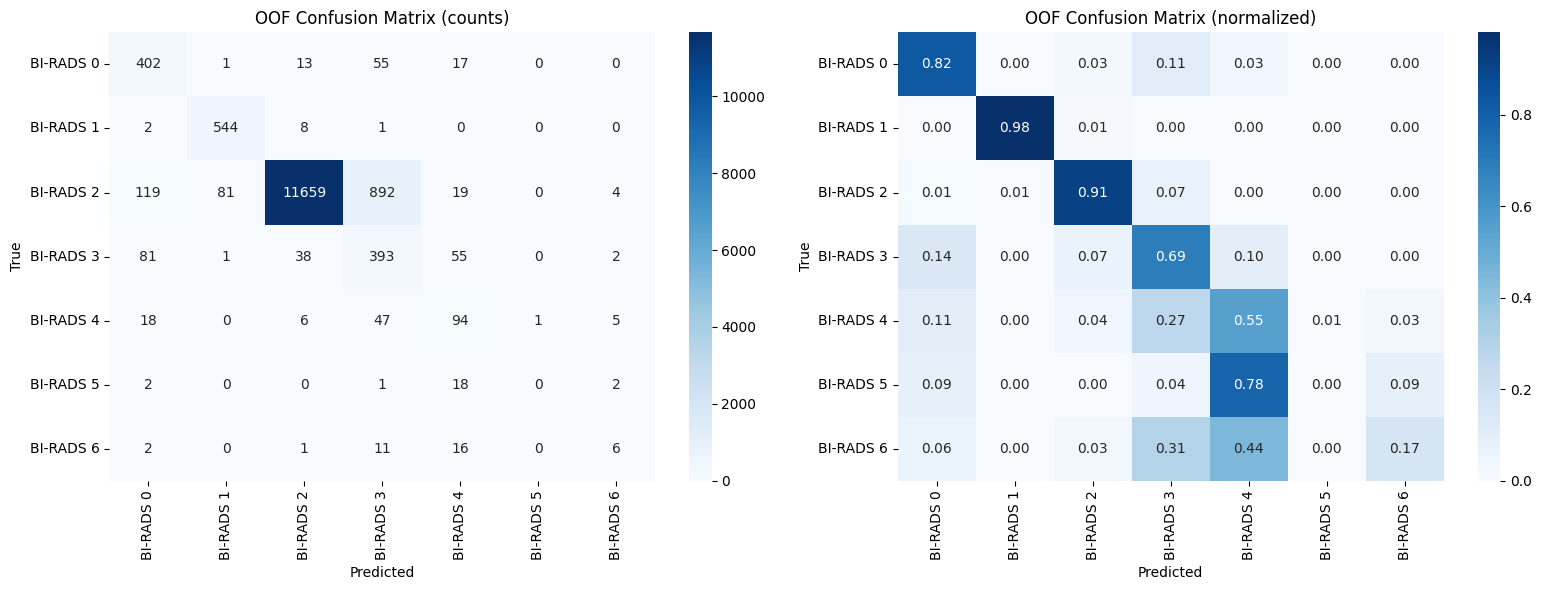

In [15]:
# Confusion matrix
cm = confusion_matrix(oof_labels, oof_pred_classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, data, title, fmt in [
    (axes[0], cm,      "OOF Confusion Matrix (counts)",     "d"),
    (axes[1], cm_norm, "OOF Confusion Matrix (normalized)", ".2f"),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap="Blues", ax=ax,
                xticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

plt.tight_layout()
plt.show()

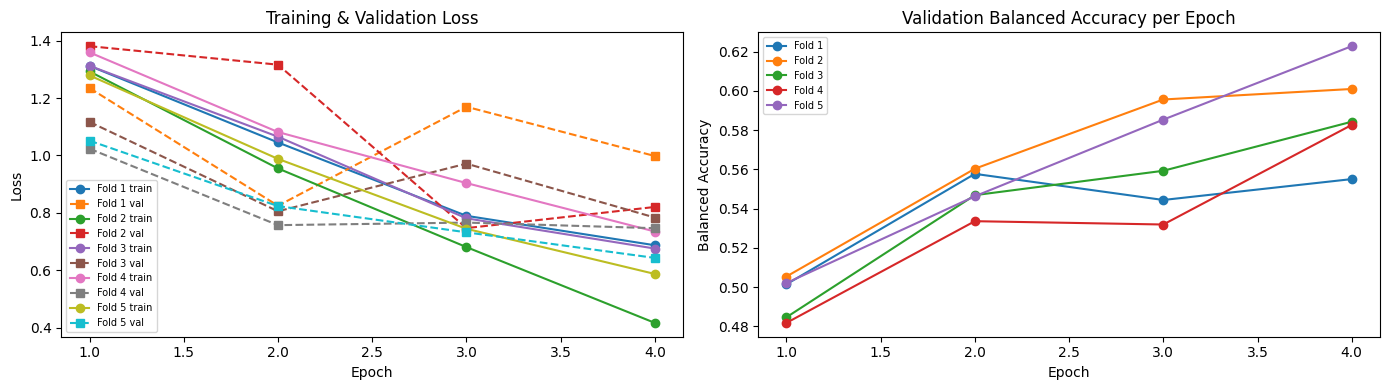

In [16]:
# Training curves
hist_df = pd.DataFrame(history)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for fold_id in range(1, N_FOLDS+1):
    fd = hist_df[hist_df["fold"] == fold_id]
    axes[0].plot(fd["epoch"], fd["train_loss"], marker="o", label=f"Fold {fold_id} train")
    axes[0].plot(fd["epoch"], fd["val_loss"],   marker="s", linestyle="--", label=f"Fold {fold_id} val")
    axes[1].plot(fd["epoch"], fd["val_bal_acc"], marker="o", label=f"Fold {fold_id}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend(fontsize=7)

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Balanced Accuracy")
axes[1].set_title("Validation Balanced Accuracy per Epoch")
axes[1].legend(fontsize=7)

plt.tight_layout()
plt.show()

## 10. Inference & Evaluation on Held-Out Test Set

Ensemble all fold models by averaging their softmax probabilities, then evaluate
against the ground-truth labels in `test_df`.

In [17]:
test_texts  = test_df["report"].tolist()
test_labels = test_df["target"].tolist()

test_ds     = MammographyDataset(test_texts, labels=test_labels, tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

test_preds = np.zeros((len(test_df), NUM_CLASSES))

for fold in range(N_FOLDS):
    model_path = f"{OUTPUT_DIR}/best_fold{fold+1}.pt"
    if not os.path.exists(model_path):
        print(f"Skipping fold {fold+1} — model not found")
        continue

    print(f"Fold {fold+1}: loading {model_path}")
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
    ).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Fold {fold+1} inference", leave=False):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            fold_probs.append(torch.softmax(outputs.logits, dim=-1).cpu().numpy())

    test_preds += np.concatenate(fold_probs, axis=0)
    del model
    if DEVICE.type == "cuda":
        torch.cuda.empty_cache()

# Average over folds
test_preds /= N_FOLDS
test_pred_classes = test_preds.argmax(axis=1)


Fold 1: loading ./outputs_distilbert_weightbalance_newLoss/best_fold1.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 49344.75it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 559.84it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 537.66it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 399.57it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 323.96it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 293.14it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 279.53it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 224.21it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 256.97it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 236.65it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 240.71it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 217.88it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 228.07it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 208.74it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 221.74it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 203.27it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 209.01it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 204.09it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 222.21it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 219.58it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 235.91it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 233.66it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 251.16it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 248.61it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 266.04it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 263.08it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 279.69it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 276.64it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 292.81it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 290.01it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 292.62it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 290.02it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 304.71it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 301.95it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 316.25it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 313.45it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 327.36it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 324.52it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 333.91it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 331.33it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 338.44it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 334.19it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 346.78it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 344.25it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 356.56it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 354.21it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 366.41it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 363.86it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 375.42it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 372.44it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 382.22it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 379.05it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 389.73it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 387.19it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 397.74it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 394.83it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 405.19it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 402.38it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 412.72it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 409.83it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 420.26it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 417.20it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 427.26it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 424.65it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 433.44it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 430.70it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 440.44it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 438.00it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 447.59it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 444.69it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 454.19it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 451.32it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 459.54it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 456.88it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 465.13it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 462.09it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 468.74it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 466.01it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 473.24it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 470.27it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 478.44it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 475.65it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 483.72it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 480.23it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 487.67it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 485.25it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 492.76it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 489.84it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 497.34it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 494.81it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 502.53it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 499.98it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 507.55it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 505.22it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 512.66it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 509.93it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 517.19it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 514.31it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 520.28it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 517.30it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 524.48it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 521.53it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 527.52it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 524.45it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 530.76it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 527.78it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 54/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 534.88it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 534.88it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 534.88it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 534.88it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 534.88it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 556.00it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 1 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 1 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:37,  1.17it/s]

Fold 1 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:36,  1.18it/s]

Fold 1 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:35,  1.18it/s]

Fold 1 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:35,  1.16it/s]

Fold 1 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:35,  1.15it/s]

Fold 1 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:05<01:35,  1.14it/s]

Fold 1 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:06<01:34,  1.14it/s]

Fold 1 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:06<01:33,  1.14it/s]

Fold 1 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:07<01:33,  1.14it/s]

Fold 1 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:08<01:32,  1.14it/s]

Fold 1 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:09<01:31,  1.14it/s]

Fold 1 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:10<01:30,  1.14it/s]

Fold 1 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:11<01:29,  1.14it/s]

Fold 1 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:12<01:28,  1.14it/s]

Fold 1 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:13<01:28,  1.14it/s]

Fold 1 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:14<01:27,  1.13it/s]

Fold 1 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:14<01:27,  1.12it/s]

Fold 1 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:16<01:58,  1.22s/it]

Fold 1 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:17<01:48,  1.13s/it]

Fold 1 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:18<01:40,  1.06s/it]

Fold 1 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:19<01:34,  1.01s/it]

Fold 1 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:20<01:30,  1.03it/s]

Fold 1 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:21<01:27,  1.05it/s]

Fold 1 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:22<01:24,  1.07it/s]

Fold 1 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:23<01:22,  1.09it/s]

Fold 1 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:24<01:20,  1.11it/s]

Fold 1 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:24<01:18,  1.12it/s]

Fold 1 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:25<01:17,  1.13it/s]

Fold 1 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:26<01:15,  1.14it/s]

Fold 1 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:27<01:14,  1.14it/s]

Fold 1 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:13,  1.14it/s]

Fold 1 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:12,  1.14it/s]

Fold 1 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:11,  1.15it/s]

Fold 1 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:30<01:10,  1.15it/s]

Fold 1 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:31<01:09,  1.15it/s]

Fold 1 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:08,  1.15it/s]

Fold 1 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:07,  1.15it/s]

Fold 1 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:07,  1.15it/s]

Fold 1 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:06,  1.15it/s]

Fold 1 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:05,  1.15it/s]

Fold 1 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:04,  1.15it/s]

Fold 1 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:37<01:03,  1.15it/s]

Fold 1 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:38<01:02,  1.14it/s]

Fold 1 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:39<01:02,  1.14it/s]

Fold 1 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:40<01:01,  1.14it/s]

Fold 1 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:41<01:01,  1.13it/s]

Fold 1 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:42<01:00,  1.13it/s]

Fold 1 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:43<00:59,  1.13it/s]

Fold 1 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:44<00:58,  1.13it/s]

Fold 1 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:45<00:57,  1.13it/s]

Fold 1 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:45<00:56,  1.13it/s]

Fold 1 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:46<00:56,  1.12it/s]

Fold 1 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:47<00:55,  1.11it/s]

Fold 1 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:49<01:14,  1.22s/it]

Fold 1 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:50<01:07,  1.13s/it]

Fold 1 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:51<01:02,  1.06s/it]

Fold 1 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:52<00:58,  1.01s/it]

Fold 1 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:53<00:55,  1.03it/s]

Fold 1 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:54<00:53,  1.05it/s]

Fold 1 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:55<00:51,  1.07it/s]

Fold 1 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:55<00:49,  1.09it/s]

Fold 1 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:56<00:47,  1.11it/s]

Fold 1 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:57<00:46,  1.12it/s]

Fold 1 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:58<00:45,  1.13it/s]

Fold 1 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:59<00:43,  1.14it/s]

Fold 1 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [01:00<00:42,  1.15it/s]

Fold 1 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:01<00:41,  1.15it/s]

Fold 1 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:41,  1.14it/s]

Fold 1 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:02<00:40,  1.14it/s]

Fold 1 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:03<00:39,  1.14it/s]

Fold 1 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:04<00:38,  1.14it/s]

Fold 1 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:37,  1.13it/s]

Fold 1 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:37,  1.13it/s]

Fold 1 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:36,  1.13it/s]

Fold 1 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:35,  1.13it/s]

Fold 1 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:34,  1.12it/s]

Fold 1 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:33,  1.13it/s]

Fold 1 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:10<00:32,  1.13it/s]

Fold 1 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:11<00:31,  1.13it/s]

Fold 1 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:12<00:30,  1.13it/s]

Fold 1 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:13<00:30,  1.13it/s]

Fold 1 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:14<00:29,  1.13it/s]

Fold 1 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:15<00:28,  1.13it/s]

Fold 1 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:16<00:27,  1.13it/s]

Fold 1 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:17<00:26,  1.13it/s]

Fold 1 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:18<00:25,  1.13it/s]

Fold 1 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:18<00:24,  1.13it/s]

Fold 1 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:19<00:23,  1.13it/s]

Fold 1 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:20<00:23,  1.12it/s]

Fold 1 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:21<00:22,  1.11it/s]

Fold 1 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:23<00:29,  1.21s/it]

Fold 1 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:24<00:25,  1.12s/it]

Fold 1 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:25<00:23,  1.05s/it]

Fold 1 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:26<00:21,  1.00s/it]

Fold 1 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:27<00:19,  1.04it/s]

Fold 1 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:27<00:17,  1.06it/s]

Fold 1 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:28<00:16,  1.08it/s]

Fold 1 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:29<00:15,  1.11it/s]

Fold 1 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:30<00:14,  1.12it/s]

Fold 1 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:31<00:13,  1.13it/s]

Fold 1 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:32<00:12,  1.14it/s]

Fold 1 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:33<00:11,  1.15it/s]

Fold 1 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:34<00:10,  1.15it/s]

Fold 1 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:34<00:09,  1.15it/s]

Fold 1 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:35<00:08,  1.14it/s]

Fold 1 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:36<00:07,  1.14it/s]

Fold 1 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:07,  1.13it/s]

Fold 1 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:06,  1.13it/s]

Fold 1 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.13it/s]

Fold 1 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.13it/s]

Fold 1 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.12it/s]

Fold 1 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.12it/s]

Fold 1 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:42<00:01,  1.13it/s]

Fold 1 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:43<00:00,  1.13it/s]

Fold 1 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:43<00:00,  1.47it/s]

Fold 2: loading ./outputs_distilbert_weightbalance_newLoss/best_fold2.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 39199.10it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 341.36it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 247.80it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 201.95it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 216.85it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 188.93it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 218.94it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 201.39it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 218.38it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 204.10it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 214.82it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 204.51it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 221.54it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 205.01it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 212.86it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 206.68it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 212.31it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 204.21it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 217.00it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 214.71it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 233.21it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 230.87it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 248.64it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 246.06it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 263.26it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 260.43it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 276.40it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 273.91it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 290.11it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 287.44it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 302.99it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 300.19it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 315.34it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 312.12it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 326.68it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 323.77it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 338.07it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 335.20it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 349.03it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 346.02it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 358.00it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 354.83it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 364.77it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 362.25it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 346.39it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 343.75it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 354.04it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 351.50it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 362.82it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 360.33it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 367.90it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 364.26it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 374.44it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 372.12it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 382.89it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 380.49it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 390.88it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 388.20it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 398.21it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 395.55it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 405.46it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 402.89it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 412.59it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 410.16it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 419.73it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 416.91it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 426.56it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 423.88it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 433.13it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 430.21it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 437.95it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 435.55it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 444.25it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 441.63it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 437.19it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 434.65it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 442.84it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 440.50it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 448.69it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 446.17it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 454.39it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 452.00it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 459.69it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 457.28it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 465.26it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 462.71it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 462.58it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 460.42it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 467.84it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 465.53it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 472.78it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 467.04it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 474.22it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 471.92it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 48/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 479.01it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 479.01it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 479.01it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 479.01it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 479.01it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 588.15it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 2 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 2 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:39,  1.14it/s]

Fold 2 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:39,  1.14it/s]

Fold 2 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:38,  1.13it/s]

Fold 2 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:38,  1.13it/s]

Fold 2 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:38,  1.12it/s]

Fold 2 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:05<01:36,  1.12it/s]

Fold 2 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:06<01:35,  1.13it/s]

Fold 2 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:07<01:34,  1.13it/s]

Fold 2 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:07<01:33,  1.13it/s]

Fold 2 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:08<01:34,  1.11it/s]

Fold 2 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:09<01:33,  1.11it/s]

Fold 2 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:11<02:04,  1.21s/it]

Fold 2 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:12<01:53,  1.12s/it]

Fold 2 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:13<01:45,  1.05s/it]

Fold 2 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:14<01:39,  1.00it/s]

Fold 2 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:15<01:35,  1.04it/s]

Fold 2 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:16<01:32,  1.06it/s]

Fold 2 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:17<01:30,  1.08it/s]

Fold 2 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:17<01:27,  1.10it/s]

Fold 2 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:18<01:24,  1.13it/s]

Fold 2 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:19<01:22,  1.14it/s]

Fold 2 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:20<01:21,  1.15it/s]

Fold 2 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:21<01:19,  1.15it/s]

Fold 2 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:22<01:19,  1.15it/s]

Fold 2 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:23<01:18,  1.14it/s]

Fold 2 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:23<01:18,  1.14it/s]

Fold 2 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:24<01:17,  1.13it/s]

Fold 2 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:25<01:16,  1.13it/s]

Fold 2 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:26<01:15,  1.13it/s]

Fold 2 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:27<01:15,  1.13it/s]

Fold 2 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:14,  1.13it/s]

Fold 2 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:13,  1.13it/s]

Fold 2 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:12,  1.13it/s]

Fold 2 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:11,  1.13it/s]

Fold 2 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:31<01:10,  1.13it/s]

Fold 2 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:09,  1.13it/s]

Fold 2 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:08,  1.13it/s]

Fold 2 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:08,  1.13it/s]

Fold 2 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:07,  1.13it/s]

Fold 2 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:06,  1.13it/s]

Fold 2 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:05,  1.13it/s]

Fold 2 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:38<01:04,  1.13it/s]

Fold 2 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:39<01:03,  1.13it/s]

Fold 2 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:39<01:02,  1.13it/s]

Fold 2 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:40<01:01,  1.13it/s]

Fold 2 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:41<01:01,  1.12it/s]

Fold 2 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:42<01:01,  1.11it/s]

Fold 2 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:44<01:21,  1.22s/it]

Fold 2 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:45<01:14,  1.13s/it]

Fold 2 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:46<01:08,  1.06s/it]

Fold 2 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:47<01:04,  1.01s/it]

Fold 2 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:48<01:01,  1.03it/s]

Fold 2 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:49<00:58,  1.06it/s]

Fold 2 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:49<00:56,  1.08it/s]

Fold 2 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:50<00:54,  1.10it/s]

Fold 2 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:51<00:52,  1.12it/s]

Fold 2 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:52<00:51,  1.13it/s]

Fold 2 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:53<00:50,  1.13it/s]

Fold 2 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:54<00:49,  1.14it/s]

Fold 2 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:55<00:48,  1.14it/s]

Fold 2 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:56<00:47,  1.15it/s]

Fold 2 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:56<00:46,  1.15it/s]

Fold 2 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:57<00:45,  1.15it/s]

Fold 2 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:58<00:44,  1.15it/s]

Fold 2 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:59<00:43,  1.15it/s]

Fold 2 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [01:00<00:42,  1.15it/s]

Fold 2 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:01<00:41,  1.15it/s]

Fold 2 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:41,  1.15it/s]

Fold 2 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:02<00:40,  1.15it/s]

Fold 2 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:03<00:39,  1.15it/s]

Fold 2 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:04<00:38,  1.15it/s]

Fold 2 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:37,  1.15it/s]

Fold 2 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:36,  1.14it/s]

Fold 2 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:36,  1.13it/s]

Fold 2 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:36,  1.10it/s]

Fold 2 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:35,  1.10it/s]

Fold 2 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:34,  1.10it/s]

Fold 2 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:11<00:33,  1.11it/s]

Fold 2 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:11<00:32,  1.11it/s]

Fold 2 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:12<00:31,  1.12it/s]

Fold 2 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:13<00:30,  1.12it/s]

Fold 2 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:14<00:29,  1.10it/s]

Fold 2 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:15<00:29,  1.10it/s]

Fold 2 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:16<00:28,  1.09it/s]

Fold 2 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:18<00:36,  1.23s/it]

Fold 2 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:19<00:33,  1.14s/it]

Fold 2 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:20<00:29,  1.06s/it]

Fold 2 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:21<00:27,  1.01s/it]

Fold 2 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:22<00:25,  1.03it/s]

Fold 2 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:22<00:23,  1.06it/s]

Fold 2 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:23<00:22,  1.08it/s]

Fold 2 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:24<00:20,  1.11it/s]

Fold 2 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:25<00:19,  1.12it/s]

Fold 2 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:26<00:18,  1.13it/s]

Fold 2 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:27<00:17,  1.14it/s]

Fold 2 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:28<00:16,  1.15it/s]

Fold 2 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:28<00:15,  1.15it/s]

Fold 2 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:29<00:14,  1.15it/s]

Fold 2 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:30<00:13,  1.15it/s]

Fold 2 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:31<00:13,  1.14it/s]

Fold 2 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:32<00:12,  1.14it/s]

Fold 2 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:33<00:11,  1.13it/s]

Fold 2 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:34<00:10,  1.13it/s]

Fold 2 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:35<00:09,  1.13it/s]

Fold 2 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:36<00:08,  1.13it/s]

Fold 2 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:36<00:07,  1.13it/s]

Fold 2 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:07,  1.13it/s]

Fold 2 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:06,  1.13it/s]

Fold 2 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.13it/s]

Fold 2 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.13it/s]

Fold 2 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.13it/s]

Fold 2 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.13it/s]

Fold 2 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:43<00:01,  1.13it/s]

Fold 2 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:43<00:00,  1.13it/s]

Fold 2 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:44<00:00,  1.48it/s]

Fold 3: loading ./outputs_distilbert_weightbalance_newLoss/best_fold3.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 51150.05it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 476.73it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 488.59it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 324.72it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 300.96it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 262.91it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 268.56it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 242.46it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 265.44it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 242.13it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 237.20it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 230.69it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 226.27it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 219.07it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 231.04it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 218.81it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 218.05it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 211.18it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 216.23it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 205.55it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 222.56it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 220.21it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 237.24it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 234.75it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 251.16it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 248.61it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 263.29it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 261.01it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 263.75it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 261.09it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 275.54it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 270.79it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 284.83it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 282.37it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 295.98it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 293.70it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 306.70it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 304.32it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 313.95it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 311.86it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 324.26it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 322.02it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 334.55it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 332.26it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 338.68it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 334.97it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 345.89it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 342.38it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 352.76it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 349.24it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 360.23it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 357.16it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 367.46it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 364.96it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 375.23it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 372.43it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 377.33it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 374.84it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 384.84it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 382.43it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 389.26it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 386.82it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 396.09it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 393.50it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 402.75it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 400.09it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 404.75it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 400.86it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 409.81it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 406.33it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 414.82it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 412.63it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 419.96it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 416.67it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 424.51it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 422.37it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 430.49it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 427.94it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 435.97it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 433.51it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 432.01it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 429.70it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 437.42it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 435.06it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 442.64it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 440.15it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 447.47it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 445.24it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 45/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 446.56it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 446.56it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 446.56it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 446.56it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 446.56it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 560.23it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 3 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 3 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:39,  1.14it/s]

Fold 3 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:38,  1.14it/s]

Fold 3 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:38,  1.14it/s]

Fold 3 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:37,  1.14it/s]

Fold 3 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:36,  1.14it/s]

Fold 3 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:06<02:18,  1.27s/it]

Fold 3 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:07<02:04,  1.15s/it]

Fold 3 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:08<01:54,  1.07s/it]

Fold 3 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:09<01:47,  1.01s/it]

Fold 3 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:09<01:42,  1.03it/s]

Fold 3 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:10<01:38,  1.05it/s]

Fold 3 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:11<01:35,  1.08it/s]

Fold 3 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:12<01:33,  1.09it/s]

Fold 3 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:13<01:31,  1.10it/s]

Fold 3 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:14<01:29,  1.11it/s]

Fold 3 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:15<01:28,  1.12it/s]

Fold 3 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:16<01:27,  1.12it/s]

Fold 3 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:17<01:26,  1.13it/s]

Fold 3 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:17<01:25,  1.13it/s]

Fold 3 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:18<01:24,  1.12it/s]

Fold 3 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:19<01:23,  1.12it/s]

Fold 3 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:20<01:22,  1.13it/s]

Fold 3 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:21<01:21,  1.13it/s]

Fold 3 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:22<01:20,  1.13it/s]

Fold 3 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:23<01:19,  1.13it/s]

Fold 3 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:24<01:18,  1.14it/s]

Fold 3 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:25<01:17,  1.13it/s]

Fold 3 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:25<01:16,  1.13it/s]

Fold 3 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:26<01:15,  1.13it/s]

Fold 3 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:27<01:14,  1.13it/s]

Fold 3 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:14,  1.13it/s]

Fold 3 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:13,  1.12it/s]

Fold 3 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:12,  1.13it/s]

Fold 3 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:11,  1.13it/s]

Fold 3 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:32<01:10,  1.13it/s]

Fold 3 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:33<01:10,  1.13it/s]

Fold 3 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:09,  1.12it/s]

Fold 3 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:08,  1.13it/s]

Fold 3 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:07,  1.13it/s]

Fold 3 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:06,  1.13it/s]

Fold 3 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:05,  1.13it/s]

Fold 3 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:38<01:04,  1.13it/s]

Fold 3 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:40<01:25,  1.19s/it]

Fold 3 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:41<01:18,  1.10s/it]

Fold 3 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:42<01:12,  1.04s/it]

Fold 3 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:42<01:08,  1.01it/s]

Fold 3 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:43<01:05,  1.04it/s]

Fold 3 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:44<01:02,  1.07it/s]

Fold 3 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:45<01:00,  1.09it/s]

Fold 3 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:46<00:58,  1.10it/s]

Fold 3 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:47<00:57,  1.11it/s]

Fold 3 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:48<00:56,  1.11it/s]

Fold 3 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:49<00:55,  1.12it/s]

Fold 3 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:49<00:54,  1.12it/s]

Fold 3 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:50<00:53,  1.13it/s]

Fold 3 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:51<00:52,  1.12it/s]

Fold 3 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:52<00:51,  1.13it/s]

Fold 3 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:53<00:50,  1.13it/s]

Fold 3 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:54<00:49,  1.13it/s]

Fold 3 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:55<00:48,  1.12it/s]

Fold 3 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:56<00:47,  1.13it/s]

Fold 3 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:57<00:46,  1.13it/s]

Fold 3 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:57<00:45,  1.13it/s]

Fold 3 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:58<00:45,  1.13it/s]

Fold 3 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:59<00:44,  1.13it/s]

Fold 3 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [01:00<00:43,  1.13it/s]

Fold 3 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:01<00:42,  1.13it/s]

Fold 3 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:41,  1.13it/s]

Fold 3 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:03<00:40,  1.13it/s]

Fold 3 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:04<00:39,  1.13it/s]

Fold 3 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:05<00:38,  1.13it/s]

Fold 3 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:37,  1.13it/s]

Fold 3 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:37,  1.13it/s]

Fold 3 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:36,  1.13it/s]

Fold 3 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:35,  1.13it/s]

Fold 3 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:34,  1.13it/s]

Fold 3 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:33,  1.13it/s]

Fold 3 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:11<00:32,  1.13it/s]

Fold 3 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:13<00:43,  1.20s/it]

Fold 3 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:14<00:38,  1.11s/it]

Fold 3 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:14<00:35,  1.04s/it]

Fold 3 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:15<00:32,  1.01it/s]

Fold 3 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:16<00:30,  1.04it/s]

Fold 3 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:17<00:29,  1.06it/s]

Fold 3 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:18<00:27,  1.09it/s]

Fold 3 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:19<00:26,  1.10it/s]

Fold 3 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:20<00:25,  1.11it/s]

Fold 3 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:21<00:24,  1.12it/s]

Fold 3 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:21<00:23,  1.12it/s]

Fold 3 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:22<00:22,  1.12it/s]

Fold 3 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:23<00:21,  1.13it/s]

Fold 3 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:24<00:20,  1.13it/s]

Fold 3 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:25<00:19,  1.13it/s]

Fold 3 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:26<00:18,  1.13it/s]

Fold 3 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:27<00:17,  1.13it/s]

Fold 3 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:28<00:16,  1.13it/s]

Fold 3 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:29<00:15,  1.13it/s]

Fold 3 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:29<00:15,  1.13it/s]

Fold 3 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:30<00:14,  1.13it/s]

Fold 3 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:31<00:13,  1.13it/s]

Fold 3 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:32<00:12,  1.13it/s]

Fold 3 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:33<00:11,  1.13it/s]

Fold 3 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:34<00:10,  1.12it/s]

Fold 3 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:35<00:09,  1.12it/s]

Fold 3 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:36<00:08,  1.12it/s]

Fold 3 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:37<00:07,  1.13it/s]

Fold 3 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:07,  1.13it/s]

Fold 3 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:06,  1.13it/s]

Fold 3 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.13it/s]

Fold 3 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.13it/s]

Fold 3 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.13it/s]

Fold 3 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.13it/s]

Fold 3 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:43<00:01,  1.13it/s]

Fold 3 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:44<00:00,  1.13it/s]

Fold 3 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:44<00:00,  1.47it/s]

Fold 4: loading ./outputs_distilbert_weightbalance_newLoss/best_fold4.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 51150.05it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                         | 1/103 [00:00<00:00, 1296.54it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 472.94it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 318.67it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 312.26it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 289.15it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 275.55it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 245.73it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 263.27it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 235.02it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 252.56it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 222.60it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 217.91it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 211.46it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 215.81it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 211.27it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 216.78it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 206.55it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 208.14it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 203.25it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 215.13it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 211.99it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 228.54it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 226.73it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 242.67it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 240.38it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 254.48it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 252.20it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 267.42it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 264.86it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 276.14it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 273.67it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 287.84it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 285.48it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 299.13it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 296.76it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 293.53it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 290.96it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 302.12it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 299.94it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 310.40it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 308.25it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 318.01it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 315.88it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 327.16it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 324.73it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 333.73it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 331.54it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 340.74it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 337.24it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 347.77it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 345.39it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 353.27it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 349.99it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 359.25it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 355.59it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 364.43it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 360.76it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 369.42it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 367.38it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 376.84it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 374.60it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 383.96it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 381.66it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 391.00it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 388.84it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 397.71it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 395.50it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 404.12it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 401.68it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 400.97it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 397.92it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 406.09it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 403.82it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 411.28it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 408.89it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 416.26it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 414.28it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 421.52it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 419.27it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 421.01it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 418.96it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 426.66it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 424.42it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 43/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 429.76it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 429.76it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 429.76it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 429.76it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 429.76it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 538.64it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 4 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 4 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:01<03:39,  1.92s/it]

Fold 4 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:02<02:27,  1.31s/it]

Fold 4 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:03<02:04,  1.11s/it]

Fold 4 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:04<01:53,  1.02s/it]

Fold 4 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:05<01:46,  1.03it/s]

Fold 4 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:06<01:42,  1.06it/s]

Fold 4 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:07<01:39,  1.09it/s]

Fold 4 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:08<01:37,  1.10it/s]

Fold 4 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:08<01:35,  1.11it/s]

Fold 4 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:09<01:33,  1.12it/s]

Fold 4 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:10<01:32,  1.12it/s]

Fold 4 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:11<01:31,  1.13it/s]

Fold 4 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:12<01:30,  1.13it/s]

Fold 4 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:13<01:30,  1.12it/s]

Fold 4 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:14<01:29,  1.12it/s]

Fold 4 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:15<01:27,  1.13it/s]

Fold 4 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:16<01:26,  1.13it/s]

Fold 4 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:16<01:25,  1.13it/s]

Fold 4 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:17<01:24,  1.13it/s]

Fold 4 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:18<01:24,  1.13it/s]

Fold 4 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:19<01:23,  1.13it/s]

Fold 4 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:20<01:22,  1.13it/s]

Fold 4 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:21<01:21,  1.13it/s]

Fold 4 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:22<01:20,  1.13it/s]

Fold 4 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:23<01:19,  1.13it/s]

Fold 4 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:23<01:18,  1.13it/s]

Fold 4 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:24<01:17,  1.13it/s]

Fold 4 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:25<01:17,  1.13it/s]

Fold 4 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:26<01:16,  1.13it/s]

Fold 4 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:27<01:15,  1.13it/s]

Fold 4 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:14,  1.13it/s]

Fold 4 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:13,  1.13it/s]

Fold 4 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:12,  1.13it/s]

Fold 4 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:11,  1.13it/s]

Fold 4 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:31<01:10,  1.13it/s]

Fold 4 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:10,  1.12it/s]

Fold 4 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:34<01:33,  1.20s/it]

Fold 4 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:35<01:25,  1.11s/it]

Fold 4 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:36<01:19,  1.04s/it]

Fold 4 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:37<01:14,  1.00it/s]

Fold 4 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:38<01:11,  1.04it/s]

Fold 4 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:39<01:08,  1.07it/s]

Fold 4 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:40<01:06,  1.09it/s]

Fold 4 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:40<01:04,  1.10it/s]

Fold 4 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:41<01:03,  1.11it/s]

Fold 4 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:42<01:01,  1.12it/s]

Fold 4 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:43<01:00,  1.12it/s]

Fold 4 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:44<00:59,  1.12it/s]

Fold 4 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:45<00:58,  1.12it/s]

Fold 4 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:46<00:57,  1.13it/s]

Fold 4 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:47<00:56,  1.12it/s]

Fold 4 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:48<00:55,  1.13it/s]

Fold 4 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:48<00:55,  1.13it/s]

Fold 4 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:49<00:53,  1.13it/s]

Fold 4 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:50<00:53,  1.12it/s]

Fold 4 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:51<00:52,  1.12it/s]

Fold 4 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:52<00:51,  1.13it/s]

Fold 4 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:53<00:50,  1.13it/s]

Fold 4 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:54<00:49,  1.13it/s]

Fold 4 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:55<00:48,  1.13it/s]

Fold 4 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:56<00:47,  1.13it/s]

Fold 4 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:56<00:46,  1.13it/s]

Fold 4 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:57<00:45,  1.13it/s]

Fold 4 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:58<00:44,  1.14it/s]

Fold 4 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:59<00:44,  1.14it/s]

Fold 4 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [01:00<00:43,  1.13it/s]

Fold 4 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:01<00:42,  1.13it/s]

Fold 4 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:41,  1.13it/s]

Fold 4 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:03<00:40,  1.13it/s]

Fold 4 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:03<00:39,  1.13it/s]

Fold 4 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:04<00:38,  1.13it/s]

Fold 4 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:37,  1.13it/s]

Fold 4 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:37,  1.13it/s]

Fold 4 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:08<00:49,  1.20s/it]

Fold 4 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:09<00:44,  1.10s/it]

Fold 4 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:10<00:40,  1.04s/it]

Fold 4 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:11<00:37,  1.01it/s]

Fold 4 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:12<00:35,  1.04it/s]

Fold 4 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:12<00:33,  1.07it/s]

Fold 4 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:13<00:32,  1.09it/s]

Fold 4 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:14<00:30,  1.10it/s]

Fold 4 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:15<00:29,  1.11it/s]

Fold 4 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:16<00:28,  1.12it/s]

Fold 4 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:17<00:27,  1.12it/s]

Fold 4 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:18<00:26,  1.13it/s]

Fold 4 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:19<00:25,  1.13it/s]

Fold 4 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:20<00:24,  1.13it/s]

Fold 4 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:20<00:23,  1.13it/s]

Fold 4 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:21<00:23,  1.12it/s]

Fold 4 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:22<00:22,  1.13it/s]

Fold 4 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:23<00:21,  1.13it/s]

Fold 4 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:24<00:20,  1.13it/s]

Fold 4 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:25<00:19,  1.13it/s]

Fold 4 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:26<00:18,  1.13it/s]

Fold 4 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:27<00:17,  1.13it/s]

Fold 4 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:28<00:16,  1.13it/s]

Fold 4 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:28<00:15,  1.13it/s]

Fold 4 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:29<00:14,  1.14it/s]

Fold 4 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:30<00:14,  1.13it/s]

Fold 4 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:31<00:13,  1.13it/s]

Fold 4 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:32<00:12,  1.13it/s]

Fold 4 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:33<00:11,  1.13it/s]

Fold 4 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:34<00:10,  1.13it/s]

Fold 4 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:35<00:09,  1.13it/s]

Fold 4 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:35<00:08,  1.13it/s]

Fold 4 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:36<00:07,  1.13it/s]

Fold 4 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:07,  1.13it/s]

Fold 4 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:06,  1.13it/s]

Fold 4 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.13it/s]

Fold 4 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:41<00:06,  1.21s/it]

Fold 4 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:42<00:04,  1.11s/it]

Fold 4 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:43<00:03,  1.04s/it]

Fold 4 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:44<00:01,  1.01it/s]

Fold 4 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:44<00:00,  1.04it/s]

Fold 4 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:45<00:00,  1.37it/s]

Fold 5: loading ./outputs_distilbert_weightbalance_newLoss/best_fold5.pt


Loading weights:   0%|                                                                                                                                                                                                                                                                                                                                          | 0/103 [00:00<?, ?it/s]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                        | 1/103 [00:00<00:00, 52428.80it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   1%|██▌                                                                                                                                                                                                                                                                          | 1/103 [00:00<00:00, 471.32it/s, Materializing param=bert.embeddings.LayerNorm.bias]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 402.64it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   2%|█████▏                                                                                                                                                                                                                                                                     | 2/103 [00:00<00:00, 335.12it/s, Materializing param=bert.embeddings.LayerNorm.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 348.42it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   3%|███████▍                                                                                                                                                                                                                                                         | 3/103 [00:00<00:00, 265.23it/s, Materializing param=bert.embeddings.position_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 271.62it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   4%|█████████▉                                                                                                                                                                                                                                                     | 4/103 [00:00<00:00, 257.26it/s, Materializing param=bert.embeddings.token_type_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 273.22it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   5%|████████████▋                                                                                                                                                                                                                                                        | 5/103 [00:00<00:00, 245.93it/s, Materializing param=bert.embeddings.word_embeddings.weight]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 262.58it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   6%|██████████████▍                                                                                                                                                                                                                                        | 6/103 [00:00<00:00, 233.82it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.bias]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 253.65it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   7%|████████████████▋                                                                                                                                                                                                                                    | 7/103 [00:00<00:00, 234.81it/s, Materializing param=bert.encoder.layer.0.attention.output.LayerNorm.weight]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 246.19it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   8%|███████████████████▍                                                                                                                                                                                                                                       | 8/103 [00:00<00:00, 227.12it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.bias]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 238.77it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:   9%|█████████████████████▊                                                                                                                                                                                                                                   | 9/103 [00:00<00:00, 222.78it/s, Materializing param=bert.encoder.layer.0.attention.output.dense.weight]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 222.37it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  10%|████████████████████████▋                                                                                                                                                                                                                                     | 10/103 [00:00<00:00, 215.54it/s, Materializing param=bert.encoder.layer.0.attention.self.key.bias]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 230.23it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  11%|██████████████████████████▉                                                                                                                                                                                                                                 | 11/103 [00:00<00:00, 227.30it/s, Materializing param=bert.encoder.layer.0.attention.self.key.weight]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 244.89it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  12%|█████████████████████████████▎                                                                                                                                                                                                                              | 12/103 [00:00<00:00, 241.16it/s, Materializing param=bert.encoder.layer.0.attention.self.query.bias]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 258.36it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  13%|███████████████████████████████▌                                                                                                                                                                                                                          | 13/103 [00:00<00:00, 255.87it/s, Materializing param=bert.encoder.layer.0.attention.self.query.weight]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 249.82it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 14/103 [00:00<00:00, 246.98it/s, Materializing param=bert.encoder.layer.0.attention.self.value.bias]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 261.53it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  15%|████████████████████████████████████▍                                                                                                                                                                                                                     | 15/103 [00:00<00:00, 259.26it/s, Materializing param=bert.encoder.layer.0.attention.self.value.weight]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 273.66it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  16%|███████████████████████████████████████▍                                                                                                                                                                                                                      | 16/103 [00:00<00:00, 271.46it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.bias]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 285.21it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 17/103 [00:00<00:00, 282.86it/s, Materializing param=bert.encoder.layer.0.intermediate.dense.weight]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 295.38it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  17%|████████████████████████████████████████████▋                                                                                                                                                                                                                   | 18/103 [00:00<00:00, 293.29it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.bias]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 306.41it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                               | 19/103 [00:00<00:00, 304.21it/s, Materializing param=bert.encoder.layer.0.output.LayerNorm.weight]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 316.94it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  19%|██████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 20/103 [00:00<00:00, 314.32it/s, Materializing param=bert.encoder.layer.0.output.dense.bias]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 326.95it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  20%|████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 21/103 [00:00<00:00, 324.48it/s, Materializing param=bert.encoder.layer.0.output.dense.weight]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 333.73it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                 | 22/103 [00:00<00:00, 331.47it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.bias]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 343.43it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                             | 23/103 [00:00<00:00, 340.62it/s, Materializing param=bert.encoder.layer.1.attention.output.LayerNorm.weight]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 350.70it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 24/103 [00:00<00:00, 348.36it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.bias]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 349.56it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 25/103 [00:00<00:00, 347.27it/s, Materializing param=bert.encoder.layer.1.attention.output.dense.weight]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 358.21it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 26/103 [00:00<00:00, 355.61it/s, Materializing param=bert.encoder.layer.1.attention.self.key.bias]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 366.29it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 27/103 [00:00<00:00, 363.84it/s, Materializing param=bert.encoder.layer.1.attention.self.key.weight]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 374.31it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 28/103 [00:00<00:00, 371.69it/s, Materializing param=bert.encoder.layer.1.attention.self.query.bias]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 381.96it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 29/103 [00:00<00:00, 380.12it/s, Materializing param=bert.encoder.layer.1.attention.self.query.weight]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 389.52it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 30/103 [00:00<00:00, 386.53it/s, Materializing param=bert.encoder.layer.1.attention.self.value.bias]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 396.55it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  30%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 31/103 [00:00<00:00, 393.91it/s, Materializing param=bert.encoder.layer.1.attention.self.value.weight]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 403.49it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 32/103 [00:00<00:00, 401.27it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.bias]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 408.06it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 33/103 [00:00<00:00, 405.64it/s, Materializing param=bert.encoder.layer.1.intermediate.dense.weight]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 403.02it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  33%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 34/103 [00:00<00:00, 399.30it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.bias]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 407.49it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 35/103 [00:00<00:00, 405.25it/s, Materializing param=bert.encoder.layer.1.output.LayerNorm.weight]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 413.80it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  35%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 36/103 [00:00<00:00, 411.10it/s, Materializing param=bert.encoder.layer.1.output.dense.bias]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 419.46it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 37/103 [00:00<00:00, 417.13it/s, Materializing param=bert.encoder.layer.1.output.dense.weight]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 425.64it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  37%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 38/103 [00:00<00:00, 423.35it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.bias]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 425.81it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  38%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 39/103 [00:00<00:00, 422.55it/s, Materializing param=bert.encoder.layer.2.attention.output.LayerNorm.weight]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 429.28it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 40/103 [00:00<00:00, 425.79it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.bias]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 432.99it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 41/103 [00:00<00:00, 430.69it/s, Materializing param=bert.encoder.layer.2.attention.output.dense.weight]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 437.39it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 42/103 [00:00<00:00, 435.38it/s, Materializing param=bert.encoder.layer.2.attention.self.key.bias]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 442.67it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 43/103 [00:00<00:00, 440.27it/s, Materializing param=bert.encoder.layer.2.attention.self.key.weight]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 447.59it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 44/103 [00:00<00:00, 445.31it/s, Materializing param=bert.encoder.layer.2.attention.self.query.bias]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 452.70it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 45/103 [00:00<00:00, 450.43it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 46/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.attention.self.query.weight]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 46/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.attention.self.value.bias]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 47/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.attention.self.value.weight]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 48/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.bias]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 49/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.intermediate.dense.weight]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 50/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.bias]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 51/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.output.LayerNorm.weight]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 52/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.output.dense.bias]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 53/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.2.output.dense.weight]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 54/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.bias]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 55/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.output.LayerNorm.weight]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 56/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.bias]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 57/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.output.dense.weight]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 58/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.key.bias]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 59/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.key.weight]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 60/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.query.bias]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 61/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.query.weight]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 62/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.value.bias]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 63/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.attention.self.value.weight]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 64/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.bias]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 65/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.intermediate.dense.weight]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 66/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.bias]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 67/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.output.LayerNorm.weight]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 68/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.output.dense.bias]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 69/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.3.output.dense.weight]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 70/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.bias]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.output.LayerNorm.weight]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.bias]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 73/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.output.dense.weight]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 74/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.key.bias]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 75/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.key.weight]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.query.bias]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 77/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.query.weight]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 78/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.value.bias]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 79/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.attention.self.value.weight]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 80/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.bias]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 81/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.intermediate.dense.weight]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 82/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.bias]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 83/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.output.LayerNorm.weight]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 84/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.output.dense.bias]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 85/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.4.output.dense.weight]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 86/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.bias]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 87/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.output.LayerNorm.weight]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 88/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.bias]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 89/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.output.dense.weight]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 90/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.key.bias]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 91/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.key.weight]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 92/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.query.bias]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 93/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.query.weight]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 94/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.value.bias]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 95/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.attention.self.value.weight]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 96/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.bias]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 97/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.intermediate.dense.weight]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 98/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.bias]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 99/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.output.LayerNorm.weight]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 100/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.output.dense.bias]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 101/103 [00:00<00:00, 457.81it/s, Materializing param=bert.encoder.layer.5.output.dense.weight]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 457.81it/s, Materializing param=bert.pooler.dense.bias]

Loading weights:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 102/103 [00:00<00:00, 457.81it/s, Materializing param=bert.pooler.dense.bias]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 457.81it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 457.81it/s, Materializing param=bert.pooler.dense.weight]

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 554.70it/s, Materializing param=bert.pooler.dense.weight]


BertForSequenceClassification LOAD REPORT from: adalbertojunior/distilbert-portuguese-cased
Key                     | Status     | 
------------------------+------------+-
embeddings.position_ids | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Fold 5 inference:   0%|                                                                                                                                                                                                                                                                                                                                         | 0/115 [00:00<?, ?it/s]

Fold 5 inference:   1%|██▊                                                                                                                                                                                                                                                                                                                              | 1/115 [00:00<01:39,  1.15it/s]

Fold 5 inference:   2%|█████▌                                                                                                                                                                                                                                                                                                                           | 2/115 [00:01<01:38,  1.14it/s]

Fold 5 inference:   3%|████████▎                                                                                                                                                                                                                                                                                                                        | 3/115 [00:02<01:38,  1.14it/s]

Fold 5 inference:   3%|███████████▏                                                                                                                                                                                                                                                                                                                     | 4/115 [00:03<01:37,  1.14it/s]

Fold 5 inference:   4%|█████████████▉                                                                                                                                                                                                                                                                                                                   | 5/115 [00:04<01:37,  1.13it/s]

Fold 5 inference:   5%|████████████████▋                                                                                                                                                                                                                                                                                                                | 6/115 [00:05<01:36,  1.13it/s]

Fold 5 inference:   6%|███████████████████▌                                                                                                                                                                                                                                                                                                             | 7/115 [00:06<01:35,  1.13it/s]

Fold 5 inference:   7%|██████████████████████▎                                                                                                                                                                                                                                                                                                          | 8/115 [00:07<01:34,  1.13it/s]

Fold 5 inference:   8%|█████████████████████████                                                                                                                                                                                                                                                                                                        | 9/115 [00:07<01:34,  1.12it/s]

Fold 5 inference:   9%|███████████████████████████▊                                                                                                                                                                                                                                                                                                    | 10/115 [00:08<01:33,  1.13it/s]

Fold 5 inference:  10%|██████████████████████████████▌                                                                                                                                                                                                                                                                                                 | 11/115 [00:09<01:31,  1.13it/s]

Fold 5 inference:  10%|█████████████████████████████████▍                                                                                                                                                                                                                                                                                              | 12/115 [00:10<01:31,  1.13it/s]

Fold 5 inference:  11%|████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 13/115 [00:11<01:30,  1.13it/s]

Fold 5 inference:  12%|██████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 14/115 [00:12<01:29,  1.13it/s]

Fold 5 inference:  13%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 15/115 [00:13<01:28,  1.13it/s]

Fold 5 inference:  14%|████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 16/115 [00:14<01:27,  1.13it/s]

Fold 5 inference:  15%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 17/115 [00:15<01:26,  1.13it/s]

Fold 5 inference:  16%|██████████████████████████████████████████████████                                                                                                                                                                                                                                                                              | 18/115 [00:15<01:25,  1.13it/s]

Fold 5 inference:  17%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                           | 19/115 [00:16<01:24,  1.13it/s]

Fold 5 inference:  17%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                        | 20/115 [00:17<01:23,  1.13it/s]

Fold 5 inference:  18%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 21/115 [00:18<01:22,  1.13it/s]

Fold 5 inference:  19%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  | 22/115 [00:19<01:21,  1.13it/s]

Fold 5 inference:  20%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 23/115 [00:20<01:21,  1.13it/s]

Fold 5 inference:  21%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                             | 24/115 [00:21<01:20,  1.13it/s]

Fold 5 inference:  22%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                          | 25/115 [00:22<01:19,  1.14it/s]

Fold 5 inference:  23%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                       | 26/115 [00:22<01:18,  1.13it/s]

Fold 5 inference:  23%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                    | 27/115 [00:23<01:17,  1.13it/s]

Fold 5 inference:  24%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                  | 28/115 [00:24<01:16,  1.13it/s]

Fold 5 inference:  25%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 29/115 [00:25<01:15,  1.13it/s]

Fold 5 inference:  26%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 30/115 [00:26<01:14,  1.13it/s]

Fold 5 inference:  27%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                         | 31/115 [00:28<01:40,  1.20s/it]

Fold 5 inference:  28%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 32/115 [00:29<01:31,  1.10s/it]

Fold 5 inference:  29%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 33/115 [00:30<01:25,  1.04s/it]

Fold 5 inference:  30%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                 | 34/115 [00:31<01:20,  1.01it/s]

Fold 5 inference:  30%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 35/115 [00:31<01:16,  1.04it/s]

Fold 5 inference:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                           | 36/115 [00:32<01:13,  1.07it/s]

Fold 5 inference:  32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                         | 37/115 [00:33<01:11,  1.09it/s]

Fold 5 inference:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 38/115 [00:34<01:10,  1.10it/s]

Fold 5 inference:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                   | 39/115 [00:35<01:08,  1.11it/s]

Fold 5 inference:  35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 40/115 [00:36<01:07,  1.11it/s]

Fold 5 inference:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                              | 41/115 [00:37<01:06,  1.12it/s]

Fold 5 inference:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 42/115 [00:38<01:04,  1.12it/s]

Fold 5 inference:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                        | 43/115 [00:39<01:03,  1.13it/s]

Fold 5 inference:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                     | 44/115 [00:39<01:03,  1.12it/s]

Fold 5 inference:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 45/115 [00:40<01:02,  1.13it/s]

Fold 5 inference:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 46/115 [00:41<01:01,  1.13it/s]

Fold 5 inference:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 47/115 [00:42<01:00,  1.13it/s]

Fold 5 inference:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 48/115 [00:43<00:59,  1.13it/s]

Fold 5 inference:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 49/115 [00:44<00:58,  1.13it/s]

Fold 5 inference:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 50/115 [00:45<00:57,  1.13it/s]

Fold 5 inference:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 51/115 [00:46<00:56,  1.13it/s]

Fold 5 inference:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 52/115 [00:46<00:55,  1.13it/s]

Fold 5 inference:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 53/115 [00:47<00:54,  1.13it/s]

Fold 5 inference:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 54/115 [00:48<00:53,  1.13it/s]

Fold 5 inference:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 55/115 [00:49<00:53,  1.12it/s]

Fold 5 inference:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 56/115 [00:50<00:52,  1.13it/s]

Fold 5 inference:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 57/115 [00:51<00:51,  1.13it/s]

Fold 5 inference:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 58/115 [00:52<00:50,  1.13it/s]

Fold 5 inference:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 59/115 [00:53<00:49,  1.13it/s]

Fold 5 inference:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 60/115 [00:54<00:48,  1.13it/s]

Fold 5 inference:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 61/115 [00:54<00:47,  1.13it/s]

Fold 5 inference:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 62/115 [00:55<00:46,  1.13it/s]

Fold 5 inference:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 63/115 [00:56<00:45,  1.13it/s]

Fold 5 inference:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 64/115 [00:57<00:44,  1.14it/s]

Fold 5 inference:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 65/115 [00:58<00:44,  1.14it/s]

Fold 5 inference:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 66/115 [00:59<00:43,  1.14it/s]

Fold 5 inference:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 67/115 [01:00<00:42,  1.13it/s]

Fold 5 inference:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 68/115 [01:02<00:56,  1.20s/it]

Fold 5 inference:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 69/115 [01:03<00:50,  1.11s/it]

Fold 5 inference:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 70/115 [01:03<00:46,  1.04s/it]

Fold 5 inference:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 71/115 [01:04<00:43,  1.01it/s]

Fold 5 inference:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 72/115 [01:05<00:41,  1.04it/s]

Fold 5 inference:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 73/115 [01:06<00:39,  1.07it/s]

Fold 5 inference:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 74/115 [01:07<00:37,  1.09it/s]

Fold 5 inference:  65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 75/115 [01:08<00:36,  1.10it/s]

Fold 5 inference:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 76/115 [01:09<00:35,  1.11it/s]

Fold 5 inference:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 77/115 [01:10<00:33,  1.12it/s]

Fold 5 inference:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 78/115 [01:11<00:33,  1.12it/s]

Fold 5 inference:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 79/115 [01:11<00:32,  1.12it/s]

Fold 5 inference:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 80/115 [01:12<00:31,  1.12it/s]

Fold 5 inference:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 81/115 [01:13<00:30,  1.13it/s]

Fold 5 inference:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 82/115 [01:14<00:29,  1.13it/s]

Fold 5 inference:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 83/115 [01:15<00:28,  1.13it/s]

Fold 5 inference:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 84/115 [01:16<00:27,  1.12it/s]

Fold 5 inference:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 85/115 [01:17<00:26,  1.13it/s]

Fold 5 inference:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 86/115 [01:18<00:25,  1.13it/s]

Fold 5 inference:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 87/115 [01:18<00:24,  1.13it/s]

Fold 5 inference:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 88/115 [01:19<00:23,  1.13it/s]

Fold 5 inference:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 89/115 [01:20<00:23,  1.13it/s]

Fold 5 inference:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 90/115 [01:21<00:22,  1.13it/s]

Fold 5 inference:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 91/115 [01:22<00:21,  1.13it/s]

Fold 5 inference:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/115 [01:23<00:20,  1.13it/s]

Fold 5 inference:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 93/115 [01:24<00:19,  1.13it/s]

Fold 5 inference:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 94/115 [01:25<00:18,  1.13it/s]

Fold 5 inference:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 95/115 [01:26<00:17,  1.13it/s]

Fold 5 inference:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 96/115 [01:26<00:16,  1.14it/s]

Fold 5 inference:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 97/115 [01:27<00:15,  1.14it/s]

Fold 5 inference:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 98/115 [01:28<00:14,  1.14it/s]

Fold 5 inference:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 99/115 [01:29<00:14,  1.13it/s]

Fold 5 inference:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 100/115 [01:30<00:13,  1.13it/s]

Fold 5 inference:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 101/115 [01:31<00:12,  1.13it/s]

Fold 5 inference:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 102/115 [01:32<00:11,  1.13it/s]

Fold 5 inference:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 103/115 [01:33<00:10,  1.13it/s]

Fold 5 inference:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 104/115 [01:35<00:13,  1.20s/it]

Fold 5 inference:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 105/115 [01:35<00:11,  1.11s/it]

Fold 5 inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 106/115 [01:36<00:09,  1.04s/it]

Fold 5 inference:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 107/115 [01:37<00:07,  1.01it/s]

Fold 5 inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 108/115 [01:38<00:06,  1.04it/s]

Fold 5 inference:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 109/115 [01:39<00:05,  1.07it/s]

Fold 5 inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 110/115 [01:40<00:04,  1.09it/s]

Fold 5 inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 111/115 [01:41<00:03,  1.10it/s]

Fold 5 inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 112/115 [01:42<00:02,  1.11it/s]

Fold 5 inference:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 113/115 [01:43<00:01,  1.12it/s]

Fold 5 inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 114/115 [01:43<00:00,  1.12it/s]

Fold 5 inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:44<00:00,  1.47it/s]

In [18]:
# ── Test set evaluation metrics ───────────────────────────────────────────────
test_true = np.array(test_labels)

print("Test Set Classification Report:")
print(classification_report(
    test_true, test_pred_classes,
    target_names=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
))

test_bal_acc = balanced_accuracy_score(test_true, test_pred_classes)
print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"\nSummary:")
print(f"  OOF  Balanced Accuracy: {balanced_accuracy_score(oof_labels, oof_pred_classes):.4f}")
print(f"  Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Set Classification Report:
              precision    recall  f1-score   support

   BI-RADS 0       0.73      0.80      0.77       122
   BI-RADS 1       0.85      0.96      0.90       138
   BI-RADS 2       0.99      0.92      0.95      3194
   BI-RADS 3       0.32      0.79      0.45       143
   BI-RADS 4       0.47      0.58      0.52        43
   BI-RADS 5       0.00      0.00      0.00         6
   BI-RADS 6       0.00      0.00      0.00         9

    accuracy                           0.90      3655
   macro avg       0.48      0.58      0.51      3655
weighted avg       0.94      0.90      0.92      3655

Test Balanced Accuracy: 0.5795

Summary:
  OOF  Balanced Accuracy: 0.5889
  Test Balanced Accuracy: 0.5795


/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/j-u-b/AIFoundation/Improving-Cell2Sentence-with-Single-Cell-Foundation-Model-Embeddings/bert/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1

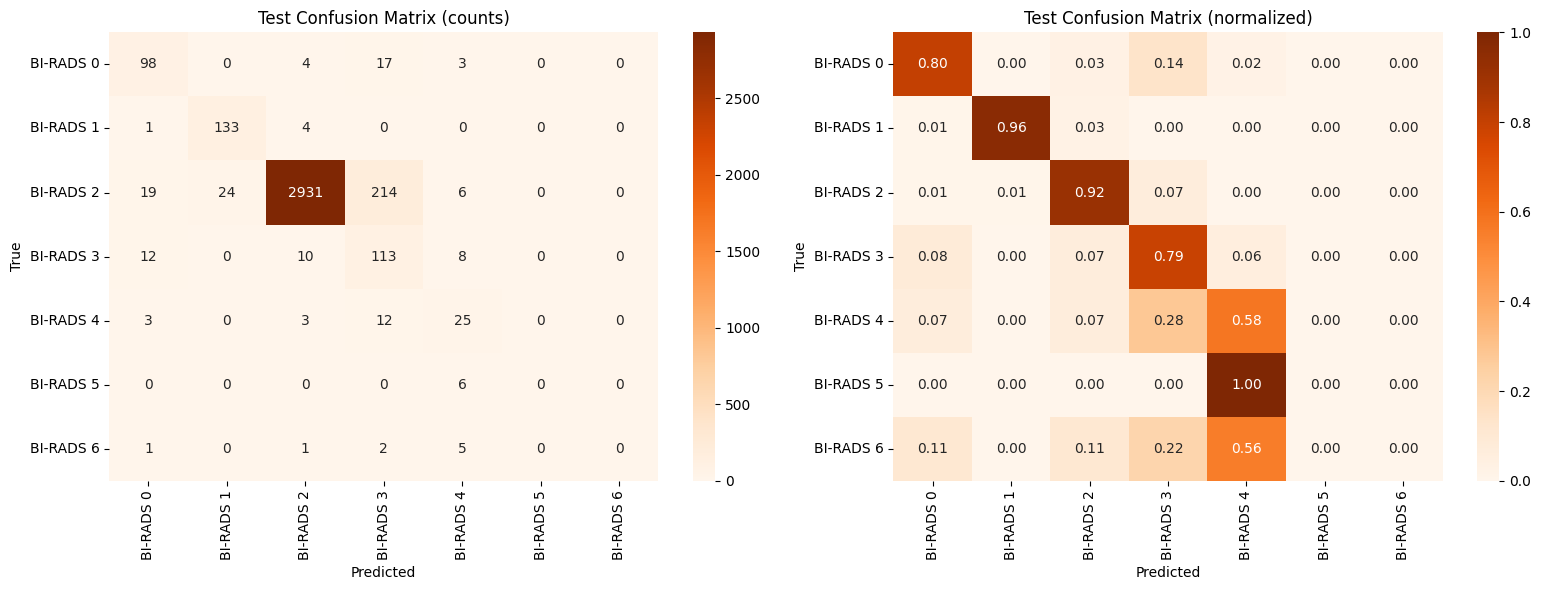

In [19]:
# ── Test confusion matrix ─────────────────────────────────────────────────────
cm_test      = confusion_matrix(test_true, test_pred_classes)
cm_test_norm = cm_test.astype(float) / cm_test.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, data, title, fmt in [
    (axes[0], cm_test,      "Test Confusion Matrix (counts)",     "d"),
    (axes[1], cm_test_norm, "Test Confusion Matrix (normalized)", ".2f"),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap="Oranges", ax=ax,
                xticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 11. Save Predictions

In [20]:
# ── Test predictions with ground truth ────────────────────────────────────────
test_results = test_df[["ID", "target"]].copy()
test_results["predicted"] = test_pred_classes
test_results["correct"]   = test_results["target"] == test_results["predicted"]
for i in range(NUM_CLASSES):
    test_results[f"prob_class_{i}"] = test_preds[:, i]

test_results.to_csv(f"{OUTPUT_DIR}/test_predictions.csv", index=False)
print(f"Test predictions saved to {OUTPUT_DIR}/test_predictions.csv")
print(f"Overall accuracy: {test_results['correct'].mean()*100:.2f}%")
test_results.head(10)

Test predictions saved to ./outputs_distilbert_weightbalance_newLoss/test_predictions.csv
Overall accuracy: 90.29%


ID  target  predicted  correct  prob_class_0  prob_class_1  \
0   Acc8052       2          2     True      0.009508      0.026239   
1  Acc13753       2          2     True      0.016614      0.029220   
2   Acc4514       2          2     True      0.012513      0.023810   
3  Acc12396       2          2     True      0.010967      0.022401   
4  Acc22659       2          1    False      0.004918      0.882445   
5  Acc22473       2          2     True      0.011029      0.022492   
6  Acc11889       2          2     True      0.011287      0.023467   
7   Acc4700       0          0     True      0.735124      0.003162   
8  Acc10650       2          2     True      0.009619      0.031216   
9  Acc16931       2          0    False      0.611640      0.003475   

   prob_class_2  prob_class_3  prob_class_4  prob_class_5  prob_class_6  
0      0.918682      0.036556      0.002859      0.001787      0.004369  
1      0.918675      0.027381      0.002899      0.001792      0.003421  
2      0.919767      0.035938      0.002655      0.001606      0.003711  
3      0.920855      0.037557      0.002685      0.001624      0.003910  
4      0.098188      0.005951      0.001919      0.002877      0.003702  
5      0.922068      0.036329      0.002665      0.001615      0.003802  
6      0.921718      0.035511      0.002654      0.001606      0.003757  
7      0.032454      0.197035      0.022195      0.005770      0.004261  
8      0.919254      0.031397      0.002718      0.001776      0.004020  
9      0.117764      0.226992      0.028151      0.006171      0.005806

In [21]:
# ── OOF predictions for stacking / further analysis ───────────────────────────
oof_df = pd.DataFrame(
    oof_preds,
    columns=[f"prob_class_{i}" for i in range(NUM_CLASSES)]
)
oof_df.insert(0, "ID",        train_df["ID"].values)
oof_df.insert(1, "target",    train_df["target"].values)
oof_df.insert(2, "predicted", oof_pred_classes)
oof_df.to_csv(f"{OUTPUT_DIR}/oof_predictions.csv", index=False)
print("OOF predictions saved.")

OOF predictions saved.
